In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import Pool, CatBoostClassifier
from sklearn import metrics
from scipy import interpolate
from tqdm import tqdm
from pathlib import Path
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import copy

In [2]:
# Set up plotting style

sns.set(font_scale=1.5)
sns.set_style('ticks')

colors = ['#88CCEE', '#882255', '#999933', '#332288', '#DDCC77', '#117733','#CC6677', '#44AA99', '#AA4499', '#DDDDDD', '#C70039', '#000000', '#D55E00', '#0072B2']

## Data loading and preprocessing

In [3]:
# Load data and filter for minimum number of occurences
# Returns a dict: extinction name -> pandas data frame

min_occurrence = 3

# Cleaned data - three extinctions
data_base = Path('data')

# List of characteristics
# It's important to place non-categorical characteristics at the END of this list.
characteristics = ['tiering', 'motility', 'feeding', 'protein', 'reproduction', 'mineralogy', 'physiology', 'geoplates', 'species']
categorical_chars = ['tiering', 'motility', 'feeding', 'protein', 'reproduction', 'mineralogy', 'physiology']

# Loading
events = [x for x in data_base.iterdir() if x.is_file() and x.suffix == '.csv']
datasets = {x.name[:x.name.find('_')]: pd.read_csv(x) for x in events}

# Filtering for number of occurrences, species and geoplates
datasets = {key: val[val['t_occurrences'] >= min_occurrence] for key, val in datasets.items()}
datasets = {key: val[val['species'] > 0] for key, val in datasets.items()}
datasets = {key: val[val['geoplates'] > 0] for key, val in datasets.items()}

In [4]:
# Order of the three major extinctions
ext_order = ['PTr', 'TrJ', 'KPg']

In [5]:
# homogenize spelling (capitalization)
for dataset in datasets.values():
    dataset.loc[dataset["mineralogy"] == "High Mg calcite", "mineralogy"] = "high Mg calcite"

In [6]:
# Resamples the data sets to split entries with multiple values into multiple rows with lower weight

def traverse(row, chars, params, weight):
    # Goes over the row recursively and splits if it finds multiple values for one characteristic
    if len(chars) == 0:
        params['weight'] = weight
        return [params]
    else:
        c = chars[0]
        v = row[c]
        if isinstance(v, int) or isinstance(v, float):
            if c not in categorical_chars or v < 10:
                params[c] = v
                return traverse(row, chars[1:], params, weight)
            else:
                res = []
                params1 = copy.deepcopy(params)
                params1[c] = v // 10
                res += traverse(row, chars[1:], params1, weight / 2)
                params2 = copy.deepcopy(params)
                params2[c] = v % 10
                res += traverse(row, chars[1:], params2, weight / 2)
                return res
        else:
            res = []
            parts = v.split('/')
                
            for subv in parts:
                subv = subv.strip()
                subparams = copy.deepcopy(params)
                subparams[c] = subv
                res += traverse(row, chars[1:], subparams, weight / len(parts))
            return res

def rewrite_multi_category(dataset):
    # Iterates over the rows for the traversal
    res = []
    for _, row in dataset.iterrows():
        start_cols = [x for x in dataset.columns if x not in characteristics]
        params = {x: row[x] for x in start_cols}
        
        res += traverse(row, characteristics, params, 1)
    
    return pd.DataFrame(res)

def repeat_rows(dataset):
    # Repeat rows according to the inverse of their weights
    wmin = np.min(dataset['weight'])
    res = []
    for _, row in dataset.iterrows():
        res += int(np.round(row['weight'] / wmin)) * [row]
    return pd.DataFrame(res)

# Run the actual resampling
datasets = {k: rewrite_multi_category(v) for k, v in datasets.items()}

In [7]:
orders = {}

# Fixed orders
orders["tiering"] = ["pelagic", "erect", "epifaunal", "semi-infaunal", "shallow infaunal", "deep infaunal"]
orders["motility"] = ["fast, motile", "slow, motile", "facultative, unattached", "facultative, attached", "stationary, unattached", "stationary, attached"]
orders["feeding"] = ["suspension", "surface deposit", "miner", "grazer", "predator", "symbionts"]
orders["protein"] = ['hemerythrin', 'hemocyanin', 'hemoglobin', 'other']
orders["reproduction"] = ['non-broadcaster', 'intermediate', 'broadcaster']
orders["mineralogy"] = ['aragonite', 'high Mg calcite', 'low Mg calcite', 'bimineralic', 'phosphatic', 'chitin', 'gorgonin', 'silica', 'soft-bodied']
orders["physiology"] = ['heavy carbonate load', 'moderate carbonate load', 'little or no carbonate load']

In [8]:
extinctions = ext_order
n_ext = len(extinctions)

In [9]:
a=datasets["KPg"]
a.weight.min()

0.5

## Data exploration

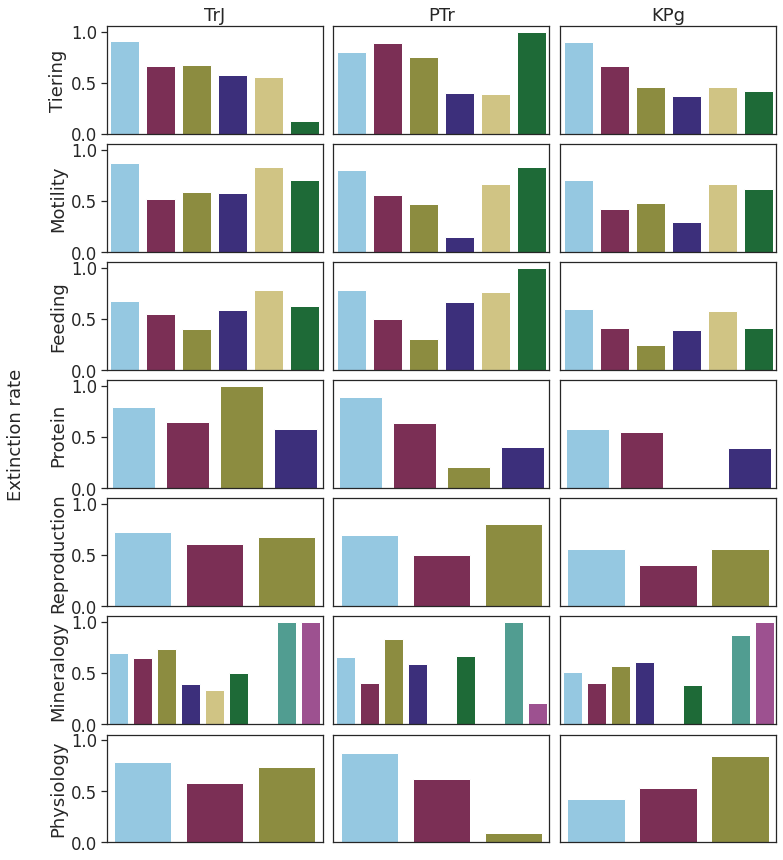

In [10]:
# Exploratory plot of the feature distribution
# For space constraints the feature names are removed

fig = plt.figure(figsize=(12, 15))
axs = fig.subplots(ncols=len(datasets), nrows=len(characteristics) - 2, gridspec_kw={'hspace': 0.1, 'wspace': 0.05}, sharex='row', sharey=True)

for j, (ext, dataset) in enumerate(datasets.items()):
    axs[0][j].set_title(ext)

    for i, char in enumerate(characteristics[:-2]):
        sns.barplot(data=dataset, x=char, y='extinct', ci=None, palette=colors, order=orders[char], ax=axs[i][j])
        
        if j > 0:
            axs[i][j].yaxis.set_visible(False)
        axs[i][j].xaxis.set_visible(False)
        
for i, char in enumerate(characteristics[:-2]):
    axs[i][0].set_ylabel(char.capitalize())
    
axs[3][0].set_ylabel(f'Extinction rate\n\n{characteristics[3].capitalize()}')

fig.savefig("images/extinction_rates.png", dpi=300, bbox_inches="tight")

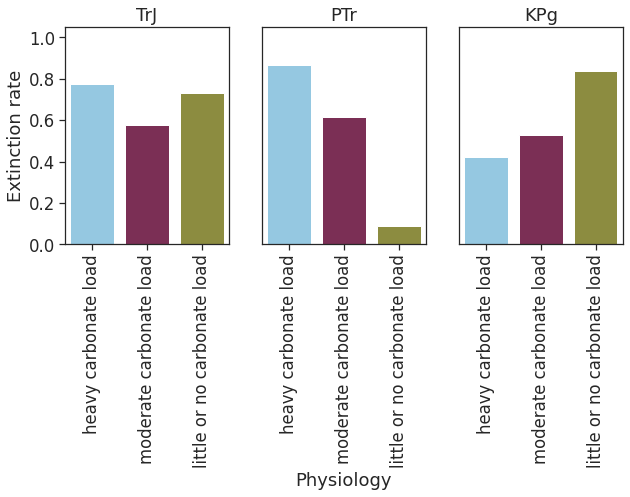

In [11]:
# Exploratory plot for a single characteristic
# char_idx is the index of the char in the list of characteristics
def exploratory_char(char_idx):
    fig = plt.figure(figsize=(10, 4))
    axs = fig.subplots(1, len(datasets), sharex=True, sharey=True)

    for j, (ext, dataset) in enumerate(datasets.items()):
        axs[j].set_title(ext)

        char = characteristics[char_idx]

        sns.barplot(data=dataset, x=char, y='extinct', ci=None, palette=colors, order=orders[char], ax=axs[j])

        if j > 0:
            axs[j].yaxis.set_visible(False)

        axs[j].tick_params(axis='x', rotation=90)
        axs[j].set_xlabel('')

    axs[len(datasets) // 2].set_xlabel(char.capitalize())
    axs[0].set_ylabel('Extinction rate')
    axs[0].set_ylim(0, 1.05)

# Example plot
exploratory_char(6)

In [12]:
# Print dataset statistics for the resampled datasets

print('Extinction\t# Extinct\t# Total\t\tFraction extinct')
for ext in ext_order:
    dataset = datasets[ext]
    print(f'{ext}\t\t{np.sum(dataset["extinct"])}\t\t{len(dataset)}\t\t{np.sum(dataset["extinct"]) / len(dataset):.2f}')
print('Respecting weights:')
for ext in ext_order:
    dataset = datasets[ext]
    print(f'{ext}\t\t{dataset[dataset.extinct==1]["weight"].sum()}\t\t{dataset.weight.sum()}\t\t{dataset[dataset.extinct==1]["weight"].sum() / dataset.weight.sum():.2f}')

Extinction	# Extinct	# Total		Fraction extinct
PTr		466		629		0.74
TrJ		410		614		0.67
KPg		628		1183		0.53
Respecting weights:
PTr		466.0		628.0		0.74
TrJ		381.0		571.0		0.67
KPg		617.0		1154.0		0.53


## E_occurence as predictor

In roughly half of the samples (even more for TrJ) we find e_occurrences < 3. As we required t_occurrences >= 3 in our data selection, this already guarantees for these samples, that they did not went extinct, basically removing half of the data for actuall assessment.

In [13]:
print('Extinction\tNaN\t#e_occurrences < 3\t# Samples')
for name, dataset in datasets.items():
    print(f"{name}\t\t{np.sum(np.isnan(dataset['e_occurrences']))}\t{np.sum(dataset['e_occurrences'] < 3)}\t\t\t{len(dataset)}")
    
print("Respecting weights:")
for name, dataset in datasets.items():
    print(f"{name}\t\t{np.sum(np.isnan(dataset['e_occurrences']))}\t{dataset[dataset['e_occurrences'] < 3].weight.sum()}\t\t\t{dataset.weight.sum()}")

Extinction	NaN	#e_occurrences < 3	# Samples
TrJ		0	225			614
PTr		0	176			629
KPg		0	288			1183
Respecting weights:
TrJ		0	214.0			571.0
PTr		0	175.0			628.0
KPg		0	276.0			1154.0


## Model training 

In [14]:
def split_xy(data):
    # Returns numpy matrices of features and labels
    return data[characteristics].values, data['extinct'].values

def prepare_data(dataset, split=True):
    if split:
        # Splits data into training and test with a ratio of 80 : 20.
        # Ensures that all samples from the same base index are in the same split to avoid knowledge leaks.
        # Multiple occurrence of the same sample is a result from the resampling.
        base_idx = np.unique(dataset.index)
        
        splits = np.arange(5).repeat(len(base_idx) // 5 + 1)
        np.random.shuffle(splits)
        splits = splits[:len(base_idx)]
        test_idx = base_idx[splits == 0]

        train_data = dataset[~dataset.index.isin(test_idx)]
        test_data = dataset[dataset.index.isin(test_idx)]

        x_train, y_train = split_xy(train_data)
        x_test, y_test = split_xy(test_data)
    
        return x_train, y_train, x_test, y_test
        
    else:
        return split_xy(dataset)

In [15]:
# Train a catboost model
def train_model(x_train, y_train, x_test, y_test, random_seed=0, **kwargs):
    model = CatBoostClassifier(loss_function="Logloss", random_seed=random_seed)

    # Sets all features a categorical except e_occurrences
    model.fit(x_train, y_train, np.arange(len(categorical_chars)), eval_set=(x_test, y_test), **kwargs)
    
    return model

In [16]:
def run_experiments(iterations=10):
    # Trains models and evaluates feature importance and performance on the different data sets for each iteration
    # The results are stored in the variables res_full (AUC scores) and feat_imp (feature importances)

    res_full = np.zeros((iterations, n_ext, n_ext))
    res_full_train = np.zeros((iterations, n_ext))
    feat_imp = np.zeros((iterations, n_ext, len(characteristics)))

    fpr = dict()
    tpr = dict()
    
    data = None
    model = None
    
    for it in tqdm(range(iterations)):
        res = res_full[it]
        res_train = res_full_train[it]
        
        for i, base in enumerate(extinctions):
            data = prepare_data(datasets[base])
                        
            model = train_model(*data, random_seed=it, plot=False, verbose=False, use_best_model=False)

            feat_imp[it, i] = model.feature_importances_

            x_train, y_train, x_test, y_test = data

            train_auc = metrics.roc_auc_score(y_train, model.predict_log_proba(x_train)[:, 1])
            test_auc = metrics.roc_auc_score(y_test, model.predict_log_proba(x_test)[:, 1])
            res_train[i] = train_auc
            res[i, i] = test_auc
            
            fpr[it, base, base], tpr[it, base, base], _ = metrics.roc_curve(
                y_test, model.predict_log_proba(x_test)[:, 1])

            for j, ext in enumerate(extinctions):
                if ext == base:
                    continue
                dataset = datasets[ext]

                x, y = split_xy(dataset)

                res[i, j] = metrics.roc_auc_score(y, model.predict_log_proba(x)[:, 1])
                fpr[it, base, ext], tpr[it, base, ext], _ = metrics.roc_curve(
                    y, model.predict_log_proba(x)[:, 1])
    
    return res_full, feat_imp, fpr, tpr, res_full_train

In [17]:
res_full_noocc, feat_imp_noocc, fpr_noocc, tpr_noocc, res_train = run_experiments(iterations=10)

100%|██████████| 10/10 [00:44<00:00,  4.43s/it]


In [18]:
# to measure overfitting (dev_score / train_score)
print("dev_score / train_score")
print("\t".join(extinctions))
print("\t".join([f"{x:.2f}" for x in np.mean(res_full_noocc[:, [0, 1, 2], [0, 1, 2]] / res_train, axis=0)]))

dev_score / train_score
PTr	TrJ	KPg
0.94	0.89	0.90


## Result plotting

In [19]:
def plot_auc_grid(res_full, vmax=0.85):
    # Plot average AUC for the different corpora combinations

    fig = plt.figure(figsize=(8, 7))
    spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, **{'width_ratios': [5, 0.5], 'wspace': 0.1})
    ax = fig.add_subplot(spec[0])

    res_reduced = np.mean(res_full, axis=0)

    cb = ax.imshow(res_reduced, vmin=0.5, vmax=vmax)

    ax.set_xticks(np.arange(n_ext))
    ax.set_xticklabels(extinctions)
    ax.set_yticks(np.arange(n_ext))
    ax.set_yticklabels(extinctions)

    ax.set_xlabel('Applied to')
    ax.set_ylabel('Trained on')

    ax3 = fig.add_subplot(spec[1])
    fig.colorbar(cb, cax=ax3)

    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    ax3.set_ylabel('Performance')
    
    fig.savefig("images/auc_grid.png", dpi=300, bbox_inches="tight")

In [20]:
def plot_feat_imp(feat_imp):
    # Plot average and standard deviation of the feature importances

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)

    base_x = np.arange(n_ext)
    w = 0.07

    for i, char in enumerate(characteristics):            
        px = base_x + (i - 3) * w
        m = feat_imp[:, :, i].mean(axis=0)
        std = feat_imp[:, :, i].std(axis=0) / np.sqrt(feat_imp.shape[0])

        ax.plot(px, m, 'o', c=f'C{i}', label=char.capitalize(), ms=10)
        ax.plot(px, m, '-', c=f'C{i}', linewidth=2)
        for j in range(feat_imp.shape[1]):
            ax.plot([px[j], px[j]], [m[j] + std[j], m[j] - std[j]], c=f'k', linewidth=1.5, alpha=1)
            ax.plot([px[j] - w / 3, px[j] + w / 3], [m[j] + std[j], m[j] + std[j]], c=f'k', linewidth=1.5, alpha=1)
            ax.plot([px[j] - w / 3, px[j] + w / 3], [m[j] - std[j], m[j] - std[j]], c=f'k', linewidth=1.5, alpha=1)

    for s, e in zip(base_x[:-1], base_x[1:]):
        ax.axvline((s + e) / 2, alpha=0.3, c='k', linestyle='--', lw=1.5)

    ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
    ax.set_xticks(base_x)
    ax.set_xticklabels(extinctions)

    ax.set_yticklabels([])
    # ax.set_yticks([])
    ax.set_ylabel('Feature importance')
    ax.set_xlabel('Extinction')
    
    fig.savefig("images/feature_importance.png", dpi=300, bbox_inches="tight")

In [21]:
def plot_roc_grid(fpr, tpr, res_full):
    res_reduced = np.mean(res_full, axis=0)
    xSpace = np.linspace(0,1,300)

    fig, axs = plt.subplots(3, 3, 
                            sharex=True, sharey=True, 
                            figsize=(12, 12), 
                            gridspec_kw={'hspace': 0.2, 'wspace': 0.15})
    
    for i, ext in enumerate(extinctions):
        for j, base in enumerate(extinctions):
            axs[i, j].set_title(base + r" $\rightarrow$ " + ext)
            interpROCs = []
            for it in range(res_full.shape[0]):
                axs[i, j].plot(fpr[it, base, ext], tpr[it, base, ext], 'k-', alpha=0.3, linewidth=1)
                # ROC curves have different x-values. To average them, they are first interpolated to 
                # a common linspace ("xSpace")
                interpROC = interpolate.interp1d(fpr[it, base, ext], tpr[it, base, ext], kind='linear')
                interpROCs.append(interpROC(xSpace))
                
            avgROC = np.mean(interpROCs, axis=0)
            axs[i, j].plot(xSpace, avgROC, 'k-', alpha=1, linewidth=1)
            axs[i, j].plot([0, 1], [0, 1], "k--")
            axs[i, j].set_xlim(0, 1)
            axs[i, j].set_ylim(0, 1)
            axs[i, j].set_aspect(1)
            axs[i, j].set_xticks([0, 0.5, 1])
            axs[i, j].set_yticks([0, 0.5, 1])
            axs[i, j].set_xticklabels(axs[i, j].get_xticks())
        
            axs[i,j].text(0.4, 0.15, 
                          "$\overline{\mathrm{AUC}}$" + "={:.3f}".format(res_reduced[j,i]), 
                          horizontalalignment="left", 
                          verticalalignment="top")
            
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    
    fig.savefig("images/roc_curves.png", dpi=300, bbox_inches="tight")
    
#     plt.show()

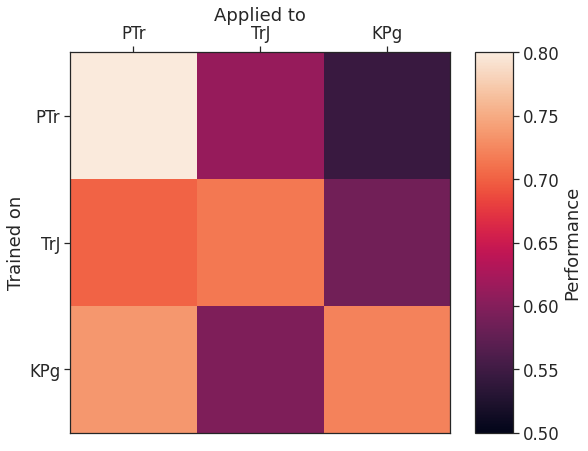

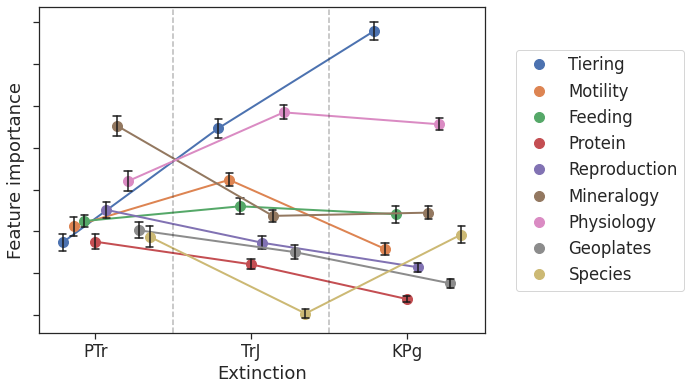

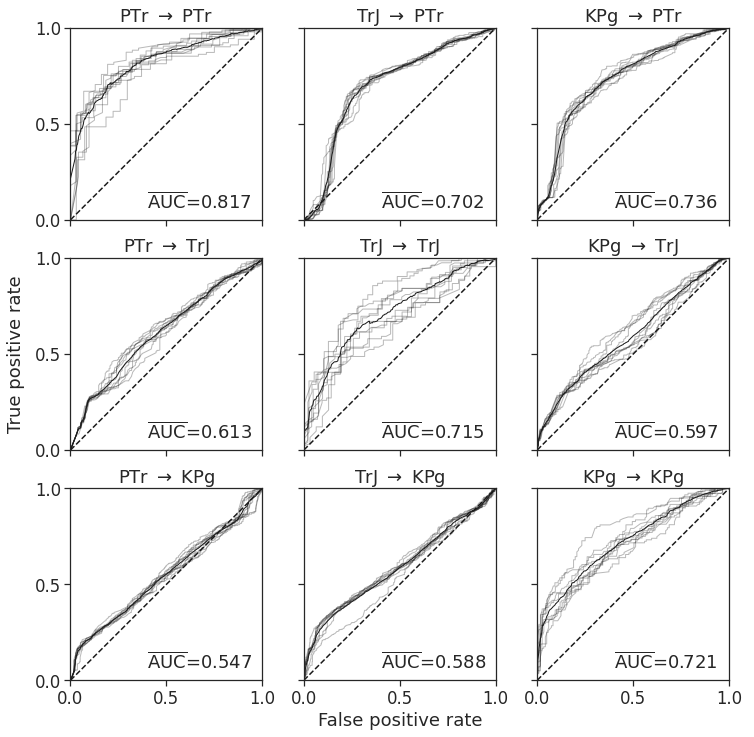

In [22]:
plot_auc_grid(res_full_noocc, vmax=0.80)
plot_feat_imp(feat_imp_noocc)
plot_roc_grid(fpr_noocc, tpr_noocc, res_full_noocc)

## Hyperparameter search

In [23]:
# Find optimal hyperparameters 
def find_best_params(training_data, **kwargs):
    model = CatBoostClassifier(iterations=1000)
    
    grid = {'learning_rate': [0.01, 0.03, 0.1, 0.5],
            'depth': [1,4, 6, 8, 10],
            'l2_leaf_reg': [1, 3, 5, 7, 9]}
    
    res_dict = model.grid_search(grid, training_data, verbose=3, **kwargs)
    return res_dict["params"], res_dict["cv_results"]

In [24]:
params = {}
cv_results = {}

for i, base in enumerate(extinctions):
    data = datasets[base]
    x_train, y_train = split_xy(data)
    training_data = Pool(x_train, y_train, 
                         cat_features=np.arange(x_train.shape[1] - 2),
                         weight=data["weight"])
    params[base], cv_results[base] = find_best_params(training_data, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6899209	test: 0.6889655	best: 0.6889655 (0)	total: 1.09ms	remaining: 1.09s
1:	learn: 0.6876563	test: 0.6862756	best: 0.6862756 (1)	total: 1.85ms	remaining: 925ms
2:	learn: 0.6847503	test: 0.6823450	best: 0.6823450 (2)	total: 2.42ms	remaining: 804ms
3:	learn: 0.6817393	test: 0.6781253	best: 0.6781253 (3)	total: 2.84ms	remaining: 708ms
4:	learn: 0.6796649	test: 0.6753594	best: 0.6753594 (4)	total: 3.38ms	remaining: 672ms
5:	learn: 0.6766002	test: 0.6710204	best: 0.6710204 (5)	total: 3.74ms	remaining: 620ms
6:	learn: 0.6739288	test: 0.6674220	best: 0.6674220 (6)	total: 4.21ms	remaining: 597ms
7:	learn: 0.6710848	test: 0.6637430	best: 0.6637430 (7)	total: 4.88ms	remaining: 605ms
8:	learn: 0.6684208	test: 0.6602100	best: 0.6602100 (8)	total: 5.38ms	remaining: 593ms
9:	learn: 0.6665850	test: 0.6577819	best: 0.6577819 (9)	total: 5.89ms	remaining: 583ms
10:	learn: 0.6639629	test: 0.6543395	best: 0.6543395 (10)	total: 6.25ms	remaining: 562ms
11:	learn: 0.6612434	test: 0.6504514	best

432:	learn: 0.5027453	test: 0.4409895	best: 0.4409836 (431)	total: 191ms	remaining: 250ms
433:	learn: 0.5026650	test: 0.4409421	best: 0.4409421 (433)	total: 191ms	remaining: 249ms
434:	learn: 0.5025790	test: 0.4409114	best: 0.4409114 (434)	total: 192ms	remaining: 249ms
435:	learn: 0.5025790	test: 0.4409112	best: 0.4409112 (435)	total: 192ms	remaining: 248ms
436:	learn: 0.5024947	test: 0.4408816	best: 0.4408816 (436)	total: 193ms	remaining: 248ms
437:	learn: 0.5024645	test: 0.4408336	best: 0.4408336 (437)	total: 193ms	remaining: 248ms
438:	learn: 0.5024503	test: 0.4408227	best: 0.4408227 (438)	total: 193ms	remaining: 247ms
439:	learn: 0.5023929	test: 0.4408112	best: 0.4408112 (439)	total: 194ms	remaining: 247ms
440:	learn: 0.5023596	test: 0.4406898	best: 0.4406898 (440)	total: 194ms	remaining: 246ms
441:	learn: 0.5022693	test: 0.4406802	best: 0.4406802 (441)	total: 195ms	remaining: 246ms
442:	learn: 0.5021494	test: 0.4405811	best: 0.4405811 (442)	total: 195ms	remaining: 245ms
443:	learn

830:	learn: 0.4880017	test: 0.4329914	best: 0.4329909 (829)	total: 386ms	remaining: 78.5ms
831:	learn: 0.4879987	test: 0.4330009	best: 0.4329909 (829)	total: 402ms	remaining: 81.2ms
832:	learn: 0.4879893	test: 0.4330150	best: 0.4329909 (829)	total: 405ms	remaining: 81.3ms
833:	learn: 0.4879465	test: 0.4329901	best: 0.4329901 (833)	total: 406ms	remaining: 80.8ms
834:	learn: 0.4878975	test: 0.4328835	best: 0.4328835 (834)	total: 407ms	remaining: 80.5ms
835:	learn: 0.4878883	test: 0.4328977	best: 0.4328835 (834)	total: 408ms	remaining: 80ms
836:	learn: 0.4878883	test: 0.4328978	best: 0.4328835 (834)	total: 409ms	remaining: 79.6ms
837:	learn: 0.4878732	test: 0.4328942	best: 0.4328835 (834)	total: 410ms	remaining: 79.2ms
838:	learn: 0.4878584	test: 0.4328907	best: 0.4328835 (834)	total: 411ms	remaining: 78.8ms
839:	learn: 0.4878172	test: 0.4327927	best: 0.4327927 (839)	total: 412ms	remaining: 78.4ms
840:	learn: 0.4878027	test: 0.4327892	best: 0.4327892 (840)	total: 412ms	remaining: 78ms
841

194:	learn: 0.4957648	test: 0.4379450	best: 0.4379450 (194)	total: 84ms	remaining: 347ms
195:	learn: 0.4955612	test: 0.4378979	best: 0.4378979 (195)	total: 84.5ms	remaining: 347ms
196:	learn: 0.4955447	test: 0.4379175	best: 0.4378979 (195)	total: 85ms	remaining: 346ms
197:	learn: 0.4954836	test: 0.4379021	best: 0.4378979 (195)	total: 85.4ms	remaining: 346ms
198:	learn: 0.4953506	test: 0.4378794	best: 0.4378794 (198)	total: 85.9ms	remaining: 346ms
199:	learn: 0.4952966	test: 0.4380464	best: 0.4378794 (198)	total: 86.3ms	remaining: 345ms
200:	learn: 0.4952830	test: 0.4380225	best: 0.4378794 (198)	total: 86.7ms	remaining: 345ms
201:	learn: 0.4949653	test: 0.4377663	best: 0.4377663 (201)	total: 87.2ms	remaining: 344ms
202:	learn: 0.4947797	test: 0.4377750	best: 0.4377663 (201)	total: 87.5ms	remaining: 344ms
203:	learn: 0.4944794	test: 0.4375350	best: 0.4375350 (203)	total: 87.8ms	remaining: 343ms
204:	learn: 0.4944794	test: 0.4375356	best: 0.4375350 (203)	total: 88.3ms	remaining: 342ms
205

600:	learn: 0.4745610	test: 0.4276193	best: 0.4274750 (599)	total: 274ms	remaining: 182ms
601:	learn: 0.4745389	test: 0.4276545	best: 0.4274750 (599)	total: 274ms	remaining: 181ms
602:	learn: 0.4745389	test: 0.4276550	best: 0.4274750 (599)	total: 275ms	remaining: 181ms
603:	learn: 0.4745217	test: 0.4276372	best: 0.4274750 (599)	total: 275ms	remaining: 180ms
604:	learn: 0.4745217	test: 0.4276375	best: 0.4274750 (599)	total: 276ms	remaining: 180ms
605:	learn: 0.4744671	test: 0.4276248	best: 0.4274750 (599)	total: 276ms	remaining: 179ms
606:	learn: 0.4744671	test: 0.4276252	best: 0.4274750 (599)	total: 276ms	remaining: 179ms
607:	learn: 0.4743761	test: 0.4276300	best: 0.4274750 (599)	total: 277ms	remaining: 178ms
608:	learn: 0.4743564	test: 0.4276644	best: 0.4274750 (599)	total: 277ms	remaining: 178ms
609:	learn: 0.4742686	test: 0.4276772	best: 0.4274750 (599)	total: 278ms	remaining: 178ms
610:	learn: 0.4742483	test: 0.4276697	best: 0.4274750 (599)	total: 278ms	remaining: 177ms
611:	learn

48:	learn: 0.4995731	test: 0.4343535	best: 0.4336870 (45)	total: 22.8ms	remaining: 443ms
49:	learn: 0.4989002	test: 0.4333830	best: 0.4333830 (49)	total: 23.2ms	remaining: 441ms
50:	learn: 0.4977694	test: 0.4338093	best: 0.4333830 (49)	total: 23.6ms	remaining: 439ms
51:	learn: 0.4977694	test: 0.4338090	best: 0.4333830 (49)	total: 24ms	remaining: 438ms
52:	learn: 0.4970392	test: 0.4333346	best: 0.4333346 (52)	total: 24.6ms	remaining: 440ms
53:	learn: 0.4964524	test: 0.4334857	best: 0.4333346 (52)	total: 25.2ms	remaining: 441ms
54:	learn: 0.4958968	test: 0.4327666	best: 0.4327666 (54)	total: 26.3ms	remaining: 453ms
55:	learn: 0.4956486	test: 0.4330514	best: 0.4327666 (54)	total: 26.8ms	remaining: 452ms
56:	learn: 0.4953604	test: 0.4329449	best: 0.4327666 (54)	total: 27.4ms	remaining: 453ms
57:	learn: 0.4944628	test: 0.4328853	best: 0.4327666 (54)	total: 27.8ms	remaining: 452ms
58:	learn: 0.4936489	test: 0.4333769	best: 0.4327666 (54)	total: 28.3ms	remaining: 452ms
59:	learn: 0.4932886	te

505:	learn: 0.4498800	test: 0.4116373	best: 0.4116373 (505)	total: 209ms	remaining: 204ms
506:	learn: 0.4498460	test: 0.4116179	best: 0.4116179 (506)	total: 209ms	remaining: 204ms
507:	learn: 0.4497376	test: 0.4120189	best: 0.4116179 (506)	total: 210ms	remaining: 203ms
508:	learn: 0.4497329	test: 0.4120251	best: 0.4116179 (506)	total: 210ms	remaining: 203ms
509:	learn: 0.4496832	test: 0.4118671	best: 0.4116179 (506)	total: 211ms	remaining: 203ms
510:	learn: 0.4495995	test: 0.4116494	best: 0.4116179 (506)	total: 211ms	remaining: 202ms
511:	learn: 0.4495691	test: 0.4118674	best: 0.4116179 (506)	total: 212ms	remaining: 202ms
512:	learn: 0.4495430	test: 0.4118990	best: 0.4116179 (506)	total: 212ms	remaining: 201ms
513:	learn: 0.4495236	test: 0.4119883	best: 0.4116179 (506)	total: 213ms	remaining: 201ms
514:	learn: 0.4495170	test: 0.4120122	best: 0.4116179 (506)	total: 213ms	remaining: 201ms
515:	learn: 0.4494774	test: 0.4119518	best: 0.4116179 (506)	total: 213ms	remaining: 200ms
516:	learn

bestTest = 0.4034529811
bestIteration = 793

0:	learn: 0.5794657	test: 0.5395681	best: 0.5395681 (0)	total: 651us	remaining: 651ms
1:	learn: 0.5483295	test: 0.5042941	best: 0.5042941 (1)	total: 1.07ms	remaining: 534ms
2:	learn: 0.5407464	test: 0.4927345	best: 0.4927345 (2)	total: 1.42ms	remaining: 473ms
3:	learn: 0.5391015	test: 0.4879054	best: 0.4879054 (3)	total: 1.77ms	remaining: 442ms
4:	learn: 0.5304714	test: 0.4694067	best: 0.4694067 (4)	total: 2.16ms	remaining: 429ms
5:	learn: 0.5260487	test: 0.4645606	best: 0.4645606 (5)	total: 2.52ms	remaining: 418ms
6:	learn: 0.5163675	test: 0.4647425	best: 0.4645606 (5)	total: 2.93ms	remaining: 415ms
7:	learn: 0.5121478	test: 0.4617537	best: 0.4617537 (7)	total: 3.29ms	remaining: 408ms
8:	learn: 0.5095157	test: 0.4643909	best: 0.4617537 (7)	total: 3.61ms	remaining: 397ms
9:	learn: 0.5067742	test: 0.4639773	best: 0.4617537 (7)	total: 3.96ms	remaining: 392ms
10:	learn: 0.5020477	test: 0.4628597	best: 0.4617537 (7)	total: 4.29ms	remaining: 386m

463:	learn: 0.4027709	test: 0.4243071	best: 0.4056939 (167)	total: 185ms	remaining: 214ms
464:	learn: 0.4027705	test: 0.4243152	best: 0.4056939 (167)	total: 186ms	remaining: 214ms
465:	learn: 0.4026022	test: 0.4236274	best: 0.4056939 (167)	total: 186ms	remaining: 213ms
466:	learn: 0.4019397	test: 0.4266397	best: 0.4056939 (167)	total: 189ms	remaining: 215ms
467:	learn: 0.4019047	test: 0.4266965	best: 0.4056939 (167)	total: 189ms	remaining: 215ms
468:	learn: 0.4018667	test: 0.4267671	best: 0.4056939 (167)	total: 189ms	remaining: 214ms
469:	learn: 0.4018226	test: 0.4267194	best: 0.4056939 (167)	total: 190ms	remaining: 214ms
470:	learn: 0.4018053	test: 0.4265753	best: 0.4056939 (167)	total: 190ms	remaining: 213ms
471:	learn: 0.4017286	test: 0.4271155	best: 0.4056939 (167)	total: 190ms	remaining: 213ms
472:	learn: 0.4017096	test: 0.4269433	best: 0.4056939 (167)	total: 191ms	remaining: 212ms
473:	learn: 0.4017001	test: 0.4267342	best: 0.4056939 (167)	total: 191ms	remaining: 212ms
474:	learn

981:	learn: 0.3762665	test: 0.4467619	best: 0.4056939 (167)	total: 371ms	remaining: 6.8ms
982:	learn: 0.3761930	test: 0.4459680	best: 0.4056939 (167)	total: 372ms	remaining: 6.42ms
983:	learn: 0.3761900	test: 0.4459221	best: 0.4056939 (167)	total: 372ms	remaining: 6.05ms
984:	learn: 0.3761751	test: 0.4457078	best: 0.4056939 (167)	total: 372ms	remaining: 5.67ms
985:	learn: 0.3761667	test: 0.4457626	best: 0.4056939 (167)	total: 373ms	remaining: 5.29ms
986:	learn: 0.3761655	test: 0.4457693	best: 0.4056939 (167)	total: 373ms	remaining: 4.91ms
987:	learn: 0.3761025	test: 0.4457002	best: 0.4056939 (167)	total: 373ms	remaining: 4.53ms
988:	learn: 0.3760679	test: 0.4468666	best: 0.4056939 (167)	total: 374ms	remaining: 4.16ms
989:	learn: 0.3760143	test: 0.4457265	best: 0.4056939 (167)	total: 374ms	remaining: 3.78ms
990:	learn: 0.3760094	test: 0.4456360	best: 0.4056939 (167)	total: 374ms	remaining: 3.4ms
991:	learn: 0.3759705	test: 0.4455594	best: 0.4056939 (167)	total: 375ms	remaining: 3.02ms
9

361:	learn: 0.5098063	test: 0.4462162	best: 0.4462162 (361)	total: 180ms	remaining: 317ms
362:	learn: 0.5098057	test: 0.4462069	best: 0.4462069 (362)	total: 180ms	remaining: 316ms
363:	learn: 0.5096864	test: 0.4462208	best: 0.4462069 (362)	total: 181ms	remaining: 315ms
364:	learn: 0.5095424	test: 0.4460693	best: 0.4460693 (364)	total: 181ms	remaining: 315ms
365:	learn: 0.5095235	test: 0.4460552	best: 0.4460552 (365)	total: 182ms	remaining: 315ms
366:	learn: 0.5094811	test: 0.4461122	best: 0.4460552 (365)	total: 182ms	remaining: 314ms
367:	learn: 0.5093401	test: 0.4459638	best: 0.4459638 (367)	total: 182ms	remaining: 313ms
368:	learn: 0.5092019	test: 0.4458183	best: 0.4458183 (368)	total: 183ms	remaining: 312ms
369:	learn: 0.5091529	test: 0.4458162	best: 0.4458162 (369)	total: 183ms	remaining: 312ms
370:	learn: 0.5090806	test: 0.4456537	best: 0.4456537 (370)	total: 184ms	remaining: 311ms
371:	learn: 0.5089877	test: 0.4455143	best: 0.4455143 (371)	total: 184ms	remaining: 311ms
372:	learn

726:	learn: 0.4912660	test: 0.4331494	best: 0.4331494 (726)	total: 368ms	remaining: 138ms
727:	learn: 0.4912660	test: 0.4331495	best: 0.4331494 (726)	total: 369ms	remaining: 138ms
728:	learn: 0.4912494	test: 0.4331457	best: 0.4331457 (728)	total: 370ms	remaining: 137ms
729:	learn: 0.4911952	test: 0.4331364	best: 0.4331364 (729)	total: 370ms	remaining: 137ms
730:	learn: 0.4911751	test: 0.4331929	best: 0.4331364 (729)	total: 370ms	remaining: 136ms
731:	learn: 0.4911661	test: 0.4332090	best: 0.4331364 (729)	total: 371ms	remaining: 136ms
732:	learn: 0.4911464	test: 0.4332652	best: 0.4331364 (729)	total: 372ms	remaining: 136ms
733:	learn: 0.4910959	test: 0.4332729	best: 0.4331364 (729)	total: 373ms	remaining: 135ms
734:	learn: 0.4910523	test: 0.4332679	best: 0.4331364 (729)	total: 373ms	remaining: 135ms
735:	learn: 0.4909991	test: 0.4333122	best: 0.4331364 (729)	total: 374ms	remaining: 134ms
736:	learn: 0.4909799	test: 0.4333678	best: 0.4331364 (729)	total: 374ms	remaining: 134ms
737:	learn

87:	learn: 0.5186468	test: 0.4559815	best: 0.4559815 (87)	total: 45.4ms	remaining: 470ms
88:	learn: 0.5180318	test: 0.4553000	best: 0.4553000 (88)	total: 45.9ms	remaining: 469ms
89:	learn: 0.5176883	test: 0.4548983	best: 0.4548983 (89)	total: 46.3ms	remaining: 469ms
90:	learn: 0.5175194	test: 0.4547463	best: 0.4547463 (90)	total: 46.8ms	remaining: 468ms
91:	learn: 0.5171385	test: 0.4544269	best: 0.4544269 (91)	total: 47.4ms	remaining: 467ms
92:	learn: 0.5166452	test: 0.4539873	best: 0.4539873 (92)	total: 47.8ms	remaining: 467ms
93:	learn: 0.5162923	test: 0.4536873	best: 0.4536873 (93)	total: 48.3ms	remaining: 465ms
94:	learn: 0.5159633	test: 0.4534020	best: 0.4534020 (94)	total: 48.8ms	remaining: 465ms
95:	learn: 0.5157655	test: 0.4532890	best: 0.4532890 (95)	total: 49.4ms	remaining: 465ms
96:	learn: 0.5153699	test: 0.4527050	best: 0.4527050 (96)	total: 49.7ms	remaining: 463ms
97:	learn: 0.5153442	test: 0.4525915	best: 0.4525915 (97)	total: 50.1ms	remaining: 461ms
98:	learn: 0.5150411	

588:	learn: 0.4758193	test: 0.4274730	best: 0.4274730 (588)	total: 232ms	remaining: 162ms
589:	learn: 0.4757823	test: 0.4274625	best: 0.4274625 (589)	total: 233ms	remaining: 162ms
590:	learn: 0.4757222	test: 0.4274529	best: 0.4274529 (590)	total: 234ms	remaining: 162ms
591:	learn: 0.4757203	test: 0.4274592	best: 0.4274529 (590)	total: 234ms	remaining: 161ms
592:	learn: 0.4756896	test: 0.4274807	best: 0.4274529 (590)	total: 234ms	remaining: 161ms
593:	learn: 0.4756676	test: 0.4275992	best: 0.4274529 (590)	total: 235ms	remaining: 160ms
594:	learn: 0.4756115	test: 0.4275838	best: 0.4274529 (590)	total: 235ms	remaining: 160ms
595:	learn: 0.4756115	test: 0.4275845	best: 0.4274529 (590)	total: 235ms	remaining: 160ms
596:	learn: 0.4755909	test: 0.4276998	best: 0.4274529 (590)	total: 236ms	remaining: 159ms
597:	learn: 0.4755909	test: 0.4277006	best: 0.4274529 (590)	total: 236ms	remaining: 159ms
598:	learn: 0.4755683	test: 0.4277347	best: 0.4274529 (590)	total: 236ms	remaining: 158ms
599:	learn

85:	learn: 0.4844221	test: 0.4339017	best: 0.4332303 (56)	total: 32.9ms	remaining: 349ms
86:	learn: 0.4841255	test: 0.4338484	best: 0.4332303 (56)	total: 33.5ms	remaining: 351ms
87:	learn: 0.4840313	test: 0.4340135	best: 0.4332303 (56)	total: 34ms	remaining: 352ms
88:	learn: 0.4835934	test: 0.4334738	best: 0.4332303 (56)	total: 34.5ms	remaining: 353ms
89:	learn: 0.4835934	test: 0.4334768	best: 0.4332303 (56)	total: 34.9ms	remaining: 352ms
90:	learn: 0.4834030	test: 0.4336636	best: 0.4332303 (56)	total: 35.4ms	remaining: 353ms
91:	learn: 0.4833058	test: 0.4337226	best: 0.4332303 (56)	total: 35.9ms	remaining: 354ms
92:	learn: 0.4832341	test: 0.4338855	best: 0.4332303 (56)	total: 36.2ms	remaining: 353ms
93:	learn: 0.4832341	test: 0.4338855	best: 0.4332303 (56)	total: 36.5ms	remaining: 352ms
94:	learn: 0.4829388	test: 0.4342699	best: 0.4332303 (56)	total: 36.9ms	remaining: 352ms
95:	learn: 0.4829380	test: 0.4342519	best: 0.4332303 (56)	total: 37.3ms	remaining: 351ms
96:	learn: 0.4825471	te

528:	learn: 0.4501772	test: 0.4126101	best: 0.4126101 (528)	total: 221ms	remaining: 197ms
529:	learn: 0.4501380	test: 0.4125796	best: 0.4125796 (529)	total: 221ms	remaining: 196ms
530:	learn: 0.4501141	test: 0.4126043	best: 0.4125796 (529)	total: 222ms	remaining: 196ms
531:	learn: 0.4500339	test: 0.4126690	best: 0.4125796 (529)	total: 222ms	remaining: 196ms
532:	learn: 0.4499655	test: 0.4126873	best: 0.4125796 (529)	total: 223ms	remaining: 195ms
533:	learn: 0.4499067	test: 0.4129022	best: 0.4125796 (529)	total: 223ms	remaining: 195ms
534:	learn: 0.4498767	test: 0.4125239	best: 0.4125239 (534)	total: 226ms	remaining: 196ms
535:	learn: 0.4498767	test: 0.4125239	best: 0.4125239 (535)	total: 226ms	remaining: 196ms
536:	learn: 0.4498706	test: 0.4125488	best: 0.4125239 (535)	total: 227ms	remaining: 196ms
537:	learn: 0.4498706	test: 0.4125484	best: 0.4125239 (535)	total: 227ms	remaining: 195ms
538:	learn: 0.4498413	test: 0.4125849	best: 0.4125239 (535)	total: 228ms	remaining: 195ms
539:	learn

0:	learn: 0.5794688	test: 0.5395725	best: 0.5395725 (0)	total: 853us	remaining: 853ms
1:	learn: 0.5483321	test: 0.5042958	best: 0.5042958 (1)	total: 2.73ms	remaining: 1.36s
2:	learn: 0.5372258	test: 0.4812798	best: 0.4812798 (2)	total: 3.07ms	remaining: 1.02s
3:	learn: 0.5220985	test: 0.4684021	best: 0.4684021 (3)	total: 3.59ms	remaining: 894ms
4:	learn: 0.5138042	test: 0.4560055	best: 0.4560055 (4)	total: 3.9ms	remaining: 777ms
5:	learn: 0.5066876	test: 0.4514185	best: 0.4514185 (5)	total: 4.34ms	remaining: 719ms
6:	learn: 0.4974377	test: 0.4526361	best: 0.4514185 (5)	total: 4.77ms	remaining: 676ms
7:	learn: 0.4945661	test: 0.4525605	best: 0.4514185 (5)	total: 5.2ms	remaining: 644ms
8:	learn: 0.4941214	test: 0.4518172	best: 0.4514185 (5)	total: 5.54ms	remaining: 610ms
9:	learn: 0.4927909	test: 0.4498665	best: 0.4498665 (9)	total: 5.92ms	remaining: 586ms
10:	learn: 0.4901134	test: 0.4495310	best: 0.4495310 (10)	total: 6.29ms	remaining: 566ms
11:	learn: 0.4873304	test: 0.4481107	best: 0

485:	learn: 0.4020343	test: 0.4236413	best: 0.4117646 (215)	total: 188ms	remaining: 199ms
486:	learn: 0.4020343	test: 0.4236399	best: 0.4117646 (215)	total: 188ms	remaining: 198ms
487:	learn: 0.4015490	test: 0.4262705	best: 0.4117646 (215)	total: 189ms	remaining: 198ms
488:	learn: 0.4014674	test: 0.4261548	best: 0.4117646 (215)	total: 190ms	remaining: 198ms
489:	learn: 0.4014635	test: 0.4261888	best: 0.4117646 (215)	total: 190ms	remaining: 198ms
490:	learn: 0.4014500	test: 0.4261481	best: 0.4117646 (215)	total: 195ms	remaining: 202ms
491:	learn: 0.4014491	test: 0.4261622	best: 0.4117646 (215)	total: 196ms	remaining: 202ms
492:	learn: 0.4014296	test: 0.4262080	best: 0.4117646 (215)	total: 197ms	remaining: 202ms
493:	learn: 0.4014016	test: 0.4271739	best: 0.4117646 (215)	total: 197ms	remaining: 202ms
494:	learn: 0.4014005	test: 0.4271858	best: 0.4117646 (215)	total: 197ms	remaining: 201ms
495:	learn: 0.4012176	test: 0.4272628	best: 0.4117646 (215)	total: 198ms	remaining: 201ms
496:	learn

857:	learn: 0.3816813	test: 0.4409097	best: 0.4117646 (215)	total: 377ms	remaining: 62.5ms
858:	learn: 0.3816747	test: 0.4409397	best: 0.4117646 (215)	total: 380ms	remaining: 62.3ms
859:	learn: 0.3816402	test: 0.4404602	best: 0.4117646 (215)	total: 380ms	remaining: 61.9ms
860:	learn: 0.3816034	test: 0.4403985	best: 0.4117646 (215)	total: 380ms	remaining: 61.4ms
861:	learn: 0.3815886	test: 0.4405875	best: 0.4117646 (215)	total: 381ms	remaining: 60.9ms
862:	learn: 0.3814916	test: 0.4405509	best: 0.4117646 (215)	total: 381ms	remaining: 60.5ms
863:	learn: 0.3814717	test: 0.4405123	best: 0.4117646 (215)	total: 381ms	remaining: 60ms
864:	learn: 0.3814196	test: 0.4407445	best: 0.4117646 (215)	total: 382ms	remaining: 59.6ms
865:	learn: 0.3814189	test: 0.4407603	best: 0.4117646 (215)	total: 382ms	remaining: 59.1ms
866:	learn: 0.3814116	test: 0.4406336	best: 0.4117646 (215)	total: 383ms	remaining: 58.7ms
867:	learn: 0.3813977	test: 0.4406671	best: 0.4117646 (215)	total: 383ms	remaining: 58.2ms
8

376:	learn: 0.5067421	test: 0.4455333	best: 0.4455333 (376)	total: 125ms	remaining: 207ms
377:	learn: 0.5066760	test: 0.4453888	best: 0.4453888 (377)	total: 126ms	remaining: 207ms
378:	learn: 0.5066335	test: 0.4452877	best: 0.4452877 (378)	total: 126ms	remaining: 206ms
379:	learn: 0.5066181	test: 0.4452757	best: 0.4452757 (379)	total: 126ms	remaining: 206ms
380:	learn: 0.5065158	test: 0.4451971	best: 0.4451971 (380)	total: 127ms	remaining: 206ms
381:	learn: 0.5064923	test: 0.4451665	best: 0.4451665 (381)	total: 127ms	remaining: 206ms
382:	learn: 0.5064121	test: 0.4451134	best: 0.4451134 (382)	total: 128ms	remaining: 206ms
383:	learn: 0.5062877	test: 0.4449829	best: 0.4449829 (383)	total: 128ms	remaining: 206ms
384:	learn: 0.5061784	test: 0.4449562	best: 0.4449562 (384)	total: 129ms	remaining: 206ms
385:	learn: 0.5060919	test: 0.4448190	best: 0.4448190 (385)	total: 129ms	remaining: 205ms
386:	learn: 0.5060768	test: 0.4448078	best: 0.4448078 (386)	total: 129ms	remaining: 205ms
387:	learn

884:	learn: 0.4872069	test: 0.4335244	best: 0.4335244 (884)	total: 310ms	remaining: 40.3ms
885:	learn: 0.4872069	test: 0.4335251	best: 0.4335244 (884)	total: 310ms	remaining: 39.9ms
886:	learn: 0.4871797	test: 0.4335208	best: 0.4335208 (886)	total: 311ms	remaining: 39.6ms
887:	learn: 0.4871366	test: 0.4335647	best: 0.4335208 (886)	total: 312ms	remaining: 39.4ms
888:	learn: 0.4871365	test: 0.4335625	best: 0.4335208 (886)	total: 313ms	remaining: 39ms
889:	learn: 0.4871365	test: 0.4335627	best: 0.4335208 (886)	total: 313ms	remaining: 38.7ms
890:	learn: 0.4871097	test: 0.4335584	best: 0.4335208 (886)	total: 314ms	remaining: 38.4ms
891:	learn: 0.4870599	test: 0.4335522	best: 0.4335208 (886)	total: 314ms	remaining: 38ms
892:	learn: 0.4870522	test: 0.4335474	best: 0.4335208 (886)	total: 315ms	remaining: 37.7ms
893:	learn: 0.4870092	test: 0.4334455	best: 0.4334455 (893)	total: 315ms	remaining: 37.4ms
894:	learn: 0.4870091	test: 0.4334435	best: 0.4334435 (894)	total: 315ms	remaining: 37ms
895:	

311:	learn: 0.4864557	test: 0.4352501	best: 0.4348423 (267)	total: 138ms	remaining: 305ms
312:	learn: 0.4864329	test: 0.4352956	best: 0.4348423 (267)	total: 139ms	remaining: 305ms
313:	learn: 0.4863292	test: 0.4350498	best: 0.4348423 (267)	total: 140ms	remaining: 305ms
314:	learn: 0.4862005	test: 0.4351796	best: 0.4348423 (267)	total: 140ms	remaining: 304ms
315:	learn: 0.4861086	test: 0.4350724	best: 0.4348423 (267)	total: 140ms	remaining: 304ms
316:	learn: 0.4859896	test: 0.4348976	best: 0.4348423 (267)	total: 141ms	remaining: 303ms
317:	learn: 0.4857377	test: 0.4347049	best: 0.4347049 (317)	total: 141ms	remaining: 303ms
318:	learn: 0.4856968	test: 0.4348565	best: 0.4347049 (317)	total: 142ms	remaining: 302ms
319:	learn: 0.4856968	test: 0.4348568	best: 0.4347049 (317)	total: 142ms	remaining: 302ms
320:	learn: 0.4855802	test: 0.4347956	best: 0.4347049 (317)	total: 142ms	remaining: 301ms
321:	learn: 0.4855522	test: 0.4347875	best: 0.4347049 (317)	total: 143ms	remaining: 301ms
322:	learn

702:	learn: 0.4727647	test: 0.4271731	best: 0.4271726 (701)	total: 327ms	remaining: 138ms
703:	learn: 0.4727647	test: 0.4271732	best: 0.4271726 (701)	total: 328ms	remaining: 138ms
704:	learn: 0.4727216	test: 0.4271640	best: 0.4271640 (704)	total: 328ms	remaining: 137ms
705:	learn: 0.4727216	test: 0.4271647	best: 0.4271640 (704)	total: 329ms	remaining: 137ms
706:	learn: 0.4726800	test: 0.4271558	best: 0.4271558 (706)	total: 330ms	remaining: 137ms
707:	learn: 0.4726622	test: 0.4272642	best: 0.4271558 (706)	total: 331ms	remaining: 137ms
708:	learn: 0.4726112	test: 0.4271825	best: 0.4271558 (706)	total: 332ms	remaining: 136ms
709:	learn: 0.4725824	test: 0.4272026	best: 0.4271558 (706)	total: 332ms	remaining: 136ms
710:	learn: 0.4725421	test: 0.4271939	best: 0.4271558 (706)	total: 332ms	remaining: 135ms
711:	learn: 0.4725407	test: 0.4271994	best: 0.4271558 (706)	total: 333ms	remaining: 135ms
712:	learn: 0.4725029	test: 0.4270837	best: 0.4270837 (712)	total: 333ms	remaining: 134ms
713:	learn

217:	learn: 0.4724324	test: 0.4243500	best: 0.4238261 (209)	total: 74.3ms	remaining: 267ms
218:	learn: 0.4724300	test: 0.4243365	best: 0.4238261 (209)	total: 76ms	remaining: 271ms
219:	learn: 0.4724298	test: 0.4243399	best: 0.4238261 (209)	total: 76.4ms	remaining: 271ms
220:	learn: 0.4722668	test: 0.4248354	best: 0.4238261 (209)	total: 76.8ms	remaining: 271ms
221:	learn: 0.4721253	test: 0.4247992	best: 0.4238261 (209)	total: 77.1ms	remaining: 270ms
222:	learn: 0.4719669	test: 0.4245531	best: 0.4238261 (209)	total: 77.4ms	remaining: 270ms
223:	learn: 0.4719669	test: 0.4245555	best: 0.4238261 (209)	total: 77.7ms	remaining: 269ms
224:	learn: 0.4719669	test: 0.4245561	best: 0.4238261 (209)	total: 78.1ms	remaining: 269ms
225:	learn: 0.4718905	test: 0.4246245	best: 0.4238261 (209)	total: 78.4ms	remaining: 268ms
226:	learn: 0.4716616	test: 0.4244080	best: 0.4238261 (209)	total: 78.7ms	remaining: 268ms
227:	learn: 0.4715436	test: 0.4244740	best: 0.4238261 (209)	total: 79ms	remaining: 268ms
228

741:	learn: 0.4439655	test: 0.4066605	best: 0.4063839 (737)	total: 261ms	remaining: 90.6ms
742:	learn: 0.4439168	test: 0.4067294	best: 0.4063839 (737)	total: 261ms	remaining: 90.3ms
743:	learn: 0.4438656	test: 0.4067095	best: 0.4063839 (737)	total: 261ms	remaining: 89.9ms
744:	learn: 0.4438645	test: 0.4067172	best: 0.4063839 (737)	total: 262ms	remaining: 89.6ms
745:	learn: 0.4438512	test: 0.4067385	best: 0.4063839 (737)	total: 262ms	remaining: 89.3ms
746:	learn: 0.4438512	test: 0.4067393	best: 0.4063839 (737)	total: 267ms	remaining: 90.3ms
747:	learn: 0.4438447	test: 0.4067522	best: 0.4063839 (737)	total: 267ms	remaining: 90ms
748:	learn: 0.4437891	test: 0.4067745	best: 0.4063839 (737)	total: 268ms	remaining: 89.6ms
749:	learn: 0.4437709	test: 0.4069399	best: 0.4063839 (737)	total: 268ms	remaining: 89.3ms
750:	learn: 0.4436979	test: 0.4069825	best: 0.4063839 (737)	total: 268ms	remaining: 88.9ms
751:	learn: 0.4436442	test: 0.4069559	best: 0.4063839 (737)	total: 268ms	remaining: 88.5ms
7

265:	learn: 0.4213195	test: 0.4147321	best: 0.4099911 (201)	total: 90.9ms	remaining: 251ms
266:	learn: 0.4213157	test: 0.4147079	best: 0.4099911 (201)	total: 91.3ms	remaining: 251ms
267:	learn: 0.4213116	test: 0.4146803	best: 0.4099911 (201)	total: 91.8ms	remaining: 251ms
268:	learn: 0.4210135	test: 0.4140188	best: 0.4099911 (201)	total: 92.2ms	remaining: 250ms
269:	learn: 0.4208640	test: 0.4142051	best: 0.4099911 (201)	total: 92.6ms	remaining: 250ms
270:	learn: 0.4208640	test: 0.4142078	best: 0.4099911 (201)	total: 93ms	remaining: 250ms
271:	learn: 0.4208178	test: 0.4140328	best: 0.4099911 (201)	total: 93.3ms	remaining: 250ms
272:	learn: 0.4205308	test: 0.4163408	best: 0.4099911 (201)	total: 93.6ms	remaining: 249ms
273:	learn: 0.4205308	test: 0.4163426	best: 0.4099911 (201)	total: 94ms	remaining: 249ms
274:	learn: 0.4204493	test: 0.4177524	best: 0.4099911 (201)	total: 94.4ms	remaining: 249ms
275:	learn: 0.4203819	test: 0.4178101	best: 0.4099911 (201)	total: 94.9ms	remaining: 249ms
276

801:	learn: 0.3869249	test: 0.4429229	best: 0.4099911 (201)	total: 277ms	remaining: 68.3ms
802:	learn: 0.3868985	test: 0.4428649	best: 0.4099911 (201)	total: 277ms	remaining: 68ms
803:	learn: 0.3868026	test: 0.4422286	best: 0.4099911 (201)	total: 278ms	remaining: 67.7ms
804:	learn: 0.3867887	test: 0.4423982	best: 0.4099911 (201)	total: 278ms	remaining: 67.3ms
805:	learn: 0.3867887	test: 0.4423934	best: 0.4099911 (201)	total: 278ms	remaining: 67ms
806:	learn: 0.3867887	test: 0.4423935	best: 0.4099911 (201)	total: 279ms	remaining: 66.7ms
807:	learn: 0.3867792	test: 0.4419141	best: 0.4099911 (201)	total: 279ms	remaining: 66.4ms
808:	learn: 0.3867792	test: 0.4419134	best: 0.4099911 (201)	total: 280ms	remaining: 66ms
809:	learn: 0.3867616	test: 0.4418710	best: 0.4099911 (201)	total: 280ms	remaining: 65.7ms
810:	learn: 0.3867573	test: 0.4418461	best: 0.4099911 (201)	total: 281ms	remaining: 65.4ms
811:	learn: 0.3863610	test: 0.4400452	best: 0.4099911 (201)	total: 281ms	remaining: 65ms
812:	le

291:	learn: 0.5165258	test: 0.4552206	best: 0.4551898 (290)	total: 109ms	remaining: 265ms
292:	learn: 0.5163469	test: 0.4550305	best: 0.4550305 (292)	total: 110ms	remaining: 265ms
293:	learn: 0.5161716	test: 0.4548440	best: 0.4548440 (293)	total: 110ms	remaining: 265ms
294:	learn: 0.5160222	test: 0.4547809	best: 0.4547809 (294)	total: 111ms	remaining: 265ms
295:	learn: 0.5158781	test: 0.4545588	best: 0.4545588 (295)	total: 111ms	remaining: 265ms
296:	learn: 0.5157302	test: 0.4544318	best: 0.4544318 (296)	total: 112ms	remaining: 264ms
297:	learn: 0.5155887	test: 0.4542132	best: 0.4542132 (297)	total: 112ms	remaining: 264ms
298:	learn: 0.5154202	test: 0.4540345	best: 0.4540345 (298)	total: 112ms	remaining: 264ms
299:	learn: 0.5153977	test: 0.4540618	best: 0.4540345 (298)	total: 113ms	remaining: 264ms
300:	learn: 0.5152275	test: 0.4538822	best: 0.4538822 (300)	total: 113ms	remaining: 263ms
301:	learn: 0.5150623	test: 0.4537071	best: 0.4537071 (301)	total: 114ms	remaining: 263ms
302:	learn

778:	learn: 0.4892374	test: 0.4334722	best: 0.4334101 (776)	total: 295ms	remaining: 83.7ms
779:	learn: 0.4892144	test: 0.4335336	best: 0.4334101 (776)	total: 295ms	remaining: 83.3ms
780:	learn: 0.4891919	test: 0.4335946	best: 0.4334101 (776)	total: 296ms	remaining: 82.9ms
781:	learn: 0.4891409	test: 0.4335666	best: 0.4334101 (776)	total: 296ms	remaining: 82.6ms
782:	learn: 0.4891406	test: 0.4335637	best: 0.4334101 (776)	total: 298ms	remaining: 82.5ms
783:	learn: 0.4891314	test: 0.4335611	best: 0.4334101 (776)	total: 298ms	remaining: 82.1ms
784:	learn: 0.4890841	test: 0.4334912	best: 0.4334101 (776)	total: 298ms	remaining: 81.7ms
785:	learn: 0.4890750	test: 0.4334887	best: 0.4334101 (776)	total: 299ms	remaining: 81.3ms
786:	learn: 0.4890528	test: 0.4335494	best: 0.4334101 (776)	total: 299ms	remaining: 80.9ms
787:	learn: 0.4890440	test: 0.4335652	best: 0.4334101 (776)	total: 299ms	remaining: 80.6ms
788:	learn: 0.4889928	test: 0.4335093	best: 0.4334101 (776)	total: 300ms	remaining: 80.2ms

294:	learn: 0.4877266	test: 0.4333135	best: 0.4332456 (278)	total: 102ms	remaining: 243ms
295:	learn: 0.4876540	test: 0.4333018	best: 0.4332456 (278)	total: 104ms	remaining: 246ms
296:	learn: 0.4875766	test: 0.4332043	best: 0.4332043 (296)	total: 104ms	remaining: 246ms
297:	learn: 0.4875632	test: 0.4331957	best: 0.4331957 (297)	total: 104ms	remaining: 246ms
298:	learn: 0.4874246	test: 0.4331225	best: 0.4331225 (298)	total: 105ms	remaining: 246ms
299:	learn: 0.4874246	test: 0.4331225	best: 0.4331225 (298)	total: 105ms	remaining: 245ms
300:	learn: 0.4873509	test: 0.4330288	best: 0.4330288 (300)	total: 105ms	remaining: 245ms
301:	learn: 0.4872811	test: 0.4330175	best: 0.4330175 (301)	total: 106ms	remaining: 244ms
302:	learn: 0.4872811	test: 0.4330176	best: 0.4330175 (301)	total: 106ms	remaining: 244ms
303:	learn: 0.4872079	test: 0.4330035	best: 0.4330035 (303)	total: 106ms	remaining: 244ms
304:	learn: 0.4871998	test: 0.4330190	best: 0.4330035 (303)	total: 107ms	remaining: 243ms
305:	learn

818:	learn: 0.4708089	test: 0.4257597	best: 0.4257380 (815)	total: 288ms	remaining: 63.6ms
819:	learn: 0.4708027	test: 0.4257795	best: 0.4257380 (815)	total: 288ms	remaining: 63.3ms
820:	learn: 0.4708026	test: 0.4257795	best: 0.4257380 (815)	total: 289ms	remaining: 62.9ms
821:	learn: 0.4708026	test: 0.4257801	best: 0.4257380 (815)	total: 289ms	remaining: 62.6ms
822:	learn: 0.4708026	test: 0.4257801	best: 0.4257380 (815)	total: 289ms	remaining: 62.2ms
823:	learn: 0.4707450	test: 0.4257481	best: 0.4257380 (815)	total: 290ms	remaining: 61.9ms
824:	learn: 0.4706747	test: 0.4257565	best: 0.4257380 (815)	total: 290ms	remaining: 61.6ms
825:	learn: 0.4706746	test: 0.4257565	best: 0.4257380 (815)	total: 291ms	remaining: 61.3ms
826:	learn: 0.4706746	test: 0.4257565	best: 0.4257380 (815)	total: 291ms	remaining: 60.9ms
827:	learn: 0.4706746	test: 0.4257570	best: 0.4257380 (815)	total: 292ms	remaining: 60.6ms
828:	learn: 0.4706692	test: 0.4257655	best: 0.4257380 (815)	total: 292ms	remaining: 60.2ms

332:	learn: 0.4621507	test: 0.4232116	best: 0.4232116 (332)	total: 118ms	remaining: 236ms
333:	learn: 0.4621207	test: 0.4231778	best: 0.4231778 (333)	total: 118ms	remaining: 236ms
334:	learn: 0.4620682	test: 0.4232069	best: 0.4231778 (333)	total: 119ms	remaining: 236ms
335:	learn: 0.4620661	test: 0.4231962	best: 0.4231778 (333)	total: 119ms	remaining: 235ms
336:	learn: 0.4619495	test: 0.4229392	best: 0.4229392 (336)	total: 121ms	remaining: 237ms
337:	learn: 0.4618807	test: 0.4230902	best: 0.4229392 (336)	total: 121ms	remaining: 237ms
338:	learn: 0.4618709	test: 0.4231007	best: 0.4229392 (336)	total: 121ms	remaining: 237ms
339:	learn: 0.4618004	test: 0.4231589	best: 0.4229392 (336)	total: 122ms	remaining: 236ms
340:	learn: 0.4617322	test: 0.4231352	best: 0.4229392 (336)	total: 122ms	remaining: 236ms
341:	learn: 0.4616896	test: 0.4229757	best: 0.4229392 (336)	total: 122ms	remaining: 235ms
342:	learn: 0.4616524	test: 0.4230159	best: 0.4229392 (336)	total: 123ms	remaining: 235ms
343:	learn

810:	learn: 0.4411989	test: 0.4102492	best: 0.4102488 (809)	total: 305ms	remaining: 71ms
811:	learn: 0.4411989	test: 0.4102510	best: 0.4102488 (809)	total: 305ms	remaining: 70.7ms
812:	learn: 0.4411989	test: 0.4102503	best: 0.4102488 (809)	total: 306ms	remaining: 70.3ms
813:	learn: 0.4411989	test: 0.4102504	best: 0.4102488 (809)	total: 306ms	remaining: 69.9ms
814:	learn: 0.4411399	test: 0.4104632	best: 0.4102488 (809)	total: 306ms	remaining: 69.6ms
815:	learn: 0.4411348	test: 0.4104570	best: 0.4102488 (809)	total: 308ms	remaining: 69.5ms
816:	learn: 0.4411348	test: 0.4104593	best: 0.4102488 (809)	total: 309ms	remaining: 69.1ms
817:	learn: 0.4411185	test: 0.4100412	best: 0.4100412 (817)	total: 309ms	remaining: 68.7ms
818:	learn: 0.4410941	test: 0.4100659	best: 0.4100412 (817)	total: 309ms	remaining: 68.4ms
819:	learn: 0.4410940	test: 0.4100679	best: 0.4100412 (817)	total: 310ms	remaining: 68ms
820:	learn: 0.4410778	test: 0.4100488	best: 0.4100412 (817)	total: 310ms	remaining: 67.6ms
821

312:	learn: 0.4209123	test: 0.4124186	best: 0.4090934 (258)	total: 112ms	remaining: 245ms
313:	learn: 0.4208310	test: 0.4121183	best: 0.4090934 (258)	total: 112ms	remaining: 245ms
314:	learn: 0.4208207	test: 0.4123084	best: 0.4090934 (258)	total: 112ms	remaining: 245ms
315:	learn: 0.4207128	test: 0.4129996	best: 0.4090934 (258)	total: 113ms	remaining: 244ms
316:	learn: 0.4206069	test: 0.4131873	best: 0.4090934 (258)	total: 113ms	remaining: 244ms
317:	learn: 0.4206069	test: 0.4131873	best: 0.4090934 (258)	total: 114ms	remaining: 244ms
318:	learn: 0.4204772	test: 0.4131032	best: 0.4090934 (258)	total: 114ms	remaining: 244ms
319:	learn: 0.4202488	test: 0.4128068	best: 0.4090934 (258)	total: 115ms	remaining: 244ms
320:	learn: 0.4200989	test: 0.4136805	best: 0.4090934 (258)	total: 115ms	remaining: 244ms
321:	learn: 0.4200976	test: 0.4135153	best: 0.4090934 (258)	total: 116ms	remaining: 243ms
322:	learn: 0.4200975	test: 0.4135168	best: 0.4090934 (258)	total: 116ms	remaining: 243ms
323:	learn

838:	learn: 0.3880789	test: 0.4335756	best: 0.4090934 (258)	total: 298ms	remaining: 57.1ms
839:	learn: 0.3880784	test: 0.4335888	best: 0.4090934 (258)	total: 298ms	remaining: 56.8ms
840:	learn: 0.3880771	test: 0.4336368	best: 0.4090934 (258)	total: 298ms	remaining: 56.4ms
841:	learn: 0.3880196	test: 0.4337031	best: 0.4090934 (258)	total: 299ms	remaining: 56.1ms
842:	learn: 0.3880157	test: 0.4336923	best: 0.4090934 (258)	total: 299ms	remaining: 55.7ms
843:	learn: 0.3879832	test: 0.4329301	best: 0.4090934 (258)	total: 299ms	remaining: 55.3ms
844:	learn: 0.3879775	test: 0.4332068	best: 0.4090934 (258)	total: 303ms	remaining: 55.6ms
845:	learn: 0.3879739	test: 0.4335309	best: 0.4090934 (258)	total: 303ms	remaining: 55.2ms
846:	learn: 0.3878717	test: 0.4330517	best: 0.4090934 (258)	total: 304ms	remaining: 54.8ms
847:	learn: 0.3878485	test: 0.4330452	best: 0.4090934 (258)	total: 304ms	remaining: 54.5ms
848:	learn: 0.3877770	test: 0.4329653	best: 0.4090934 (258)	total: 304ms	remaining: 54.1ms

368:	learn: 0.5077792	test: 0.4461895	best: 0.4461895 (368)	total: 123ms	remaining: 210ms
369:	learn: 0.5077192	test: 0.4460171	best: 0.4460171 (369)	total: 123ms	remaining: 209ms
370:	learn: 0.5077171	test: 0.4460029	best: 0.4460029 (370)	total: 123ms	remaining: 209ms
371:	learn: 0.5076677	test: 0.4458597	best: 0.4458597 (371)	total: 124ms	remaining: 209ms
372:	learn: 0.5076578	test: 0.4458698	best: 0.4458597 (371)	total: 124ms	remaining: 209ms
373:	learn: 0.5075277	test: 0.4457339	best: 0.4457339 (373)	total: 125ms	remaining: 208ms
374:	learn: 0.5074105	test: 0.4457019	best: 0.4457019 (374)	total: 125ms	remaining: 208ms
375:	learn: 0.5073012	test: 0.4457216	best: 0.4457019 (374)	total: 125ms	remaining: 208ms
376:	learn: 0.5071858	test: 0.4455082	best: 0.4455082 (376)	total: 126ms	remaining: 208ms
377:	learn: 0.5071712	test: 0.4454927	best: 0.4454927 (377)	total: 126ms	remaining: 208ms
378:	learn: 0.5070473	test: 0.4453723	best: 0.4453723 (378)	total: 127ms	remaining: 208ms
379:	learn

869:	learn: 0.4880641	test: 0.4343766	best: 0.4343034 (858)	total: 309ms	remaining: 46.2ms
870:	learn: 0.4880202	test: 0.4342777	best: 0.4342777 (870)	total: 309ms	remaining: 45.8ms
871:	learn: 0.4879757	test: 0.4342549	best: 0.4342549 (871)	total: 310ms	remaining: 45.5ms
872:	learn: 0.4879281	test: 0.4341868	best: 0.4341868 (872)	total: 310ms	remaining: 45.2ms
873:	learn: 0.4879081	test: 0.4341827	best: 0.4341827 (873)	total: 311ms	remaining: 44.8ms
874:	learn: 0.4879081	test: 0.4341829	best: 0.4341827 (873)	total: 311ms	remaining: 44.5ms
875:	learn: 0.4878851	test: 0.4341777	best: 0.4341777 (875)	total: 312ms	remaining: 44.1ms
876:	learn: 0.4878851	test: 0.4341779	best: 0.4341777 (875)	total: 312ms	remaining: 43.8ms
877:	learn: 0.4878419	test: 0.4340802	best: 0.4340802 (877)	total: 312ms	remaining: 43.4ms
878:	learn: 0.4878418	test: 0.4340803	best: 0.4340802 (877)	total: 313ms	remaining: 43ms
879:	learn: 0.4878418	test: 0.4340804	best: 0.4340802 (877)	total: 313ms	remaining: 42.7ms
8

374:	learn: 0.4849299	test: 0.4360179	best: 0.4355803 (306)	total: 137ms	remaining: 228ms
375:	learn: 0.4849299	test: 0.4360190	best: 0.4355803 (306)	total: 137ms	remaining: 227ms
376:	learn: 0.4849253	test: 0.4360311	best: 0.4355803 (306)	total: 137ms	remaining: 227ms
377:	learn: 0.4848429	test: 0.4357659	best: 0.4355803 (306)	total: 139ms	remaining: 228ms
378:	learn: 0.4847983	test: 0.4357554	best: 0.4355803 (306)	total: 139ms	remaining: 228ms
379:	learn: 0.4847983	test: 0.4357557	best: 0.4355803 (306)	total: 139ms	remaining: 227ms
380:	learn: 0.4847983	test: 0.4357561	best: 0.4355803 (306)	total: 140ms	remaining: 227ms
381:	learn: 0.4847983	test: 0.4357569	best: 0.4355803 (306)	total: 140ms	remaining: 227ms
382:	learn: 0.4847778	test: 0.4357442	best: 0.4355803 (306)	total: 140ms	remaining: 226ms
383:	learn: 0.4847777	test: 0.4357453	best: 0.4355803 (306)	total: 141ms	remaining: 226ms
384:	learn: 0.4847588	test: 0.4357873	best: 0.4355803 (306)	total: 141ms	remaining: 226ms
385:	learn

912:	learn: 0.4692461	test: 0.4271074	best: 0.4269252 (904)	total: 324ms	remaining: 30.8ms
913:	learn: 0.4692370	test: 0.4270954	best: 0.4269252 (904)	total: 328ms	remaining: 30.9ms
914:	learn: 0.4692131	test: 0.4270757	best: 0.4269252 (904)	total: 328ms	remaining: 30.5ms
915:	learn: 0.4691569	test: 0.4270601	best: 0.4269252 (904)	total: 329ms	remaining: 30.1ms
916:	learn: 0.4691060	test: 0.4270313	best: 0.4269252 (904)	total: 329ms	remaining: 29.8ms
917:	learn: 0.4691060	test: 0.4270314	best: 0.4269252 (904)	total: 329ms	remaining: 29.4ms
918:	learn: 0.4690435	test: 0.4267696	best: 0.4267696 (918)	total: 330ms	remaining: 29.1ms
919:	learn: 0.4689147	test: 0.4266765	best: 0.4266765 (919)	total: 330ms	remaining: 28.7ms
920:	learn: 0.4688882	test: 0.4266862	best: 0.4266765 (919)	total: 331ms	remaining: 28.4ms
921:	learn: 0.4688625	test: 0.4266767	best: 0.4266765 (919)	total: 331ms	remaining: 28ms
922:	learn: 0.4688363	test: 0.4266862	best: 0.4266765 (919)	total: 331ms	remaining: 27.6ms
9

412:	learn: 0.4607560	test: 0.4173106	best: 0.4171492 (407)	total: 144ms	remaining: 205ms
413:	learn: 0.4607399	test: 0.4172893	best: 0.4171492 (407)	total: 146ms	remaining: 207ms
414:	learn: 0.4606756	test: 0.4173485	best: 0.4171492 (407)	total: 147ms	remaining: 207ms
415:	learn: 0.4606756	test: 0.4173490	best: 0.4171492 (407)	total: 147ms	remaining: 206ms
416:	learn: 0.4605976	test: 0.4174155	best: 0.4171492 (407)	total: 147ms	remaining: 206ms
417:	learn: 0.4605974	test: 0.4174163	best: 0.4171492 (407)	total: 148ms	remaining: 206ms
418:	learn: 0.4605974	test: 0.4174177	best: 0.4171492 (407)	total: 148ms	remaining: 205ms
419:	learn: 0.4603226	test: 0.4172951	best: 0.4171492 (407)	total: 148ms	remaining: 205ms
420:	learn: 0.4601816	test: 0.4167507	best: 0.4167507 (420)	total: 149ms	remaining: 205ms
421:	learn: 0.4601721	test: 0.4167653	best: 0.4167507 (420)	total: 149ms	remaining: 204ms
422:	learn: 0.4601580	test: 0.4167442	best: 0.4167442 (422)	total: 150ms	remaining: 204ms
423:	learn

910:	learn: 0.4418064	test: 0.4109561	best: 0.4106234 (876)	total: 332ms	remaining: 32.5ms
911:	learn: 0.4417770	test: 0.4109379	best: 0.4106234 (876)	total: 334ms	remaining: 32.2ms
912:	learn: 0.4417509	test: 0.4109188	best: 0.4106234 (876)	total: 334ms	remaining: 31.9ms
913:	learn: 0.4417367	test: 0.4110731	best: 0.4106234 (876)	total: 335ms	remaining: 31.5ms
914:	learn: 0.4417363	test: 0.4110800	best: 0.4106234 (876)	total: 335ms	remaining: 31.1ms
915:	learn: 0.4417176	test: 0.4112316	best: 0.4106234 (876)	total: 336ms	remaining: 30.8ms
916:	learn: 0.4417143	test: 0.4112221	best: 0.4106234 (876)	total: 336ms	remaining: 30.4ms
917:	learn: 0.4416773	test: 0.4112455	best: 0.4106234 (876)	total: 336ms	remaining: 30ms
918:	learn: 0.4416505	test: 0.4112632	best: 0.4106234 (876)	total: 337ms	remaining: 29.7ms
919:	learn: 0.4416226	test: 0.4112434	best: 0.4106234 (876)	total: 337ms	remaining: 29.3ms
920:	learn: 0.4415975	test: 0.4112151	best: 0.4106234 (876)	total: 338ms	remaining: 29ms
921

425:	learn: 0.4139717	test: 0.4182704	best: 0.4102629 (298)	total: 148ms	remaining: 199ms
426:	learn: 0.4139221	test: 0.4182068	best: 0.4102629 (298)	total: 149ms	remaining: 199ms
427:	learn: 0.4137758	test: 0.4160625	best: 0.4102629 (298)	total: 149ms	remaining: 199ms
428:	learn: 0.4137205	test: 0.4156599	best: 0.4102629 (298)	total: 149ms	remaining: 199ms
429:	learn: 0.4136710	test: 0.4166043	best: 0.4102629 (298)	total: 150ms	remaining: 198ms
430:	learn: 0.4136710	test: 0.4166015	best: 0.4102629 (298)	total: 151ms	remaining: 200ms
431:	learn: 0.4135203	test: 0.4166249	best: 0.4102629 (298)	total: 152ms	remaining: 200ms
432:	learn: 0.4135135	test: 0.4165390	best: 0.4102629 (298)	total: 152ms	remaining: 199ms
433:	learn: 0.4135058	test: 0.4165705	best: 0.4102629 (298)	total: 153ms	remaining: 199ms
434:	learn: 0.4135057	test: 0.4165603	best: 0.4102629 (298)	total: 153ms	remaining: 199ms
435:	learn: 0.4135027	test: 0.4165815	best: 0.4102629 (298)	total: 153ms	remaining: 198ms
436:	learn

905:	learn: 0.3905126	test: 0.4367418	best: 0.4102629 (298)	total: 334ms	remaining: 34.7ms
906:	learn: 0.3905035	test: 0.4366407	best: 0.4102629 (298)	total: 334ms	remaining: 34.3ms
907:	learn: 0.3905021	test: 0.4366515	best: 0.4102629 (298)	total: 335ms	remaining: 33.9ms
908:	learn: 0.3904569	test: 0.4365773	best: 0.4102629 (298)	total: 335ms	remaining: 33.6ms
909:	learn: 0.3904568	test: 0.4365858	best: 0.4102629 (298)	total: 336ms	remaining: 33.2ms
910:	learn: 0.3904564	test: 0.4365886	best: 0.4102629 (298)	total: 336ms	remaining: 32.8ms
911:	learn: 0.3904564	test: 0.4365903	best: 0.4102629 (298)	total: 337ms	remaining: 32.5ms
912:	learn: 0.3903912	test: 0.4378835	best: 0.4102629 (298)	total: 337ms	remaining: 32.1ms
913:	learn: 0.3903901	test: 0.4378902	best: 0.4102629 (298)	total: 337ms	remaining: 31.8ms
914:	learn: 0.3901622	test: 0.4404402	best: 0.4102629 (298)	total: 338ms	remaining: 31.4ms
915:	learn: 0.3901622	test: 0.4404410	best: 0.4102629 (298)	total: 338ms	remaining: 31ms
9

193:	learn: 0.4686572	test: 0.4377058	best: 0.4377058 (193)	total: 151ms	remaining: 627ms
194:	learn: 0.4681283	test: 0.4371141	best: 0.4371141 (194)	total: 152ms	remaining: 628ms
195:	learn: 0.4676991	test: 0.4367424	best: 0.4367424 (195)	total: 153ms	remaining: 628ms
196:	learn: 0.4675631	test: 0.4366097	best: 0.4366097 (196)	total: 153ms	remaining: 626ms
197:	learn: 0.4670369	test: 0.4362346	best: 0.4362346 (197)	total: 154ms	remaining: 625ms
198:	learn: 0.4669421	test: 0.4361274	best: 0.4361274 (198)	total: 155ms	remaining: 624ms
199:	learn: 0.4664265	test: 0.4359022	best: 0.4359022 (199)	total: 156ms	remaining: 624ms
200:	learn: 0.4662085	test: 0.4356660	best: 0.4356660 (200)	total: 157ms	remaining: 623ms
201:	learn: 0.4657009	test: 0.4352644	best: 0.4352644 (201)	total: 157ms	remaining: 622ms
202:	learn: 0.4652170	test: 0.4350924	best: 0.4350924 (202)	total: 158ms	remaining: 621ms
203:	learn: 0.4650545	test: 0.4349976	best: 0.4349976 (203)	total: 159ms	remaining: 620ms
204:	learn

415:	learn: 0.4206664	test: 0.4162759	best: 0.4162042 (411)	total: 345ms	remaining: 484ms
416:	learn: 0.4204089	test: 0.4161213	best: 0.4161213 (416)	total: 346ms	remaining: 484ms
417:	learn: 0.4203044	test: 0.4160401	best: 0.4160401 (417)	total: 347ms	remaining: 483ms
418:	learn: 0.4200956	test: 0.4160678	best: 0.4160401 (417)	total: 348ms	remaining: 483ms
419:	learn: 0.4198489	test: 0.4160619	best: 0.4160401 (417)	total: 349ms	remaining: 483ms
420:	learn: 0.4196957	test: 0.4159722	best: 0.4159722 (420)	total: 350ms	remaining: 482ms
421:	learn: 0.4194734	test: 0.4160330	best: 0.4159722 (420)	total: 352ms	remaining: 482ms
422:	learn: 0.4194208	test: 0.4160289	best: 0.4159722 (420)	total: 353ms	remaining: 482ms
423:	learn: 0.4193073	test: 0.4159746	best: 0.4159722 (420)	total: 354ms	remaining: 481ms
424:	learn: 0.4192461	test: 0.4159500	best: 0.4159500 (424)	total: 355ms	remaining: 480ms
425:	learn: 0.4191474	test: 0.4158647	best: 0.4158647 (425)	total: 356ms	remaining: 480ms
426:	learn

616:	learn: 0.3964769	test: 0.4143887	best: 0.4143887 (616)	total: 538ms	remaining: 334ms
617:	learn: 0.3964029	test: 0.4145602	best: 0.4143887 (616)	total: 539ms	remaining: 333ms
618:	learn: 0.3963754	test: 0.4145173	best: 0.4143887 (616)	total: 540ms	remaining: 333ms
619:	learn: 0.3962798	test: 0.4144163	best: 0.4143887 (616)	total: 542ms	remaining: 332ms
620:	learn: 0.3962606	test: 0.4144198	best: 0.4143887 (616)	total: 542ms	remaining: 331ms
621:	learn: 0.3959532	test: 0.4144197	best: 0.4143887 (616)	total: 543ms	remaining: 330ms
622:	learn: 0.3957739	test: 0.4145359	best: 0.4143887 (616)	total: 544ms	remaining: 329ms
623:	learn: 0.3957621	test: 0.4145596	best: 0.4143887 (616)	total: 545ms	remaining: 328ms
624:	learn: 0.3955946	test: 0.4146007	best: 0.4143887 (616)	total: 546ms	remaining: 327ms
625:	learn: 0.3955310	test: 0.4146416	best: 0.4143887 (616)	total: 546ms	remaining: 326ms
626:	learn: 0.3952992	test: 0.4148065	best: 0.4143887 (616)	total: 547ms	remaining: 325ms
627:	learn

821:	learn: 0.3744584	test: 0.4165062	best: 0.4143189 (705)	total: 731ms	remaining: 158ms
822:	learn: 0.3743839	test: 0.4164937	best: 0.4143189 (705)	total: 732ms	remaining: 157ms
823:	learn: 0.3743439	test: 0.4165364	best: 0.4143189 (705)	total: 736ms	remaining: 157ms
824:	learn: 0.3742147	test: 0.4165704	best: 0.4143189 (705)	total: 737ms	remaining: 156ms
825:	learn: 0.3741717	test: 0.4165705	best: 0.4143189 (705)	total: 738ms	remaining: 156ms
826:	learn: 0.3741143	test: 0.4165340	best: 0.4143189 (705)	total: 739ms	remaining: 155ms
827:	learn: 0.3740173	test: 0.4165355	best: 0.4143189 (705)	total: 741ms	remaining: 154ms
828:	learn: 0.3738546	test: 0.4165624	best: 0.4143189 (705)	total: 742ms	remaining: 153ms
829:	learn: 0.3737847	test: 0.4165637	best: 0.4143189 (705)	total: 744ms	remaining: 152ms
830:	learn: 0.3737433	test: 0.4165923	best: 0.4143189 (705)	total: 745ms	remaining: 151ms
831:	learn: 0.3736698	test: 0.4166963	best: 0.4143189 (705)	total: 746ms	remaining: 151ms
832:	learn

999:	learn: 0.3583904	test: 0.4186784	best: 0.4143189 (705)	total: 927ms	remaining: 0us

bestTest = 0.4143188845
bestIteration = 705

0:	learn: 0.6785062	test: 0.6772067	best: 0.6772067 (0)	total: 1.9ms	remaining: 1.9s
1:	learn: 0.6668200	test: 0.6634760	best: 0.6634760 (1)	total: 3.35ms	remaining: 1.67s
2:	learn: 0.6583670	test: 0.6510419	best: 0.6510419 (2)	total: 4.52ms	remaining: 1.5s
3:	learn: 0.6498173	test: 0.6401983	best: 0.6401983 (3)	total: 5.58ms	remaining: 1.39s
4:	learn: 0.6395349	test: 0.6266634	best: 0.6266634 (4)	total: 7.27ms	remaining: 1.45s
5:	learn: 0.6312782	test: 0.6164464	best: 0.6164464 (5)	total: 8.39ms	remaining: 1.39s
6:	learn: 0.6234817	test: 0.6069939	best: 0.6069939 (6)	total: 9.36ms	remaining: 1.33s
7:	learn: 0.6160399	test: 0.5977800	best: 0.5977800 (7)	total: 10.5ms	remaining: 1.3s
8:	learn: 0.6083964	test: 0.5887836	best: 0.5887836 (8)	total: 11.6ms	remaining: 1.28s
9:	learn: 0.6020506	test: 0.5814074	best: 0.5814074 (9)	total: 13ms	remaining: 1.28s
10

214:	learn: 0.3995766	test: 0.4164817	best: 0.4146910 (166)	total: 192ms	remaining: 701ms
215:	learn: 0.3986426	test: 0.4160672	best: 0.4146910 (166)	total: 194ms	remaining: 703ms
216:	learn: 0.3984843	test: 0.4160842	best: 0.4146910 (166)	total: 195ms	remaining: 703ms
217:	learn: 0.3982349	test: 0.4160672	best: 0.4146910 (166)	total: 196ms	remaining: 703ms
218:	learn: 0.3982193	test: 0.4160813	best: 0.4146910 (166)	total: 197ms	remaining: 703ms
219:	learn: 0.3977691	test: 0.4157378	best: 0.4146910 (166)	total: 198ms	remaining: 703ms
220:	learn: 0.3974132	test: 0.4159056	best: 0.4146910 (166)	total: 199ms	remaining: 703ms
221:	learn: 0.3972517	test: 0.4162071	best: 0.4146910 (166)	total: 201ms	remaining: 703ms
222:	learn: 0.3971506	test: 0.4162613	best: 0.4146910 (166)	total: 202ms	remaining: 702ms
223:	learn: 0.3964915	test: 0.4169088	best: 0.4146910 (166)	total: 203ms	remaining: 702ms
224:	learn: 0.3964019	test: 0.4168906	best: 0.4146910 (166)	total: 203ms	remaining: 701ms
225:	learn

424:	learn: 0.3381375	test: 0.4242079	best: 0.4146910 (166)	total: 387ms	remaining: 523ms
425:	learn: 0.3379026	test: 0.4240999	best: 0.4146910 (166)	total: 388ms	remaining: 523ms
426:	learn: 0.3377336	test: 0.4237935	best: 0.4146910 (166)	total: 389ms	remaining: 523ms
427:	learn: 0.3375750	test: 0.4239780	best: 0.4146910 (166)	total: 391ms	remaining: 522ms
428:	learn: 0.3374841	test: 0.4244098	best: 0.4146910 (166)	total: 392ms	remaining: 521ms
429:	learn: 0.3372606	test: 0.4245141	best: 0.4146910 (166)	total: 393ms	remaining: 521ms
430:	learn: 0.3370772	test: 0.4234667	best: 0.4146910 (166)	total: 394ms	remaining: 520ms
431:	learn: 0.3366725	test: 0.4235385	best: 0.4146910 (166)	total: 395ms	remaining: 520ms
432:	learn: 0.3365053	test: 0.4236396	best: 0.4146910 (166)	total: 397ms	remaining: 519ms
433:	learn: 0.3360692	test: 0.4242653	best: 0.4146910 (166)	total: 398ms	remaining: 519ms
434:	learn: 0.3358866	test: 0.4241451	best: 0.4146910 (166)	total: 399ms	remaining: 518ms
435:	learn

630:	learn: 0.2969551	test: 0.4351403	best: 0.4146910 (166)	total: 583ms	remaining: 341ms
631:	learn: 0.2967447	test: 0.4350277	best: 0.4146910 (166)	total: 585ms	remaining: 340ms
632:	learn: 0.2966507	test: 0.4349279	best: 0.4146910 (166)	total: 586ms	remaining: 340ms
633:	learn: 0.2963742	test: 0.4347663	best: 0.4146910 (166)	total: 587ms	remaining: 339ms
634:	learn: 0.2963334	test: 0.4347623	best: 0.4146910 (166)	total: 589ms	remaining: 338ms
635:	learn: 0.2960625	test: 0.4341142	best: 0.4146910 (166)	total: 590ms	remaining: 338ms
636:	learn: 0.2958673	test: 0.4342100	best: 0.4146910 (166)	total: 592ms	remaining: 337ms
637:	learn: 0.2957415	test: 0.4341021	best: 0.4146910 (166)	total: 594ms	remaining: 337ms
638:	learn: 0.2957323	test: 0.4340838	best: 0.4146910 (166)	total: 595ms	remaining: 336ms
639:	learn: 0.2956904	test: 0.4341708	best: 0.4146910 (166)	total: 597ms	remaining: 336ms
640:	learn: 0.2955931	test: 0.4345901	best: 0.4146910 (166)	total: 599ms	remaining: 335ms
641:	learn

821:	learn: 0.2706406	test: 0.4429694	best: 0.4146910 (166)	total: 777ms	remaining: 168ms
822:	learn: 0.2701830	test: 0.4432725	best: 0.4146910 (166)	total: 779ms	remaining: 167ms
823:	learn: 0.2698980	test: 0.4434886	best: 0.4146910 (166)	total: 780ms	remaining: 167ms
824:	learn: 0.2698675	test: 0.4435470	best: 0.4146910 (166)	total: 781ms	remaining: 166ms
825:	learn: 0.2697782	test: 0.4433243	best: 0.4146910 (166)	total: 782ms	remaining: 165ms
826:	learn: 0.2697209	test: 0.4432063	best: 0.4146910 (166)	total: 783ms	remaining: 164ms
827:	learn: 0.2695238	test: 0.4433009	best: 0.4146910 (166)	total: 785ms	remaining: 163ms
828:	learn: 0.2694321	test: 0.4435096	best: 0.4146910 (166)	total: 786ms	remaining: 162ms
829:	learn: 0.2693633	test: 0.4435405	best: 0.4146910 (166)	total: 787ms	remaining: 161ms
830:	learn: 0.2692836	test: 0.4436671	best: 0.4146910 (166)	total: 788ms	remaining: 160ms
831:	learn: 0.2692211	test: 0.4436298	best: 0.4146910 (166)	total: 790ms	remaining: 159ms
832:	learn

998:	learn: 0.2476822	test: 0.4556540	best: 0.4146910 (166)	total: 972ms	remaining: 972us
999:	learn: 0.2476159	test: 0.4557226	best: 0.4146910 (166)	total: 972ms	remaining: 0us

bestTest = 0.4146910495
bestIteration = 166

21:	loss: 0.4146910	best: 0.4034530 (2)	total: 10.5s	remaining: 37.2s
0:	learn: 0.6469453	test: 0.6427608	best: 0.6427608 (0)	total: 1.01ms	remaining: 1.01s
1:	learn: 0.6157112	test: 0.6054189	best: 0.6054189 (1)	total: 1.81ms	remaining: 902ms
2:	learn: 0.5967924	test: 0.5766113	best: 0.5766113 (2)	total: 2.59ms	remaining: 861ms
3:	learn: 0.5830767	test: 0.5564240	best: 0.5564240 (3)	total: 3.37ms	remaining: 840ms
4:	learn: 0.5675014	test: 0.5376910	best: 0.5376910 (4)	total: 4.14ms	remaining: 823ms
5:	learn: 0.5524089	test: 0.5212224	best: 0.5212224 (5)	total: 5.11ms	remaining: 846ms
6:	learn: 0.5410820	test: 0.5066179	best: 0.5066179 (6)	total: 6ms	remaining: 851ms
7:	learn: 0.5316722	test: 0.4975263	best: 0.4975263 (7)	total: 6.89ms	remaining: 854ms
8:	learn: 0.5

180:	learn: 0.3025647	test: 0.4464199	best: 0.4337612 (30)	total: 191ms	remaining: 864ms
181:	learn: 0.3022626	test: 0.4456038	best: 0.4337612 (30)	total: 192ms	remaining: 865ms
182:	learn: 0.3019504	test: 0.4459790	best: 0.4337612 (30)	total: 197ms	remaining: 879ms
183:	learn: 0.3012981	test: 0.4470014	best: 0.4337612 (30)	total: 198ms	remaining: 879ms
184:	learn: 0.3009617	test: 0.4471902	best: 0.4337612 (30)	total: 199ms	remaining: 878ms
185:	learn: 0.3004572	test: 0.4477115	best: 0.4337612 (30)	total: 201ms	remaining: 878ms
186:	learn: 0.3003870	test: 0.4475153	best: 0.4337612 (30)	total: 202ms	remaining: 880ms
187:	learn: 0.3001832	test: 0.4473969	best: 0.4337612 (30)	total: 204ms	remaining: 879ms
188:	learn: 0.2999589	test: 0.4472133	best: 0.4337612 (30)	total: 205ms	remaining: 880ms
189:	learn: 0.2997676	test: 0.4475271	best: 0.4337612 (30)	total: 206ms	remaining: 879ms
190:	learn: 0.2989612	test: 0.4482429	best: 0.4337612 (30)	total: 207ms	remaining: 878ms
191:	learn: 0.2988764

359:	learn: 0.2271902	test: 0.4682441	best: 0.4337612 (30)	total: 386ms	remaining: 686ms
360:	learn: 0.2271493	test: 0.4682525	best: 0.4337612 (30)	total: 387ms	remaining: 686ms
361:	learn: 0.2266437	test: 0.4675707	best: 0.4337612 (30)	total: 388ms	remaining: 684ms
362:	learn: 0.2265905	test: 0.4679540	best: 0.4337612 (30)	total: 389ms	remaining: 683ms
363:	learn: 0.2261492	test: 0.4679938	best: 0.4337612 (30)	total: 390ms	remaining: 682ms
364:	learn: 0.2260981	test: 0.4682845	best: 0.4337612 (30)	total: 391ms	remaining: 681ms
365:	learn: 0.2257540	test: 0.4667937	best: 0.4337612 (30)	total: 392ms	remaining: 679ms
366:	learn: 0.2254010	test: 0.4675844	best: 0.4337612 (30)	total: 393ms	remaining: 678ms
367:	learn: 0.2248945	test: 0.4678979	best: 0.4337612 (30)	total: 394ms	remaining: 677ms
368:	learn: 0.2243904	test: 0.4698045	best: 0.4337612 (30)	total: 395ms	remaining: 676ms
369:	learn: 0.2242647	test: 0.4696455	best: 0.4337612 (30)	total: 396ms	remaining: 675ms
370:	learn: 0.2242225

541:	learn: 0.1818738	test: 0.5067668	best: 0.4337612 (30)	total: 580ms	remaining: 490ms
542:	learn: 0.1815232	test: 0.5069651	best: 0.4337612 (30)	total: 582ms	remaining: 490ms
543:	learn: 0.1814699	test: 0.5071709	best: 0.4337612 (30)	total: 583ms	remaining: 489ms
544:	learn: 0.1814097	test: 0.5073470	best: 0.4337612 (30)	total: 584ms	remaining: 488ms
545:	learn: 0.1810776	test: 0.5089485	best: 0.4337612 (30)	total: 585ms	remaining: 486ms
546:	learn: 0.1810108	test: 0.5088243	best: 0.4337612 (30)	total: 586ms	remaining: 485ms
547:	learn: 0.1808860	test: 0.5089579	best: 0.4337612 (30)	total: 588ms	remaining: 485ms
548:	learn: 0.1804662	test: 0.5092307	best: 0.4337612 (30)	total: 589ms	remaining: 484ms
549:	learn: 0.1801875	test: 0.5095801	best: 0.4337612 (30)	total: 591ms	remaining: 483ms
550:	learn: 0.1799583	test: 0.5113881	best: 0.4337612 (30)	total: 592ms	remaining: 483ms
551:	learn: 0.1798292	test: 0.5112705	best: 0.4337612 (30)	total: 594ms	remaining: 482ms
552:	learn: 0.1795639

721:	learn: 0.1483363	test: 0.5529208	best: 0.4337612 (30)	total: 774ms	remaining: 298ms
722:	learn: 0.1482075	test: 0.5544732	best: 0.4337612 (30)	total: 776ms	remaining: 297ms
723:	learn: 0.1482023	test: 0.5544686	best: 0.4337612 (30)	total: 777ms	remaining: 296ms
724:	learn: 0.1479669	test: 0.5540373	best: 0.4337612 (30)	total: 779ms	remaining: 295ms
725:	learn: 0.1478910	test: 0.5549569	best: 0.4337612 (30)	total: 780ms	remaining: 294ms
726:	learn: 0.1477712	test: 0.5552690	best: 0.4337612 (30)	total: 782ms	remaining: 294ms
727:	learn: 0.1477132	test: 0.5548373	best: 0.4337612 (30)	total: 783ms	remaining: 292ms
728:	learn: 0.1476035	test: 0.5544408	best: 0.4337612 (30)	total: 785ms	remaining: 292ms
729:	learn: 0.1474958	test: 0.5547697	best: 0.4337612 (30)	total: 786ms	remaining: 291ms
730:	learn: 0.1469923	test: 0.5574718	best: 0.4337612 (30)	total: 788ms	remaining: 290ms
731:	learn: 0.1467309	test: 0.5576661	best: 0.4337612 (30)	total: 789ms	remaining: 289ms
732:	learn: 0.1466272

870:	learn: 0.1286803	test: 0.5714149	best: 0.4337612 (30)	total: 970ms	remaining: 144ms
871:	learn: 0.1285897	test: 0.5716712	best: 0.4337612 (30)	total: 972ms	remaining: 143ms
872:	learn: 0.1284674	test: 0.5716399	best: 0.4337612 (30)	total: 973ms	remaining: 142ms
873:	learn: 0.1284042	test: 0.5713728	best: 0.4337612 (30)	total: 974ms	remaining: 140ms
874:	learn: 0.1283650	test: 0.5718751	best: 0.4337612 (30)	total: 976ms	remaining: 139ms
875:	learn: 0.1282955	test: 0.5705404	best: 0.4337612 (30)	total: 977ms	remaining: 138ms
876:	learn: 0.1282761	test: 0.5701857	best: 0.4337612 (30)	total: 978ms	remaining: 137ms
877:	learn: 0.1281990	test: 0.5703939	best: 0.4337612 (30)	total: 979ms	remaining: 136ms
878:	learn: 0.1276488	test: 0.5714605	best: 0.4337612 (30)	total: 981ms	remaining: 135ms
879:	learn: 0.1276209	test: 0.5717893	best: 0.4337612 (30)	total: 983ms	remaining: 134ms
880:	learn: 0.1276193	test: 0.5717806	best: 0.4337612 (30)	total: 984ms	remaining: 133ms
881:	learn: 0.1274969

69:	learn: 0.2406528	test: 0.5702161	best: 0.4388430 (9)	total: 62.2ms	remaining: 826ms
70:	learn: 0.2397363	test: 0.5689017	best: 0.4388430 (9)	total: 63.3ms	remaining: 828ms
71:	learn: 0.2391452	test: 0.5687759	best: 0.4388430 (9)	total: 64.7ms	remaining: 833ms
72:	learn: 0.2361491	test: 0.5636957	best: 0.4388430 (9)	total: 65.6ms	remaining: 833ms
73:	learn: 0.2355334	test: 0.5658618	best: 0.4388430 (9)	total: 66.9ms	remaining: 838ms
74:	learn: 0.2326155	test: 0.5708943	best: 0.4388430 (9)	total: 68.2ms	remaining: 841ms
75:	learn: 0.2308988	test: 0.5718099	best: 0.4388430 (9)	total: 69.3ms	remaining: 842ms
76:	learn: 0.2284544	test: 0.5657034	best: 0.4388430 (9)	total: 70.9ms	remaining: 850ms
77:	learn: 0.2279385	test: 0.5660862	best: 0.4388430 (9)	total: 71.8ms	remaining: 848ms
78:	learn: 0.2259729	test: 0.5684630	best: 0.4388430 (9)	total: 72.9ms	remaining: 850ms
79:	learn: 0.2243317	test: 0.5752438	best: 0.4388430 (9)	total: 74ms	remaining: 850ms
80:	learn: 0.2239975	test: 0.57645

261:	learn: 0.0894174	test: 0.7861440	best: 0.4388430 (9)	total: 257ms	remaining: 725ms
262:	learn: 0.0893811	test: 0.7881699	best: 0.4388430 (9)	total: 258ms	remaining: 724ms
263:	learn: 0.0891426	test: 0.7859527	best: 0.4388430 (9)	total: 260ms	remaining: 724ms
264:	learn: 0.0887129	test: 0.7862736	best: 0.4388430 (9)	total: 261ms	remaining: 724ms
265:	learn: 0.0881877	test: 0.7882222	best: 0.4388430 (9)	total: 262ms	remaining: 724ms
266:	learn: 0.0874644	test: 0.7905534	best: 0.4388430 (9)	total: 264ms	remaining: 724ms
267:	learn: 0.0873935	test: 0.7887744	best: 0.4388430 (9)	total: 265ms	remaining: 724ms
268:	learn: 0.0871114	test: 0.7909646	best: 0.4388430 (9)	total: 266ms	remaining: 723ms
269:	learn: 0.0868351	test: 0.7952819	best: 0.4388430 (9)	total: 267ms	remaining: 722ms
270:	learn: 0.0864633	test: 0.7976576	best: 0.4388430 (9)	total: 268ms	remaining: 722ms
271:	learn: 0.0862949	test: 0.8011188	best: 0.4388430 (9)	total: 269ms	remaining: 721ms
272:	learn: 0.0857645	test: 0.80

453:	learn: 0.0524032	test: 0.8831336	best: 0.4388430 (9)	total: 454ms	remaining: 546ms
454:	learn: 0.0522964	test: 0.8807931	best: 0.4388430 (9)	total: 455ms	remaining: 545ms
455:	learn: 0.0521221	test: 0.8813990	best: 0.4388430 (9)	total: 457ms	remaining: 545ms
456:	learn: 0.0521188	test: 0.8814414	best: 0.4388430 (9)	total: 457ms	remaining: 544ms
457:	learn: 0.0520937	test: 0.8811381	best: 0.4388430 (9)	total: 459ms	remaining: 543ms
458:	learn: 0.0520919	test: 0.8811439	best: 0.4388430 (9)	total: 460ms	remaining: 542ms
459:	learn: 0.0520905	test: 0.8811728	best: 0.4388430 (9)	total: 461ms	remaining: 542ms
460:	learn: 0.0520905	test: 0.8811813	best: 0.4388430 (9)	total: 462ms	remaining: 541ms
461:	learn: 0.0519725	test: 0.8836394	best: 0.4388430 (9)	total: 464ms	remaining: 540ms
462:	learn: 0.0517801	test: 0.8805304	best: 0.4388430 (9)	total: 465ms	remaining: 540ms
463:	learn: 0.0517000	test: 0.8812717	best: 0.4388430 (9)	total: 467ms	remaining: 540ms
464:	learn: 0.0516999	test: 0.88

661:	learn: 0.0414950	test: 0.9037638	best: 0.4388430 (9)	total: 647ms	remaining: 330ms
662:	learn: 0.0414457	test: 0.9025974	best: 0.4388430 (9)	total: 648ms	remaining: 329ms
663:	learn: 0.0413648	test: 0.9086304	best: 0.4388430 (9)	total: 649ms	remaining: 328ms
664:	learn: 0.0411764	test: 0.9100537	best: 0.4388430 (9)	total: 651ms	remaining: 328ms
665:	learn: 0.0411759	test: 0.9100652	best: 0.4388430 (9)	total: 652ms	remaining: 327ms
666:	learn: 0.0411759	test: 0.9100647	best: 0.4388430 (9)	total: 653ms	remaining: 326ms
667:	learn: 0.0411329	test: 0.9100400	best: 0.4388430 (9)	total: 654ms	remaining: 325ms
668:	learn: 0.0411324	test: 0.9099986	best: 0.4388430 (9)	total: 655ms	remaining: 324ms
669:	learn: 0.0411323	test: 0.9100002	best: 0.4388430 (9)	total: 657ms	remaining: 323ms
670:	learn: 0.0411321	test: 0.9099916	best: 0.4388430 (9)	total: 658ms	remaining: 323ms
671:	learn: 0.0411320	test: 0.9099845	best: 0.4388430 (9)	total: 659ms	remaining: 322ms
672:	learn: 0.0411320	test: 0.90

825:	learn: 0.0310911	test: 0.9187273	best: 0.4388430 (9)	total: 843ms	remaining: 177ms
826:	learn: 0.0310356	test: 0.9223529	best: 0.4388430 (9)	total: 844ms	remaining: 176ms
827:	learn: 0.0310351	test: 0.9223574	best: 0.4388430 (9)	total: 845ms	remaining: 175ms
828:	learn: 0.0310346	test: 0.9223037	best: 0.4388430 (9)	total: 847ms	remaining: 175ms
829:	learn: 0.0310345	test: 0.9222973	best: 0.4388430 (9)	total: 848ms	remaining: 174ms
830:	learn: 0.0310342	test: 0.9222846	best: 0.4388430 (9)	total: 849ms	remaining: 173ms
831:	learn: 0.0310246	test: 0.9220171	best: 0.4388430 (9)	total: 850ms	remaining: 172ms
832:	learn: 0.0310245	test: 0.9220136	best: 0.4388430 (9)	total: 851ms	remaining: 171ms
833:	learn: 0.0310240	test: 0.9219979	best: 0.4388430 (9)	total: 852ms	remaining: 170ms
834:	learn: 0.0310239	test: 0.9219961	best: 0.4388430 (9)	total: 852ms	remaining: 168ms
835:	learn: 0.0310239	test: 0.9219894	best: 0.4388430 (9)	total: 854ms	remaining: 167ms
836:	learn: 0.0310238	test: 0.92

38:	learn: 0.5906308	test: 0.5623824	best: 0.5623824 (38)	total: 31.8ms	remaining: 785ms
39:	learn: 0.5885612	test: 0.5600114	best: 0.5600114 (39)	total: 32.7ms	remaining: 784ms
40:	learn: 0.5865996	test: 0.5578100	best: 0.5578100 (40)	total: 34ms	remaining: 794ms
41:	learn: 0.5846594	test: 0.5552408	best: 0.5552408 (41)	total: 34.8ms	remaining: 794ms
42:	learn: 0.5827991	test: 0.5528783	best: 0.5528783 (42)	total: 35.6ms	remaining: 793ms
43:	learn: 0.5812014	test: 0.5512056	best: 0.5512056 (43)	total: 36.9ms	remaining: 802ms
44:	learn: 0.5800745	test: 0.5497483	best: 0.5497483 (44)	total: 38.3ms	remaining: 813ms
45:	learn: 0.5785771	test: 0.5479315	best: 0.5479315 (45)	total: 39.8ms	remaining: 825ms
46:	learn: 0.5768651	test: 0.5455828	best: 0.5455828 (46)	total: 40.8ms	remaining: 827ms
47:	learn: 0.5744547	test: 0.5427917	best: 0.5427917 (47)	total: 42.2ms	remaining: 836ms
48:	learn: 0.5723970	test: 0.5404327	best: 0.5404327 (48)	total: 43.7ms	remaining: 848ms
49:	learn: 0.5700308	te

252:	learn: 0.4537546	test: 0.4215428	best: 0.4215273 (251)	total: 225ms	remaining: 664ms
253:	learn: 0.4534373	test: 0.4213250	best: 0.4213250 (253)	total: 227ms	remaining: 666ms
254:	learn: 0.4533478	test: 0.4212659	best: 0.4212659 (254)	total: 227ms	remaining: 664ms
255:	learn: 0.4532221	test: 0.4212069	best: 0.4212069 (255)	total: 229ms	remaining: 665ms
256:	learn: 0.4528564	test: 0.4210068	best: 0.4210068 (256)	total: 230ms	remaining: 665ms
257:	learn: 0.4525453	test: 0.4209176	best: 0.4209176 (257)	total: 231ms	remaining: 665ms
258:	learn: 0.4521697	test: 0.4206902	best: 0.4206902 (258)	total: 233ms	remaining: 666ms
259:	learn: 0.4521236	test: 0.4206652	best: 0.4206652 (259)	total: 234ms	remaining: 666ms
260:	learn: 0.4517179	test: 0.4203645	best: 0.4203645 (260)	total: 235ms	remaining: 666ms
261:	learn: 0.4515678	test: 0.4202720	best: 0.4202720 (261)	total: 236ms	remaining: 665ms
262:	learn: 0.4512238	test: 0.4199918	best: 0.4199918 (262)	total: 237ms	remaining: 665ms
263:	learn

463:	learn: 0.4238320	test: 0.4147283	best: 0.4145649 (430)	total: 417ms	remaining: 482ms
464:	learn: 0.4237782	test: 0.4147317	best: 0.4145649 (430)	total: 420ms	remaining: 483ms
465:	learn: 0.4237023	test: 0.4146916	best: 0.4145649 (430)	total: 421ms	remaining: 482ms
466:	learn: 0.4236020	test: 0.4146533	best: 0.4145649 (430)	total: 422ms	remaining: 481ms
467:	learn: 0.4235218	test: 0.4146209	best: 0.4145649 (430)	total: 422ms	remaining: 480ms
468:	learn: 0.4233436	test: 0.4148253	best: 0.4145649 (430)	total: 424ms	remaining: 480ms
469:	learn: 0.4233092	test: 0.4148437	best: 0.4145649 (430)	total: 425ms	remaining: 480ms
470:	learn: 0.4232738	test: 0.4149943	best: 0.4145649 (430)	total: 426ms	remaining: 479ms
471:	learn: 0.4231842	test: 0.4150755	best: 0.4145649 (430)	total: 428ms	remaining: 478ms
472:	learn: 0.4231618	test: 0.4150815	best: 0.4145649 (430)	total: 429ms	remaining: 478ms
473:	learn: 0.4229836	test: 0.4150734	best: 0.4145649 (430)	total: 430ms	remaining: 477ms
474:	learn

667:	learn: 0.4058997	test: 0.4138986	best: 0.4133328 (618)	total: 609ms	remaining: 303ms
668:	learn: 0.4057799	test: 0.4138213	best: 0.4133328 (618)	total: 611ms	remaining: 302ms
669:	learn: 0.4057162	test: 0.4138311	best: 0.4133328 (618)	total: 612ms	remaining: 302ms
670:	learn: 0.4055424	test: 0.4139111	best: 0.4133328 (618)	total: 614ms	remaining: 301ms
671:	learn: 0.4054700	test: 0.4138622	best: 0.4133328 (618)	total: 615ms	remaining: 300ms
672:	learn: 0.4053832	test: 0.4139054	best: 0.4133328 (618)	total: 616ms	remaining: 299ms
673:	learn: 0.4052772	test: 0.4139305	best: 0.4133328 (618)	total: 617ms	remaining: 299ms
674:	learn: 0.4051602	test: 0.4139287	best: 0.4133328 (618)	total: 619ms	remaining: 298ms
675:	learn: 0.4051207	test: 0.4139691	best: 0.4133328 (618)	total: 620ms	remaining: 297ms
676:	learn: 0.4050733	test: 0.4139361	best: 0.4133328 (618)	total: 622ms	remaining: 297ms
677:	learn: 0.4050402	test: 0.4138913	best: 0.4133328 (618)	total: 623ms	remaining: 296ms
678:	learn

850:	learn: 0.3911071	test: 0.4157954	best: 0.4133328 (618)	total: 808ms	remaining: 141ms
851:	learn: 0.3910360	test: 0.4158646	best: 0.4133328 (618)	total: 809ms	remaining: 141ms
852:	learn: 0.3907221	test: 0.4159560	best: 0.4133328 (618)	total: 811ms	remaining: 140ms
853:	learn: 0.3906816	test: 0.4158731	best: 0.4133328 (618)	total: 811ms	remaining: 139ms
854:	learn: 0.3905290	test: 0.4159654	best: 0.4133328 (618)	total: 813ms	remaining: 138ms
855:	learn: 0.3904492	test: 0.4159950	best: 0.4133328 (618)	total: 815ms	remaining: 137ms
856:	learn: 0.3904063	test: 0.4160905	best: 0.4133328 (618)	total: 816ms	remaining: 136ms
857:	learn: 0.3902966	test: 0.4160977	best: 0.4133328 (618)	total: 817ms	remaining: 135ms
858:	learn: 0.3902549	test: 0.4161008	best: 0.4133328 (618)	total: 819ms	remaining: 134ms
859:	learn: 0.3901505	test: 0.4161783	best: 0.4133328 (618)	total: 820ms	remaining: 134ms
860:	learn: 0.3901184	test: 0.4161762	best: 0.4133328 (618)	total: 821ms	remaining: 133ms
861:	learn

49:	learn: 0.4902083	test: 0.4478939	best: 0.4478939 (49)	total: 39.6ms	remaining: 753ms
50:	learn: 0.4889650	test: 0.4475203	best: 0.4475203 (50)	total: 40.6ms	remaining: 755ms
51:	learn: 0.4885618	test: 0.4473441	best: 0.4473441 (51)	total: 41.3ms	remaining: 753ms
52:	learn: 0.4870502	test: 0.4451025	best: 0.4451025 (52)	total: 42.9ms	remaining: 767ms
53:	learn: 0.4865717	test: 0.4445582	best: 0.4445582 (53)	total: 43.6ms	remaining: 764ms
54:	learn: 0.4852868	test: 0.4430720	best: 0.4430720 (54)	total: 44.8ms	remaining: 769ms
55:	learn: 0.4836633	test: 0.4423861	best: 0.4423861 (55)	total: 46.2ms	remaining: 780ms
56:	learn: 0.4814259	test: 0.4408446	best: 0.4408446 (56)	total: 47.9ms	remaining: 792ms
57:	learn: 0.4804066	test: 0.4398411	best: 0.4398411 (57)	total: 49.1ms	remaining: 798ms
58:	learn: 0.4784975	test: 0.4380420	best: 0.4380420 (58)	total: 50.7ms	remaining: 808ms
59:	learn: 0.4766242	test: 0.4372794	best: 0.4372794 (59)	total: 51.8ms	remaining: 812ms
60:	learn: 0.4752604	

259:	learn: 0.3959718	test: 0.4131199	best: 0.4115415 (150)	total: 232ms	remaining: 661ms
260:	learn: 0.3959016	test: 0.4131174	best: 0.4115415 (150)	total: 234ms	remaining: 662ms
261:	learn: 0.3954142	test: 0.4126631	best: 0.4115415 (150)	total: 235ms	remaining: 662ms
262:	learn: 0.3952484	test: 0.4127123	best: 0.4115415 (150)	total: 236ms	remaining: 661ms
263:	learn: 0.3951637	test: 0.4127989	best: 0.4115415 (150)	total: 237ms	remaining: 661ms
264:	learn: 0.3950198	test: 0.4128068	best: 0.4115415 (150)	total: 238ms	remaining: 660ms
265:	learn: 0.3949844	test: 0.4126997	best: 0.4115415 (150)	total: 239ms	remaining: 660ms
266:	learn: 0.3947231	test: 0.4127148	best: 0.4115415 (150)	total: 241ms	remaining: 661ms
267:	learn: 0.3944084	test: 0.4125432	best: 0.4115415 (150)	total: 242ms	remaining: 660ms
268:	learn: 0.3941410	test: 0.4124737	best: 0.4115415 (150)	total: 243ms	remaining: 660ms
269:	learn: 0.3940400	test: 0.4125619	best: 0.4115415 (150)	total: 244ms	remaining: 659ms
270:	learn

460:	learn: 0.3474694	test: 0.4213728	best: 0.4115415 (150)	total: 426ms	remaining: 498ms
461:	learn: 0.3473876	test: 0.4216591	best: 0.4115415 (150)	total: 427ms	remaining: 498ms
462:	learn: 0.3472423	test: 0.4217597	best: 0.4115415 (150)	total: 428ms	remaining: 497ms
463:	learn: 0.3471519	test: 0.4217826	best: 0.4115415 (150)	total: 429ms	remaining: 496ms
464:	learn: 0.3470816	test: 0.4219421	best: 0.4115415 (150)	total: 431ms	remaining: 495ms
465:	learn: 0.3469429	test: 0.4220404	best: 0.4115415 (150)	total: 431ms	remaining: 494ms
466:	learn: 0.3467631	test: 0.4219589	best: 0.4115415 (150)	total: 433ms	remaining: 494ms
467:	learn: 0.3467294	test: 0.4220578	best: 0.4115415 (150)	total: 434ms	remaining: 493ms
468:	learn: 0.3465326	test: 0.4219984	best: 0.4115415 (150)	total: 435ms	remaining: 493ms
469:	learn: 0.3460759	test: 0.4218993	best: 0.4115415 (150)	total: 436ms	remaining: 492ms
470:	learn: 0.3459772	test: 0.4222362	best: 0.4115415 (150)	total: 438ms	remaining: 492ms
471:	learn

670:	learn: 0.3128498	test: 0.4235710	best: 0.4115415 (150)	total: 620ms	remaining: 304ms
671:	learn: 0.3126521	test: 0.4238459	best: 0.4115415 (150)	total: 621ms	remaining: 303ms
672:	learn: 0.3126171	test: 0.4239484	best: 0.4115415 (150)	total: 622ms	remaining: 302ms
673:	learn: 0.3124527	test: 0.4240233	best: 0.4115415 (150)	total: 623ms	remaining: 301ms
674:	learn: 0.3123974	test: 0.4242578	best: 0.4115415 (150)	total: 624ms	remaining: 300ms
675:	learn: 0.3122254	test: 0.4242914	best: 0.4115415 (150)	total: 625ms	remaining: 299ms
676:	learn: 0.3121080	test: 0.4242995	best: 0.4115415 (150)	total: 626ms	remaining: 299ms
677:	learn: 0.3118966	test: 0.4242581	best: 0.4115415 (150)	total: 627ms	remaining: 298ms
678:	learn: 0.3118133	test: 0.4242210	best: 0.4115415 (150)	total: 628ms	remaining: 297ms
679:	learn: 0.3117985	test: 0.4242939	best: 0.4115415 (150)	total: 629ms	remaining: 296ms
680:	learn: 0.3117555	test: 0.4243818	best: 0.4115415 (150)	total: 630ms	remaining: 295ms
681:	learn

854:	learn: 0.2910325	test: 0.4351191	best: 0.4115415 (150)	total: 815ms	remaining: 138ms
855:	learn: 0.2910124	test: 0.4350280	best: 0.4115415 (150)	total: 816ms	remaining: 137ms
856:	learn: 0.2908430	test: 0.4354501	best: 0.4115415 (150)	total: 818ms	remaining: 136ms
857:	learn: 0.2906260	test: 0.4356233	best: 0.4115415 (150)	total: 819ms	remaining: 136ms
858:	learn: 0.2905744	test: 0.4356252	best: 0.4115415 (150)	total: 820ms	remaining: 135ms
859:	learn: 0.2902368	test: 0.4357095	best: 0.4115415 (150)	total: 822ms	remaining: 134ms
860:	learn: 0.2901709	test: 0.4361017	best: 0.4115415 (150)	total: 823ms	remaining: 133ms
861:	learn: 0.2900010	test: 0.4360427	best: 0.4115415 (150)	total: 825ms	remaining: 132ms
862:	learn: 0.2899923	test: 0.4360517	best: 0.4115415 (150)	total: 826ms	remaining: 131ms
863:	learn: 0.2898409	test: 0.4363770	best: 0.4115415 (150)	total: 828ms	remaining: 130ms
864:	learn: 0.2897001	test: 0.4365548	best: 0.4115415 (150)	total: 829ms	remaining: 129ms
865:	learn

40:	learn: 0.4396258	test: 0.4254642	best: 0.4247584 (39)	total: 34.3ms	remaining: 801ms
41:	learn: 0.4392835	test: 0.4253925	best: 0.4247584 (39)	total: 35.3ms	remaining: 804ms
42:	learn: 0.4367274	test: 0.4262709	best: 0.4247584 (39)	total: 36.3ms	remaining: 807ms
43:	learn: 0.4333852	test: 0.4249615	best: 0.4247584 (39)	total: 37.8ms	remaining: 822ms
44:	learn: 0.4325553	test: 0.4248075	best: 0.4247584 (39)	total: 38.9ms	remaining: 826ms
45:	learn: 0.4321705	test: 0.4244889	best: 0.4244889 (45)	total: 40.1ms	remaining: 831ms
46:	learn: 0.4316634	test: 0.4237766	best: 0.4237766 (46)	total: 41.7ms	remaining: 845ms
47:	learn: 0.4316634	test: 0.4237771	best: 0.4237766 (46)	total: 42.1ms	remaining: 836ms
48:	learn: 0.4315261	test: 0.4234744	best: 0.4234744 (48)	total: 43.1ms	remaining: 837ms
49:	learn: 0.4293132	test: 0.4250550	best: 0.4234744 (48)	total: 44ms	remaining: 837ms
50:	learn: 0.4288314	test: 0.4248084	best: 0.4234744 (48)	total: 44.9ms	remaining: 836ms
51:	learn: 0.4281721	te

235:	learn: 0.3121601	test: 0.4425079	best: 0.4212364 (58)	total: 228ms	remaining: 737ms
236:	learn: 0.3119772	test: 0.4427501	best: 0.4212364 (58)	total: 229ms	remaining: 738ms
237:	learn: 0.3114082	test: 0.4426043	best: 0.4212364 (58)	total: 231ms	remaining: 739ms
238:	learn: 0.3111846	test: 0.4431807	best: 0.4212364 (58)	total: 232ms	remaining: 739ms
239:	learn: 0.3109871	test: 0.4434908	best: 0.4212364 (58)	total: 234ms	remaining: 741ms
240:	learn: 0.3106039	test: 0.4436836	best: 0.4212364 (58)	total: 235ms	remaining: 741ms
241:	learn: 0.3096493	test: 0.4436787	best: 0.4212364 (58)	total: 237ms	remaining: 742ms
242:	learn: 0.3091107	test: 0.4436809	best: 0.4212364 (58)	total: 238ms	remaining: 742ms
243:	learn: 0.3085785	test: 0.4438550	best: 0.4212364 (58)	total: 239ms	remaining: 742ms
244:	learn: 0.3084817	test: 0.4439856	best: 0.4212364 (58)	total: 240ms	remaining: 741ms
245:	learn: 0.3082028	test: 0.4439655	best: 0.4212364 (58)	total: 242ms	remaining: 742ms
246:	learn: 0.3077570

428:	learn: 0.2440029	test: 0.4968280	best: 0.4212364 (58)	total: 422ms	remaining: 561ms
429:	learn: 0.2439577	test: 0.4968879	best: 0.4212364 (58)	total: 423ms	remaining: 561ms
430:	learn: 0.2434992	test: 0.4969788	best: 0.4212364 (58)	total: 425ms	remaining: 561ms
431:	learn: 0.2431869	test: 0.4968669	best: 0.4212364 (58)	total: 426ms	remaining: 560ms
432:	learn: 0.2425929	test: 0.4977757	best: 0.4212364 (58)	total: 427ms	remaining: 559ms
433:	learn: 0.2425175	test: 0.4978788	best: 0.4212364 (58)	total: 428ms	remaining: 558ms
434:	learn: 0.2419907	test: 0.4977260	best: 0.4212364 (58)	total: 430ms	remaining: 558ms
435:	learn: 0.2418466	test: 0.4976921	best: 0.4212364 (58)	total: 431ms	remaining: 558ms
436:	learn: 0.2416946	test: 0.4974521	best: 0.4212364 (58)	total: 432ms	remaining: 557ms
437:	learn: 0.2415470	test: 0.4985729	best: 0.4212364 (58)	total: 434ms	remaining: 556ms
438:	learn: 0.2410569	test: 0.4983351	best: 0.4212364 (58)	total: 435ms	remaining: 555ms
439:	learn: 0.2403589

618:	learn: 0.2002323	test: 0.5410329	best: 0.4212364 (58)	total: 615ms	remaining: 378ms
619:	learn: 0.2002044	test: 0.5409044	best: 0.4212364 (58)	total: 617ms	remaining: 378ms
620:	learn: 0.2001316	test: 0.5407726	best: 0.4212364 (58)	total: 618ms	remaining: 377ms
621:	learn: 0.1999457	test: 0.5408317	best: 0.4212364 (58)	total: 620ms	remaining: 377ms
622:	learn: 0.1998830	test: 0.5403173	best: 0.4212364 (58)	total: 621ms	remaining: 376ms
623:	learn: 0.1998343	test: 0.5408902	best: 0.4212364 (58)	total: 623ms	remaining: 375ms
624:	learn: 0.1995405	test: 0.5406487	best: 0.4212364 (58)	total: 624ms	remaining: 374ms
625:	learn: 0.1993852	test: 0.5408086	best: 0.4212364 (58)	total: 625ms	remaining: 374ms
626:	learn: 0.1991359	test: 0.5444622	best: 0.4212364 (58)	total: 627ms	remaining: 373ms
627:	learn: 0.1991227	test: 0.5443020	best: 0.4212364 (58)	total: 628ms	remaining: 372ms
628:	learn: 0.1990257	test: 0.5444327	best: 0.4212364 (58)	total: 629ms	remaining: 371ms
629:	learn: 0.1989747

796:	learn: 0.1750156	test: 0.5535178	best: 0.4212364 (58)	total: 810ms	remaining: 206ms
797:	learn: 0.1749956	test: 0.5539121	best: 0.4212364 (58)	total: 812ms	remaining: 206ms
798:	learn: 0.1747989	test: 0.5545148	best: 0.4212364 (58)	total: 814ms	remaining: 205ms
799:	learn: 0.1747599	test: 0.5545208	best: 0.4212364 (58)	total: 815ms	remaining: 204ms
800:	learn: 0.1747598	test: 0.5545203	best: 0.4212364 (58)	total: 816ms	remaining: 203ms
801:	learn: 0.1746752	test: 0.5560421	best: 0.4212364 (58)	total: 817ms	remaining: 202ms
802:	learn: 0.1746682	test: 0.5560195	best: 0.4212364 (58)	total: 818ms	remaining: 201ms
803:	learn: 0.1744701	test: 0.5554958	best: 0.4212364 (58)	total: 819ms	remaining: 200ms
804:	learn: 0.1740868	test: 0.5556389	best: 0.4212364 (58)	total: 820ms	remaining: 199ms
805:	learn: 0.1740088	test: 0.5554969	best: 0.4212364 (58)	total: 822ms	remaining: 198ms
806:	learn: 0.1739438	test: 0.5558597	best: 0.4212364 (58)	total: 824ms	remaining: 197ms
807:	learn: 0.1739223

982:	learn: 0.1522124	test: 0.5540722	best: 0.4212364 (58)	total: 1s	remaining: 17.4ms
983:	learn: 0.1522121	test: 0.5540854	best: 0.4212364 (58)	total: 1s	remaining: 16.3ms
984:	learn: 0.1522040	test: 0.5541761	best: 0.4212364 (58)	total: 1.01s	remaining: 15.3ms
985:	learn: 0.1518541	test: 0.5526277	best: 0.4212364 (58)	total: 1.01s	remaining: 14.3ms
986:	learn: 0.1517431	test: 0.5523293	best: 0.4212364 (58)	total: 1.01s	remaining: 13.3ms
987:	learn: 0.1517388	test: 0.5523869	best: 0.4212364 (58)	total: 1.01s	remaining: 12.3ms
988:	learn: 0.1516510	test: 0.5536006	best: 0.4212364 (58)	total: 1.01s	remaining: 11.3ms
989:	learn: 0.1514986	test: 0.5537311	best: 0.4212364 (58)	total: 1.01s	remaining: 10.2ms
990:	learn: 0.1513852	test: 0.5536607	best: 0.4212364 (58)	total: 1.01s	remaining: 9.21ms
991:	learn: 0.1512840	test: 0.5549266	best: 0.4212364 (58)	total: 1.01s	remaining: 8.19ms
992:	learn: 0.1512768	test: 0.5549121	best: 0.4212364 (58)	total: 1.02s	remaining: 7.17ms
993:	learn: 0.15

178:	learn: 0.1746931	test: 0.5307476	best: 0.4149186 (40)	total: 169ms	remaining: 775ms
179:	learn: 0.1741360	test: 0.5297753	best: 0.4149186 (40)	total: 174ms	remaining: 794ms
180:	learn: 0.1734696	test: 0.5315549	best: 0.4149186 (40)	total: 176ms	remaining: 797ms
181:	learn: 0.1729370	test: 0.5297936	best: 0.4149186 (40)	total: 178ms	remaining: 799ms
182:	learn: 0.1723409	test: 0.5298021	best: 0.4149186 (40)	total: 179ms	remaining: 800ms
183:	learn: 0.1715767	test: 0.5277640	best: 0.4149186 (40)	total: 180ms	remaining: 799ms
184:	learn: 0.1715432	test: 0.5273271	best: 0.4149186 (40)	total: 182ms	remaining: 800ms
185:	learn: 0.1714029	test: 0.5299593	best: 0.4149186 (40)	total: 183ms	remaining: 800ms
186:	learn: 0.1705729	test: 0.5295577	best: 0.4149186 (40)	total: 184ms	remaining: 801ms
187:	learn: 0.1702877	test: 0.5311606	best: 0.4149186 (40)	total: 186ms	remaining: 804ms
188:	learn: 0.1699799	test: 0.5291307	best: 0.4149186 (40)	total: 188ms	remaining: 805ms
189:	learn: 0.1699093

364:	learn: 0.1050418	test: 0.5658397	best: 0.4149186 (40)	total: 363ms	remaining: 632ms
365:	learn: 0.1047825	test: 0.5649175	best: 0.4149186 (40)	total: 367ms	remaining: 636ms
366:	learn: 0.1047825	test: 0.5649315	best: 0.4149186 (40)	total: 368ms	remaining: 635ms
367:	learn: 0.1047752	test: 0.5650000	best: 0.4149186 (40)	total: 370ms	remaining: 635ms
368:	learn: 0.1043898	test: 0.5659242	best: 0.4149186 (40)	total: 371ms	remaining: 635ms
369:	learn: 0.1038702	test: 0.5685516	best: 0.4149186 (40)	total: 372ms	remaining: 634ms
370:	learn: 0.1034691	test: 0.5712650	best: 0.4149186 (40)	total: 374ms	remaining: 634ms
371:	learn: 0.1029820	test: 0.5718826	best: 0.4149186 (40)	total: 376ms	remaining: 634ms
372:	learn: 0.1027144	test: 0.5724874	best: 0.4149186 (40)	total: 377ms	remaining: 634ms
373:	learn: 0.1022680	test: 0.5753274	best: 0.4149186 (40)	total: 379ms	remaining: 635ms
374:	learn: 0.1019241	test: 0.5755852	best: 0.4149186 (40)	total: 381ms	remaining: 635ms
375:	learn: 0.1014685

559:	learn: 0.0801356	test: 0.6421534	best: 0.4149186 (40)	total: 557ms	remaining: 438ms
560:	learn: 0.0801356	test: 0.6421537	best: 0.4149186 (40)	total: 563ms	remaining: 440ms
561:	learn: 0.0801338	test: 0.6421369	best: 0.4149186 (40)	total: 563ms	remaining: 439ms
562:	learn: 0.0801332	test: 0.6421746	best: 0.4149186 (40)	total: 565ms	remaining: 438ms
563:	learn: 0.0800243	test: 0.6460569	best: 0.4149186 (40)	total: 566ms	remaining: 438ms
564:	learn: 0.0800241	test: 0.6460594	best: 0.4149186 (40)	total: 567ms	remaining: 437ms
565:	learn: 0.0798032	test: 0.6444802	best: 0.4149186 (40)	total: 569ms	remaining: 436ms
566:	learn: 0.0798029	test: 0.6444579	best: 0.4149186 (40)	total: 570ms	remaining: 435ms
567:	learn: 0.0793970	test: 0.6436679	best: 0.4149186 (40)	total: 571ms	remaining: 434ms
568:	learn: 0.0793960	test: 0.6436787	best: 0.4149186 (40)	total: 573ms	remaining: 434ms
569:	learn: 0.0793954	test: 0.6436935	best: 0.4149186 (40)	total: 574ms	remaining: 433ms
570:	learn: 0.0791820

732:	learn: 0.0625585	test: 0.6966766	best: 0.4149186 (40)	total: 751ms	remaining: 274ms
733:	learn: 0.0625579	test: 0.6966459	best: 0.4149186 (40)	total: 752ms	remaining: 273ms
734:	learn: 0.0625579	test: 0.6966461	best: 0.4149186 (40)	total: 753ms	remaining: 272ms
735:	learn: 0.0625577	test: 0.6966601	best: 0.4149186 (40)	total: 754ms	remaining: 271ms
736:	learn: 0.0625577	test: 0.6966613	best: 0.4149186 (40)	total: 756ms	remaining: 270ms
737:	learn: 0.0625575	test: 0.6966474	best: 0.4149186 (40)	total: 757ms	remaining: 269ms
738:	learn: 0.0625575	test: 0.6966411	best: 0.4149186 (40)	total: 758ms	remaining: 268ms
739:	learn: 0.0625573	test: 0.6966394	best: 0.4149186 (40)	total: 759ms	remaining: 267ms
740:	learn: 0.0625167	test: 0.6972497	best: 0.4149186 (40)	total: 760ms	remaining: 266ms
741:	learn: 0.0624679	test: 0.6979171	best: 0.4149186 (40)	total: 762ms	remaining: 265ms
742:	learn: 0.0623542	test: 0.6993665	best: 0.4149186 (40)	total: 763ms	remaining: 264ms
743:	learn: 0.0622346

930:	learn: 0.0557527	test: 0.7126746	best: 0.4149186 (40)	total: 944ms	remaining: 70ms
931:	learn: 0.0557504	test: 0.7124809	best: 0.4149186 (40)	total: 946ms	remaining: 69ms
932:	learn: 0.0557498	test: 0.7125234	best: 0.4149186 (40)	total: 947ms	remaining: 68ms
933:	learn: 0.0557184	test: 0.7127422	best: 0.4149186 (40)	total: 948ms	remaining: 67ms
934:	learn: 0.0554676	test: 0.7088292	best: 0.4149186 (40)	total: 949ms	remaining: 66ms
935:	learn: 0.0553106	test: 0.7093943	best: 0.4149186 (40)	total: 951ms	remaining: 65ms
936:	learn: 0.0552764	test: 0.7083929	best: 0.4149186 (40)	total: 952ms	remaining: 64ms
937:	learn: 0.0552210	test: 0.7054513	best: 0.4149186 (40)	total: 954ms	remaining: 63ms
938:	learn: 0.0552099	test: 0.7054112	best: 0.4149186 (40)	total: 955ms	remaining: 62ms
939:	learn: 0.0552098	test: 0.7054203	best: 0.4149186 (40)	total: 956ms	remaining: 61ms
940:	learn: 0.0552098	test: 0.7054234	best: 0.4149186 (40)	total: 957ms	remaining: 60ms
941:	learn: 0.0552098	test: 0.70

148:	learn: 0.4873214	test: 0.4464147	best: 0.4464147 (148)	total: 122ms	remaining: 699ms
149:	learn: 0.4868040	test: 0.4460209	best: 0.4460209 (149)	total: 123ms	remaining: 700ms
150:	learn: 0.4862016	test: 0.4454456	best: 0.4454456 (150)	total: 125ms	remaining: 702ms
151:	learn: 0.4861465	test: 0.4453172	best: 0.4453172 (151)	total: 125ms	remaining: 699ms
152:	learn: 0.4859731	test: 0.4449797	best: 0.4449797 (152)	total: 127ms	remaining: 702ms
153:	learn: 0.4854505	test: 0.4445196	best: 0.4445196 (153)	total: 128ms	remaining: 703ms
154:	learn: 0.4852536	test: 0.4443050	best: 0.4443050 (154)	total: 128ms	remaining: 700ms
155:	learn: 0.4848081	test: 0.4440550	best: 0.4440550 (155)	total: 130ms	remaining: 703ms
156:	learn: 0.4841572	test: 0.4436684	best: 0.4436684 (156)	total: 131ms	remaining: 704ms
157:	learn: 0.4836473	test: 0.4431412	best: 0.4431412 (157)	total: 132ms	remaining: 704ms
158:	learn: 0.4833906	test: 0.4428109	best: 0.4428109 (158)	total: 134ms	remaining: 706ms
159:	learn

353:	learn: 0.4405748	test: 0.4176416	best: 0.4176259 (352)	total: 313ms	remaining: 571ms
354:	learn: 0.4403334	test: 0.4174476	best: 0.4174476 (354)	total: 314ms	remaining: 570ms
355:	learn: 0.4402046	test: 0.4174392	best: 0.4174392 (355)	total: 315ms	remaining: 570ms
356:	learn: 0.4398932	test: 0.4174624	best: 0.4174392 (355)	total: 317ms	remaining: 570ms
357:	learn: 0.4398041	test: 0.4174222	best: 0.4174222 (357)	total: 318ms	remaining: 570ms
358:	learn: 0.4397645	test: 0.4174132	best: 0.4174132 (358)	total: 319ms	remaining: 569ms
359:	learn: 0.4396077	test: 0.4174542	best: 0.4174132 (358)	total: 320ms	remaining: 569ms
360:	learn: 0.4395721	test: 0.4174796	best: 0.4174132 (358)	total: 321ms	remaining: 569ms
361:	learn: 0.4395137	test: 0.4175212	best: 0.4174132 (358)	total: 323ms	remaining: 569ms
362:	learn: 0.4393342	test: 0.4175549	best: 0.4174132 (358)	total: 325ms	remaining: 570ms
363:	learn: 0.4391321	test: 0.4176017	best: 0.4174132 (358)	total: 326ms	remaining: 570ms
364:	learn

558:	learn: 0.4208950	test: 0.4145995	best: 0.4143582 (528)	total: 506ms	remaining: 399ms
559:	learn: 0.4207582	test: 0.4146376	best: 0.4143582 (528)	total: 507ms	remaining: 398ms
560:	learn: 0.4206450	test: 0.4147998	best: 0.4143582 (528)	total: 508ms	remaining: 398ms
561:	learn: 0.4206304	test: 0.4148079	best: 0.4143582 (528)	total: 509ms	remaining: 397ms
562:	learn: 0.4205815	test: 0.4148144	best: 0.4143582 (528)	total: 510ms	remaining: 396ms
563:	learn: 0.4205290	test: 0.4148309	best: 0.4143582 (528)	total: 512ms	remaining: 396ms
564:	learn: 0.4205205	test: 0.4148222	best: 0.4143582 (528)	total: 513ms	remaining: 395ms
565:	learn: 0.4204655	test: 0.4148578	best: 0.4143582 (528)	total: 516ms	remaining: 395ms
566:	learn: 0.4203987	test: 0.4149121	best: 0.4143582 (528)	total: 517ms	remaining: 395ms
567:	learn: 0.4203091	test: 0.4149215	best: 0.4143582 (528)	total: 518ms	remaining: 394ms
568:	learn: 0.4202886	test: 0.4149180	best: 0.4143582 (528)	total: 519ms	remaining: 393ms
569:	learn

742:	learn: 0.4076613	test: 0.4160412	best: 0.4143582 (528)	total: 700ms	remaining: 242ms
743:	learn: 0.4076156	test: 0.4159670	best: 0.4143582 (528)	total: 702ms	remaining: 241ms
744:	learn: 0.4075685	test: 0.4158968	best: 0.4143582 (528)	total: 703ms	remaining: 241ms
745:	learn: 0.4074385	test: 0.4158679	best: 0.4143582 (528)	total: 704ms	remaining: 240ms
746:	learn: 0.4074136	test: 0.4158625	best: 0.4143582 (528)	total: 706ms	remaining: 239ms
747:	learn: 0.4073957	test: 0.4158564	best: 0.4143582 (528)	total: 707ms	remaining: 238ms
748:	learn: 0.4073139	test: 0.4158186	best: 0.4143582 (528)	total: 709ms	remaining: 238ms
749:	learn: 0.4071333	test: 0.4157101	best: 0.4143582 (528)	total: 711ms	remaining: 237ms
750:	learn: 0.4070533	test: 0.4157600	best: 0.4143582 (528)	total: 712ms	remaining: 236ms
751:	learn: 0.4070232	test: 0.4157617	best: 0.4143582 (528)	total: 713ms	remaining: 235ms
752:	learn: 0.4070065	test: 0.4157600	best: 0.4143582 (528)	total: 714ms	remaining: 234ms
753:	learn

938:	learn: 0.3941722	test: 0.4163239	best: 0.4143582 (528)	total: 894ms	remaining: 58.1ms
939:	learn: 0.3941535	test: 0.4163529	best: 0.4143582 (528)	total: 895ms	remaining: 57.1ms
940:	learn: 0.3940554	test: 0.4161153	best: 0.4143582 (528)	total: 896ms	remaining: 56.1ms
941:	learn: 0.3939541	test: 0.4160735	best: 0.4143582 (528)	total: 896ms	remaining: 55.2ms
942:	learn: 0.3936462	test: 0.4161515	best: 0.4143582 (528)	total: 897ms	remaining: 54.2ms
943:	learn: 0.3936367	test: 0.4161553	best: 0.4143582 (528)	total: 898ms	remaining: 53.3ms
944:	learn: 0.3936097	test: 0.4161582	best: 0.4143582 (528)	total: 899ms	remaining: 52.3ms
945:	learn: 0.3935899	test: 0.4161579	best: 0.4143582 (528)	total: 900ms	remaining: 51.4ms
946:	learn: 0.3935364	test: 0.4161515	best: 0.4143582 (528)	total: 901ms	remaining: 50.4ms
947:	learn: 0.3934090	test: 0.4160896	best: 0.4143582 (528)	total: 902ms	remaining: 49.5ms
948:	learn: 0.3933463	test: 0.4160786	best: 0.4143582 (528)	total: 903ms	remaining: 48.5ms

152:	learn: 0.4323215	test: 0.4148659	best: 0.4147462 (151)	total: 133ms	remaining: 736ms
153:	learn: 0.4316436	test: 0.4149224	best: 0.4147462 (151)	total: 134ms	remaining: 738ms
154:	learn: 0.4308313	test: 0.4148038	best: 0.4147462 (151)	total: 135ms	remaining: 738ms
155:	learn: 0.4304694	test: 0.4148084	best: 0.4147462 (151)	total: 137ms	remaining: 739ms
156:	learn: 0.4303494	test: 0.4146021	best: 0.4146021 (156)	total: 137ms	remaining: 738ms
157:	learn: 0.4303494	test: 0.4146030	best: 0.4146021 (156)	total: 138ms	remaining: 737ms
158:	learn: 0.4298610	test: 0.4146921	best: 0.4146021 (156)	total: 139ms	remaining: 736ms
159:	learn: 0.4296686	test: 0.4146614	best: 0.4146021 (156)	total: 140ms	remaining: 736ms
160:	learn: 0.4294942	test: 0.4146532	best: 0.4146021 (156)	total: 141ms	remaining: 736ms
161:	learn: 0.4293326	test: 0.4148988	best: 0.4146021 (156)	total: 143ms	remaining: 738ms
162:	learn: 0.4290711	test: 0.4151671	best: 0.4146021 (156)	total: 144ms	remaining: 740ms
163:	learn

350:	learn: 0.3870818	test: 0.4185699	best: 0.4146021 (156)	total: 332ms	remaining: 614ms
351:	learn: 0.3869884	test: 0.4185657	best: 0.4146021 (156)	total: 333ms	remaining: 614ms
352:	learn: 0.3868296	test: 0.4186583	best: 0.4146021 (156)	total: 335ms	remaining: 613ms
353:	learn: 0.3866955	test: 0.4186408	best: 0.4146021 (156)	total: 336ms	remaining: 612ms
354:	learn: 0.3865906	test: 0.4186090	best: 0.4146021 (156)	total: 337ms	remaining: 611ms
355:	learn: 0.3864393	test: 0.4187011	best: 0.4146021 (156)	total: 337ms	remaining: 610ms
356:	learn: 0.3864173	test: 0.4186658	best: 0.4146021 (156)	total: 339ms	remaining: 610ms
357:	learn: 0.3863706	test: 0.4186336	best: 0.4146021 (156)	total: 340ms	remaining: 609ms
358:	learn: 0.3860693	test: 0.4187370	best: 0.4146021 (156)	total: 341ms	remaining: 609ms
359:	learn: 0.3859663	test: 0.4188687	best: 0.4146021 (156)	total: 342ms	remaining: 608ms
360:	learn: 0.3857434	test: 0.4190292	best: 0.4146021 (156)	total: 344ms	remaining: 609ms
361:	learn

549:	learn: 0.3539383	test: 0.4276327	best: 0.4146021 (156)	total: 525ms	remaining: 430ms
550:	learn: 0.3537257	test: 0.4278461	best: 0.4146021 (156)	total: 526ms	remaining: 429ms
551:	learn: 0.3536318	test: 0.4278040	best: 0.4146021 (156)	total: 528ms	remaining: 428ms
552:	learn: 0.3535748	test: 0.4278179	best: 0.4146021 (156)	total: 529ms	remaining: 428ms
553:	learn: 0.3535342	test: 0.4279056	best: 0.4146021 (156)	total: 530ms	remaining: 427ms
554:	learn: 0.3532093	test: 0.4276332	best: 0.4146021 (156)	total: 531ms	remaining: 426ms
555:	learn: 0.3530622	test: 0.4277897	best: 0.4146021 (156)	total: 533ms	remaining: 425ms
556:	learn: 0.3529888	test: 0.4276571	best: 0.4146021 (156)	total: 534ms	remaining: 424ms
557:	learn: 0.3526386	test: 0.4278675	best: 0.4146021 (156)	total: 535ms	remaining: 424ms
558:	learn: 0.3525671	test: 0.4273158	best: 0.4146021 (156)	total: 537ms	remaining: 423ms
559:	learn: 0.3522602	test: 0.4272424	best: 0.4146021 (156)	total: 538ms	remaining: 423ms
560:	learn

735:	learn: 0.3263671	test: 0.4371471	best: 0.4146021 (156)	total: 720ms	remaining: 258ms
736:	learn: 0.3261554	test: 0.4373417	best: 0.4146021 (156)	total: 725ms	remaining: 259ms
737:	learn: 0.3261027	test: 0.4376629	best: 0.4146021 (156)	total: 727ms	remaining: 258ms
738:	learn: 0.3260590	test: 0.4377415	best: 0.4146021 (156)	total: 728ms	remaining: 257ms
739:	learn: 0.3259429	test: 0.4378994	best: 0.4146021 (156)	total: 730ms	remaining: 256ms
740:	learn: 0.3257125	test: 0.4374754	best: 0.4146021 (156)	total: 731ms	remaining: 255ms
741:	learn: 0.3256166	test: 0.4374983	best: 0.4146021 (156)	total: 732ms	remaining: 255ms
742:	learn: 0.3255386	test: 0.4373610	best: 0.4146021 (156)	total: 734ms	remaining: 254ms
743:	learn: 0.3254923	test: 0.4373627	best: 0.4146021 (156)	total: 735ms	remaining: 253ms
744:	learn: 0.3253692	test: 0.4374149	best: 0.4146021 (156)	total: 737ms	remaining: 252ms
745:	learn: 0.3253352	test: 0.4374119	best: 0.4146021 (156)	total: 738ms	remaining: 251ms
746:	learn

915:	learn: 0.3047151	test: 0.4419513	best: 0.4146021 (156)	total: 914ms	remaining: 83.8ms
916:	learn: 0.3044984	test: 0.4418664	best: 0.4146021 (156)	total: 915ms	remaining: 82.8ms
917:	learn: 0.3042697	test: 0.4419643	best: 0.4146021 (156)	total: 916ms	remaining: 81.8ms
918:	learn: 0.3040651	test: 0.4422074	best: 0.4146021 (156)	total: 918ms	remaining: 80.9ms
919:	learn: 0.3040290	test: 0.4422041	best: 0.4146021 (156)	total: 919ms	remaining: 79.9ms
920:	learn: 0.3040080	test: 0.4422166	best: 0.4146021 (156)	total: 921ms	remaining: 79ms
921:	learn: 0.3036442	test: 0.4420104	best: 0.4146021 (156)	total: 922ms	remaining: 78ms
922:	learn: 0.3031776	test: 0.4423612	best: 0.4146021 (156)	total: 923ms	remaining: 77ms
923:	learn: 0.3031483	test: 0.4425416	best: 0.4146021 (156)	total: 925ms	remaining: 76ms
924:	learn: 0.3031278	test: 0.4425544	best: 0.4146021 (156)	total: 926ms	remaining: 75.1ms
925:	learn: 0.3030972	test: 0.4424165	best: 0.4146021 (156)	total: 928ms	remaining: 74.1ms
926:	le

111:	learn: 0.3885399	test: 0.4229583	best: 0.4210641 (89)	total: 99.9ms	remaining: 792ms
112:	learn: 0.3880356	test: 0.4236040	best: 0.4210641 (89)	total: 101ms	remaining: 793ms
113:	learn: 0.3873612	test: 0.4239467	best: 0.4210641 (89)	total: 102ms	remaining: 796ms
114:	learn: 0.3871529	test: 0.4241817	best: 0.4210641 (89)	total: 104ms	remaining: 797ms
115:	learn: 0.3856931	test: 0.4252832	best: 0.4210641 (89)	total: 105ms	remaining: 797ms
116:	learn: 0.3854814	test: 0.4253081	best: 0.4210641 (89)	total: 106ms	remaining: 799ms
117:	learn: 0.3846330	test: 0.4230616	best: 0.4210641 (89)	total: 107ms	remaining: 798ms
118:	learn: 0.3842813	test: 0.4233968	best: 0.4210641 (89)	total: 108ms	remaining: 799ms
119:	learn: 0.3841638	test: 0.4233744	best: 0.4210641 (89)	total: 109ms	remaining: 803ms
120:	learn: 0.3837329	test: 0.4224086	best: 0.4210641 (89)	total: 111ms	remaining: 806ms
121:	learn: 0.3829462	test: 0.4219741	best: 0.4210641 (89)	total: 112ms	remaining: 807ms
122:	learn: 0.382439

299:	learn: 0.2930188	test: 0.4543390	best: 0.4210641 (89)	total: 293ms	remaining: 684ms
300:	learn: 0.2928830	test: 0.4544745	best: 0.4210641 (89)	total: 294ms	remaining: 683ms
301:	learn: 0.2926385	test: 0.4545878	best: 0.4210641 (89)	total: 295ms	remaining: 681ms
302:	learn: 0.2924024	test: 0.4552737	best: 0.4210641 (89)	total: 297ms	remaining: 682ms
303:	learn: 0.2922970	test: 0.4551335	best: 0.4210641 (89)	total: 298ms	remaining: 683ms
304:	learn: 0.2922663	test: 0.4550894	best: 0.4210641 (89)	total: 300ms	remaining: 683ms
305:	learn: 0.2918747	test: 0.4555877	best: 0.4210641 (89)	total: 301ms	remaining: 684ms
306:	learn: 0.2913657	test: 0.4557678	best: 0.4210641 (89)	total: 303ms	remaining: 683ms
307:	learn: 0.2913397	test: 0.4557690	best: 0.4210641 (89)	total: 304ms	remaining: 682ms
308:	learn: 0.2911443	test: 0.4558367	best: 0.4210641 (89)	total: 305ms	remaining: 682ms
309:	learn: 0.2904201	test: 0.4560404	best: 0.4210641 (89)	total: 306ms	remaining: 682ms
310:	learn: 0.2903758

487:	learn: 0.2401483	test: 0.4934525	best: 0.4210641 (89)	total: 487ms	remaining: 511ms
488:	learn: 0.2401361	test: 0.4934407	best: 0.4210641 (89)	total: 488ms	remaining: 510ms
489:	learn: 0.2398038	test: 0.4933472	best: 0.4210641 (89)	total: 490ms	remaining: 510ms
490:	learn: 0.2397522	test: 0.4934962	best: 0.4210641 (89)	total: 491ms	remaining: 509ms
491:	learn: 0.2395572	test: 0.4928075	best: 0.4210641 (89)	total: 493ms	remaining: 509ms
492:	learn: 0.2393656	test: 0.4921842	best: 0.4210641 (89)	total: 494ms	remaining: 508ms
493:	learn: 0.2391340	test: 0.4923155	best: 0.4210641 (89)	total: 495ms	remaining: 508ms
494:	learn: 0.2389784	test: 0.4915804	best: 0.4210641 (89)	total: 496ms	remaining: 507ms
495:	learn: 0.2379380	test: 0.4940372	best: 0.4210641 (89)	total: 498ms	remaining: 506ms
496:	learn: 0.2374189	test: 0.4963255	best: 0.4210641 (89)	total: 500ms	remaining: 506ms
497:	learn: 0.2366716	test: 0.4957635	best: 0.4210641 (89)	total: 501ms	remaining: 505ms
498:	learn: 0.2363336

653:	learn: 0.2080538	test: 0.5207209	best: 0.4210641 (89)	total: 682ms	remaining: 361ms
654:	learn: 0.2079037	test: 0.5205847	best: 0.4210641 (89)	total: 684ms	remaining: 360ms
655:	learn: 0.2078272	test: 0.5214746	best: 0.4210641 (89)	total: 685ms	remaining: 359ms
656:	learn: 0.2077478	test: 0.5221881	best: 0.4210641 (89)	total: 687ms	remaining: 359ms
657:	learn: 0.2076530	test: 0.5234210	best: 0.4210641 (89)	total: 688ms	remaining: 358ms
658:	learn: 0.2076112	test: 0.5234985	best: 0.4210641 (89)	total: 690ms	remaining: 357ms
659:	learn: 0.2075179	test: 0.5237746	best: 0.4210641 (89)	total: 691ms	remaining: 356ms
660:	learn: 0.2075083	test: 0.5237853	best: 0.4210641 (89)	total: 693ms	remaining: 355ms
661:	learn: 0.2073390	test: 0.5231438	best: 0.4210641 (89)	total: 694ms	remaining: 354ms
662:	learn: 0.2072698	test: 0.5236287	best: 0.4210641 (89)	total: 695ms	remaining: 353ms
663:	learn: 0.2068951	test: 0.5240900	best: 0.4210641 (89)	total: 696ms	remaining: 352ms
664:	learn: 0.2068783

836:	learn: 0.1827212	test: 0.5443002	best: 0.4210641 (89)	total: 877ms	remaining: 171ms
837:	learn: 0.1826627	test: 0.5444486	best: 0.4210641 (89)	total: 878ms	remaining: 170ms
838:	learn: 0.1826106	test: 0.5451465	best: 0.4210641 (89)	total: 880ms	remaining: 169ms
839:	learn: 0.1825678	test: 0.5452904	best: 0.4210641 (89)	total: 881ms	remaining: 168ms
840:	learn: 0.1824793	test: 0.5455284	best: 0.4210641 (89)	total: 883ms	remaining: 167ms
841:	learn: 0.1824448	test: 0.5447886	best: 0.4210641 (89)	total: 884ms	remaining: 166ms
842:	learn: 0.1824174	test: 0.5447946	best: 0.4210641 (89)	total: 885ms	remaining: 165ms
843:	learn: 0.1822940	test: 0.5445806	best: 0.4210641 (89)	total: 887ms	remaining: 164ms
844:	learn: 0.1821836	test: 0.5434536	best: 0.4210641 (89)	total: 888ms	remaining: 163ms
845:	learn: 0.1820673	test: 0.5445583	best: 0.4210641 (89)	total: 890ms	remaining: 162ms
846:	learn: 0.1819869	test: 0.5454131	best: 0.4210641 (89)	total: 891ms	remaining: 161ms
847:	learn: 0.1818006

24:	learn: 0.3884867	test: 0.4418702	best: 0.4241411 (7)	total: 20.7ms	remaining: 808ms
25:	learn: 0.3874413	test: 0.4426947	best: 0.4241411 (7)	total: 21.6ms	remaining: 811ms
26:	learn: 0.3833713	test: 0.4436609	best: 0.4241411 (7)	total: 22.5ms	remaining: 811ms
27:	learn: 0.3812417	test: 0.4450686	best: 0.4241411 (7)	total: 23.5ms	remaining: 817ms
28:	learn: 0.3807026	test: 0.4433591	best: 0.4241411 (7)	total: 24.3ms	remaining: 812ms
29:	learn: 0.3798221	test: 0.4429650	best: 0.4241411 (7)	total: 25.1ms	remaining: 813ms
30:	learn: 0.3748652	test: 0.4542801	best: 0.4241411 (7)	total: 26.1ms	remaining: 816ms
31:	learn: 0.3710942	test: 0.4551642	best: 0.4241411 (7)	total: 26.9ms	remaining: 813ms
32:	learn: 0.3667265	test: 0.4551236	best: 0.4241411 (7)	total: 27.8ms	remaining: 816ms
33:	learn: 0.3662000	test: 0.4563289	best: 0.4241411 (7)	total: 28.7ms	remaining: 815ms
34:	learn: 0.3639421	test: 0.4580539	best: 0.4241411 (7)	total: 29.6ms	remaining: 817ms
35:	learn: 0.3588086	test: 0.460

221:	learn: 0.1590090	test: 0.5708464	best: 0.4241411 (7)	total: 214ms	remaining: 750ms
222:	learn: 0.1585830	test: 0.5750847	best: 0.4241411 (7)	total: 215ms	remaining: 749ms
223:	learn: 0.1581030	test: 0.5774043	best: 0.4241411 (7)	total: 216ms	remaining: 750ms
224:	learn: 0.1577580	test: 0.5802243	best: 0.4241411 (7)	total: 217ms	remaining: 749ms
225:	learn: 0.1576597	test: 0.5802506	best: 0.4241411 (7)	total: 218ms	remaining: 747ms
226:	learn: 0.1575368	test: 0.5812060	best: 0.4241411 (7)	total: 219ms	remaining: 746ms
227:	learn: 0.1569041	test: 0.5793852	best: 0.4241411 (7)	total: 220ms	remaining: 745ms
228:	learn: 0.1566444	test: 0.5777282	best: 0.4241411 (7)	total: 221ms	remaining: 743ms
229:	learn: 0.1564744	test: 0.5772251	best: 0.4241411 (7)	total: 222ms	remaining: 742ms
230:	learn: 0.1556052	test: 0.5790649	best: 0.4241411 (7)	total: 223ms	remaining: 741ms
231:	learn: 0.1555781	test: 0.5792635	best: 0.4241411 (7)	total: 223ms	remaining: 740ms
232:	learn: 0.1553439	test: 0.57

375:	learn: 0.1012488	test: 0.6995876	best: 0.4241411 (7)	total: 411ms	remaining: 682ms
376:	learn: 0.1010386	test: 0.7016427	best: 0.4241411 (7)	total: 412ms	remaining: 681ms
377:	learn: 0.1008637	test: 0.7022940	best: 0.4241411 (7)	total: 414ms	remaining: 681ms
378:	learn: 0.1005137	test: 0.6990293	best: 0.4241411 (7)	total: 415ms	remaining: 679ms
379:	learn: 0.1001679	test: 0.7004533	best: 0.4241411 (7)	total: 416ms	remaining: 679ms
380:	learn: 0.1001032	test: 0.7006551	best: 0.4241411 (7)	total: 418ms	remaining: 679ms
381:	learn: 0.1000100	test: 0.7029867	best: 0.4241411 (7)	total: 420ms	remaining: 679ms
382:	learn: 0.0995654	test: 0.7006824	best: 0.4241411 (7)	total: 421ms	remaining: 678ms
383:	learn: 0.0993625	test: 0.7005530	best: 0.4241411 (7)	total: 422ms	remaining: 678ms
384:	learn: 0.0987829	test: 0.7003756	best: 0.4241411 (7)	total: 424ms	remaining: 678ms
385:	learn: 0.0985313	test: 0.7045874	best: 0.4241411 (7)	total: 426ms	remaining: 677ms
386:	learn: 0.0974412	test: 0.70

537:	learn: 0.0731305	test: 0.8000821	best: 0.4241411 (7)	total: 608ms	remaining: 522ms
538:	learn: 0.0731304	test: 0.8000791	best: 0.4241411 (7)	total: 609ms	remaining: 521ms
539:	learn: 0.0727719	test: 0.8004446	best: 0.4241411 (7)	total: 611ms	remaining: 521ms
540:	learn: 0.0727716	test: 0.8004170	best: 0.4241411 (7)	total: 612ms	remaining: 519ms
541:	learn: 0.0727714	test: 0.8003943	best: 0.4241411 (7)	total: 613ms	remaining: 518ms
542:	learn: 0.0727564	test: 0.8002595	best: 0.4241411 (7)	total: 615ms	remaining: 517ms
543:	learn: 0.0726306	test: 0.8009712	best: 0.4241411 (7)	total: 616ms	remaining: 517ms
544:	learn: 0.0722874	test: 0.8037821	best: 0.4241411 (7)	total: 618ms	remaining: 516ms
545:	learn: 0.0722871	test: 0.8037541	best: 0.4241411 (7)	total: 619ms	remaining: 515ms
546:	learn: 0.0722277	test: 0.8039347	best: 0.4241411 (7)	total: 621ms	remaining: 514ms
547:	learn: 0.0720550	test: 0.7976294	best: 0.4241411 (7)	total: 622ms	remaining: 513ms
548:	learn: 0.0717550	test: 0.79

728:	learn: 0.0579065	test: 0.7938604	best: 0.4241411 (7)	total: 801ms	remaining: 298ms
729:	learn: 0.0578743	test: 0.7932288	best: 0.4241411 (7)	total: 802ms	remaining: 297ms
730:	learn: 0.0578742	test: 0.7932295	best: 0.4241411 (7)	total: 803ms	remaining: 296ms
731:	learn: 0.0578008	test: 0.7956267	best: 0.4241411 (7)	total: 805ms	remaining: 295ms
732:	learn: 0.0578008	test: 0.7956275	best: 0.4241411 (7)	total: 806ms	remaining: 294ms
733:	learn: 0.0578008	test: 0.7956306	best: 0.4241411 (7)	total: 807ms	remaining: 292ms
734:	learn: 0.0577836	test: 0.7958359	best: 0.4241411 (7)	total: 808ms	remaining: 291ms
735:	learn: 0.0577281	test: 0.7963802	best: 0.4241411 (7)	total: 810ms	remaining: 291ms
736:	learn: 0.0577056	test: 0.7964809	best: 0.4241411 (7)	total: 811ms	remaining: 289ms
737:	learn: 0.0577055	test: 0.7964777	best: 0.4241411 (7)	total: 813ms	remaining: 289ms
738:	learn: 0.0577055	test: 0.7964767	best: 0.4241411 (7)	total: 814ms	remaining: 287ms
739:	learn: 0.0577053	test: 0.79

926:	learn: 0.0503915	test: 0.8088345	best: 0.4241411 (7)	total: 995ms	remaining: 78.3ms
927:	learn: 0.0503915	test: 0.8088340	best: 0.4241411 (7)	total: 995ms	remaining: 77.2ms
928:	learn: 0.0503552	test: 0.8081644	best: 0.4241411 (7)	total: 997ms	remaining: 76.2ms
929:	learn: 0.0501647	test: 0.8066073	best: 0.4241411 (7)	total: 998ms	remaining: 75.1ms
930:	learn: 0.0501231	test: 0.8053632	best: 0.4241411 (7)	total: 999ms	remaining: 74.1ms
931:	learn: 0.0501220	test: 0.8051716	best: 0.4241411 (7)	total: 1s	remaining: 73ms
932:	learn: 0.0501220	test: 0.8051711	best: 0.4241411 (7)	total: 1s	remaining: 71.9ms
933:	learn: 0.0501220	test: 0.8051632	best: 0.4241411 (7)	total: 1s	remaining: 70.8ms
934:	learn: 0.0501219	test: 0.8051613	best: 0.4241411 (7)	total: 1s	remaining: 69.7ms
935:	learn: 0.0501217	test: 0.8051356	best: 0.4241411 (7)	total: 1s	remaining: 68.7ms
936:	learn: 0.0501215	test: 0.8051165	best: 0.4241411 (7)	total: 1s	remaining: 67.6ms
937:	learn: 0.0501215	test: 0.8051040	bes

143:	learn: 0.4990273	test: 0.4521404	best: 0.4521404 (143)	total: 127ms	remaining: 753ms
144:	learn: 0.4986514	test: 0.4517973	best: 0.4517973 (144)	total: 128ms	remaining: 753ms
145:	learn: 0.4977996	test: 0.4509525	best: 0.4509525 (145)	total: 129ms	remaining: 756ms
146:	learn: 0.4969679	test: 0.4502512	best: 0.4502512 (146)	total: 130ms	remaining: 756ms
147:	learn: 0.4968150	test: 0.4500374	best: 0.4500374 (147)	total: 131ms	remaining: 753ms
148:	learn: 0.4965332	test: 0.4497000	best: 0.4497000 (148)	total: 132ms	remaining: 753ms
149:	learn: 0.4961738	test: 0.4493898	best: 0.4493898 (149)	total: 133ms	remaining: 753ms
150:	learn: 0.4960018	test: 0.4491607	best: 0.4491607 (150)	total: 134ms	remaining: 752ms
151:	learn: 0.4957358	test: 0.4489024	best: 0.4489024 (151)	total: 135ms	remaining: 752ms
152:	learn: 0.4952276	test: 0.4484248	best: 0.4484248 (152)	total: 136ms	remaining: 751ms
153:	learn: 0.4947189	test: 0.4479277	best: 0.4479277 (153)	total: 137ms	remaining: 751ms
154:	learn

344:	learn: 0.4476370	test: 0.4170707	best: 0.4170434 (343)	total: 320ms	remaining: 608ms
345:	learn: 0.4474972	test: 0.4171305	best: 0.4170434 (343)	total: 324ms	remaining: 613ms
346:	learn: 0.4474499	test: 0.4170374	best: 0.4170374 (346)	total: 326ms	remaining: 613ms
347:	learn: 0.4474063	test: 0.4170712	best: 0.4170374 (346)	total: 327ms	remaining: 612ms
348:	learn: 0.4473480	test: 0.4170380	best: 0.4170374 (346)	total: 328ms	remaining: 611ms
349:	learn: 0.4473074	test: 0.4169766	best: 0.4169766 (349)	total: 329ms	remaining: 611ms
350:	learn: 0.4470539	test: 0.4170419	best: 0.4169766 (349)	total: 330ms	remaining: 610ms
351:	learn: 0.4469275	test: 0.4169773	best: 0.4169766 (349)	total: 331ms	remaining: 610ms
352:	learn: 0.4467802	test: 0.4169170	best: 0.4169170 (352)	total: 333ms	remaining: 610ms
353:	learn: 0.4467635	test: 0.4169103	best: 0.4169103 (353)	total: 334ms	remaining: 609ms
354:	learn: 0.4464385	test: 0.4169176	best: 0.4169103 (353)	total: 335ms	remaining: 609ms
355:	learn

555:	learn: 0.4268824	test: 0.4133947	best: 0.4133947 (555)	total: 513ms	remaining: 410ms
556:	learn: 0.4268756	test: 0.4133807	best: 0.4133807 (556)	total: 516ms	remaining: 410ms
557:	learn: 0.4267699	test: 0.4134880	best: 0.4133807 (556)	total: 517ms	remaining: 409ms
558:	learn: 0.4266971	test: 0.4133483	best: 0.4133483 (558)	total: 518ms	remaining: 409ms
559:	learn: 0.4266636	test: 0.4133381	best: 0.4133381 (559)	total: 520ms	remaining: 408ms
560:	learn: 0.4265914	test: 0.4133793	best: 0.4133381 (559)	total: 521ms	remaining: 408ms
561:	learn: 0.4263967	test: 0.4132859	best: 0.4132859 (561)	total: 523ms	remaining: 407ms
562:	learn: 0.4263867	test: 0.4132900	best: 0.4132859 (561)	total: 524ms	remaining: 407ms
563:	learn: 0.4263767	test: 0.4132939	best: 0.4132859 (561)	total: 525ms	remaining: 406ms
564:	learn: 0.4263549	test: 0.4133087	best: 0.4132859 (561)	total: 526ms	remaining: 405ms
565:	learn: 0.4260966	test: 0.4133045	best: 0.4132859 (561)	total: 528ms	remaining: 405ms
566:	learn

756:	learn: 0.4129982	test: 0.4135964	best: 0.4130562 (578)	total: 706ms	remaining: 227ms
757:	learn: 0.4129718	test: 0.4135848	best: 0.4130562 (578)	total: 707ms	remaining: 226ms
758:	learn: 0.4128291	test: 0.4136368	best: 0.4130562 (578)	total: 708ms	remaining: 225ms
759:	learn: 0.4127235	test: 0.4137085	best: 0.4130562 (578)	total: 709ms	remaining: 224ms
760:	learn: 0.4127054	test: 0.4137164	best: 0.4130562 (578)	total: 711ms	remaining: 223ms
761:	learn: 0.4125767	test: 0.4137336	best: 0.4130562 (578)	total: 712ms	remaining: 222ms
762:	learn: 0.4124738	test: 0.4137102	best: 0.4130562 (578)	total: 713ms	remaining: 222ms
763:	learn: 0.4124556	test: 0.4137084	best: 0.4130562 (578)	total: 715ms	remaining: 221ms
764:	learn: 0.4124423	test: 0.4137026	best: 0.4130562 (578)	total: 716ms	remaining: 220ms
765:	learn: 0.4122491	test: 0.4137302	best: 0.4130562 (578)	total: 717ms	remaining: 219ms
766:	learn: 0.4121687	test: 0.4136713	best: 0.4130562 (578)	total: 719ms	remaining: 218ms
767:	learn

951:	learn: 0.4006241	test: 0.4131726	best: 0.4125933 (820)	total: 900ms	remaining: 45.4ms
952:	learn: 0.4005593	test: 0.4132494	best: 0.4125933 (820)	total: 901ms	remaining: 44.4ms
953:	learn: 0.4005530	test: 0.4132517	best: 0.4125933 (820)	total: 902ms	remaining: 43.5ms
954:	learn: 0.4004966	test: 0.4132341	best: 0.4125933 (820)	total: 904ms	remaining: 42.6ms
955:	learn: 0.4004388	test: 0.4132149	best: 0.4125933 (820)	total: 905ms	remaining: 41.7ms
956:	learn: 0.4003686	test: 0.4132573	best: 0.4125933 (820)	total: 906ms	remaining: 40.7ms
957:	learn: 0.4003541	test: 0.4132468	best: 0.4125933 (820)	total: 908ms	remaining: 39.8ms
958:	learn: 0.4003444	test: 0.4132402	best: 0.4125933 (820)	total: 909ms	remaining: 38.9ms
959:	learn: 0.4003313	test: 0.4132411	best: 0.4125933 (820)	total: 911ms	remaining: 37.9ms
960:	learn: 0.4002786	test: 0.4132501	best: 0.4125933 (820)	total: 912ms	remaining: 37ms
961:	learn: 0.4002620	test: 0.4132522	best: 0.4125933 (820)	total: 913ms	remaining: 36.1ms
9

151:	learn: 0.4322757	test: 0.4148200	best: 0.4143459 (146)	total: 138ms	remaining: 770ms
152:	learn: 0.4321818	test: 0.4148173	best: 0.4143459 (146)	total: 139ms	remaining: 772ms
153:	learn: 0.4320543	test: 0.4147873	best: 0.4143459 (146)	total: 140ms	remaining: 771ms
154:	learn: 0.4316628	test: 0.4148356	best: 0.4143459 (146)	total: 142ms	remaining: 772ms
155:	learn: 0.4309494	test: 0.4150448	best: 0.4143459 (146)	total: 143ms	remaining: 774ms
156:	learn: 0.4301669	test: 0.4146092	best: 0.4143459 (146)	total: 144ms	remaining: 776ms
157:	learn: 0.4300524	test: 0.4146220	best: 0.4143459 (146)	total: 146ms	remaining: 777ms
158:	learn: 0.4299613	test: 0.4146120	best: 0.4143459 (146)	total: 147ms	remaining: 777ms
159:	learn: 0.4297710	test: 0.4144656	best: 0.4143459 (146)	total: 148ms	remaining: 778ms
160:	learn: 0.4294164	test: 0.4142092	best: 0.4142092 (160)	total: 149ms	remaining: 778ms
161:	learn: 0.4292790	test: 0.4141757	best: 0.4141757 (161)	total: 150ms	remaining: 778ms
162:	learn

357:	learn: 0.3942192	test: 0.4160374	best: 0.4114871 (248)	total: 332ms	remaining: 595ms
358:	learn: 0.3939445	test: 0.4160010	best: 0.4114871 (248)	total: 335ms	remaining: 597ms
359:	learn: 0.3938613	test: 0.4158238	best: 0.4114871 (248)	total: 336ms	remaining: 597ms
360:	learn: 0.3937664	test: 0.4158899	best: 0.4114871 (248)	total: 337ms	remaining: 596ms
361:	learn: 0.3937111	test: 0.4158931	best: 0.4114871 (248)	total: 338ms	remaining: 597ms
362:	learn: 0.3936718	test: 0.4159110	best: 0.4114871 (248)	total: 340ms	remaining: 596ms
363:	learn: 0.3935301	test: 0.4157321	best: 0.4114871 (248)	total: 341ms	remaining: 597ms
364:	learn: 0.3931329	test: 0.4155028	best: 0.4114871 (248)	total: 343ms	remaining: 596ms
365:	learn: 0.3930863	test: 0.4155094	best: 0.4114871 (248)	total: 344ms	remaining: 595ms
366:	learn: 0.3930292	test: 0.4155488	best: 0.4114871 (248)	total: 345ms	remaining: 595ms
367:	learn: 0.3929011	test: 0.4154683	best: 0.4114871 (248)	total: 346ms	remaining: 595ms
368:	learn

540:	learn: 0.3658159	test: 0.4149482	best: 0.4114871 (248)	total: 526ms	remaining: 447ms
541:	learn: 0.3657288	test: 0.4149691	best: 0.4114871 (248)	total: 527ms	remaining: 446ms
542:	learn: 0.3656252	test: 0.4149930	best: 0.4114871 (248)	total: 529ms	remaining: 445ms
543:	learn: 0.3655048	test: 0.4150246	best: 0.4114871 (248)	total: 530ms	remaining: 444ms
544:	learn: 0.3654993	test: 0.4150306	best: 0.4114871 (248)	total: 531ms	remaining: 443ms
545:	learn: 0.3654329	test: 0.4150158	best: 0.4114871 (248)	total: 532ms	remaining: 443ms
546:	learn: 0.3654199	test: 0.4150118	best: 0.4114871 (248)	total: 533ms	remaining: 442ms
547:	learn: 0.3652988	test: 0.4152336	best: 0.4114871 (248)	total: 535ms	remaining: 441ms
548:	learn: 0.3650451	test: 0.4153102	best: 0.4114871 (248)	total: 536ms	remaining: 441ms
549:	learn: 0.3649792	test: 0.4154219	best: 0.4114871 (248)	total: 537ms	remaining: 440ms
550:	learn: 0.3646887	test: 0.4152529	best: 0.4114871 (248)	total: 539ms	remaining: 439ms
551:	learn

733:	learn: 0.3412759	test: 0.4187466	best: 0.4114871 (248)	total: 720ms	remaining: 261ms
734:	learn: 0.3411943	test: 0.4185665	best: 0.4114871 (248)	total: 721ms	remaining: 260ms
735:	learn: 0.3410801	test: 0.4187319	best: 0.4114871 (248)	total: 722ms	remaining: 259ms
736:	learn: 0.3410495	test: 0.4187402	best: 0.4114871 (248)	total: 724ms	remaining: 258ms
737:	learn: 0.3409930	test: 0.4187225	best: 0.4114871 (248)	total: 725ms	remaining: 258ms
738:	learn: 0.3407713	test: 0.4185220	best: 0.4114871 (248)	total: 726ms	remaining: 257ms
739:	learn: 0.3405069	test: 0.4188519	best: 0.4114871 (248)	total: 728ms	remaining: 256ms
740:	learn: 0.3404881	test: 0.4188342	best: 0.4114871 (248)	total: 729ms	remaining: 255ms
741:	learn: 0.3404276	test: 0.4188307	best: 0.4114871 (248)	total: 731ms	remaining: 254ms
742:	learn: 0.3403655	test: 0.4190059	best: 0.4114871 (248)	total: 732ms	remaining: 253ms
743:	learn: 0.3402645	test: 0.4190729	best: 0.4114871 (248)	total: 733ms	remaining: 252ms
744:	learn

917:	learn: 0.3215172	test: 0.4215295	best: 0.4114871 (248)	total: 914ms	remaining: 81.6ms
918:	learn: 0.3215010	test: 0.4215374	best: 0.4114871 (248)	total: 915ms	remaining: 80.6ms
919:	learn: 0.3212897	test: 0.4214443	best: 0.4114871 (248)	total: 917ms	remaining: 79.7ms
920:	learn: 0.3212115	test: 0.4212916	best: 0.4114871 (248)	total: 918ms	remaining: 78.7ms
921:	learn: 0.3212053	test: 0.4212923	best: 0.4114871 (248)	total: 919ms	remaining: 77.8ms
922:	learn: 0.3211600	test: 0.4214535	best: 0.4114871 (248)	total: 921ms	remaining: 76.8ms
923:	learn: 0.3209673	test: 0.4214696	best: 0.4114871 (248)	total: 922ms	remaining: 75.9ms
924:	learn: 0.3208419	test: 0.4211830	best: 0.4114871 (248)	total: 924ms	remaining: 74.9ms
925:	learn: 0.3208125	test: 0.4213810	best: 0.4114871 (248)	total: 925ms	remaining: 73.9ms
926:	learn: 0.3207414	test: 0.4211112	best: 0.4114871 (248)	total: 926ms	remaining: 72.9ms
927:	learn: 0.3205578	test: 0.4207687	best: 0.4114871 (248)	total: 927ms	remaining: 71.9ms

116:	learn: 0.3868055	test: 0.4136327	best: 0.4136327 (116)	total: 104ms	remaining: 784ms
117:	learn: 0.3866189	test: 0.4136571	best: 0.4136327 (116)	total: 105ms	remaining: 787ms
118:	learn: 0.3864393	test: 0.4136243	best: 0.4136243 (118)	total: 107ms	remaining: 789ms
119:	learn: 0.3857005	test: 0.4149153	best: 0.4136243 (118)	total: 108ms	remaining: 790ms
120:	learn: 0.3844206	test: 0.4143239	best: 0.4136243 (118)	total: 109ms	remaining: 790ms
121:	learn: 0.3841463	test: 0.4141630	best: 0.4136243 (118)	total: 110ms	remaining: 795ms
122:	learn: 0.3839111	test: 0.4131583	best: 0.4131583 (122)	total: 112ms	remaining: 796ms
123:	learn: 0.3835135	test: 0.4134231	best: 0.4131583 (122)	total: 113ms	remaining: 796ms
124:	learn: 0.3827992	test: 0.4129610	best: 0.4129610 (124)	total: 114ms	remaining: 799ms
125:	learn: 0.3825457	test: 0.4145409	best: 0.4129610 (124)	total: 116ms	remaining: 806ms
126:	learn: 0.3825067	test: 0.4145287	best: 0.4129610 (124)	total: 117ms	remaining: 807ms
127:	learn

313:	learn: 0.3059509	test: 0.4452053	best: 0.4129610 (124)	total: 298ms	remaining: 651ms
314:	learn: 0.3058867	test: 0.4449859	best: 0.4129610 (124)	total: 300ms	remaining: 652ms
315:	learn: 0.3054724	test: 0.4451708	best: 0.4129610 (124)	total: 301ms	remaining: 651ms
316:	learn: 0.3052153	test: 0.4447062	best: 0.4129610 (124)	total: 303ms	remaining: 652ms
317:	learn: 0.3049677	test: 0.4448450	best: 0.4129610 (124)	total: 304ms	remaining: 652ms
318:	learn: 0.3048446	test: 0.4449711	best: 0.4129610 (124)	total: 305ms	remaining: 652ms
319:	learn: 0.3046718	test: 0.4449471	best: 0.4129610 (124)	total: 307ms	remaining: 652ms
320:	learn: 0.3046561	test: 0.4449602	best: 0.4129610 (124)	total: 309ms	remaining: 653ms
321:	learn: 0.3046154	test: 0.4448346	best: 0.4129610 (124)	total: 310ms	remaining: 653ms
322:	learn: 0.3043126	test: 0.4447324	best: 0.4129610 (124)	total: 312ms	remaining: 653ms
323:	learn: 0.3039009	test: 0.4437189	best: 0.4129610 (124)	total: 313ms	remaining: 653ms
324:	learn

489:	learn: 0.2622821	test: 0.4759071	best: 0.4129610 (124)	total: 492ms	remaining: 512ms
490:	learn: 0.2621685	test: 0.4762770	best: 0.4129610 (124)	total: 493ms	remaining: 511ms
491:	learn: 0.2621624	test: 0.4762612	best: 0.4129610 (124)	total: 495ms	remaining: 511ms
492:	learn: 0.2620523	test: 0.4770399	best: 0.4129610 (124)	total: 496ms	remaining: 510ms
493:	learn: 0.2618640	test: 0.4766507	best: 0.4129610 (124)	total: 497ms	remaining: 509ms
494:	learn: 0.2617994	test: 0.4767849	best: 0.4129610 (124)	total: 498ms	remaining: 509ms
495:	learn: 0.2612985	test: 0.4774587	best: 0.4129610 (124)	total: 500ms	remaining: 508ms
496:	learn: 0.2611027	test: 0.4783074	best: 0.4129610 (124)	total: 501ms	remaining: 507ms
497:	learn: 0.2608790	test: 0.4782910	best: 0.4129610 (124)	total: 502ms	remaining: 506ms
498:	learn: 0.2602969	test: 0.4787409	best: 0.4129610 (124)	total: 504ms	remaining: 506ms
499:	learn: 0.2597154	test: 0.4782750	best: 0.4129610 (124)	total: 506ms	remaining: 506ms
500:	learn

675:	learn: 0.2239434	test: 0.5011340	best: 0.4129610 (124)	total: 687ms	remaining: 329ms
676:	learn: 0.2237676	test: 0.5010380	best: 0.4129610 (124)	total: 688ms	remaining: 328ms
677:	learn: 0.2237498	test: 0.5010878	best: 0.4129610 (124)	total: 689ms	remaining: 327ms
678:	learn: 0.2235473	test: 0.5013666	best: 0.4129610 (124)	total: 690ms	remaining: 326ms
679:	learn: 0.2233701	test: 0.5016856	best: 0.4129610 (124)	total: 692ms	remaining: 326ms
680:	learn: 0.2231350	test: 0.5012639	best: 0.4129610 (124)	total: 693ms	remaining: 325ms
681:	learn: 0.2231312	test: 0.5012575	best: 0.4129610 (124)	total: 695ms	remaining: 324ms
682:	learn: 0.2230285	test: 0.5007649	best: 0.4129610 (124)	total: 696ms	remaining: 323ms
683:	learn: 0.2228057	test: 0.5006761	best: 0.4129610 (124)	total: 698ms	remaining: 322ms
684:	learn: 0.2226880	test: 0.5003254	best: 0.4129610 (124)	total: 699ms	remaining: 321ms
685:	learn: 0.2226186	test: 0.5011960	best: 0.4129610 (124)	total: 700ms	remaining: 320ms
686:	learn

859:	learn: 0.2002727	test: 0.5196475	best: 0.4129610 (124)	total: 880ms	remaining: 143ms
860:	learn: 0.2000772	test: 0.5197130	best: 0.4129610 (124)	total: 881ms	remaining: 142ms
861:	learn: 0.2000572	test: 0.5197285	best: 0.4129610 (124)	total: 882ms	remaining: 141ms
862:	learn: 0.2000397	test: 0.5197122	best: 0.4129610 (124)	total: 883ms	remaining: 140ms
863:	learn: 0.1999573	test: 0.5192522	best: 0.4129610 (124)	total: 884ms	remaining: 139ms
864:	learn: 0.1998468	test: 0.5194957	best: 0.4129610 (124)	total: 886ms	remaining: 138ms
865:	learn: 0.1997151	test: 0.5196660	best: 0.4129610 (124)	total: 887ms	remaining: 137ms
866:	learn: 0.1996029	test: 0.5207086	best: 0.4129610 (124)	total: 889ms	remaining: 136ms
867:	learn: 0.1993557	test: 0.5216269	best: 0.4129610 (124)	total: 894ms	remaining: 136ms
868:	learn: 0.1993302	test: 0.5214879	best: 0.4129610 (124)	total: 895ms	remaining: 135ms
869:	learn: 0.1991076	test: 0.5214194	best: 0.4129610 (124)	total: 897ms	remaining: 134ms
870:	learn

41:	learn: 0.3585457	test: 0.4590356	best: 0.4235759 (7)	total: 36ms	remaining: 822ms
42:	learn: 0.3582854	test: 0.4590934	best: 0.4235759 (7)	total: 36.9ms	remaining: 820ms
43:	learn: 0.3563309	test: 0.4538216	best: 0.4235759 (7)	total: 38.3ms	remaining: 833ms
44:	learn: 0.3529570	test: 0.4499701	best: 0.4235759 (7)	total: 39.5ms	remaining: 838ms
45:	learn: 0.3510540	test: 0.4554097	best: 0.4235759 (7)	total: 40.5ms	remaining: 840ms
46:	learn: 0.3487373	test: 0.4623708	best: 0.4235759 (7)	total: 41.8ms	remaining: 848ms
47:	learn: 0.3477758	test: 0.4645447	best: 0.4235759 (7)	total: 43.1ms	remaining: 854ms
48:	learn: 0.3444517	test: 0.4645484	best: 0.4235759 (7)	total: 44.2ms	remaining: 858ms
49:	learn: 0.3430036	test: 0.4678734	best: 0.4235759 (7)	total: 45.3ms	remaining: 861ms
50:	learn: 0.3424811	test: 0.4675019	best: 0.4235759 (7)	total: 46.5ms	remaining: 866ms
51:	learn: 0.3418617	test: 0.4687741	best: 0.4235759 (7)	total: 47.5ms	remaining: 867ms
52:	learn: 0.3393949	test: 0.47167

239:	learn: 0.1705559	test: 0.6179614	best: 0.4235759 (7)	total: 230ms	remaining: 727ms
240:	learn: 0.1701599	test: 0.6189429	best: 0.4235759 (7)	total: 231ms	remaining: 727ms
241:	learn: 0.1700838	test: 0.6205088	best: 0.4235759 (7)	total: 232ms	remaining: 728ms
242:	learn: 0.1700833	test: 0.6204401	best: 0.4235759 (7)	total: 233ms	remaining: 727ms
243:	learn: 0.1699963	test: 0.6212353	best: 0.4235759 (7)	total: 235ms	remaining: 727ms
244:	learn: 0.1691774	test: 0.6179799	best: 0.4235759 (7)	total: 236ms	remaining: 727ms
245:	learn: 0.1665245	test: 0.6241430	best: 0.4235759 (7)	total: 237ms	remaining: 727ms
246:	learn: 0.1659491	test: 0.6214504	best: 0.4235759 (7)	total: 239ms	remaining: 728ms
247:	learn: 0.1657507	test: 0.6209402	best: 0.4235759 (7)	total: 240ms	remaining: 729ms
248:	learn: 0.1657238	test: 0.6209724	best: 0.4235759 (7)	total: 241ms	remaining: 728ms
249:	learn: 0.1654591	test: 0.6194525	best: 0.4235759 (7)	total: 243ms	remaining: 728ms
250:	learn: 0.1639783	test: 0.62

413:	learn: 0.1260668	test: 0.6531326	best: 0.4235759 (7)	total: 423ms	remaining: 599ms
414:	learn: 0.1259301	test: 0.6545594	best: 0.4235759 (7)	total: 424ms	remaining: 598ms
415:	learn: 0.1259101	test: 0.6547866	best: 0.4235759 (7)	total: 426ms	remaining: 598ms
416:	learn: 0.1259098	test: 0.6547525	best: 0.4235759 (7)	total: 427ms	remaining: 597ms
417:	learn: 0.1259001	test: 0.6546561	best: 0.4235759 (7)	total: 428ms	remaining: 596ms
418:	learn: 0.1258571	test: 0.6540930	best: 0.4235759 (7)	total: 430ms	remaining: 596ms
419:	learn: 0.1254273	test: 0.6517319	best: 0.4235759 (7)	total: 431ms	remaining: 595ms
420:	learn: 0.1241376	test: 0.6474035	best: 0.4235759 (7)	total: 432ms	remaining: 595ms
421:	learn: 0.1239744	test: 0.6485321	best: 0.4235759 (7)	total: 434ms	remaining: 595ms
422:	learn: 0.1234208	test: 0.6494919	best: 0.4235759 (7)	total: 436ms	remaining: 594ms
423:	learn: 0.1233129	test: 0.6504003	best: 0.4235759 (7)	total: 437ms	remaining: 594ms
424:	learn: 0.1232472	test: 0.65

605:	learn: 0.0948846	test: 0.6735858	best: 0.4235759 (7)	total: 620ms	remaining: 403ms
606:	learn: 0.0948844	test: 0.6735716	best: 0.4235759 (7)	total: 622ms	remaining: 403ms
607:	learn: 0.0948842	test: 0.6735967	best: 0.4235759 (7)	total: 623ms	remaining: 402ms
608:	learn: 0.0948773	test: 0.6733142	best: 0.4235759 (7)	total: 624ms	remaining: 401ms
609:	learn: 0.0948771	test: 0.6733071	best: 0.4235759 (7)	total: 625ms	remaining: 400ms
610:	learn: 0.0948682	test: 0.6734904	best: 0.4235759 (7)	total: 626ms	remaining: 399ms
611:	learn: 0.0948682	test: 0.6734889	best: 0.4235759 (7)	total: 627ms	remaining: 397ms
612:	learn: 0.0944092	test: 0.6724892	best: 0.4235759 (7)	total: 628ms	remaining: 397ms
613:	learn: 0.0943195	test: 0.6730491	best: 0.4235759 (7)	total: 630ms	remaining: 396ms
614:	learn: 0.0943183	test: 0.6729759	best: 0.4235759 (7)	total: 632ms	remaining: 395ms
615:	learn: 0.0940799	test: 0.6672957	best: 0.4235759 (7)	total: 633ms	remaining: 395ms
616:	learn: 0.0940799	test: 0.66

808:	learn: 0.0833817	test: 0.7114935	best: 0.4235759 (7)	total: 813ms	remaining: 192ms
809:	learn: 0.0833526	test: 0.7110150	best: 0.4235759 (7)	total: 816ms	remaining: 191ms
810:	learn: 0.0833523	test: 0.7110265	best: 0.4235759 (7)	total: 818ms	remaining: 191ms
811:	learn: 0.0833520	test: 0.7110144	best: 0.4235759 (7)	total: 819ms	remaining: 190ms
812:	learn: 0.0833520	test: 0.7110159	best: 0.4235759 (7)	total: 820ms	remaining: 189ms
813:	learn: 0.0832717	test: 0.7118631	best: 0.4235759 (7)	total: 821ms	remaining: 188ms
814:	learn: 0.0832685	test: 0.7117297	best: 0.4235759 (7)	total: 823ms	remaining: 187ms
815:	learn: 0.0832685	test: 0.7117257	best: 0.4235759 (7)	total: 824ms	remaining: 186ms
816:	learn: 0.0832673	test: 0.7117812	best: 0.4235759 (7)	total: 825ms	remaining: 185ms
817:	learn: 0.0832672	test: 0.7117711	best: 0.4235759 (7)	total: 827ms	remaining: 184ms
818:	learn: 0.0832669	test: 0.7117528	best: 0.4235759 (7)	total: 828ms	remaining: 183ms
819:	learn: 0.0832663	test: 0.71

5:	learn: 0.6722600	test: 0.6670326	best: 0.6670326 (5)	total: 5.26ms	remaining: 871ms
6:	learn: 0.6695315	test: 0.6639443	best: 0.6639443 (6)	total: 6.05ms	remaining: 858ms
7:	learn: 0.6666473	test: 0.6599818	best: 0.6599818 (7)	total: 6.92ms	remaining: 859ms
8:	learn: 0.6637313	test: 0.6562923	best: 0.6562923 (8)	total: 7.67ms	remaining: 845ms
9:	learn: 0.6605481	test: 0.6523413	best: 0.6523413 (9)	total: 8.56ms	remaining: 847ms
10:	learn: 0.6575167	test: 0.6485482	best: 0.6485482 (10)	total: 9.28ms	remaining: 835ms
11:	learn: 0.6544693	test: 0.6447344	best: 0.6447344 (11)	total: 10ms	remaining: 826ms
12:	learn: 0.6512471	test: 0.6407856	best: 0.6407856 (12)	total: 11ms	remaining: 834ms
13:	learn: 0.6482931	test: 0.6371923	best: 0.6371923 (13)	total: 12ms	remaining: 845ms
14:	learn: 0.6450919	test: 0.6334462	best: 0.6334462 (14)	total: 13.2ms	remaining: 865ms
15:	learn: 0.6426338	test: 0.6302472	best: 0.6302472 (15)	total: 13.9ms	remaining: 857ms
16:	learn: 0.6407068	test: 0.6278407	

217:	learn: 0.4668676	test: 0.4278633	best: 0.4278406 (216)	total: 198ms	remaining: 709ms
218:	learn: 0.4666880	test: 0.4277134	best: 0.4277134 (218)	total: 199ms	remaining: 711ms
219:	learn: 0.4664796	test: 0.4276308	best: 0.4276308 (219)	total: 201ms	remaining: 712ms
220:	learn: 0.4658042	test: 0.4272281	best: 0.4272281 (220)	total: 202ms	remaining: 712ms
221:	learn: 0.4657429	test: 0.4271461	best: 0.4271461 (221)	total: 203ms	remaining: 710ms
222:	learn: 0.4656752	test: 0.4270297	best: 0.4270297 (222)	total: 204ms	remaining: 710ms
223:	learn: 0.4655598	test: 0.4269009	best: 0.4269009 (223)	total: 205ms	remaining: 710ms
224:	learn: 0.4653297	test: 0.4267235	best: 0.4267235 (224)	total: 206ms	remaining: 709ms
225:	learn: 0.4652127	test: 0.4266446	best: 0.4266446 (225)	total: 207ms	remaining: 709ms
226:	learn: 0.4650596	test: 0.4265356	best: 0.4265356 (226)	total: 208ms	remaining: 709ms
227:	learn: 0.4647376	test: 0.4265028	best: 0.4265028 (227)	total: 209ms	remaining: 709ms
228:	learn

409:	learn: 0.4405592	test: 0.4163114	best: 0.4163062 (401)	total: 392ms	remaining: 564ms
410:	learn: 0.4404829	test: 0.4162622	best: 0.4162622 (410)	total: 394ms	remaining: 565ms
411:	learn: 0.4404302	test: 0.4162533	best: 0.4162533 (411)	total: 396ms	remaining: 565ms
412:	learn: 0.4402622	test: 0.4162102	best: 0.4162102 (412)	total: 397ms	remaining: 564ms
413:	learn: 0.4402057	test: 0.4161975	best: 0.4161975 (413)	total: 398ms	remaining: 564ms
414:	learn: 0.4402038	test: 0.4161987	best: 0.4161975 (413)	total: 399ms	remaining: 563ms
415:	learn: 0.4402037	test: 0.4161989	best: 0.4161975 (413)	total: 400ms	remaining: 562ms
416:	learn: 0.4401962	test: 0.4161961	best: 0.4161961 (416)	total: 401ms	remaining: 561ms
417:	learn: 0.4401215	test: 0.4162157	best: 0.4161961 (416)	total: 402ms	remaining: 560ms
418:	learn: 0.4399005	test: 0.4161915	best: 0.4161915 (418)	total: 404ms	remaining: 560ms
419:	learn: 0.4398700	test: 0.4162039	best: 0.4161915 (418)	total: 405ms	remaining: 560ms
420:	learn

615:	learn: 0.4225943	test: 0.4122379	best: 0.4121379 (612)	total: 585ms	remaining: 365ms
616:	learn: 0.4225924	test: 0.4122383	best: 0.4121379 (612)	total: 586ms	remaining: 364ms
617:	learn: 0.4225391	test: 0.4122197	best: 0.4121379 (612)	total: 587ms	remaining: 363ms
618:	learn: 0.4225241	test: 0.4122386	best: 0.4121379 (612)	total: 588ms	remaining: 362ms
619:	learn: 0.4223745	test: 0.4121630	best: 0.4121379 (612)	total: 589ms	remaining: 361ms
620:	learn: 0.4223462	test: 0.4121640	best: 0.4121379 (612)	total: 590ms	remaining: 360ms
621:	learn: 0.4223206	test: 0.4121531	best: 0.4121379 (612)	total: 591ms	remaining: 359ms
622:	learn: 0.4222502	test: 0.4121564	best: 0.4121379 (612)	total: 592ms	remaining: 358ms
623:	learn: 0.4222430	test: 0.4121562	best: 0.4121379 (612)	total: 592ms	remaining: 357ms
624:	learn: 0.4221518	test: 0.4121826	best: 0.4121379 (612)	total: 593ms	remaining: 356ms
625:	learn: 0.4221262	test: 0.4121800	best: 0.4121379 (612)	total: 594ms	remaining: 355ms
626:	learn

822:	learn: 0.4109185	test: 0.4120217	best: 0.4120217 (822)	total: 780ms	remaining: 168ms
823:	learn: 0.4109064	test: 0.4120210	best: 0.4120210 (823)	total: 781ms	remaining: 167ms
824:	learn: 0.4108805	test: 0.4120239	best: 0.4120210 (823)	total: 782ms	remaining: 166ms
825:	learn: 0.4108169	test: 0.4120949	best: 0.4120210 (823)	total: 784ms	remaining: 165ms
826:	learn: 0.4108047	test: 0.4120882	best: 0.4120210 (823)	total: 785ms	remaining: 164ms
827:	learn: 0.4107629	test: 0.4120433	best: 0.4120210 (823)	total: 786ms	remaining: 163ms
828:	learn: 0.4107442	test: 0.4120604	best: 0.4120210 (823)	total: 787ms	remaining: 162ms
829:	learn: 0.4107066	test: 0.4120121	best: 0.4120121 (829)	total: 788ms	remaining: 161ms
830:	learn: 0.4106893	test: 0.4120124	best: 0.4120121 (829)	total: 790ms	remaining: 161ms
831:	learn: 0.4106711	test: 0.4120118	best: 0.4120118 (831)	total: 791ms	remaining: 160ms
832:	learn: 0.4106498	test: 0.4120138	best: 0.4120118 (831)	total: 792ms	remaining: 159ms
833:	learn

13:	learn: 0.5903776	test: 0.5607650	best: 0.5607650 (13)	total: 11.9ms	remaining: 841ms
14:	learn: 0.5860075	test: 0.5551342	best: 0.5551342 (14)	total: 13.1ms	remaining: 861ms
15:	learn: 0.5796365	test: 0.5465142	best: 0.5465142 (15)	total: 14.6ms	remaining: 896ms
16:	learn: 0.5720162	test: 0.5375703	best: 0.5375703 (16)	total: 15.8ms	remaining: 914ms
17:	learn: 0.5683196	test: 0.5323296	best: 0.5323296 (17)	total: 17.2ms	remaining: 939ms
18:	learn: 0.5623046	test: 0.5246696	best: 0.5246696 (18)	total: 18.4ms	remaining: 949ms
19:	learn: 0.5587345	test: 0.5203383	best: 0.5203383 (19)	total: 20ms	remaining: 981ms
20:	learn: 0.5567145	test: 0.5176330	best: 0.5176330 (20)	total: 20.8ms	remaining: 970ms
21:	learn: 0.5521546	test: 0.5121712	best: 0.5121712 (21)	total: 22.4ms	remaining: 996ms
22:	learn: 0.5474581	test: 0.5063724	best: 0.5063724 (22)	total: 24.1ms	remaining: 1.02s
23:	learn: 0.5445476	test: 0.5038254	best: 0.5038254 (23)	total: 25.4ms	remaining: 1.03s
24:	learn: 0.5413179	te

209:	learn: 0.4248792	test: 0.4074778	best: 0.4074778 (209)	total: 205ms	remaining: 771ms
210:	learn: 0.4247401	test: 0.4074639	best: 0.4074639 (210)	total: 206ms	remaining: 771ms
211:	learn: 0.4247278	test: 0.4074973	best: 0.4074639 (210)	total: 207ms	remaining: 770ms
212:	learn: 0.4243039	test: 0.4075354	best: 0.4074639 (210)	total: 208ms	remaining: 770ms
213:	learn: 0.4242094	test: 0.4075264	best: 0.4074639 (210)	total: 210ms	remaining: 771ms
214:	learn: 0.4235139	test: 0.4079566	best: 0.4074639 (210)	total: 211ms	remaining: 771ms
215:	learn: 0.4233941	test: 0.4076570	best: 0.4074639 (210)	total: 212ms	remaining: 770ms
216:	learn: 0.4233132	test: 0.4077280	best: 0.4074639 (210)	total: 214ms	remaining: 771ms
217:	learn: 0.4232228	test: 0.4077577	best: 0.4074639 (210)	total: 215ms	remaining: 772ms
218:	learn: 0.4230392	test: 0.4077300	best: 0.4074639 (210)	total: 217ms	remaining: 773ms
219:	learn: 0.4229310	test: 0.4077406	best: 0.4074639 (210)	total: 218ms	remaining: 774ms
220:	learn

394:	learn: 0.3957216	test: 0.4110227	best: 0.4074639 (210)	total: 399ms	remaining: 611ms
395:	learn: 0.3955824	test: 0.4110365	best: 0.4074639 (210)	total: 400ms	remaining: 610ms
396:	learn: 0.3955423	test: 0.4110744	best: 0.4074639 (210)	total: 401ms	remaining: 609ms
397:	learn: 0.3954317	test: 0.4110680	best: 0.4074639 (210)	total: 402ms	remaining: 609ms
398:	learn: 0.3952403	test: 0.4109722	best: 0.4074639 (210)	total: 404ms	remaining: 608ms
399:	learn: 0.3951919	test: 0.4108214	best: 0.4074639 (210)	total: 405ms	remaining: 607ms
400:	learn: 0.3951598	test: 0.4108233	best: 0.4074639 (210)	total: 407ms	remaining: 607ms
401:	learn: 0.3951391	test: 0.4108576	best: 0.4074639 (210)	total: 408ms	remaining: 607ms
402:	learn: 0.3950331	test: 0.4108518	best: 0.4074639 (210)	total: 409ms	remaining: 606ms
403:	learn: 0.3948178	test: 0.4108519	best: 0.4074639 (210)	total: 411ms	remaining: 606ms
404:	learn: 0.3945800	test: 0.4108388	best: 0.4074639 (210)	total: 412ms	remaining: 605ms
405:	learn

594:	learn: 0.3695905	test: 0.4154447	best: 0.4074639 (210)	total: 592ms	remaining: 403ms
595:	learn: 0.3695267	test: 0.4155245	best: 0.4074639 (210)	total: 593ms	remaining: 402ms
596:	learn: 0.3694013	test: 0.4157435	best: 0.4074639 (210)	total: 594ms	remaining: 401ms
597:	learn: 0.3693408	test: 0.4158813	best: 0.4074639 (210)	total: 596ms	remaining: 400ms
598:	learn: 0.3691364	test: 0.4159262	best: 0.4074639 (210)	total: 597ms	remaining: 400ms
599:	learn: 0.3691343	test: 0.4159177	best: 0.4074639 (210)	total: 598ms	remaining: 399ms
600:	learn: 0.3690354	test: 0.4155661	best: 0.4074639 (210)	total: 599ms	remaining: 398ms
601:	learn: 0.3689485	test: 0.4154039	best: 0.4074639 (210)	total: 601ms	remaining: 397ms
602:	learn: 0.3689327	test: 0.4154050	best: 0.4074639 (210)	total: 602ms	remaining: 396ms
603:	learn: 0.3689004	test: 0.4154125	best: 0.4074639 (210)	total: 603ms	remaining: 395ms
604:	learn: 0.3687939	test: 0.4154740	best: 0.4074639 (210)	total: 604ms	remaining: 394ms
605:	learn

790:	learn: 0.3476555	test: 0.4180951	best: 0.4074639 (210)	total: 787ms	remaining: 208ms
791:	learn: 0.3476267	test: 0.4178898	best: 0.4074639 (210)	total: 788ms	remaining: 207ms
792:	learn: 0.3475422	test: 0.4176158	best: 0.4074639 (210)	total: 790ms	remaining: 206ms
793:	learn: 0.3474156	test: 0.4181406	best: 0.4074639 (210)	total: 792ms	remaining: 205ms
794:	learn: 0.3472193	test: 0.4183044	best: 0.4074639 (210)	total: 793ms	remaining: 205ms
795:	learn: 0.3470915	test: 0.4183137	best: 0.4074639 (210)	total: 794ms	remaining: 204ms
796:	learn: 0.3467209	test: 0.4182226	best: 0.4074639 (210)	total: 796ms	remaining: 203ms
797:	learn: 0.3466735	test: 0.4182347	best: 0.4074639 (210)	total: 797ms	remaining: 202ms
798:	learn: 0.3465931	test: 0.4182684	best: 0.4074639 (210)	total: 798ms	remaining: 201ms
799:	learn: 0.3465408	test: 0.4183974	best: 0.4074639 (210)	total: 799ms	remaining: 200ms
800:	learn: 0.3463938	test: 0.4187868	best: 0.4074639 (210)	total: 800ms	remaining: 199ms
801:	learn

972:	learn: 0.3284190	test: 0.4201193	best: 0.4074639 (210)	total: 981ms	remaining: 27.2ms
973:	learn: 0.3283135	test: 0.4200558	best: 0.4074639 (210)	total: 982ms	remaining: 26.2ms
974:	learn: 0.3282069	test: 0.4202151	best: 0.4074639 (210)	total: 984ms	remaining: 25.2ms
975:	learn: 0.3280687	test: 0.4203173	best: 0.4074639 (210)	total: 985ms	remaining: 24.2ms
976:	learn: 0.3280375	test: 0.4203049	best: 0.4074639 (210)	total: 987ms	remaining: 23.2ms
977:	learn: 0.3279880	test: 0.4203153	best: 0.4074639 (210)	total: 988ms	remaining: 22.2ms
978:	learn: 0.3278025	test: 0.4202707	best: 0.4074639 (210)	total: 990ms	remaining: 21.2ms
979:	learn: 0.3277670	test: 0.4203047	best: 0.4074639 (210)	total: 992ms	remaining: 20.2ms
980:	learn: 0.3276564	test: 0.4200394	best: 0.4074639 (210)	total: 993ms	remaining: 19.2ms
981:	learn: 0.3276139	test: 0.4200838	best: 0.4074639 (210)	total: 995ms	remaining: 18.2ms
982:	learn: 0.3275332	test: 0.4198595	best: 0.4074639 (210)	total: 996ms	remaining: 17.2ms

162:	learn: 0.3767823	test: 0.4228976	best: 0.4136129 (87)	total: 156ms	remaining: 803ms
163:	learn: 0.3762062	test: 0.4235466	best: 0.4136129 (87)	total: 157ms	remaining: 802ms
164:	learn: 0.3760220	test: 0.4234383	best: 0.4136129 (87)	total: 158ms	remaining: 802ms
165:	learn: 0.3760187	test: 0.4234502	best: 0.4136129 (87)	total: 159ms	remaining: 801ms
166:	learn: 0.3756639	test: 0.4236759	best: 0.4136129 (87)	total: 161ms	remaining: 801ms
167:	learn: 0.3756115	test: 0.4236273	best: 0.4136129 (87)	total: 162ms	remaining: 801ms
168:	learn: 0.3753762	test: 0.4236163	best: 0.4136129 (87)	total: 163ms	remaining: 801ms
169:	learn: 0.3752695	test: 0.4236386	best: 0.4136129 (87)	total: 164ms	remaining: 800ms
170:	learn: 0.3747173	test: 0.4248231	best: 0.4136129 (87)	total: 165ms	remaining: 801ms
171:	learn: 0.3746454	test: 0.4248348	best: 0.4136129 (87)	total: 166ms	remaining: 800ms
172:	learn: 0.3742677	test: 0.4252061	best: 0.4136129 (87)	total: 167ms	remaining: 800ms
173:	learn: 0.3741661

339:	learn: 0.3156392	test: 0.4508782	best: 0.4136129 (87)	total: 349ms	remaining: 678ms
340:	learn: 0.3152981	test: 0.4506833	best: 0.4136129 (87)	total: 351ms	remaining: 678ms
341:	learn: 0.3149082	test: 0.4513477	best: 0.4136129 (87)	total: 353ms	remaining: 679ms
342:	learn: 0.3147136	test: 0.4515052	best: 0.4136129 (87)	total: 354ms	remaining: 678ms
343:	learn: 0.3136194	test: 0.4505319	best: 0.4136129 (87)	total: 355ms	remaining: 678ms
344:	learn: 0.3133771	test: 0.4509567	best: 0.4136129 (87)	total: 356ms	remaining: 677ms
345:	learn: 0.3133077	test: 0.4509119	best: 0.4136129 (87)	total: 358ms	remaining: 677ms
346:	learn: 0.3130343	test: 0.4506399	best: 0.4136129 (87)	total: 359ms	remaining: 676ms
347:	learn: 0.3127508	test: 0.4504537	best: 0.4136129 (87)	total: 360ms	remaining: 675ms
348:	learn: 0.3125698	test: 0.4504808	best: 0.4136129 (87)	total: 361ms	remaining: 674ms
349:	learn: 0.3122367	test: 0.4513176	best: 0.4136129 (87)	total: 362ms	remaining: 673ms
350:	learn: 0.3119312

523:	learn: 0.2682156	test: 0.4728061	best: 0.4136129 (87)	total: 544ms	remaining: 494ms
524:	learn: 0.2681854	test: 0.4728798	best: 0.4136129 (87)	total: 546ms	remaining: 494ms
525:	learn: 0.2681510	test: 0.4729564	best: 0.4136129 (87)	total: 547ms	remaining: 493ms
526:	learn: 0.2680972	test: 0.4729270	best: 0.4136129 (87)	total: 549ms	remaining: 493ms
527:	learn: 0.2679071	test: 0.4732438	best: 0.4136129 (87)	total: 550ms	remaining: 492ms
528:	learn: 0.2674472	test: 0.4731714	best: 0.4136129 (87)	total: 552ms	remaining: 491ms
529:	learn: 0.2670734	test: 0.4732735	best: 0.4136129 (87)	total: 552ms	remaining: 490ms
530:	learn: 0.2665756	test: 0.4745171	best: 0.4136129 (87)	total: 554ms	remaining: 490ms
531:	learn: 0.2664527	test: 0.4746531	best: 0.4136129 (87)	total: 556ms	remaining: 489ms
532:	learn: 0.2662204	test: 0.4741401	best: 0.4136129 (87)	total: 559ms	remaining: 490ms
533:	learn: 0.2660798	test: 0.4744192	best: 0.4136129 (87)	total: 561ms	remaining: 489ms
534:	learn: 0.2656915

705:	learn: 0.2325466	test: 0.4936930	best: 0.4136129 (87)	total: 740ms	remaining: 308ms
706:	learn: 0.2325244	test: 0.4936361	best: 0.4136129 (87)	total: 742ms	remaining: 307ms
707:	learn: 0.2325029	test: 0.4936231	best: 0.4136129 (87)	total: 743ms	remaining: 306ms
708:	learn: 0.2324850	test: 0.4936393	best: 0.4136129 (87)	total: 744ms	remaining: 306ms
709:	learn: 0.2324566	test: 0.4936706	best: 0.4136129 (87)	total: 746ms	remaining: 305ms
710:	learn: 0.2323553	test: 0.4947017	best: 0.4136129 (87)	total: 748ms	remaining: 304ms
711:	learn: 0.2323138	test: 0.4943313	best: 0.4136129 (87)	total: 749ms	remaining: 303ms
712:	learn: 0.2322517	test: 0.4943993	best: 0.4136129 (87)	total: 751ms	remaining: 302ms
713:	learn: 0.2321613	test: 0.4940936	best: 0.4136129 (87)	total: 752ms	remaining: 301ms
714:	learn: 0.2319699	test: 0.4944944	best: 0.4136129 (87)	total: 753ms	remaining: 300ms
715:	learn: 0.2319466	test: 0.4947296	best: 0.4136129 (87)	total: 755ms	remaining: 299ms
716:	learn: 0.2318651

888:	learn: 0.2091019	test: 0.5231065	best: 0.4136129 (87)	total: 934ms	remaining: 117ms
889:	learn: 0.2090722	test: 0.5232265	best: 0.4136129 (87)	total: 938ms	remaining: 116ms
890:	learn: 0.2090238	test: 0.5233060	best: 0.4136129 (87)	total: 939ms	remaining: 115ms
891:	learn: 0.2089647	test: 0.5232689	best: 0.4136129 (87)	total: 940ms	remaining: 114ms
892:	learn: 0.2089573	test: 0.5232953	best: 0.4136129 (87)	total: 942ms	remaining: 113ms
893:	learn: 0.2089283	test: 0.5233289	best: 0.4136129 (87)	total: 943ms	remaining: 112ms
894:	learn: 0.2089191	test: 0.5233756	best: 0.4136129 (87)	total: 944ms	remaining: 111ms
895:	learn: 0.2088590	test: 0.5235208	best: 0.4136129 (87)	total: 946ms	remaining: 110ms
896:	learn: 0.2088337	test: 0.5236923	best: 0.4136129 (87)	total: 947ms	remaining: 109ms
897:	learn: 0.2087497	test: 0.5236933	best: 0.4136129 (87)	total: 949ms	remaining: 108ms
898:	learn: 0.2085895	test: 0.5230739	best: 0.4136129 (87)	total: 950ms	remaining: 107ms
899:	learn: 0.2085827

54:	learn: 0.3372704	test: 0.4720363	best: 0.4122784 (21)	total: 72.9ms	remaining: 1.25s
55:	learn: 0.3371442	test: 0.4719807	best: 0.4122784 (21)	total: 74.1ms	remaining: 1.25s
56:	learn: 0.3360247	test: 0.4724850	best: 0.4122784 (21)	total: 75.4ms	remaining: 1.25s
57:	learn: 0.3346144	test: 0.4745590	best: 0.4122784 (21)	total: 76.8ms	remaining: 1.25s
58:	learn: 0.3340115	test: 0.4743658	best: 0.4122784 (21)	total: 78.2ms	remaining: 1.25s
59:	learn: 0.3334899	test: 0.4787255	best: 0.4122784 (21)	total: 81.2ms	remaining: 1.27s
60:	learn: 0.3329134	test: 0.4788082	best: 0.4122784 (21)	total: 89.9ms	remaining: 1.38s
61:	learn: 0.3302603	test: 0.4742356	best: 0.4122784 (21)	total: 91.2ms	remaining: 1.38s
62:	learn: 0.3283201	test: 0.4732973	best: 0.4122784 (21)	total: 92.9ms	remaining: 1.38s
63:	learn: 0.3207093	test: 0.4709789	best: 0.4122784 (21)	total: 94.5ms	remaining: 1.38s
64:	learn: 0.3200234	test: 0.4719011	best: 0.4122784 (21)	total: 96.2ms	remaining: 1.38s
65:	learn: 0.3183086	

227:	learn: 0.1801229	test: 0.6035679	best: 0.4122784 (21)	total: 267ms	remaining: 905ms
228:	learn: 0.1795602	test: 0.6036298	best: 0.4122784 (21)	total: 271ms	remaining: 913ms
229:	learn: 0.1794532	test: 0.6037969	best: 0.4122784 (21)	total: 273ms	remaining: 912ms
230:	learn: 0.1793355	test: 0.6043234	best: 0.4122784 (21)	total: 274ms	remaining: 911ms
231:	learn: 0.1790577	test: 0.6033461	best: 0.4122784 (21)	total: 275ms	remaining: 911ms
232:	learn: 0.1783846	test: 0.6038807	best: 0.4122784 (21)	total: 276ms	remaining: 909ms
233:	learn: 0.1781649	test: 0.6022354	best: 0.4122784 (21)	total: 277ms	remaining: 907ms
234:	learn: 0.1779577	test: 0.6037752	best: 0.4122784 (21)	total: 278ms	remaining: 906ms
235:	learn: 0.1778700	test: 0.6029038	best: 0.4122784 (21)	total: 279ms	remaining: 905ms
236:	learn: 0.1775234	test: 0.6010136	best: 0.4122784 (21)	total: 281ms	remaining: 904ms
237:	learn: 0.1768788	test: 0.5944726	best: 0.4122784 (21)	total: 283ms	remaining: 905ms
238:	learn: 0.1761853

419:	learn: 0.1289989	test: 0.6766227	best: 0.4122784 (21)	total: 461ms	remaining: 637ms
420:	learn: 0.1289331	test: 0.6746508	best: 0.4122784 (21)	total: 464ms	remaining: 639ms
421:	learn: 0.1289312	test: 0.6748611	best: 0.4122784 (21)	total: 466ms	remaining: 638ms
422:	learn: 0.1288711	test: 0.6751355	best: 0.4122784 (21)	total: 467ms	remaining: 637ms
423:	learn: 0.1288303	test: 0.6749958	best: 0.4122784 (21)	total: 468ms	remaining: 636ms
424:	learn: 0.1287780	test: 0.6747818	best: 0.4122784 (21)	total: 469ms	remaining: 635ms
425:	learn: 0.1287013	test: 0.6744118	best: 0.4122784 (21)	total: 470ms	remaining: 634ms
426:	learn: 0.1286931	test: 0.6744979	best: 0.4122784 (21)	total: 472ms	remaining: 633ms
427:	learn: 0.1286808	test: 0.6743555	best: 0.4122784 (21)	total: 473ms	remaining: 632ms
428:	learn: 0.1286382	test: 0.6728963	best: 0.4122784 (21)	total: 474ms	remaining: 631ms
429:	learn: 0.1286381	test: 0.6729057	best: 0.4122784 (21)	total: 475ms	remaining: 630ms
430:	learn: 0.1281984

614:	learn: 0.0965779	test: 0.6939597	best: 0.4122784 (21)	total: 655ms	remaining: 410ms
615:	learn: 0.0965779	test: 0.6939621	best: 0.4122784 (21)	total: 656ms	remaining: 409ms
616:	learn: 0.0965777	test: 0.6939715	best: 0.4122784 (21)	total: 658ms	remaining: 408ms
617:	learn: 0.0962607	test: 0.6979787	best: 0.4122784 (21)	total: 659ms	remaining: 407ms
618:	learn: 0.0958554	test: 0.6953225	best: 0.4122784 (21)	total: 661ms	remaining: 407ms
619:	learn: 0.0958407	test: 0.6959253	best: 0.4122784 (21)	total: 662ms	remaining: 406ms
620:	learn: 0.0958116	test: 0.6959477	best: 0.4122784 (21)	total: 663ms	remaining: 405ms
621:	learn: 0.0958116	test: 0.6959470	best: 0.4122784 (21)	total: 665ms	remaining: 404ms
622:	learn: 0.0958095	test: 0.6959195	best: 0.4122784 (21)	total: 667ms	remaining: 403ms
623:	learn: 0.0958095	test: 0.6959084	best: 0.4122784 (21)	total: 668ms	remaining: 402ms
624:	learn: 0.0955410	test: 0.6991300	best: 0.4122784 (21)	total: 669ms	remaining: 402ms
625:	learn: 0.0952067

835:	learn: 0.0826932	test: 0.7235737	best: 0.4122784 (21)	total: 871ms	remaining: 171ms
836:	learn: 0.0826931	test: 0.7235904	best: 0.4122784 (21)	total: 872ms	remaining: 170ms
837:	learn: 0.0826041	test: 0.7213721	best: 0.4122784 (21)	total: 874ms	remaining: 169ms
838:	learn: 0.0825507	test: 0.7221067	best: 0.4122784 (21)	total: 875ms	remaining: 168ms
839:	learn: 0.0823588	test: 0.7208379	best: 0.4122784 (21)	total: 876ms	remaining: 167ms
840:	learn: 0.0823409	test: 0.7207361	best: 0.4122784 (21)	total: 878ms	remaining: 166ms
841:	learn: 0.0822047	test: 0.7223969	best: 0.4122784 (21)	total: 880ms	remaining: 165ms
842:	learn: 0.0820964	test: 0.7215853	best: 0.4122784 (21)	total: 881ms	remaining: 164ms
843:	learn: 0.0820509	test: 0.7202887	best: 0.4122784 (21)	total: 883ms	remaining: 163ms
844:	learn: 0.0820295	test: 0.7201993	best: 0.4122784 (21)	total: 884ms	remaining: 162ms
845:	learn: 0.0820042	test: 0.7210767	best: 0.4122784 (21)	total: 885ms	remaining: 161ms
846:	learn: 0.0818135

2:	learn: 0.6798910	test: 0.6783028	best: 0.6783028 (2)	total: 8.42ms	remaining: 2.8s
3:	learn: 0.6761454	test: 0.6737834	best: 0.6737834 (3)	total: 10.3ms	remaining: 2.56s
4:	learn: 0.6730944	test: 0.6695069	best: 0.6695069 (4)	total: 11.3ms	remaining: 2.25s
5:	learn: 0.6691005	test: 0.6648184	best: 0.6648184 (5)	total: 13.6ms	remaining: 2.25s
6:	learn: 0.6654574	test: 0.6602956	best: 0.6602956 (6)	total: 15.4ms	remaining: 2.19s
7:	learn: 0.6628996	test: 0.6568008	best: 0.6568008 (7)	total: 16.1ms	remaining: 2s
8:	learn: 0.6595916	test: 0.6524930	best: 0.6524930 (8)	total: 17.7ms	remaining: 1.95s
9:	learn: 0.6570457	test: 0.6491056	best: 0.6491056 (9)	total: 18.5ms	remaining: 1.83s
10:	learn: 0.6546346	test: 0.6462157	best: 0.6462157 (10)	total: 19.4ms	remaining: 1.74s
11:	learn: 0.6507639	test: 0.6417121	best: 0.6417121 (11)	total: 21.4ms	remaining: 1.76s
12:	learn: 0.6473790	test: 0.6373529	best: 0.6373529 (12)	total: 23.3ms	remaining: 1.77s
13:	learn: 0.6437211	test: 0.6330263	best

141:	learn: 0.4584884	test: 0.4442771	best: 0.4442771 (141)	total: 202ms	remaining: 1.22s
142:	learn: 0.4581112	test: 0.4438887	best: 0.4438887 (142)	total: 205ms	remaining: 1.23s
143:	learn: 0.4576166	test: 0.4434623	best: 0.4434623 (143)	total: 206ms	remaining: 1.22s
144:	learn: 0.4570465	test: 0.4429117	best: 0.4429117 (144)	total: 207ms	remaining: 1.22s
145:	learn: 0.4569217	test: 0.4427321	best: 0.4427321 (145)	total: 208ms	remaining: 1.22s
146:	learn: 0.4566995	test: 0.4424842	best: 0.4424842 (146)	total: 209ms	remaining: 1.21s
147:	learn: 0.4563413	test: 0.4419980	best: 0.4419980 (147)	total: 210ms	remaining: 1.21s
148:	learn: 0.4554872	test: 0.4416627	best: 0.4416627 (148)	total: 212ms	remaining: 1.21s
149:	learn: 0.4546541	test: 0.4409897	best: 0.4409897 (149)	total: 214ms	remaining: 1.21s
150:	learn: 0.4539742	test: 0.4404632	best: 0.4404632 (150)	total: 216ms	remaining: 1.21s
151:	learn: 0.4528257	test: 0.4399508	best: 0.4399508 (151)	total: 218ms	remaining: 1.22s
152:	learn

272:	learn: 0.3995000	test: 0.4201211	best: 0.4199834 (271)	total: 399ms	remaining: 1.06s
273:	learn: 0.3993536	test: 0.4200449	best: 0.4199834 (271)	total: 401ms	remaining: 1.06s
274:	learn: 0.3990925	test: 0.4200114	best: 0.4199834 (271)	total: 403ms	remaining: 1.06s
275:	learn: 0.3986605	test: 0.4202875	best: 0.4199834 (271)	total: 404ms	remaining: 1.06s
276:	learn: 0.3984421	test: 0.4200478	best: 0.4199834 (271)	total: 406ms	remaining: 1.06s
277:	learn: 0.3982733	test: 0.4198856	best: 0.4198856 (277)	total: 408ms	remaining: 1.06s
278:	learn: 0.3982525	test: 0.4198899	best: 0.4198856 (277)	total: 409ms	remaining: 1.06s
279:	learn: 0.3981021	test: 0.4198317	best: 0.4198317 (279)	total: 411ms	remaining: 1.06s
280:	learn: 0.3981004	test: 0.4198199	best: 0.4198199 (280)	total: 412ms	remaining: 1.05s
281:	learn: 0.3979620	test: 0.4197404	best: 0.4197404 (281)	total: 414ms	remaining: 1.05s
282:	learn: 0.3974650	test: 0.4196012	best: 0.4196012 (282)	total: 416ms	remaining: 1.05s
283:	learn

404:	learn: 0.3718931	test: 0.4174551	best: 0.4170753 (400)	total: 597ms	remaining: 876ms
405:	learn: 0.3714982	test: 0.4171369	best: 0.4170753 (400)	total: 599ms	remaining: 876ms
406:	learn: 0.3712384	test: 0.4172455	best: 0.4170753 (400)	total: 601ms	remaining: 876ms
407:	learn: 0.3711529	test: 0.4172539	best: 0.4170753 (400)	total: 603ms	remaining: 875ms
408:	learn: 0.3708144	test: 0.4169070	best: 0.4169070 (408)	total: 605ms	remaining: 874ms
409:	learn: 0.3703625	test: 0.4168296	best: 0.4168296 (409)	total: 607ms	remaining: 873ms
410:	learn: 0.3702658	test: 0.4168232	best: 0.4168232 (410)	total: 608ms	remaining: 872ms
411:	learn: 0.3701497	test: 0.4167568	best: 0.4167568 (411)	total: 611ms	remaining: 872ms
412:	learn: 0.3698861	test: 0.4166890	best: 0.4166890 (412)	total: 614ms	remaining: 872ms
413:	learn: 0.3698621	test: 0.4166800	best: 0.4166800 (413)	total: 615ms	remaining: 870ms
414:	learn: 0.3697801	test: 0.4166396	best: 0.4166396 (414)	total: 617ms	remaining: 869ms
415:	learn

531:	learn: 0.3480961	test: 0.4207866	best: 0.4165421 (416)	total: 791ms	remaining: 696ms
532:	learn: 0.3478943	test: 0.4208707	best: 0.4165421 (416)	total: 793ms	remaining: 695ms
533:	learn: 0.3478138	test: 0.4210286	best: 0.4165421 (416)	total: 795ms	remaining: 694ms
534:	learn: 0.3476179	test: 0.4210181	best: 0.4165421 (416)	total: 796ms	remaining: 692ms
535:	learn: 0.3475479	test: 0.4210420	best: 0.4165421 (416)	total: 798ms	remaining: 691ms
536:	learn: 0.3473617	test: 0.4211526	best: 0.4165421 (416)	total: 800ms	remaining: 689ms
537:	learn: 0.3472659	test: 0.4212150	best: 0.4165421 (416)	total: 801ms	remaining: 688ms
538:	learn: 0.3472320	test: 0.4212307	best: 0.4165421 (416)	total: 802ms	remaining: 686ms
539:	learn: 0.3471777	test: 0.4213000	best: 0.4165421 (416)	total: 804ms	remaining: 685ms
540:	learn: 0.3469350	test: 0.4217732	best: 0.4165421 (416)	total: 805ms	remaining: 683ms
541:	learn: 0.3466439	test: 0.4218693	best: 0.4165421 (416)	total: 807ms	remaining: 682ms
542:	learn

650:	learn: 0.3281029	test: 0.4256863	best: 0.4165421 (416)	total: 986ms	remaining: 529ms
651:	learn: 0.3279128	test: 0.4256800	best: 0.4165421 (416)	total: 988ms	remaining: 527ms
652:	learn: 0.3277916	test: 0.4256305	best: 0.4165421 (416)	total: 989ms	remaining: 526ms
653:	learn: 0.3275895	test: 0.4257559	best: 0.4165421 (416)	total: 991ms	remaining: 524ms
654:	learn: 0.3274536	test: 0.4257686	best: 0.4165421 (416)	total: 992ms	remaining: 523ms
655:	learn: 0.3273401	test: 0.4257906	best: 0.4165421 (416)	total: 994ms	remaining: 521ms
656:	learn: 0.3271447	test: 0.4258507	best: 0.4165421 (416)	total: 995ms	remaining: 519ms
657:	learn: 0.3269955	test: 0.4262010	best: 0.4165421 (416)	total: 997ms	remaining: 518ms
658:	learn: 0.3267618	test: 0.4260329	best: 0.4165421 (416)	total: 998ms	remaining: 516ms
659:	learn: 0.3264281	test: 0.4261422	best: 0.4165421 (416)	total: 999ms	remaining: 515ms
660:	learn: 0.3262984	test: 0.4261435	best: 0.4165421 (416)	total: 1s	remaining: 513ms
661:	learn: 0

767:	learn: 0.3084805	test: 0.4317462	best: 0.4165421 (416)	total: 1.18s	remaining: 357ms
768:	learn: 0.3084073	test: 0.4316012	best: 0.4165421 (416)	total: 1.18s	remaining: 356ms
769:	learn: 0.3081243	test: 0.4316862	best: 0.4165421 (416)	total: 1.19s	remaining: 355ms
770:	learn: 0.3080843	test: 0.4316802	best: 0.4165421 (416)	total: 1.19s	remaining: 353ms
771:	learn: 0.3080464	test: 0.4317449	best: 0.4165421 (416)	total: 1.19s	remaining: 352ms
772:	learn: 0.3078719	test: 0.4317518	best: 0.4165421 (416)	total: 1.19s	remaining: 350ms
773:	learn: 0.3077241	test: 0.4317481	best: 0.4165421 (416)	total: 1.2s	remaining: 349ms
774:	learn: 0.3076074	test: 0.4317404	best: 0.4165421 (416)	total: 1.2s	remaining: 348ms
775:	learn: 0.3073268	test: 0.4319919	best: 0.4165421 (416)	total: 1.2s	remaining: 347ms
776:	learn: 0.3070994	test: 0.4318713	best: 0.4165421 (416)	total: 1.2s	remaining: 345ms
777:	learn: 0.3068948	test: 0.4315805	best: 0.4165421 (416)	total: 1.2s	remaining: 344ms
778:	learn: 0.3

883:	learn: 0.2899010	test: 0.4401173	best: 0.4165421 (416)	total: 1.38s	remaining: 181ms
884:	learn: 0.2895548	test: 0.4400935	best: 0.4165421 (416)	total: 1.38s	remaining: 179ms
885:	learn: 0.2894215	test: 0.4401161	best: 0.4165421 (416)	total: 1.38s	remaining: 178ms
886:	learn: 0.2893004	test: 0.4403244	best: 0.4165421 (416)	total: 1.39s	remaining: 177ms
887:	learn: 0.2892249	test: 0.4404435	best: 0.4165421 (416)	total: 1.39s	remaining: 175ms
888:	learn: 0.2891017	test: 0.4407339	best: 0.4165421 (416)	total: 1.39s	remaining: 174ms
889:	learn: 0.2890442	test: 0.4407465	best: 0.4165421 (416)	total: 1.39s	remaining: 172ms
890:	learn: 0.2888861	test: 0.4408260	best: 0.4165421 (416)	total: 1.4s	remaining: 171ms
891:	learn: 0.2888154	test: 0.4408299	best: 0.4165421 (416)	total: 1.4s	remaining: 169ms
892:	learn: 0.2887647	test: 0.4408804	best: 0.4165421 (416)	total: 1.4s	remaining: 168ms
893:	learn: 0.2887024	test: 0.4409185	best: 0.4165421 (416)	total: 1.4s	remaining: 166ms
894:	learn: 0.

0:	learn: 0.6782448	test: 0.6768054	best: 0.6768054 (0)	total: 1.75ms	remaining: 1.75s
1:	learn: 0.6670781	test: 0.6633275	best: 0.6633275 (1)	total: 3.44ms	remaining: 1.72s
2:	learn: 0.6555202	test: 0.6509950	best: 0.6509950 (2)	total: 5.23ms	remaining: 1.74s
3:	learn: 0.6458691	test: 0.6392090	best: 0.6392090 (3)	total: 6.55ms	remaining: 1.63s
4:	learn: 0.6383327	test: 0.6285107	best: 0.6285107 (4)	total: 7.29ms	remaining: 1.45s
5:	learn: 0.6279204	test: 0.6162589	best: 0.6162589 (5)	total: 9.11ms	remaining: 1.51s
6:	learn: 0.6175566	test: 0.6053664	best: 0.6053664 (6)	total: 10.4ms	remaining: 1.47s
7:	learn: 0.6108582	test: 0.5967789	best: 0.5967789 (7)	total: 11.5ms	remaining: 1.43s
8:	learn: 0.6032062	test: 0.5878143	best: 0.5878143 (8)	total: 13.3ms	remaining: 1.46s
9:	learn: 0.5954194	test: 0.5792805	best: 0.5792805 (9)	total: 14.9ms	remaining: 1.48s
10:	learn: 0.5894679	test: 0.5717640	best: 0.5717640 (10)	total: 17.9ms	remaining: 1.61s
11:	learn: 0.5861160	test: 0.5674593	best

137:	learn: 0.3794106	test: 0.4267835	best: 0.4243258 (119)	total: 198ms	remaining: 1.24s
138:	learn: 0.3791783	test: 0.4267515	best: 0.4243258 (119)	total: 200ms	remaining: 1.24s
139:	learn: 0.3787903	test: 0.4266330	best: 0.4243258 (119)	total: 202ms	remaining: 1.24s
140:	learn: 0.3782137	test: 0.4266128	best: 0.4243258 (119)	total: 203ms	remaining: 1.24s
141:	learn: 0.3771546	test: 0.4264150	best: 0.4243258 (119)	total: 205ms	remaining: 1.24s
142:	learn: 0.3753241	test: 0.4261149	best: 0.4243258 (119)	total: 207ms	remaining: 1.24s
143:	learn: 0.3740702	test: 0.4262116	best: 0.4243258 (119)	total: 210ms	remaining: 1.25s
144:	learn: 0.3739383	test: 0.4261627	best: 0.4243258 (119)	total: 212ms	remaining: 1.25s
145:	learn: 0.3730719	test: 0.4246696	best: 0.4243258 (119)	total: 214ms	remaining: 1.25s
146:	learn: 0.3727578	test: 0.4246041	best: 0.4243258 (119)	total: 217ms	remaining: 1.26s
147:	learn: 0.3722266	test: 0.4244804	best: 0.4243258 (119)	total: 219ms	remaining: 1.26s
148:	learn

261:	learn: 0.3126582	test: 0.4391145	best: 0.4229999 (180)	total: 394ms	remaining: 1.11s
262:	learn: 0.3115088	test: 0.4400566	best: 0.4229999 (180)	total: 396ms	remaining: 1.11s
263:	learn: 0.3111888	test: 0.4403581	best: 0.4229999 (180)	total: 398ms	remaining: 1.11s
264:	learn: 0.3105770	test: 0.4407445	best: 0.4229999 (180)	total: 399ms	remaining: 1.11s
265:	learn: 0.3101884	test: 0.4408390	best: 0.4229999 (180)	total: 401ms	remaining: 1.11s
266:	learn: 0.3096695	test: 0.4410347	best: 0.4229999 (180)	total: 403ms	remaining: 1.11s
267:	learn: 0.3089103	test: 0.4411605	best: 0.4229999 (180)	total: 405ms	remaining: 1.11s
268:	learn: 0.3087021	test: 0.4414702	best: 0.4229999 (180)	total: 408ms	remaining: 1.11s
269:	learn: 0.3081741	test: 0.4416877	best: 0.4229999 (180)	total: 410ms	remaining: 1.11s
270:	learn: 0.3079312	test: 0.4416819	best: 0.4229999 (180)	total: 412ms	remaining: 1.11s
271:	learn: 0.3075674	test: 0.4411909	best: 0.4229999 (180)	total: 414ms	remaining: 1.11s
272:	learn

375:	learn: 0.2675418	test: 0.4528583	best: 0.4229999 (180)	total: 590ms	remaining: 979ms
376:	learn: 0.2672123	test: 0.4529080	best: 0.4229999 (180)	total: 592ms	remaining: 978ms
377:	learn: 0.2666762	test: 0.4531578	best: 0.4229999 (180)	total: 594ms	remaining: 977ms
378:	learn: 0.2664172	test: 0.4540203	best: 0.4229999 (180)	total: 596ms	remaining: 977ms
379:	learn: 0.2662479	test: 0.4541463	best: 0.4229999 (180)	total: 598ms	remaining: 976ms
380:	learn: 0.2658541	test: 0.4549630	best: 0.4229999 (180)	total: 600ms	remaining: 975ms
381:	learn: 0.2657333	test: 0.4548660	best: 0.4229999 (180)	total: 603ms	remaining: 975ms
382:	learn: 0.2650361	test: 0.4548768	best: 0.4229999 (180)	total: 605ms	remaining: 975ms
383:	learn: 0.2648646	test: 0.4549286	best: 0.4229999 (180)	total: 607ms	remaining: 974ms
384:	learn: 0.2644871	test: 0.4536853	best: 0.4229999 (180)	total: 609ms	remaining: 973ms
385:	learn: 0.2640552	test: 0.4535590	best: 0.4229999 (180)	total: 611ms	remaining: 972ms
386:	learn

499:	learn: 0.2325036	test: 0.4695461	best: 0.4229999 (180)	total: 799ms	remaining: 799ms
500:	learn: 0.2318573	test: 0.4693366	best: 0.4229999 (180)	total: 801ms	remaining: 798ms
501:	learn: 0.2310507	test: 0.4703255	best: 0.4229999 (180)	total: 803ms	remaining: 797ms
502:	learn: 0.2309684	test: 0.4705355	best: 0.4229999 (180)	total: 805ms	remaining: 796ms
503:	learn: 0.2306614	test: 0.4705938	best: 0.4229999 (180)	total: 808ms	remaining: 795ms
504:	learn: 0.2304482	test: 0.4712887	best: 0.4229999 (180)	total: 811ms	remaining: 795ms
505:	learn: 0.2303768	test: 0.4713830	best: 0.4229999 (180)	total: 813ms	remaining: 794ms
506:	learn: 0.2302880	test: 0.4714205	best: 0.4229999 (180)	total: 815ms	remaining: 792ms
507:	learn: 0.2301572	test: 0.4716861	best: 0.4229999 (180)	total: 817ms	remaining: 791ms
508:	learn: 0.2299509	test: 0.4721681	best: 0.4229999 (180)	total: 820ms	remaining: 791ms
509:	learn: 0.2291979	test: 0.4726928	best: 0.4229999 (180)	total: 822ms	remaining: 790ms
510:	learn

615:	learn: 0.2023611	test: 0.4901491	best: 0.4229999 (180)	total: 1000ms	remaining: 623ms
616:	learn: 0.2020801	test: 0.4899381	best: 0.4229999 (180)	total: 1s	remaining: 622ms
617:	learn: 0.2019440	test: 0.4909312	best: 0.4229999 (180)	total: 1s	remaining: 621ms
618:	learn: 0.2017162	test: 0.4910387	best: 0.4229999 (180)	total: 1.01s	remaining: 620ms
619:	learn: 0.2012238	test: 0.4915387	best: 0.4229999 (180)	total: 1.01s	remaining: 619ms
620:	learn: 0.2010773	test: 0.4910249	best: 0.4229999 (180)	total: 1.01s	remaining: 618ms
621:	learn: 0.2007973	test: 0.4909804	best: 0.4229999 (180)	total: 1.01s	remaining: 617ms
622:	learn: 0.2006152	test: 0.4910727	best: 0.4229999 (180)	total: 1.02s	remaining: 616ms
623:	learn: 0.2004608	test: 0.4906378	best: 0.4229999 (180)	total: 1.02s	remaining: 614ms
624:	learn: 0.2003802	test: 0.4908319	best: 0.4229999 (180)	total: 1.02s	remaining: 613ms
625:	learn: 0.2001535	test: 0.4905493	best: 0.4229999 (180)	total: 1.02s	remaining: 612ms
626:	learn: 0.2

731:	learn: 0.1808744	test: 0.5013453	best: 0.4229999 (180)	total: 1.2s	remaining: 438ms
732:	learn: 0.1808427	test: 0.5012939	best: 0.4229999 (180)	total: 1.2s	remaining: 437ms
733:	learn: 0.1806008	test: 0.5017635	best: 0.4229999 (180)	total: 1.2s	remaining: 435ms
734:	learn: 0.1802591	test: 0.5023994	best: 0.4229999 (180)	total: 1.2s	remaining: 434ms
735:	learn: 0.1800661	test: 0.5019023	best: 0.4229999 (180)	total: 1.21s	remaining: 432ms
736:	learn: 0.1799731	test: 0.5019770	best: 0.4229999 (180)	total: 1.21s	remaining: 431ms
737:	learn: 0.1797418	test: 0.5020406	best: 0.4229999 (180)	total: 1.21s	remaining: 429ms
738:	learn: 0.1796505	test: 0.5019674	best: 0.4229999 (180)	total: 1.21s	remaining: 428ms
739:	learn: 0.1795398	test: 0.5020193	best: 0.4229999 (180)	total: 1.21s	remaining: 426ms
740:	learn: 0.1794050	test: 0.5019323	best: 0.4229999 (180)	total: 1.22s	remaining: 425ms
741:	learn: 0.1793343	test: 0.5023641	best: 0.4229999 (180)	total: 1.22s	remaining: 424ms
742:	learn: 0.

839:	learn: 0.1624261	test: 0.5074101	best: 0.4229999 (180)	total: 1.39s	remaining: 265ms
840:	learn: 0.1623839	test: 0.5074651	best: 0.4229999 (180)	total: 1.39s	remaining: 264ms
841:	learn: 0.1623267	test: 0.5075980	best: 0.4229999 (180)	total: 1.4s	remaining: 262ms
842:	learn: 0.1621316	test: 0.5080085	best: 0.4229999 (180)	total: 1.4s	remaining: 260ms
843:	learn: 0.1619876	test: 0.5080600	best: 0.4229999 (180)	total: 1.4s	remaining: 259ms
844:	learn: 0.1619579	test: 0.5081117	best: 0.4229999 (180)	total: 1.4s	remaining: 257ms
845:	learn: 0.1618597	test: 0.5081096	best: 0.4229999 (180)	total: 1.4s	remaining: 255ms
846:	learn: 0.1617671	test: 0.5084086	best: 0.4229999 (180)	total: 1.4s	remaining: 254ms
847:	learn: 0.1616328	test: 0.5081740	best: 0.4229999 (180)	total: 1.41s	remaining: 252ms
848:	learn: 0.1614968	test: 0.5086164	best: 0.4229999 (180)	total: 1.41s	remaining: 251ms
849:	learn: 0.1614333	test: 0.5083708	best: 0.4229999 (180)	total: 1.41s	remaining: 249ms
850:	learn: 0.16

951:	learn: 0.1467395	test: 0.5160342	best: 0.4229999 (180)	total: 1.59s	remaining: 80.2ms
952:	learn: 0.1467157	test: 0.5160335	best: 0.4229999 (180)	total: 1.59s	remaining: 78.5ms
953:	learn: 0.1466913	test: 0.5162395	best: 0.4229999 (180)	total: 1.59s	remaining: 76.8ms
954:	learn: 0.1466526	test: 0.5163311	best: 0.4229999 (180)	total: 1.59s	remaining: 75.2ms
955:	learn: 0.1466410	test: 0.5163199	best: 0.4229999 (180)	total: 1.6s	remaining: 73.6ms
956:	learn: 0.1465724	test: 0.5162296	best: 0.4229999 (180)	total: 1.6s	remaining: 71.9ms
957:	learn: 0.1464182	test: 0.5163923	best: 0.4229999 (180)	total: 1.6s	remaining: 70.3ms
958:	learn: 0.1463574	test: 0.5165372	best: 0.4229999 (180)	total: 1.6s	remaining: 68.6ms
959:	learn: 0.1463186	test: 0.5166274	best: 0.4229999 (180)	total: 1.61s	remaining: 67ms
960:	learn: 0.1462754	test: 0.5165193	best: 0.4229999 (180)	total: 1.61s	remaining: 65.3ms
961:	learn: 0.1461618	test: 0.5168372	best: 0.4229999 (180)	total: 1.61s	remaining: 63.7ms
962:	

80:	learn: 0.3081975	test: 0.4378096	best: 0.4177644 (24)	total: 111ms	remaining: 1.26s
81:	learn: 0.3068473	test: 0.4384384	best: 0.4177644 (24)	total: 114ms	remaining: 1.27s
82:	learn: 0.3059474	test: 0.4389841	best: 0.4177644 (24)	total: 115ms	remaining: 1.27s
83:	learn: 0.3046093	test: 0.4386033	best: 0.4177644 (24)	total: 117ms	remaining: 1.28s
84:	learn: 0.3040491	test: 0.4385854	best: 0.4177644 (24)	total: 120ms	remaining: 1.29s
85:	learn: 0.3008068	test: 0.4410257	best: 0.4177644 (24)	total: 121ms	remaining: 1.29s
86:	learn: 0.3000596	test: 0.4433109	best: 0.4177644 (24)	total: 124ms	remaining: 1.3s
87:	learn: 0.2975555	test: 0.4437045	best: 0.4177644 (24)	total: 126ms	remaining: 1.31s
88:	learn: 0.2954896	test: 0.4442006	best: 0.4177644 (24)	total: 128ms	remaining: 1.31s
89:	learn: 0.2939866	test: 0.4472791	best: 0.4177644 (24)	total: 131ms	remaining: 1.33s
90:	learn: 0.2930018	test: 0.4473953	best: 0.4177644 (24)	total: 134ms	remaining: 1.34s
91:	learn: 0.2920171	test: 0.4468

199:	learn: 0.1868448	test: 0.5043136	best: 0.4177644 (24)	total: 308ms	remaining: 1.23s
200:	learn: 0.1864069	test: 0.5038990	best: 0.4177644 (24)	total: 310ms	remaining: 1.23s
201:	learn: 0.1858545	test: 0.5038784	best: 0.4177644 (24)	total: 312ms	remaining: 1.23s
202:	learn: 0.1856651	test: 0.5053856	best: 0.4177644 (24)	total: 314ms	remaining: 1.23s
203:	learn: 0.1852898	test: 0.5023023	best: 0.4177644 (24)	total: 316ms	remaining: 1.23s
204:	learn: 0.1847966	test: 0.5028656	best: 0.4177644 (24)	total: 317ms	remaining: 1.23s
205:	learn: 0.1841344	test: 0.5038649	best: 0.4177644 (24)	total: 319ms	remaining: 1.23s
206:	learn: 0.1838108	test: 0.5036980	best: 0.4177644 (24)	total: 322ms	remaining: 1.23s
207:	learn: 0.1833969	test: 0.5028658	best: 0.4177644 (24)	total: 324ms	remaining: 1.23s
208:	learn: 0.1833067	test: 0.5028756	best: 0.4177644 (24)	total: 326ms	remaining: 1.23s
209:	learn: 0.1820911	test: 0.5042627	best: 0.4177644 (24)	total: 328ms	remaining: 1.23s
210:	learn: 0.1818697

318:	learn: 0.1252266	test: 0.5280428	best: 0.4177644 (24)	total: 503ms	remaining: 1.07s
319:	learn: 0.1250363	test: 0.5308462	best: 0.4177644 (24)	total: 505ms	remaining: 1.07s
320:	learn: 0.1249178	test: 0.5312969	best: 0.4177644 (24)	total: 507ms	remaining: 1.07s
321:	learn: 0.1247919	test: 0.5319294	best: 0.4177644 (24)	total: 509ms	remaining: 1.07s
322:	learn: 0.1246552	test: 0.5325745	best: 0.4177644 (24)	total: 512ms	remaining: 1.07s
323:	learn: 0.1242530	test: 0.5330572	best: 0.4177644 (24)	total: 514ms	remaining: 1.07s
324:	learn: 0.1241516	test: 0.5337096	best: 0.4177644 (24)	total: 515ms	remaining: 1.07s
325:	learn: 0.1240315	test: 0.5329346	best: 0.4177644 (24)	total: 518ms	remaining: 1.07s
326:	learn: 0.1237349	test: 0.5334384	best: 0.4177644 (24)	total: 520ms	remaining: 1.07s
327:	learn: 0.1231490	test: 0.5326175	best: 0.4177644 (24)	total: 523ms	remaining: 1.07s
328:	learn: 0.1225364	test: 0.5335076	best: 0.4177644 (24)	total: 525ms	remaining: 1.07s
329:	learn: 0.1224255

414:	learn: 0.0954246	test: 0.5622283	best: 0.4177644 (24)	total: 699ms	remaining: 985ms
415:	learn: 0.0949465	test: 0.5641617	best: 0.4177644 (24)	total: 701ms	remaining: 985ms
416:	learn: 0.0948096	test: 0.5652019	best: 0.4177644 (24)	total: 704ms	remaining: 984ms
417:	learn: 0.0942453	test: 0.5656174	best: 0.4177644 (24)	total: 706ms	remaining: 982ms
418:	learn: 0.0939132	test: 0.5644329	best: 0.4177644 (24)	total: 708ms	remaining: 981ms
419:	learn: 0.0937526	test: 0.5654275	best: 0.4177644 (24)	total: 710ms	remaining: 980ms
420:	learn: 0.0933979	test: 0.5642184	best: 0.4177644 (24)	total: 712ms	remaining: 979ms
421:	learn: 0.0933291	test: 0.5633042	best: 0.4177644 (24)	total: 714ms	remaining: 978ms
422:	learn: 0.0932358	test: 0.5638874	best: 0.4177644 (24)	total: 716ms	remaining: 976ms
423:	learn: 0.0931281	test: 0.5639458	best: 0.4177644 (24)	total: 718ms	remaining: 975ms
424:	learn: 0.0926838	test: 0.5635480	best: 0.4177644 (24)	total: 721ms	remaining: 975ms
425:	learn: 0.0926531

523:	learn: 0.0769074	test: 0.5772500	best: 0.4177644 (24)	total: 895ms	remaining: 813ms
524:	learn: 0.0767957	test: 0.5788719	best: 0.4177644 (24)	total: 900ms	remaining: 814ms
525:	learn: 0.0767442	test: 0.5788619	best: 0.4177644 (24)	total: 901ms	remaining: 812ms
526:	learn: 0.0766245	test: 0.5788455	best: 0.4177644 (24)	total: 903ms	remaining: 811ms
527:	learn: 0.0763287	test: 0.5784965	best: 0.4177644 (24)	total: 906ms	remaining: 810ms
528:	learn: 0.0762226	test: 0.5802172	best: 0.4177644 (24)	total: 908ms	remaining: 808ms
529:	learn: 0.0762141	test: 0.5799490	best: 0.4177644 (24)	total: 910ms	remaining: 807ms
530:	learn: 0.0761109	test: 0.5812877	best: 0.4177644 (24)	total: 912ms	remaining: 806ms
531:	learn: 0.0760711	test: 0.5811584	best: 0.4177644 (24)	total: 914ms	remaining: 804ms
532:	learn: 0.0759293	test: 0.5812475	best: 0.4177644 (24)	total: 916ms	remaining: 803ms
533:	learn: 0.0757950	test: 0.5816578	best: 0.4177644 (24)	total: 919ms	remaining: 802ms
534:	learn: 0.0757717

644:	learn: 0.0626034	test: 0.6042389	best: 0.4177644 (24)	total: 1.09s	remaining: 600ms
645:	learn: 0.0625271	test: 0.6036527	best: 0.4177644 (24)	total: 1.09s	remaining: 599ms
646:	learn: 0.0624483	test: 0.6054713	best: 0.4177644 (24)	total: 1.09s	remaining: 598ms
647:	learn: 0.0623716	test: 0.6033493	best: 0.4177644 (24)	total: 1.1s	remaining: 596ms
648:	learn: 0.0622313	test: 0.6042242	best: 0.4177644 (24)	total: 1.1s	remaining: 594ms
649:	learn: 0.0622205	test: 0.6043175	best: 0.4177644 (24)	total: 1.1s	remaining: 593ms
650:	learn: 0.0622071	test: 0.6038054	best: 0.4177644 (24)	total: 1.1s	remaining: 592ms
651:	learn: 0.0621650	test: 0.6031464	best: 0.4177644 (24)	total: 1.11s	remaining: 591ms
652:	learn: 0.0621573	test: 0.6030850	best: 0.4177644 (24)	total: 1.11s	remaining: 589ms
653:	learn: 0.0621099	test: 0.6031282	best: 0.4177644 (24)	total: 1.11s	remaining: 588ms
654:	learn: 0.0620632	test: 0.6039915	best: 0.4177644 (24)	total: 1.11s	remaining: 588ms
655:	learn: 0.0619579	tes

753:	learn: 0.0523216	test: 0.6417322	best: 0.4177644 (24)	total: 1.29s	remaining: 420ms
754:	learn: 0.0522966	test: 0.6415574	best: 0.4177644 (24)	total: 1.29s	remaining: 419ms
755:	learn: 0.0521425	test: 0.6412735	best: 0.4177644 (24)	total: 1.29s	remaining: 417ms
756:	learn: 0.0521262	test: 0.6422572	best: 0.4177644 (24)	total: 1.29s	remaining: 416ms
757:	learn: 0.0520995	test: 0.6424462	best: 0.4177644 (24)	total: 1.3s	remaining: 414ms
758:	learn: 0.0520901	test: 0.6426677	best: 0.4177644 (24)	total: 1.3s	remaining: 413ms
759:	learn: 0.0520692	test: 0.6426279	best: 0.4177644 (24)	total: 1.3s	remaining: 411ms
760:	learn: 0.0520562	test: 0.6428632	best: 0.4177644 (24)	total: 1.3s	remaining: 410ms
761:	learn: 0.0519794	test: 0.6445949	best: 0.4177644 (24)	total: 1.31s	remaining: 408ms
762:	learn: 0.0518042	test: 0.6442688	best: 0.4177644 (24)	total: 1.31s	remaining: 407ms
763:	learn: 0.0517662	test: 0.6449131	best: 0.4177644 (24)	total: 1.31s	remaining: 405ms
764:	learn: 0.0517428	tes

866:	learn: 0.0458912	test: 0.6620049	best: 0.4177644 (24)	total: 1.48s	remaining: 227ms
867:	learn: 0.0458875	test: 0.6619614	best: 0.4177644 (24)	total: 1.49s	remaining: 226ms
868:	learn: 0.0458749	test: 0.6620224	best: 0.4177644 (24)	total: 1.49s	remaining: 224ms
869:	learn: 0.0458697	test: 0.6620041	best: 0.4177644 (24)	total: 1.49s	remaining: 223ms
870:	learn: 0.0457746	test: 0.6640373	best: 0.4177644 (24)	total: 1.49s	remaining: 221ms
871:	learn: 0.0457448	test: 0.6641960	best: 0.4177644 (24)	total: 1.5s	remaining: 220ms
872:	learn: 0.0457188	test: 0.6638048	best: 0.4177644 (24)	total: 1.5s	remaining: 218ms
873:	learn: 0.0457132	test: 0.6638061	best: 0.4177644 (24)	total: 1.5s	remaining: 216ms
874:	learn: 0.0456952	test: 0.6638516	best: 0.4177644 (24)	total: 1.5s	remaining: 215ms
875:	learn: 0.0456949	test: 0.6638761	best: 0.4177644 (24)	total: 1.51s	remaining: 213ms
876:	learn: 0.0456619	test: 0.6635508	best: 0.4177644 (24)	total: 1.51s	remaining: 212ms
877:	learn: 0.0456527	tes

982:	learn: 0.0396585	test: 0.6776749	best: 0.4177644 (24)	total: 1.68s	remaining: 29ms
983:	learn: 0.0396585	test: 0.6776752	best: 0.4177644 (24)	total: 1.68s	remaining: 27.3ms
984:	learn: 0.0395375	test: 0.6774873	best: 0.4177644 (24)	total: 1.68s	remaining: 25.6ms
985:	learn: 0.0395221	test: 0.6778800	best: 0.4177644 (24)	total: 1.68s	remaining: 23.9ms
986:	learn: 0.0393590	test: 0.6772773	best: 0.4177644 (24)	total: 1.69s	remaining: 22.2ms
987:	learn: 0.0392718	test: 0.6776033	best: 0.4177644 (24)	total: 1.69s	remaining: 20.5ms
988:	learn: 0.0392019	test: 0.6779791	best: 0.4177644 (24)	total: 1.69s	remaining: 18.8ms
989:	learn: 0.0391633	test: 0.6771615	best: 0.4177644 (24)	total: 1.69s	remaining: 17.1ms
990:	learn: 0.0391631	test: 0.6771766	best: 0.4177644 (24)	total: 1.7s	remaining: 15.4ms
991:	learn: 0.0391361	test: 0.6772292	best: 0.4177644 (24)	total: 1.7s	remaining: 13.7ms
992:	learn: 0.0391361	test: 0.6772291	best: 0.4177644 (24)	total: 1.7s	remaining: 12ms
993:	learn: 0.039

94:	learn: 0.1013322	test: 0.7171803	best: 0.4392185 (4)	total: 157ms	remaining: 1.49s
95:	learn: 0.1000278	test: 0.7114332	best: 0.4392185 (4)	total: 160ms	remaining: 1.5s
96:	learn: 0.0967042	test: 0.7320062	best: 0.4392185 (4)	total: 162ms	remaining: 1.5s
97:	learn: 0.0961792	test: 0.7321734	best: 0.4392185 (4)	total: 164ms	remaining: 1.51s
98:	learn: 0.0955230	test: 0.7327851	best: 0.4392185 (4)	total: 166ms	remaining: 1.51s
99:	learn: 0.0947275	test: 0.7325927	best: 0.4392185 (4)	total: 169ms	remaining: 1.52s
100:	learn: 0.0936129	test: 0.7425727	best: 0.4392185 (4)	total: 170ms	remaining: 1.52s
101:	learn: 0.0928967	test: 0.7464084	best: 0.4392185 (4)	total: 173ms	remaining: 1.52s
102:	learn: 0.0906206	test: 0.7374200	best: 0.4392185 (4)	total: 175ms	remaining: 1.52s
103:	learn: 0.0897414	test: 0.7320937	best: 0.4392185 (4)	total: 177ms	remaining: 1.52s
104:	learn: 0.0889477	test: 0.7358319	best: 0.4392185 (4)	total: 179ms	remaining: 1.52s
105:	learn: 0.0875975	test: 0.7498019	be

208:	learn: 0.0372844	test: 0.9218879	best: 0.4392185 (4)	total: 352ms	remaining: 1.33s
209:	learn: 0.0364830	test: 0.9300953	best: 0.4392185 (4)	total: 354ms	remaining: 1.33s
210:	learn: 0.0350177	test: 0.9172519	best: 0.4392185 (4)	total: 357ms	remaining: 1.33s
211:	learn: 0.0346888	test: 0.9211907	best: 0.4392185 (4)	total: 359ms	remaining: 1.33s
212:	learn: 0.0346623	test: 0.9189393	best: 0.4392185 (4)	total: 362ms	remaining: 1.34s
213:	learn: 0.0346525	test: 0.9181581	best: 0.4392185 (4)	total: 364ms	remaining: 1.34s
214:	learn: 0.0346524	test: 0.9181519	best: 0.4392185 (4)	total: 367ms	remaining: 1.34s
215:	learn: 0.0346519	test: 0.9181316	best: 0.4392185 (4)	total: 370ms	remaining: 1.34s
216:	learn: 0.0341141	test: 0.9148419	best: 0.4392185 (4)	total: 372ms	remaining: 1.34s
217:	learn: 0.0340781	test: 0.9151812	best: 0.4392185 (4)	total: 375ms	remaining: 1.35s
218:	learn: 0.0339458	test: 0.9125046	best: 0.4392185 (4)	total: 378ms	remaining: 1.35s
219:	learn: 0.0328783	test: 0.89

324:	learn: 0.0226893	test: 0.9742443	best: 0.4392185 (4)	total: 547ms	remaining: 1.14s
325:	learn: 0.0218780	test: 0.9751466	best: 0.4392185 (4)	total: 550ms	remaining: 1.14s
326:	learn: 0.0218757	test: 0.9751073	best: 0.4392185 (4)	total: 552ms	remaining: 1.14s
327:	learn: 0.0218756	test: 0.9751123	best: 0.4392185 (4)	total: 554ms	remaining: 1.14s
328:	learn: 0.0216067	test: 0.9770058	best: 0.4392185 (4)	total: 556ms	remaining: 1.13s
329:	learn: 0.0216065	test: 0.9770279	best: 0.4392185 (4)	total: 558ms	remaining: 1.13s
330:	learn: 0.0216059	test: 0.9768273	best: 0.4392185 (4)	total: 560ms	remaining: 1.13s
331:	learn: 0.0216059	test: 0.9768273	best: 0.4392185 (4)	total: 562ms	remaining: 1.13s
332:	learn: 0.0214464	test: 0.9733149	best: 0.4392185 (4)	total: 564ms	remaining: 1.13s
333:	learn: 0.0213239	test: 0.9757551	best: 0.4392185 (4)	total: 566ms	remaining: 1.13s
334:	learn: 0.0210256	test: 0.9801220	best: 0.4392185 (4)	total: 569ms	remaining: 1.13s
335:	learn: 0.0210016	test: 0.98

449:	learn: 0.0182595	test: 1.0099392	best: 0.4392185 (4)	total: 743ms	remaining: 908ms
450:	learn: 0.0182594	test: 1.0099442	best: 0.4392185 (4)	total: 749ms	remaining: 912ms
451:	learn: 0.0182591	test: 1.0099852	best: 0.4392185 (4)	total: 751ms	remaining: 911ms
452:	learn: 0.0182591	test: 1.0099858	best: 0.4392185 (4)	total: 753ms	remaining: 909ms
453:	learn: 0.0182590	test: 1.0099859	best: 0.4392185 (4)	total: 755ms	remaining: 908ms
454:	learn: 0.0182585	test: 1.0099937	best: 0.4392185 (4)	total: 757ms	remaining: 906ms
455:	learn: 0.0182584	test: 1.0099958	best: 0.4392185 (4)	total: 759ms	remaining: 905ms
456:	learn: 0.0182582	test: 1.0099730	best: 0.4392185 (4)	total: 763ms	remaining: 907ms
457:	learn: 0.0182582	test: 1.0099743	best: 0.4392185 (4)	total: 765ms	remaining: 906ms
458:	learn: 0.0182581	test: 1.0099590	best: 0.4392185 (4)	total: 768ms	remaining: 905ms
459:	learn: 0.0182581	test: 1.0099548	best: 0.4392185 (4)	total: 771ms	remaining: 905ms
460:	learn: 0.0182581	test: 1.00

563:	learn: 0.0174503	test: 1.0007963	best: 0.4392185 (4)	total: 939ms	remaining: 726ms
564:	learn: 0.0174503	test: 1.0007965	best: 0.4392185 (4)	total: 940ms	remaining: 724ms
565:	learn: 0.0174502	test: 1.0007973	best: 0.4392185 (4)	total: 942ms	remaining: 722ms
566:	learn: 0.0174502	test: 1.0007968	best: 0.4392185 (4)	total: 944ms	remaining: 721ms
567:	learn: 0.0174499	test: 1.0008029	best: 0.4392185 (4)	total: 945ms	remaining: 719ms
568:	learn: 0.0174498	test: 1.0007895	best: 0.4392185 (4)	total: 947ms	remaining: 717ms
569:	learn: 0.0174492	test: 1.0008128	best: 0.4392185 (4)	total: 949ms	remaining: 716ms
570:	learn: 0.0174492	test: 1.0008140	best: 0.4392185 (4)	total: 950ms	remaining: 714ms
571:	learn: 0.0174489	test: 1.0007933	best: 0.4392185 (4)	total: 952ms	remaining: 712ms
572:	learn: 0.0174486	test: 1.0008072	best: 0.4392185 (4)	total: 953ms	remaining: 710ms
573:	learn: 0.0174476	test: 1.0007890	best: 0.4392185 (4)	total: 955ms	remaining: 709ms
574:	learn: 0.0174476	test: 1.00

684:	learn: 0.0174063	test: 1.0006817	best: 0.4392185 (4)	total: 1.14s	remaining: 522ms
685:	learn: 0.0174061	test: 1.0006524	best: 0.4392185 (4)	total: 1.14s	remaining: 521ms
686:	learn: 0.0174060	test: 1.0006500	best: 0.4392185 (4)	total: 1.14s	remaining: 519ms
687:	learn: 0.0174060	test: 1.0006497	best: 0.4392185 (4)	total: 1.14s	remaining: 518ms
688:	learn: 0.0174057	test: 1.0006684	best: 0.4392185 (4)	total: 1.14s	remaining: 516ms
689:	learn: 0.0174056	test: 1.0006741	best: 0.4392185 (4)	total: 1.15s	remaining: 515ms
690:	learn: 0.0174056	test: 1.0006729	best: 0.4392185 (4)	total: 1.15s	remaining: 514ms
691:	learn: 0.0174053	test: 1.0006721	best: 0.4392185 (4)	total: 1.15s	remaining: 512ms
692:	learn: 0.0174052	test: 1.0006725	best: 0.4392185 (4)	total: 1.15s	remaining: 510ms
693:	learn: 0.0174051	test: 1.0006733	best: 0.4392185 (4)	total: 1.15s	remaining: 509ms
694:	learn: 0.0174051	test: 1.0006791	best: 0.4392185 (4)	total: 1.16s	remaining: 508ms
695:	learn: 0.0174050	test: 1.00

822:	learn: 0.0172441	test: 0.9996418	best: 0.4392185 (4)	total: 1.35s	remaining: 290ms
823:	learn: 0.0172441	test: 0.9996337	best: 0.4392185 (4)	total: 1.35s	remaining: 289ms
824:	learn: 0.0172440	test: 0.9996194	best: 0.4392185 (4)	total: 1.35s	remaining: 287ms
825:	learn: 0.0172439	test: 0.9996191	best: 0.4392185 (4)	total: 1.35s	remaining: 286ms
826:	learn: 0.0172439	test: 0.9996183	best: 0.4392185 (4)	total: 1.36s	remaining: 284ms
827:	learn: 0.0172187	test: 0.9977279	best: 0.4392185 (4)	total: 1.36s	remaining: 283ms
828:	learn: 0.0172185	test: 0.9977296	best: 0.4392185 (4)	total: 1.36s	remaining: 281ms
829:	learn: 0.0172185	test: 0.9977289	best: 0.4392185 (4)	total: 1.36s	remaining: 279ms
830:	learn: 0.0172185	test: 0.9977347	best: 0.4392185 (4)	total: 1.37s	remaining: 278ms
831:	learn: 0.0172184	test: 0.9977287	best: 0.4392185 (4)	total: 1.37s	remaining: 276ms
832:	learn: 0.0171696	test: 0.9981153	best: 0.4392185 (4)	total: 1.37s	remaining: 275ms
833:	learn: 0.0171304	test: 0.99

948:	learn: 0.0161102	test: 0.9994079	best: 0.4392185 (4)	total: 1.54s	remaining: 83.1ms
949:	learn: 0.0161102	test: 0.9994071	best: 0.4392185 (4)	total: 1.55s	remaining: 81.4ms
950:	learn: 0.0161102	test: 0.9994008	best: 0.4392185 (4)	total: 1.55s	remaining: 79.9ms
951:	learn: 0.0161099	test: 0.9993038	best: 0.4392185 (4)	total: 1.55s	remaining: 78.2ms
952:	learn: 0.0161098	test: 0.9993197	best: 0.4392185 (4)	total: 1.55s	remaining: 76.6ms
953:	learn: 0.0161097	test: 0.9992961	best: 0.4392185 (4)	total: 1.55s	remaining: 74.9ms
954:	learn: 0.0161096	test: 0.9992820	best: 0.4392185 (4)	total: 1.55s	remaining: 73.3ms
955:	learn: 0.0161095	test: 0.9992765	best: 0.4392185 (4)	total: 1.56s	remaining: 71.7ms
956:	learn: 0.0161092	test: 0.9992524	best: 0.4392185 (4)	total: 1.56s	remaining: 70.1ms
957:	learn: 0.0161092	test: 0.9992496	best: 0.4392185 (4)	total: 1.56s	remaining: 68.5ms
958:	learn: 0.0161092	test: 0.9992498	best: 0.4392185 (4)	total: 1.56s	remaining: 66.9ms
959:	learn: 0.0160686

88:	learn: 0.5148163	test: 0.4812917	best: 0.4812917 (88)	total: 105ms	remaining: 1.07s
89:	learn: 0.5139261	test: 0.4803247	best: 0.4803247 (89)	total: 106ms	remaining: 1.07s
90:	learn: 0.5136792	test: 0.4799219	best: 0.4799219 (90)	total: 107ms	remaining: 1.07s
91:	learn: 0.5125109	test: 0.4786555	best: 0.4786555 (91)	total: 109ms	remaining: 1.07s
92:	learn: 0.5111440	test: 0.4773591	best: 0.4773591 (92)	total: 110ms	remaining: 1.07s
93:	learn: 0.5100644	test: 0.4765091	best: 0.4765091 (93)	total: 112ms	remaining: 1.08s
94:	learn: 0.5087438	test: 0.4754245	best: 0.4754245 (94)	total: 114ms	remaining: 1.08s
95:	learn: 0.5084097	test: 0.4749882	best: 0.4749882 (95)	total: 115ms	remaining: 1.08s
96:	learn: 0.5077617	test: 0.4743356	best: 0.4743356 (96)	total: 117ms	remaining: 1.09s
97:	learn: 0.5072153	test: 0.4735979	best: 0.4735979 (97)	total: 119ms	remaining: 1.09s
98:	learn: 0.5062029	test: 0.4725574	best: 0.4725574 (98)	total: 120ms	remaining: 1.09s
99:	learn: 0.5053369	test: 0.471

209:	learn: 0.4381773	test: 0.4261942	best: 0.4261942 (209)	total: 305ms	remaining: 1.15s
210:	learn: 0.4375926	test: 0.4259372	best: 0.4259372 (210)	total: 307ms	remaining: 1.15s
211:	learn: 0.4373555	test: 0.4258620	best: 0.4258620 (211)	total: 309ms	remaining: 1.15s
212:	learn: 0.4369270	test: 0.4256146	best: 0.4256146 (212)	total: 311ms	remaining: 1.15s
213:	learn: 0.4366155	test: 0.4257103	best: 0.4256146 (212)	total: 313ms	remaining: 1.15s
214:	learn: 0.4361273	test: 0.4254752	best: 0.4254752 (214)	total: 315ms	remaining: 1.15s
215:	learn: 0.4358636	test: 0.4252348	best: 0.4252348 (215)	total: 317ms	remaining: 1.15s
216:	learn: 0.4353939	test: 0.4254108	best: 0.4252348 (215)	total: 319ms	remaining: 1.15s
217:	learn: 0.4353417	test: 0.4254222	best: 0.4252348 (215)	total: 321ms	remaining: 1.15s
218:	learn: 0.4352008	test: 0.4252538	best: 0.4252348 (215)	total: 323ms	remaining: 1.15s
219:	learn: 0.4347159	test: 0.4250794	best: 0.4250794 (219)	total: 325ms	remaining: 1.15s
220:	learn

323:	learn: 0.4057737	test: 0.4199259	best: 0.4198804 (320)	total: 504ms	remaining: 1.05s
324:	learn: 0.4056879	test: 0.4198034	best: 0.4198034 (324)	total: 505ms	remaining: 1.05s
325:	learn: 0.4054847	test: 0.4196113	best: 0.4196113 (325)	total: 508ms	remaining: 1.05s
326:	learn: 0.4050676	test: 0.4195402	best: 0.4195402 (326)	total: 511ms	remaining: 1.05s
327:	learn: 0.4049959	test: 0.4195748	best: 0.4195402 (326)	total: 513ms	remaining: 1.05s
328:	learn: 0.4047836	test: 0.4195095	best: 0.4195095 (328)	total: 515ms	remaining: 1.05s
329:	learn: 0.4044290	test: 0.4192103	best: 0.4192103 (329)	total: 517ms	remaining: 1.05s
330:	learn: 0.4042732	test: 0.4191814	best: 0.4191814 (330)	total: 519ms	remaining: 1.05s
331:	learn: 0.4042303	test: 0.4191743	best: 0.4191743 (331)	total: 520ms	remaining: 1.05s
332:	learn: 0.4039971	test: 0.4189784	best: 0.4189784 (332)	total: 523ms	remaining: 1.05s
333:	learn: 0.4038173	test: 0.4188406	best: 0.4188406 (333)	total: 525ms	remaining: 1.05s
334:	learn

455:	learn: 0.3829780	test: 0.4190703	best: 0.4177899 (362)	total: 699ms	remaining: 834ms
456:	learn: 0.3829481	test: 0.4189975	best: 0.4177899 (362)	total: 705ms	remaining: 837ms
457:	learn: 0.3829168	test: 0.4189955	best: 0.4177899 (362)	total: 706ms	remaining: 835ms
458:	learn: 0.3827623	test: 0.4191209	best: 0.4177899 (362)	total: 708ms	remaining: 834ms
459:	learn: 0.3827510	test: 0.4191104	best: 0.4177899 (362)	total: 709ms	remaining: 832ms
460:	learn: 0.3827504	test: 0.4191258	best: 0.4177899 (362)	total: 710ms	remaining: 830ms
461:	learn: 0.3823465	test: 0.4192172	best: 0.4177899 (362)	total: 711ms	remaining: 828ms
462:	learn: 0.3823213	test: 0.4192172	best: 0.4177899 (362)	total: 713ms	remaining: 826ms
463:	learn: 0.3820306	test: 0.4194739	best: 0.4177899 (362)	total: 715ms	remaining: 826ms
464:	learn: 0.3819246	test: 0.4195899	best: 0.4177899 (362)	total: 717ms	remaining: 825ms
465:	learn: 0.3818583	test: 0.4196055	best: 0.4177899 (362)	total: 719ms	remaining: 824ms
466:	learn

578:	learn: 0.3650260	test: 0.4195935	best: 0.4177899 (362)	total: 895ms	remaining: 650ms
579:	learn: 0.3648499	test: 0.4194798	best: 0.4177899 (362)	total: 897ms	remaining: 650ms
580:	learn: 0.3648007	test: 0.4195414	best: 0.4177899 (362)	total: 899ms	remaining: 648ms
581:	learn: 0.3647988	test: 0.4195437	best: 0.4177899 (362)	total: 900ms	remaining: 647ms
582:	learn: 0.3646503	test: 0.4196504	best: 0.4177899 (362)	total: 903ms	remaining: 646ms
583:	learn: 0.3643250	test: 0.4197426	best: 0.4177899 (362)	total: 906ms	remaining: 645ms
584:	learn: 0.3642198	test: 0.4199146	best: 0.4177899 (362)	total: 908ms	remaining: 644ms
585:	learn: 0.3642044	test: 0.4198945	best: 0.4177899 (362)	total: 909ms	remaining: 642ms
586:	learn: 0.3638097	test: 0.4199820	best: 0.4177899 (362)	total: 911ms	remaining: 641ms
587:	learn: 0.3637696	test: 0.4199950	best: 0.4177899 (362)	total: 913ms	remaining: 640ms
588:	learn: 0.3637661	test: 0.4199676	best: 0.4177899 (362)	total: 914ms	remaining: 638ms
589:	learn

690:	learn: 0.3492677	test: 0.4192948	best: 0.4177899 (362)	total: 1.09s	remaining: 488ms
691:	learn: 0.3490741	test: 0.4193086	best: 0.4177899 (362)	total: 1.09s	remaining: 486ms
692:	learn: 0.3488332	test: 0.4192383	best: 0.4177899 (362)	total: 1.09s	remaining: 484ms
693:	learn: 0.3488321	test: 0.4192479	best: 0.4177899 (362)	total: 1.09s	remaining: 482ms
694:	learn: 0.3487217	test: 0.4192440	best: 0.4177899 (362)	total: 1.09s	remaining: 481ms
695:	learn: 0.3486927	test: 0.4192795	best: 0.4177899 (362)	total: 1.1s	remaining: 479ms
696:	learn: 0.3486141	test: 0.4193109	best: 0.4177899 (362)	total: 1.1s	remaining: 478ms
697:	learn: 0.3485441	test: 0.4193036	best: 0.4177899 (362)	total: 1.1s	remaining: 477ms
698:	learn: 0.3484362	test: 0.4193398	best: 0.4177899 (362)	total: 1.1s	remaining: 475ms
699:	learn: 0.3481287	test: 0.4191342	best: 0.4177899 (362)	total: 1.11s	remaining: 474ms
700:	learn: 0.3479363	test: 0.4191822	best: 0.4177899 (362)	total: 1.11s	remaining: 473ms
701:	learn: 0.

804:	learn: 0.3352735	test: 0.4217022	best: 0.4177899 (362)	total: 1.29s	remaining: 312ms
805:	learn: 0.3351633	test: 0.4217081	best: 0.4177899 (362)	total: 1.29s	remaining: 311ms
806:	learn: 0.3350405	test: 0.4218931	best: 0.4177899 (362)	total: 1.29s	remaining: 309ms
807:	learn: 0.3350108	test: 0.4219437	best: 0.4177899 (362)	total: 1.29s	remaining: 308ms
808:	learn: 0.3349697	test: 0.4219389	best: 0.4177899 (362)	total: 1.3s	remaining: 306ms
809:	learn: 0.3348869	test: 0.4219628	best: 0.4177899 (362)	total: 1.3s	remaining: 305ms
810:	learn: 0.3347626	test: 0.4217515	best: 0.4177899 (362)	total: 1.3s	remaining: 303ms
811:	learn: 0.3345904	test: 0.4220512	best: 0.4177899 (362)	total: 1.3s	remaining: 302ms
812:	learn: 0.3345430	test: 0.4220356	best: 0.4177899 (362)	total: 1.31s	remaining: 302ms
813:	learn: 0.3344043	test: 0.4220497	best: 0.4177899 (362)	total: 1.31s	remaining: 300ms
814:	learn: 0.3343559	test: 0.4220756	best: 0.4177899 (362)	total: 1.31s	remaining: 298ms
815:	learn: 0.

920:	learn: 0.3234022	test: 0.4275639	best: 0.4177899 (362)	total: 1.49s	remaining: 127ms
921:	learn: 0.3233649	test: 0.4275660	best: 0.4177899 (362)	total: 1.49s	remaining: 126ms
922:	learn: 0.3233022	test: 0.4275871	best: 0.4177899 (362)	total: 1.49s	remaining: 124ms
923:	learn: 0.3232579	test: 0.4276286	best: 0.4177899 (362)	total: 1.49s	remaining: 123ms
924:	learn: 0.3231925	test: 0.4275499	best: 0.4177899 (362)	total: 1.49s	remaining: 121ms
925:	learn: 0.3230420	test: 0.4275014	best: 0.4177899 (362)	total: 1.5s	remaining: 120ms
926:	learn: 0.3229889	test: 0.4275099	best: 0.4177899 (362)	total: 1.5s	remaining: 118ms
927:	learn: 0.3229270	test: 0.4275497	best: 0.4177899 (362)	total: 1.5s	remaining: 117ms
928:	learn: 0.3228283	test: 0.4276687	best: 0.4177899 (362)	total: 1.5s	remaining: 115ms
929:	learn: 0.3227440	test: 0.4276523	best: 0.4177899 (362)	total: 1.5s	remaining: 113ms
930:	learn: 0.3226430	test: 0.4276704	best: 0.4177899 (362)	total: 1.51s	remaining: 112ms
931:	learn: 0.3

44:	learn: 0.4800235	test: 0.4506694	best: 0.4506694 (44)	total: 57.8ms	remaining: 1.23s
45:	learn: 0.4779972	test: 0.4484469	best: 0.4484469 (45)	total: 59.7ms	remaining: 1.24s
46:	learn: 0.4768667	test: 0.4471179	best: 0.4471179 (46)	total: 61.4ms	remaining: 1.25s
47:	learn: 0.4743041	test: 0.4451234	best: 0.4451234 (47)	total: 62.8ms	remaining: 1.24s
48:	learn: 0.4718108	test: 0.4444968	best: 0.4444968 (48)	total: 64.4ms	remaining: 1.25s
49:	learn: 0.4703239	test: 0.4437111	best: 0.4437111 (49)	total: 66.2ms	remaining: 1.26s
50:	learn: 0.4678165	test: 0.4429570	best: 0.4429570 (50)	total: 67.8ms	remaining: 1.26s
51:	learn: 0.4663640	test: 0.4415514	best: 0.4415514 (51)	total: 69.9ms	remaining: 1.27s
52:	learn: 0.4654965	test: 0.4406085	best: 0.4406085 (52)	total: 71.3ms	remaining: 1.27s
53:	learn: 0.4652156	test: 0.4405146	best: 0.4405146 (53)	total: 72.1ms	remaining: 1.26s
54:	learn: 0.4639716	test: 0.4397833	best: 0.4397833 (54)	total: 76.4ms	remaining: 1.31s
55:	learn: 0.4625605	

175:	learn: 0.3727157	test: 0.4224281	best: 0.4214628 (164)	total: 253ms	remaining: 1.18s
176:	learn: 0.3726762	test: 0.4224330	best: 0.4214628 (164)	total: 257ms	remaining: 1.19s
177:	learn: 0.3723217	test: 0.4230849	best: 0.4214628 (164)	total: 259ms	remaining: 1.2s
178:	learn: 0.3718330	test: 0.4233180	best: 0.4214628 (164)	total: 261ms	remaining: 1.2s
179:	learn: 0.3706133	test: 0.4235485	best: 0.4214628 (164)	total: 263ms	remaining: 1.2s
180:	learn: 0.3704053	test: 0.4238754	best: 0.4214628 (164)	total: 266ms	remaining: 1.2s
181:	learn: 0.3701099	test: 0.4240156	best: 0.4214628 (164)	total: 268ms	remaining: 1.2s
182:	learn: 0.3698954	test: 0.4240636	best: 0.4214628 (164)	total: 270ms	remaining: 1.2s
183:	learn: 0.3698953	test: 0.4240649	best: 0.4214628 (164)	total: 270ms	remaining: 1.2s
184:	learn: 0.3697144	test: 0.4240836	best: 0.4214628 (164)	total: 272ms	remaining: 1.2s
185:	learn: 0.3691411	test: 0.4242868	best: 0.4214628 (164)	total: 274ms	remaining: 1.2s
186:	learn: 0.36879

294:	learn: 0.3288503	test: 0.4309736	best: 0.4214628 (164)	total: 449ms	remaining: 1.07s
295:	learn: 0.3284818	test: 0.4306410	best: 0.4214628 (164)	total: 451ms	remaining: 1.07s
296:	learn: 0.3278699	test: 0.4308955	best: 0.4214628 (164)	total: 452ms	remaining: 1.07s
297:	learn: 0.3268025	test: 0.4315857	best: 0.4214628 (164)	total: 454ms	remaining: 1.07s
298:	learn: 0.3261365	test: 0.4312794	best: 0.4214628 (164)	total: 457ms	remaining: 1.07s
299:	learn: 0.3259380	test: 0.4312907	best: 0.4214628 (164)	total: 458ms	remaining: 1.07s
300:	learn: 0.3257618	test: 0.4315019	best: 0.4214628 (164)	total: 461ms	remaining: 1.07s
301:	learn: 0.3256254	test: 0.4316091	best: 0.4214628 (164)	total: 463ms	remaining: 1.07s
302:	learn: 0.3252370	test: 0.4315726	best: 0.4214628 (164)	total: 466ms	remaining: 1.07s
303:	learn: 0.3242929	test: 0.4316529	best: 0.4214628 (164)	total: 467ms	remaining: 1.07s
304:	learn: 0.3240888	test: 0.4314281	best: 0.4214628 (164)	total: 470ms	remaining: 1.07s
305:	learn

407:	learn: 0.2901534	test: 0.4442676	best: 0.4214628 (164)	total: 645ms	remaining: 937ms
408:	learn: 0.2893158	test: 0.4442906	best: 0.4214628 (164)	total: 649ms	remaining: 938ms
409:	learn: 0.2890094	test: 0.4442291	best: 0.4214628 (164)	total: 651ms	remaining: 937ms
410:	learn: 0.2889262	test: 0.4442964	best: 0.4214628 (164)	total: 656ms	remaining: 940ms
411:	learn: 0.2886496	test: 0.4446991	best: 0.4214628 (164)	total: 659ms	remaining: 941ms
412:	learn: 0.2885404	test: 0.4449323	best: 0.4214628 (164)	total: 661ms	remaining: 940ms
413:	learn: 0.2883903	test: 0.4449644	best: 0.4214628 (164)	total: 664ms	remaining: 939ms
414:	learn: 0.2882837	test: 0.4449681	best: 0.4214628 (164)	total: 666ms	remaining: 939ms
415:	learn: 0.2881157	test: 0.4450639	best: 0.4214628 (164)	total: 669ms	remaining: 939ms
416:	learn: 0.2876449	test: 0.4450215	best: 0.4214628 (164)	total: 672ms	remaining: 939ms
417:	learn: 0.2875831	test: 0.4449722	best: 0.4214628 (164)	total: 674ms	remaining: 938ms
418:	learn

520:	learn: 0.2610100	test: 0.4502968	best: 0.4214628 (164)	total: 841ms	remaining: 773ms
521:	learn: 0.2606926	test: 0.4506504	best: 0.4214628 (164)	total: 847ms	remaining: 776ms
522:	learn: 0.2606356	test: 0.4506653	best: 0.4214628 (164)	total: 849ms	remaining: 774ms
523:	learn: 0.2604080	test: 0.4509780	best: 0.4214628 (164)	total: 851ms	remaining: 773ms
524:	learn: 0.2600128	test: 0.4507066	best: 0.4214628 (164)	total: 853ms	remaining: 772ms
525:	learn: 0.2599430	test: 0.4507214	best: 0.4214628 (164)	total: 855ms	remaining: 771ms
526:	learn: 0.2595031	test: 0.4506088	best: 0.4214628 (164)	total: 857ms	remaining: 769ms
527:	learn: 0.2590979	test: 0.4508448	best: 0.4214628 (164)	total: 859ms	remaining: 768ms
528:	learn: 0.2590320	test: 0.4509794	best: 0.4214628 (164)	total: 861ms	remaining: 767ms
529:	learn: 0.2589485	test: 0.4510988	best: 0.4214628 (164)	total: 863ms	remaining: 765ms
530:	learn: 0.2585700	test: 0.4509690	best: 0.4214628 (164)	total: 867ms	remaining: 766ms
531:	learn

632:	learn: 0.2380491	test: 0.4562458	best: 0.4214628 (164)	total: 1.04s	remaining: 601ms
633:	learn: 0.2376973	test: 0.4563398	best: 0.4214628 (164)	total: 1.04s	remaining: 599ms
634:	learn: 0.2374216	test: 0.4565147	best: 0.4214628 (164)	total: 1.04s	remaining: 598ms
635:	learn: 0.2370585	test: 0.4569920	best: 0.4214628 (164)	total: 1.04s	remaining: 596ms
636:	learn: 0.2368496	test: 0.4576366	best: 0.4214628 (164)	total: 1.04s	remaining: 595ms
637:	learn: 0.2366680	test: 0.4573352	best: 0.4214628 (164)	total: 1.05s	remaining: 594ms
638:	learn: 0.2365201	test: 0.4571480	best: 0.4214628 (164)	total: 1.05s	remaining: 592ms
639:	learn: 0.2363807	test: 0.4572498	best: 0.4214628 (164)	total: 1.05s	remaining: 591ms
640:	learn: 0.2362567	test: 0.4572770	best: 0.4214628 (164)	total: 1.05s	remaining: 590ms
641:	learn: 0.2360155	test: 0.4573447	best: 0.4214628 (164)	total: 1.05s	remaining: 588ms
642:	learn: 0.2358738	test: 0.4578010	best: 0.4214628 (164)	total: 1.06s	remaining: 587ms
643:	learn

742:	learn: 0.2190771	test: 0.4607779	best: 0.4214628 (164)	total: 1.23s	remaining: 426ms
743:	learn: 0.2189180	test: 0.4606333	best: 0.4214628 (164)	total: 1.24s	remaining: 425ms
744:	learn: 0.2187229	test: 0.4604558	best: 0.4214628 (164)	total: 1.24s	remaining: 424ms
745:	learn: 0.2186070	test: 0.4603911	best: 0.4214628 (164)	total: 1.24s	remaining: 422ms
746:	learn: 0.2184893	test: 0.4603983	best: 0.4214628 (164)	total: 1.24s	remaining: 421ms
747:	learn: 0.2181952	test: 0.4609243	best: 0.4214628 (164)	total: 1.24s	remaining: 419ms
748:	learn: 0.2181212	test: 0.4610680	best: 0.4214628 (164)	total: 1.25s	remaining: 418ms
749:	learn: 0.2179615	test: 0.4611035	best: 0.4214628 (164)	total: 1.25s	remaining: 416ms
750:	learn: 0.2179081	test: 0.4611192	best: 0.4214628 (164)	total: 1.25s	remaining: 415ms
751:	learn: 0.2177627	test: 0.4611675	best: 0.4214628 (164)	total: 1.25s	remaining: 413ms
752:	learn: 0.2175923	test: 0.4614035	best: 0.4214628 (164)	total: 1.25s	remaining: 412ms
753:	learn

854:	learn: 0.2029331	test: 0.4641483	best: 0.4214628 (164)	total: 1.43s	remaining: 242ms
855:	learn: 0.2028322	test: 0.4644012	best: 0.4214628 (164)	total: 1.43s	remaining: 241ms
856:	learn: 0.2025010	test: 0.4645809	best: 0.4214628 (164)	total: 1.43s	remaining: 239ms
857:	learn: 0.2024719	test: 0.4646584	best: 0.4214628 (164)	total: 1.44s	remaining: 238ms
858:	learn: 0.2024096	test: 0.4647339	best: 0.4214628 (164)	total: 1.44s	remaining: 236ms
859:	learn: 0.2022708	test: 0.4647665	best: 0.4214628 (164)	total: 1.44s	remaining: 235ms
860:	learn: 0.2021363	test: 0.4644910	best: 0.4214628 (164)	total: 1.44s	remaining: 233ms
861:	learn: 0.2019687	test: 0.4649957	best: 0.4214628 (164)	total: 1.45s	remaining: 231ms
862:	learn: 0.2017230	test: 0.4653582	best: 0.4214628 (164)	total: 1.45s	remaining: 230ms
863:	learn: 0.2015728	test: 0.4654793	best: 0.4214628 (164)	total: 1.45s	remaining: 228ms
864:	learn: 0.2013747	test: 0.4654208	best: 0.4214628 (164)	total: 1.45s	remaining: 227ms
865:	learn

967:	learn: 0.1890782	test: 0.4725120	best: 0.4214628 (164)	total: 1.63s	remaining: 53.7ms
968:	learn: 0.1889847	test: 0.4721799	best: 0.4214628 (164)	total: 1.63s	remaining: 52.1ms
969:	learn: 0.1889497	test: 0.4722344	best: 0.4214628 (164)	total: 1.63s	remaining: 50.4ms
970:	learn: 0.1888712	test: 0.4723673	best: 0.4214628 (164)	total: 1.63s	remaining: 48.7ms
971:	learn: 0.1887503	test: 0.4722640	best: 0.4214628 (164)	total: 1.63s	remaining: 47.1ms
972:	learn: 0.1887058	test: 0.4719789	best: 0.4214628 (164)	total: 1.64s	remaining: 45.4ms
973:	learn: 0.1886866	test: 0.4720386	best: 0.4214628 (164)	total: 1.64s	remaining: 43.8ms
974:	learn: 0.1884211	test: 0.4722684	best: 0.4214628 (164)	total: 1.64s	remaining: 42.1ms
975:	learn: 0.1883893	test: 0.4722828	best: 0.4214628 (164)	total: 1.64s	remaining: 40.4ms
976:	learn: 0.1883041	test: 0.4725241	best: 0.4214628 (164)	total: 1.65s	remaining: 38.8ms
977:	learn: 0.1882951	test: 0.4725402	best: 0.4214628 (164)	total: 1.65s	remaining: 37.1ms

89:	learn: 0.3275581	test: 0.4309940	best: 0.4152303 (54)	total: 128ms	remaining: 1.3s
90:	learn: 0.3271472	test: 0.4314493	best: 0.4152303 (54)	total: 131ms	remaining: 1.3s
91:	learn: 0.3255743	test: 0.4316107	best: 0.4152303 (54)	total: 133ms	remaining: 1.31s
92:	learn: 0.3252093	test: 0.4319439	best: 0.4152303 (54)	total: 135ms	remaining: 1.32s
93:	learn: 0.3236453	test: 0.4327837	best: 0.4152303 (54)	total: 138ms	remaining: 1.33s
94:	learn: 0.3232668	test: 0.4327638	best: 0.4152303 (54)	total: 140ms	remaining: 1.33s
95:	learn: 0.3227875	test: 0.4336767	best: 0.4152303 (54)	total: 142ms	remaining: 1.34s
96:	learn: 0.3225580	test: 0.4339938	best: 0.4152303 (54)	total: 144ms	remaining: 1.34s
97:	learn: 0.3211373	test: 0.4338572	best: 0.4152303 (54)	total: 147ms	remaining: 1.35s
98:	learn: 0.3194445	test: 0.4342411	best: 0.4152303 (54)	total: 149ms	remaining: 1.36s
99:	learn: 0.3177847	test: 0.4365296	best: 0.4152303 (54)	total: 151ms	remaining: 1.36s
100:	learn: 0.3158441	test: 0.4385

207:	learn: 0.2285572	test: 0.4950331	best: 0.4152303 (54)	total: 328ms	remaining: 1.25s
208:	learn: 0.2283684	test: 0.4950522	best: 0.4152303 (54)	total: 330ms	remaining: 1.25s
209:	learn: 0.2275267	test: 0.4951858	best: 0.4152303 (54)	total: 332ms	remaining: 1.25s
210:	learn: 0.2267156	test: 0.4950327	best: 0.4152303 (54)	total: 334ms	remaining: 1.25s
211:	learn: 0.2256913	test: 0.4953004	best: 0.4152303 (54)	total: 336ms	remaining: 1.25s
212:	learn: 0.2249758	test: 0.4950118	best: 0.4152303 (54)	total: 338ms	remaining: 1.25s
213:	learn: 0.2245592	test: 0.4948357	best: 0.4152303 (54)	total: 340ms	remaining: 1.25s
214:	learn: 0.2242159	test: 0.4938750	best: 0.4152303 (54)	total: 343ms	remaining: 1.25s
215:	learn: 0.2231810	test: 0.4932150	best: 0.4152303 (54)	total: 345ms	remaining: 1.25s
216:	learn: 0.2230038	test: 0.4930087	best: 0.4152303 (54)	total: 347ms	remaining: 1.25s
217:	learn: 0.2214018	test: 0.4919621	best: 0.4152303 (54)	total: 350ms	remaining: 1.25s
218:	learn: 0.2208137

318:	learn: 0.1769477	test: 0.5168981	best: 0.4152303 (54)	total: 524ms	remaining: 1.12s
319:	learn: 0.1768305	test: 0.5166754	best: 0.4152303 (54)	total: 527ms	remaining: 1.12s
320:	learn: 0.1767043	test: 0.5169308	best: 0.4152303 (54)	total: 529ms	remaining: 1.12s
321:	learn: 0.1765733	test: 0.5169944	best: 0.4152303 (54)	total: 531ms	remaining: 1.12s
322:	learn: 0.1764973	test: 0.5171406	best: 0.4152303 (54)	total: 533ms	remaining: 1.12s
323:	learn: 0.1763954	test: 0.5170632	best: 0.4152303 (54)	total: 536ms	remaining: 1.12s
324:	learn: 0.1758361	test: 0.5166816	best: 0.4152303 (54)	total: 538ms	remaining: 1.12s
325:	learn: 0.1757708	test: 0.5165816	best: 0.4152303 (54)	total: 540ms	remaining: 1.12s
326:	learn: 0.1753459	test: 0.5155175	best: 0.4152303 (54)	total: 542ms	remaining: 1.11s
327:	learn: 0.1746671	test: 0.5169664	best: 0.4152303 (54)	total: 545ms	remaining: 1.11s
328:	learn: 0.1742076	test: 0.5166792	best: 0.4152303 (54)	total: 546ms	remaining: 1.11s
329:	learn: 0.1741705

432:	learn: 0.1474990	test: 0.5291048	best: 0.4152303 (54)	total: 721ms	remaining: 944ms
433:	learn: 0.1474802	test: 0.5291436	best: 0.4152303 (54)	total: 722ms	remaining: 942ms
434:	learn: 0.1471529	test: 0.5312097	best: 0.4152303 (54)	total: 724ms	remaining: 941ms
435:	learn: 0.1470078	test: 0.5318747	best: 0.4152303 (54)	total: 726ms	remaining: 940ms
436:	learn: 0.1469521	test: 0.5320438	best: 0.4152303 (54)	total: 729ms	remaining: 939ms
437:	learn: 0.1468325	test: 0.5318398	best: 0.4152303 (54)	total: 731ms	remaining: 938ms
438:	learn: 0.1465924	test: 0.5318765	best: 0.4152303 (54)	total: 733ms	remaining: 937ms
439:	learn: 0.1465415	test: 0.5317911	best: 0.4152303 (54)	total: 735ms	remaining: 936ms
440:	learn: 0.1463283	test: 0.5332046	best: 0.4152303 (54)	total: 737ms	remaining: 934ms
441:	learn: 0.1459654	test: 0.5332597	best: 0.4152303 (54)	total: 740ms	remaining: 934ms
442:	learn: 0.1458581	test: 0.5339486	best: 0.4152303 (54)	total: 743ms	remaining: 934ms
443:	learn: 0.1453697

534:	learn: 0.1258723	test: 0.5573025	best: 0.4152303 (54)	total: 918ms	remaining: 798ms
535:	learn: 0.1256232	test: 0.5581715	best: 0.4152303 (54)	total: 920ms	remaining: 796ms
536:	learn: 0.1255582	test: 0.5578648	best: 0.4152303 (54)	total: 922ms	remaining: 795ms
537:	learn: 0.1254934	test: 0.5588508	best: 0.4152303 (54)	total: 924ms	remaining: 794ms
538:	learn: 0.1254480	test: 0.5590886	best: 0.4152303 (54)	total: 926ms	remaining: 792ms
539:	learn: 0.1253133	test: 0.5591700	best: 0.4152303 (54)	total: 927ms	remaining: 790ms
540:	learn: 0.1252229	test: 0.5595426	best: 0.4152303 (54)	total: 929ms	remaining: 788ms
541:	learn: 0.1250380	test: 0.5604186	best: 0.4152303 (54)	total: 930ms	remaining: 786ms
542:	learn: 0.1250077	test: 0.5606081	best: 0.4152303 (54)	total: 932ms	remaining: 784ms
543:	learn: 0.1246765	test: 0.5623481	best: 0.4152303 (54)	total: 934ms	remaining: 783ms
544:	learn: 0.1244994	test: 0.5628882	best: 0.4152303 (54)	total: 936ms	remaining: 781ms
545:	learn: 0.1243995

649:	learn: 0.1080913	test: 0.5782962	best: 0.4152303 (54)	total: 1.11s	remaining: 599ms
650:	learn: 0.1080688	test: 0.5784008	best: 0.4152303 (54)	total: 1.11s	remaining: 597ms
651:	learn: 0.1078150	test: 0.5779005	best: 0.4152303 (54)	total: 1.12s	remaining: 596ms
652:	learn: 0.1078057	test: 0.5779253	best: 0.4152303 (54)	total: 1.12s	remaining: 595ms
653:	learn: 0.1076939	test: 0.5778583	best: 0.4152303 (54)	total: 1.12s	remaining: 593ms
654:	learn: 0.1076184	test: 0.5788074	best: 0.4152303 (54)	total: 1.12s	remaining: 592ms
655:	learn: 0.1076012	test: 0.5793981	best: 0.4152303 (54)	total: 1.13s	remaining: 590ms
656:	learn: 0.1073217	test: 0.5802433	best: 0.4152303 (54)	total: 1.13s	remaining: 589ms
657:	learn: 0.1072761	test: 0.5803651	best: 0.4152303 (54)	total: 1.13s	remaining: 588ms
658:	learn: 0.1069721	test: 0.5824244	best: 0.4152303 (54)	total: 1.13s	remaining: 586ms
659:	learn: 0.1068222	test: 0.5831664	best: 0.4152303 (54)	total: 1.14s	remaining: 585ms
660:	learn: 0.1067457

760:	learn: 0.0944409	test: 0.5811192	best: 0.4152303 (54)	total: 1.31s	remaining: 411ms
761:	learn: 0.0944049	test: 0.5811632	best: 0.4152303 (54)	total: 1.31s	remaining: 409ms
762:	learn: 0.0943932	test: 0.5813078	best: 0.4152303 (54)	total: 1.31s	remaining: 408ms
763:	learn: 0.0942282	test: 0.5818608	best: 0.4152303 (54)	total: 1.31s	remaining: 406ms
764:	learn: 0.0941904	test: 0.5818749	best: 0.4152303 (54)	total: 1.31s	remaining: 404ms
765:	learn: 0.0941772	test: 0.5820169	best: 0.4152303 (54)	total: 1.32s	remaining: 402ms
766:	learn: 0.0941613	test: 0.5820709	best: 0.4152303 (54)	total: 1.32s	remaining: 401ms
767:	learn: 0.0937350	test: 0.5841615	best: 0.4152303 (54)	total: 1.32s	remaining: 399ms
768:	learn: 0.0936844	test: 0.5845554	best: 0.4152303 (54)	total: 1.32s	remaining: 397ms
769:	learn: 0.0936339	test: 0.5844809	best: 0.4152303 (54)	total: 1.32s	remaining: 396ms
770:	learn: 0.0936005	test: 0.5846055	best: 0.4152303 (54)	total: 1.33s	remaining: 394ms
771:	learn: 0.0935432

873:	learn: 0.0866181	test: 0.5988702	best: 0.4152303 (54)	total: 1.5s	remaining: 217ms
874:	learn: 0.0865751	test: 0.5987551	best: 0.4152303 (54)	total: 1.51s	remaining: 215ms
875:	learn: 0.0864579	test: 0.5989268	best: 0.4152303 (54)	total: 1.51s	remaining: 214ms
876:	learn: 0.0864144	test: 0.5995503	best: 0.4152303 (54)	total: 1.51s	remaining: 212ms
877:	learn: 0.0864117	test: 0.5995466	best: 0.4152303 (54)	total: 1.51s	remaining: 210ms
878:	learn: 0.0863864	test: 0.5989361	best: 0.4152303 (54)	total: 1.52s	remaining: 209ms
879:	learn: 0.0862601	test: 0.5997662	best: 0.4152303 (54)	total: 1.52s	remaining: 207ms
880:	learn: 0.0862590	test: 0.5997622	best: 0.4152303 (54)	total: 1.52s	remaining: 205ms
881:	learn: 0.0862542	test: 0.5999031	best: 0.4152303 (54)	total: 1.52s	remaining: 204ms
882:	learn: 0.0862289	test: 0.5997632	best: 0.4152303 (54)	total: 1.52s	remaining: 202ms
883:	learn: 0.0861989	test: 0.6002043	best: 0.4152303 (54)	total: 1.53s	remaining: 200ms
884:	learn: 0.0861299	

992:	learn: 0.0794804	test: 0.6043321	best: 0.4152303 (54)	total: 1.7s	remaining: 12ms
993:	learn: 0.0793524	test: 0.6048246	best: 0.4152303 (54)	total: 1.7s	remaining: 10.3ms
994:	learn: 0.0790794	test: 0.6053633	best: 0.4152303 (54)	total: 1.71s	remaining: 8.57ms
995:	learn: 0.0790011	test: 0.6052126	best: 0.4152303 (54)	total: 1.71s	remaining: 6.86ms
996:	learn: 0.0789102	test: 0.6052409	best: 0.4152303 (54)	total: 1.71s	remaining: 5.15ms
997:	learn: 0.0789099	test: 0.6052488	best: 0.4152303 (54)	total: 1.71s	remaining: 3.44ms
998:	learn: 0.0788916	test: 0.6060865	best: 0.4152303 (54)	total: 1.72s	remaining: 1.72ms
999:	learn: 0.0788705	test: 0.6058687	best: 0.4152303 (54)	total: 1.72s	remaining: 0us

bestTest = 0.4152303029
bestIteration = 54

0:	learn: 0.5249561	test: 0.5141255	best: 0.5141255 (0)	total: 2.34ms	remaining: 2.33s
1:	learn: 0.4986595	test: 0.4729354	best: 0.4729354 (1)	total: 4.04ms	remaining: 2.02s
2:	learn: 0.4698186	test: 0.4669239	best: 0.4669239 (2)	total: 7.56m

105:	learn: 0.1288311	test: 0.6079522	best: 0.4071407 (7)	total: 176ms	remaining: 1.49s
106:	learn: 0.1285530	test: 0.6123770	best: 0.4071407 (7)	total: 178ms	remaining: 1.49s
107:	learn: 0.1275787	test: 0.6147258	best: 0.4071407 (7)	total: 180ms	remaining: 1.49s
108:	learn: 0.1266740	test: 0.6124349	best: 0.4071407 (7)	total: 182ms	remaining: 1.49s
109:	learn: 0.1259464	test: 0.6118478	best: 0.4071407 (7)	total: 184ms	remaining: 1.49s
110:	learn: 0.1253800	test: 0.6136735	best: 0.4071407 (7)	total: 186ms	remaining: 1.49s
111:	learn: 0.1239099	test: 0.6066955	best: 0.4071407 (7)	total: 189ms	remaining: 1.5s
112:	learn: 0.1221768	test: 0.6124616	best: 0.4071407 (7)	total: 191ms	remaining: 1.5s
113:	learn: 0.1221087	test: 0.6121882	best: 0.4071407 (7)	total: 194ms	remaining: 1.5s
114:	learn: 0.1194179	test: 0.6136252	best: 0.4071407 (7)	total: 197ms	remaining: 1.51s
115:	learn: 0.1182561	test: 0.6123626	best: 0.4071407 (7)	total: 199ms	remaining: 1.51s
116:	learn: 0.1175252	test: 0.61538

217:	learn: 0.0651173	test: 0.7257460	best: 0.4071407 (7)	total: 372ms	remaining: 1.33s
218:	learn: 0.0651172	test: 0.7257437	best: 0.4071407 (7)	total: 374ms	remaining: 1.33s
219:	learn: 0.0637846	test: 0.7262007	best: 0.4071407 (7)	total: 375ms	remaining: 1.33s
220:	learn: 0.0637143	test: 0.7251629	best: 0.4071407 (7)	total: 377ms	remaining: 1.33s
221:	learn: 0.0636234	test: 0.7253548	best: 0.4071407 (7)	total: 378ms	remaining: 1.33s
222:	learn: 0.0632531	test: 0.7301434	best: 0.4071407 (7)	total: 380ms	remaining: 1.32s
223:	learn: 0.0631214	test: 0.7307232	best: 0.4071407 (7)	total: 382ms	remaining: 1.32s
224:	learn: 0.0629096	test: 0.7313732	best: 0.4071407 (7)	total: 384ms	remaining: 1.32s
225:	learn: 0.0628412	test: 0.7307394	best: 0.4071407 (7)	total: 386ms	remaining: 1.32s
226:	learn: 0.0618049	test: 0.7348140	best: 0.4071407 (7)	total: 389ms	remaining: 1.32s
227:	learn: 0.0614999	test: 0.7306106	best: 0.4071407 (7)	total: 391ms	remaining: 1.32s
228:	learn: 0.0604832	test: 0.72

328:	learn: 0.0457294	test: 0.7619036	best: 0.4071407 (7)	total: 567ms	remaining: 1.16s
329:	learn: 0.0457294	test: 0.7619026	best: 0.4071407 (7)	total: 569ms	remaining: 1.16s
330:	learn: 0.0457293	test: 0.7619108	best: 0.4071407 (7)	total: 571ms	remaining: 1.15s
331:	learn: 0.0457291	test: 0.7619208	best: 0.4071407 (7)	total: 573ms	remaining: 1.15s
332:	learn: 0.0457271	test: 0.7619804	best: 0.4071407 (7)	total: 575ms	remaining: 1.15s
333:	learn: 0.0457257	test: 0.7619447	best: 0.4071407 (7)	total: 577ms	remaining: 1.15s
334:	learn: 0.0457230	test: 0.7618850	best: 0.4071407 (7)	total: 579ms	remaining: 1.15s
335:	learn: 0.0456969	test: 0.7634060	best: 0.4071407 (7)	total: 582ms	remaining: 1.15s
336:	learn: 0.0456813	test: 0.7636119	best: 0.4071407 (7)	total: 584ms	remaining: 1.15s
337:	learn: 0.0454798	test: 0.7623566	best: 0.4071407 (7)	total: 586ms	remaining: 1.15s
338:	learn: 0.0446820	test: 0.7651235	best: 0.4071407 (7)	total: 588ms	remaining: 1.15s
339:	learn: 0.0446013	test: 0.76

439:	learn: 0.0380116	test: 0.8063698	best: 0.4071407 (7)	total: 762ms	remaining: 970ms
440:	learn: 0.0380114	test: 0.8063790	best: 0.4071407 (7)	total: 765ms	remaining: 970ms
441:	learn: 0.0380113	test: 0.8063777	best: 0.4071407 (7)	total: 767ms	remaining: 968ms
442:	learn: 0.0379449	test: 0.8079406	best: 0.4071407 (7)	total: 770ms	remaining: 968ms
443:	learn: 0.0378553	test: 0.8092610	best: 0.4071407 (7)	total: 772ms	remaining: 967ms
444:	learn: 0.0378548	test: 0.8092464	best: 0.4071407 (7)	total: 774ms	remaining: 965ms
445:	learn: 0.0378547	test: 0.8092459	best: 0.4071407 (7)	total: 776ms	remaining: 964ms
446:	learn: 0.0378547	test: 0.8092517	best: 0.4071407 (7)	total: 779ms	remaining: 963ms
447:	learn: 0.0378530	test: 0.8092537	best: 0.4071407 (7)	total: 781ms	remaining: 962ms
448:	learn: 0.0377557	test: 0.8057693	best: 0.4071407 (7)	total: 784ms	remaining: 963ms
449:	learn: 0.0377127	test: 0.8065268	best: 0.4071407 (7)	total: 786ms	remaining: 961ms
450:	learn: 0.0376678	test: 0.80

550:	learn: 0.0320767	test: 0.8572065	best: 0.4071407 (7)	total: 960ms	remaining: 782ms
551:	learn: 0.0320767	test: 0.8572059	best: 0.4071407 (7)	total: 962ms	remaining: 781ms
552:	learn: 0.0320763	test: 0.8571977	best: 0.4071407 (7)	total: 964ms	remaining: 779ms
553:	learn: 0.0320390	test: 0.8577553	best: 0.4071407 (7)	total: 966ms	remaining: 778ms
554:	learn: 0.0320389	test: 0.8577620	best: 0.4071407 (7)	total: 968ms	remaining: 776ms
555:	learn: 0.0320389	test: 0.8577615	best: 0.4071407 (7)	total: 969ms	remaining: 774ms
556:	learn: 0.0320205	test: 0.8575208	best: 0.4071407 (7)	total: 972ms	remaining: 773ms
557:	learn: 0.0320042	test: 0.8581880	best: 0.4071407 (7)	total: 974ms	remaining: 772ms
558:	learn: 0.0320037	test: 0.8581996	best: 0.4071407 (7)	total: 976ms	remaining: 770ms
559:	learn: 0.0320036	test: 0.8582029	best: 0.4071407 (7)	total: 978ms	remaining: 769ms
560:	learn: 0.0320035	test: 0.8581888	best: 0.4071407 (7)	total: 980ms	remaining: 767ms
561:	learn: 0.0320035	test: 0.85

661:	learn: 0.0299016	test: 0.8713107	best: 0.4071407 (7)	total: 1.16s	remaining: 591ms
662:	learn: 0.0297792	test: 0.8711340	best: 0.4071407 (7)	total: 1.16s	remaining: 589ms
663:	learn: 0.0297786	test: 0.8711462	best: 0.4071407 (7)	total: 1.16s	remaining: 587ms
664:	learn: 0.0297785	test: 0.8711551	best: 0.4071407 (7)	total: 1.16s	remaining: 586ms
665:	learn: 0.0297784	test: 0.8711775	best: 0.4071407 (7)	total: 1.17s	remaining: 584ms
666:	learn: 0.0297402	test: 0.8712066	best: 0.4071407 (7)	total: 1.17s	remaining: 583ms
667:	learn: 0.0296914	test: 0.8726023	best: 0.4071407 (7)	total: 1.17s	remaining: 582ms
668:	learn: 0.0296913	test: 0.8725901	best: 0.4071407 (7)	total: 1.17s	remaining: 580ms
669:	learn: 0.0296912	test: 0.8725899	best: 0.4071407 (7)	total: 1.17s	remaining: 579ms
670:	learn: 0.0296911	test: 0.8725790	best: 0.4071407 (7)	total: 1.18s	remaining: 577ms
671:	learn: 0.0296911	test: 0.8725815	best: 0.4071407 (7)	total: 1.18s	remaining: 576ms
672:	learn: 0.0295947	test: 0.87

782:	learn: 0.0277530	test: 0.8877617	best: 0.4071407 (7)	total: 1.37s	remaining: 379ms
783:	learn: 0.0277300	test: 0.8885494	best: 0.4071407 (7)	total: 1.37s	remaining: 377ms
784:	learn: 0.0277299	test: 0.8885524	best: 0.4071407 (7)	total: 1.37s	remaining: 376ms
785:	learn: 0.0277295	test: 0.8885713	best: 0.4071407 (7)	total: 1.37s	remaining: 374ms
786:	learn: 0.0277272	test: 0.8886452	best: 0.4071407 (7)	total: 1.38s	remaining: 372ms
787:	learn: 0.0277272	test: 0.8886425	best: 0.4071407 (7)	total: 1.38s	remaining: 371ms
788:	learn: 0.0277250	test: 0.8887279	best: 0.4071407 (7)	total: 1.38s	remaining: 369ms
789:	learn: 0.0277242	test: 0.8887405	best: 0.4071407 (7)	total: 1.38s	remaining: 368ms
790:	learn: 0.0277241	test: 0.8887425	best: 0.4071407 (7)	total: 1.39s	remaining: 366ms
791:	learn: 0.0277240	test: 0.8887458	best: 0.4071407 (7)	total: 1.39s	remaining: 365ms
792:	learn: 0.0277239	test: 0.8887528	best: 0.4071407 (7)	total: 1.39s	remaining: 363ms
793:	learn: 0.0277218	test: 0.88

903:	learn: 0.0264268	test: 0.9002949	best: 0.4071407 (7)	total: 1.56s	remaining: 166ms
904:	learn: 0.0264111	test: 0.9002760	best: 0.4071407 (7)	total: 1.57s	remaining: 164ms
905:	learn: 0.0264111	test: 0.9002789	best: 0.4071407 (7)	total: 1.57s	remaining: 163ms
906:	learn: 0.0263516	test: 0.9013985	best: 0.4071407 (7)	total: 1.57s	remaining: 161ms
907:	learn: 0.0263320	test: 0.9010068	best: 0.4071407 (7)	total: 1.57s	remaining: 159ms
908:	learn: 0.0262505	test: 0.9033947	best: 0.4071407 (7)	total: 1.57s	remaining: 158ms
909:	learn: 0.0261766	test: 0.9030157	best: 0.4071407 (7)	total: 1.58s	remaining: 156ms
910:	learn: 0.0261765	test: 0.9030138	best: 0.4071407 (7)	total: 1.58s	remaining: 154ms
911:	learn: 0.0261292	test: 0.9025241	best: 0.4071407 (7)	total: 1.58s	remaining: 153ms
912:	learn: 0.0261292	test: 0.9025270	best: 0.4071407 (7)	total: 1.58s	remaining: 151ms
913:	learn: 0.0261085	test: 0.9021435	best: 0.4071407 (7)	total: 1.59s	remaining: 149ms
914:	learn: 0.0260753	test: 0.90

26:	learn: 0.6113997	test: 0.5922420	best: 0.5922420 (26)	total: 31.6ms	remaining: 1.14s
27:	learn: 0.6089664	test: 0.5891209	best: 0.5891209 (27)	total: 33.2ms	remaining: 1.15s
28:	learn: 0.6062065	test: 0.5859341	best: 0.5859341 (28)	total: 34.9ms	remaining: 1.17s
29:	learn: 0.6045609	test: 0.5835449	best: 0.5835449 (29)	total: 35.9ms	remaining: 1.16s
30:	learn: 0.6025505	test: 0.5810117	best: 0.5810117 (30)	total: 37.3ms	remaining: 1.16s
31:	learn: 0.6000685	test: 0.5782291	best: 0.5782291 (31)	total: 38.6ms	remaining: 1.17s
32:	learn: 0.5982586	test: 0.5759830	best: 0.5759830 (32)	total: 40.1ms	remaining: 1.17s
33:	learn: 0.5962126	test: 0.5734398	best: 0.5734398 (33)	total: 41.7ms	remaining: 1.18s
34:	learn: 0.5949411	test: 0.5718754	best: 0.5718754 (34)	total: 42.8ms	remaining: 1.18s
35:	learn: 0.5926167	test: 0.5689298	best: 0.5689298 (35)	total: 44.8ms	remaining: 1.2s
36:	learn: 0.5905796	test: 0.5665632	best: 0.5665632 (36)	total: 46ms	remaining: 1.2s
37:	learn: 0.5890603	test

165:	learn: 0.4637565	test: 0.4377149	best: 0.4377149 (165)	total: 226ms	remaining: 1.13s
166:	learn: 0.4635907	test: 0.4376283	best: 0.4376283 (166)	total: 228ms	remaining: 1.14s
167:	learn: 0.4627360	test: 0.4371811	best: 0.4371811 (167)	total: 230ms	remaining: 1.14s
168:	learn: 0.4618769	test: 0.4362830	best: 0.4362830 (168)	total: 231ms	remaining: 1.14s
169:	learn: 0.4614250	test: 0.4360443	best: 0.4360443 (169)	total: 233ms	remaining: 1.14s
170:	learn: 0.4605229	test: 0.4356857	best: 0.4356857 (170)	total: 236ms	remaining: 1.14s
171:	learn: 0.4595993	test: 0.4349316	best: 0.4349316 (171)	total: 238ms	remaining: 1.15s
172:	learn: 0.4590766	test: 0.4345154	best: 0.4345154 (172)	total: 240ms	remaining: 1.15s
173:	learn: 0.4590483	test: 0.4344398	best: 0.4344398 (173)	total: 240ms	remaining: 1.14s
174:	learn: 0.4586304	test: 0.4341662	best: 0.4341662 (174)	total: 242ms	remaining: 1.14s
175:	learn: 0.4580697	test: 0.4338227	best: 0.4338227 (175)	total: 244ms	remaining: 1.14s
176:	learn

293:	learn: 0.4219127	test: 0.4201311	best: 0.4197960 (289)	total: 420ms	remaining: 1.01s
294:	learn: 0.4217731	test: 0.4201140	best: 0.4197960 (289)	total: 422ms	remaining: 1.01s
295:	learn: 0.4216185	test: 0.4200549	best: 0.4197960 (289)	total: 424ms	remaining: 1.01s
296:	learn: 0.4215464	test: 0.4199887	best: 0.4197960 (289)	total: 427ms	remaining: 1.01s
297:	learn: 0.4211340	test: 0.4199238	best: 0.4197960 (289)	total: 428ms	remaining: 1.01s
298:	learn: 0.4208666	test: 0.4197954	best: 0.4197954 (298)	total: 431ms	remaining: 1.01s
299:	learn: 0.4205209	test: 0.4197336	best: 0.4197336 (299)	total: 433ms	remaining: 1.01s
300:	learn: 0.4203204	test: 0.4197769	best: 0.4197336 (299)	total: 435ms	remaining: 1.01s
301:	learn: 0.4202796	test: 0.4197648	best: 0.4197336 (299)	total: 436ms	remaining: 1.01s
302:	learn: 0.4202381	test: 0.4197625	best: 0.4197336 (299)	total: 437ms	remaining: 1s
303:	learn: 0.4200452	test: 0.4197282	best: 0.4197282 (303)	total: 440ms	remaining: 1.01s
304:	learn: 0

415:	learn: 0.3997863	test: 0.4162328	best: 0.4161725 (409)	total: 616ms	remaining: 865ms
416:	learn: 0.3997545	test: 0.4162204	best: 0.4161725 (409)	total: 618ms	remaining: 865ms
417:	learn: 0.3996836	test: 0.4163335	best: 0.4161725 (409)	total: 620ms	remaining: 864ms
418:	learn: 0.3995520	test: 0.4162790	best: 0.4161725 (409)	total: 622ms	remaining: 862ms
419:	learn: 0.3993303	test: 0.4161372	best: 0.4161372 (419)	total: 624ms	remaining: 861ms
420:	learn: 0.3993206	test: 0.4161397	best: 0.4161372 (419)	total: 625ms	remaining: 859ms
421:	learn: 0.3993206	test: 0.4161399	best: 0.4161372 (419)	total: 625ms	remaining: 856ms
422:	learn: 0.3991085	test: 0.4162389	best: 0.4161372 (419)	total: 627ms	remaining: 855ms
423:	learn: 0.3989966	test: 0.4162662	best: 0.4161372 (419)	total: 630ms	remaining: 856ms
424:	learn: 0.3988549	test: 0.4162723	best: 0.4161372 (419)	total: 632ms	remaining: 856ms
425:	learn: 0.3988222	test: 0.4162853	best: 0.4161372 (419)	total: 634ms	remaining: 854ms
426:	learn

542:	learn: 0.3834031	test: 0.4169954	best: 0.4156951 (450)	total: 812ms	remaining: 683ms
543:	learn: 0.3832481	test: 0.4170050	best: 0.4156951 (450)	total: 814ms	remaining: 683ms
544:	learn: 0.3832065	test: 0.4170027	best: 0.4156951 (450)	total: 816ms	remaining: 682ms
545:	learn: 0.3827557	test: 0.4172237	best: 0.4156951 (450)	total: 818ms	remaining: 680ms
546:	learn: 0.3827303	test: 0.4172216	best: 0.4156951 (450)	total: 819ms	remaining: 678ms
547:	learn: 0.3823345	test: 0.4170024	best: 0.4156951 (450)	total: 821ms	remaining: 677ms
548:	learn: 0.3822525	test: 0.4169919	best: 0.4156951 (450)	total: 823ms	remaining: 676ms
549:	learn: 0.3821782	test: 0.4170012	best: 0.4156951 (450)	total: 824ms	remaining: 674ms
550:	learn: 0.3821509	test: 0.4168744	best: 0.4156951 (450)	total: 826ms	remaining: 673ms
551:	learn: 0.3819246	test: 0.4167577	best: 0.4156951 (450)	total: 828ms	remaining: 672ms
552:	learn: 0.3817341	test: 0.4168234	best: 0.4156951 (450)	total: 830ms	remaining: 671ms
553:	learn

668:	learn: 0.3702615	test: 0.4173778	best: 0.4156951 (450)	total: 1.01s	remaining: 498ms
669:	learn: 0.3702615	test: 0.4173780	best: 0.4156951 (450)	total: 1.01s	remaining: 498ms
670:	learn: 0.3702081	test: 0.4173829	best: 0.4156951 (450)	total: 1.01s	remaining: 497ms
671:	learn: 0.3701677	test: 0.4174451	best: 0.4156951 (450)	total: 1.01s	remaining: 495ms
672:	learn: 0.3701275	test: 0.4174899	best: 0.4156951 (450)	total: 1.02s	remaining: 494ms
673:	learn: 0.3700454	test: 0.4174862	best: 0.4156951 (450)	total: 1.02s	remaining: 493ms
674:	learn: 0.3699106	test: 0.4175558	best: 0.4156951 (450)	total: 1.02s	remaining: 492ms
675:	learn: 0.3698901	test: 0.4175413	best: 0.4156951 (450)	total: 1.02s	remaining: 490ms
676:	learn: 0.3697966	test: 0.4176270	best: 0.4156951 (450)	total: 1.02s	remaining: 489ms
677:	learn: 0.3697782	test: 0.4174594	best: 0.4156951 (450)	total: 1.02s	remaining: 487ms
678:	learn: 0.3697527	test: 0.4174359	best: 0.4156951 (450)	total: 1.03s	remaining: 486ms
679:	learn

780:	learn: 0.3599359	test: 0.4192463	best: 0.4156951 (450)	total: 1.22s	remaining: 343ms
781:	learn: 0.3597893	test: 0.4193557	best: 0.4156951 (450)	total: 1.23s	remaining: 342ms
782:	learn: 0.3597391	test: 0.4194047	best: 0.4156951 (450)	total: 1.23s	remaining: 341ms
783:	learn: 0.3596843	test: 0.4193924	best: 0.4156951 (450)	total: 1.23s	remaining: 339ms
784:	learn: 0.3594947	test: 0.4192994	best: 0.4156951 (450)	total: 1.23s	remaining: 338ms
785:	learn: 0.3594046	test: 0.4193763	best: 0.4156951 (450)	total: 1.24s	remaining: 337ms
786:	learn: 0.3593604	test: 0.4193699	best: 0.4156951 (450)	total: 1.24s	remaining: 335ms
787:	learn: 0.3591806	test: 0.4193823	best: 0.4156951 (450)	total: 1.24s	remaining: 334ms
788:	learn: 0.3591492	test: 0.4194335	best: 0.4156951 (450)	total: 1.24s	remaining: 333ms
789:	learn: 0.3588466	test: 0.4194376	best: 0.4156951 (450)	total: 1.25s	remaining: 332ms
790:	learn: 0.3588066	test: 0.4194241	best: 0.4156951 (450)	total: 1.25s	remaining: 330ms
791:	learn

894:	learn: 0.3488766	test: 0.4208206	best: 0.4156951 (450)	total: 1.42s	remaining: 166ms
895:	learn: 0.3488241	test: 0.4208621	best: 0.4156951 (450)	total: 1.42s	remaining: 165ms
896:	learn: 0.3486106	test: 0.4208701	best: 0.4156951 (450)	total: 1.42s	remaining: 163ms
897:	learn: 0.3485243	test: 0.4208928	best: 0.4156951 (450)	total: 1.43s	remaining: 162ms
898:	learn: 0.3484026	test: 0.4211272	best: 0.4156951 (450)	total: 1.43s	remaining: 160ms
899:	learn: 0.3483901	test: 0.4209610	best: 0.4156951 (450)	total: 1.43s	remaining: 159ms
900:	learn: 0.3483009	test: 0.4209699	best: 0.4156951 (450)	total: 1.43s	remaining: 157ms
901:	learn: 0.3482407	test: 0.4209520	best: 0.4156951 (450)	total: 1.43s	remaining: 156ms
902:	learn: 0.3482111	test: 0.4209535	best: 0.4156951 (450)	total: 1.44s	remaining: 154ms
903:	learn: 0.3481924	test: 0.4207836	best: 0.4156951 (450)	total: 1.44s	remaining: 153ms
904:	learn: 0.3479552	test: 0.4209482	best: 0.4156951 (450)	total: 1.44s	remaining: 151ms
905:	learn

14:	learn: 0.5749158	test: 0.5482411	best: 0.5482411 (14)	total: 21.4ms	remaining: 1.41s
15:	learn: 0.5708458	test: 0.5426192	best: 0.5426192 (15)	total: 22.7ms	remaining: 1.4s
16:	learn: 0.5649374	test: 0.5357232	best: 0.5357232 (16)	total: 25.1ms	remaining: 1.45s
17:	learn: 0.5585138	test: 0.5280871	best: 0.5280871 (17)	total: 26.7ms	remaining: 1.46s
18:	learn: 0.5526477	test: 0.5226836	best: 0.5226836 (18)	total: 27.9ms	remaining: 1.44s
19:	learn: 0.5494021	test: 0.5181958	best: 0.5181958 (19)	total: 29.6ms	remaining: 1.45s
20:	learn: 0.5444730	test: 0.5125706	best: 0.5125706 (20)	total: 30.9ms	remaining: 1.44s
21:	learn: 0.5413441	test: 0.5090007	best: 0.5090007 (21)	total: 33.6ms	remaining: 1.5s
22:	learn: 0.5381684	test: 0.5055350	best: 0.5055350 (22)	total: 36ms	remaining: 1.53s
23:	learn: 0.5348633	test: 0.5006514	best: 0.5006514 (23)	total: 37.7ms	remaining: 1.53s
24:	learn: 0.5335102	test: 0.4987924	best: 0.4987924 (24)	total: 38.4ms	remaining: 1.5s
25:	learn: 0.5300944	test:

155:	learn: 0.3933026	test: 0.4259144	best: 0.4233581 (117)	total: 217ms	remaining: 1.18s
156:	learn: 0.3932185	test: 0.4257863	best: 0.4233581 (117)	total: 219ms	remaining: 1.18s
157:	learn: 0.3925151	test: 0.4252340	best: 0.4233581 (117)	total: 221ms	remaining: 1.18s
158:	learn: 0.3919340	test: 0.4249087	best: 0.4233581 (117)	total: 226ms	remaining: 1.2s
159:	learn: 0.3915664	test: 0.4245482	best: 0.4233581 (117)	total: 229ms	remaining: 1.2s
160:	learn: 0.3906812	test: 0.4248052	best: 0.4233581 (117)	total: 232ms	remaining: 1.21s
161:	learn: 0.3901466	test: 0.4247121	best: 0.4233581 (117)	total: 234ms	remaining: 1.21s
162:	learn: 0.3901400	test: 0.4247221	best: 0.4233581 (117)	total: 236ms	remaining: 1.21s
163:	learn: 0.3896122	test: 0.4250519	best: 0.4233581 (117)	total: 239ms	remaining: 1.22s
164:	learn: 0.3886842	test: 0.4249801	best: 0.4233581 (117)	total: 242ms	remaining: 1.22s
165:	learn: 0.3880015	test: 0.4246307	best: 0.4233581 (117)	total: 245ms	remaining: 1.23s
166:	learn: 

273:	learn: 0.3523359	test: 0.4310216	best: 0.4233581 (117)	total: 414ms	remaining: 1.1s
274:	learn: 0.3519635	test: 0.4312648	best: 0.4233581 (117)	total: 416ms	remaining: 1.1s
275:	learn: 0.3517845	test: 0.4311995	best: 0.4233581 (117)	total: 418ms	remaining: 1.09s
276:	learn: 0.3515322	test: 0.4314622	best: 0.4233581 (117)	total: 420ms	remaining: 1.09s
277:	learn: 0.3513475	test: 0.4314849	best: 0.4233581 (117)	total: 422ms	remaining: 1.09s
278:	learn: 0.3512158	test: 0.4314880	best: 0.4233581 (117)	total: 423ms	remaining: 1.09s
279:	learn: 0.3511575	test: 0.4315023	best: 0.4233581 (117)	total: 425ms	remaining: 1.09s
280:	learn: 0.3508709	test: 0.4313337	best: 0.4233581 (117)	total: 427ms	remaining: 1.09s
281:	learn: 0.3507567	test: 0.4313107	best: 0.4233581 (117)	total: 428ms	remaining: 1.09s
282:	learn: 0.3506449	test: 0.4312503	best: 0.4233581 (117)	total: 430ms	remaining: 1.09s
283:	learn: 0.3497149	test: 0.4326783	best: 0.4233581 (117)	total: 432ms	remaining: 1.09s
284:	learn: 

391:	learn: 0.3218271	test: 0.4387537	best: 0.4233581 (117)	total: 633ms	remaining: 982ms
392:	learn: 0.3218170	test: 0.4387327	best: 0.4233581 (117)	total: 636ms	remaining: 982ms
393:	learn: 0.3215425	test: 0.4383505	best: 0.4233581 (117)	total: 637ms	remaining: 980ms
394:	learn: 0.3212403	test: 0.4384740	best: 0.4233581 (117)	total: 640ms	remaining: 981ms
395:	learn: 0.3209882	test: 0.4386050	best: 0.4233581 (117)	total: 643ms	remaining: 981ms
396:	learn: 0.3205319	test: 0.4385557	best: 0.4233581 (117)	total: 645ms	remaining: 980ms
397:	learn: 0.3204801	test: 0.4385628	best: 0.4233581 (117)	total: 648ms	remaining: 980ms
398:	learn: 0.3201957	test: 0.4389031	best: 0.4233581 (117)	total: 650ms	remaining: 980ms
399:	learn: 0.3194119	test: 0.4383628	best: 0.4233581 (117)	total: 653ms	remaining: 979ms
400:	learn: 0.3191290	test: 0.4381423	best: 0.4233581 (117)	total: 655ms	remaining: 979ms
401:	learn: 0.3190024	test: 0.4382611	best: 0.4233581 (117)	total: 658ms	remaining: 979ms
402:	learn

486:	learn: 0.2984753	test: 0.4474169	best: 0.4233581 (117)	total: 829ms	remaining: 873ms
487:	learn: 0.2982163	test: 0.4475761	best: 0.4233581 (117)	total: 833ms	remaining: 874ms
488:	learn: 0.2981756	test: 0.4474854	best: 0.4233581 (117)	total: 835ms	remaining: 872ms
489:	learn: 0.2976310	test: 0.4476214	best: 0.4233581 (117)	total: 837ms	remaining: 871ms
490:	learn: 0.2970465	test: 0.4476457	best: 0.4233581 (117)	total: 840ms	remaining: 871ms
491:	learn: 0.2969542	test: 0.4476421	best: 0.4233581 (117)	total: 843ms	remaining: 870ms
492:	learn: 0.2960146	test: 0.4476740	best: 0.4233581 (117)	total: 845ms	remaining: 869ms
493:	learn: 0.2959759	test: 0.4475779	best: 0.4233581 (117)	total: 848ms	remaining: 868ms
494:	learn: 0.2957558	test: 0.4476287	best: 0.4233581 (117)	total: 850ms	remaining: 867ms
495:	learn: 0.2953397	test: 0.4479819	best: 0.4233581 (117)	total: 852ms	remaining: 866ms
496:	learn: 0.2952503	test: 0.4479789	best: 0.4233581 (117)	total: 854ms	remaining: 864ms
497:	learn

662:	learn: 0.2591933	test: 0.4655162	best: 0.4233581 (117)	total: 1.22s	remaining: 619ms
663:	learn: 0.2591418	test: 0.4655549	best: 0.4233581 (117)	total: 1.22s	remaining: 618ms
664:	learn: 0.2590294	test: 0.4655556	best: 0.4233581 (117)	total: 1.22s	remaining: 617ms
665:	learn: 0.2589683	test: 0.4656148	best: 0.4233581 (117)	total: 1.23s	remaining: 615ms
666:	learn: 0.2589161	test: 0.4655136	best: 0.4233581 (117)	total: 1.23s	remaining: 614ms
667:	learn: 0.2588563	test: 0.4654182	best: 0.4233581 (117)	total: 1.23s	remaining: 613ms
668:	learn: 0.2588367	test: 0.4654256	best: 0.4233581 (117)	total: 1.24s	remaining: 611ms
669:	learn: 0.2587285	test: 0.4652676	best: 0.4233581 (117)	total: 1.24s	remaining: 609ms
670:	learn: 0.2586893	test: 0.4653008	best: 0.4233581 (117)	total: 1.24s	remaining: 608ms
671:	learn: 0.2585726	test: 0.4655390	best: 0.4233581 (117)	total: 1.24s	remaining: 608ms
672:	learn: 0.2583351	test: 0.4651638	best: 0.4233581 (117)	total: 1.25s	remaining: 606ms
673:	learn

829:	learn: 0.2326578	test: 0.4806469	best: 0.4233581 (117)	total: 1.62s	remaining: 331ms
830:	learn: 0.2325639	test: 0.4805872	best: 0.4233581 (117)	total: 1.62s	remaining: 329ms
831:	learn: 0.2324317	test: 0.4801375	best: 0.4233581 (117)	total: 1.62s	remaining: 328ms
832:	learn: 0.2323754	test: 0.4801256	best: 0.4233581 (117)	total: 1.63s	remaining: 326ms
833:	learn: 0.2321938	test: 0.4798792	best: 0.4233581 (117)	total: 1.63s	remaining: 324ms
834:	learn: 0.2321026	test: 0.4798807	best: 0.4233581 (117)	total: 1.63s	remaining: 322ms
835:	learn: 0.2320335	test: 0.4794123	best: 0.4233581 (117)	total: 1.63s	remaining: 321ms
836:	learn: 0.2318847	test: 0.4797799	best: 0.4233581 (117)	total: 1.64s	remaining: 319ms
837:	learn: 0.2315917	test: 0.4802587	best: 0.4233581 (117)	total: 1.64s	remaining: 317ms
838:	learn: 0.2315857	test: 0.4802814	best: 0.4233581 (117)	total: 1.64s	remaining: 315ms
839:	learn: 0.2313815	test: 0.4802325	best: 0.4233581 (117)	total: 1.65s	remaining: 314ms
840:	learn

999:	learn: 0.2132517	test: 0.4888764	best: 0.4233581 (117)	total: 2.01s	remaining: 0us

bestTest = 0.4233581046
bestIteration = 117

0:	learn: 0.6474331	test: 0.6426995	best: 0.6426995 (0)	total: 3.47ms	remaining: 3.46s
1:	learn: 0.6192113	test: 0.6067430	best: 0.6067430 (1)	total: 5.28ms	remaining: 2.63s
2:	learn: 0.5875771	test: 0.5755543	best: 0.5755543 (2)	total: 8.5ms	remaining: 2.83s
3:	learn: 0.5682258	test: 0.5541810	best: 0.5541810 (3)	total: 11.3ms	remaining: 2.83s
4:	learn: 0.5551686	test: 0.5380505	best: 0.5380505 (4)	total: 13.2ms	remaining: 2.63s
5:	learn: 0.5437190	test: 0.5298690	best: 0.5298690 (5)	total: 15.2ms	remaining: 2.52s
6:	learn: 0.5348707	test: 0.5165652	best: 0.5165652 (6)	total: 18.1ms	remaining: 2.56s
7:	learn: 0.5257037	test: 0.5040100	best: 0.5040100 (7)	total: 20.7ms	remaining: 2.57s
8:	learn: 0.5162984	test: 0.4940718	best: 0.4940718 (8)	total: 22.7ms	remaining: 2.5s
9:	learn: 0.5078534	test: 0.4851004	best: 0.4851004 (9)	total: 24.7ms	remaining: 2.44

96:	learn: 0.3573502	test: 0.4271469	best: 0.4201429 (62)	total: 193ms	remaining: 1.8s
97:	learn: 0.3561158	test: 0.4270080	best: 0.4201429 (62)	total: 198ms	remaining: 1.82s
98:	learn: 0.3547583	test: 0.4268263	best: 0.4201429 (62)	total: 200ms	remaining: 1.82s
99:	learn: 0.3541888	test: 0.4273516	best: 0.4201429 (62)	total: 202ms	remaining: 1.82s
100:	learn: 0.3528302	test: 0.4279228	best: 0.4201429 (62)	total: 205ms	remaining: 1.82s
101:	learn: 0.3515160	test: 0.4273078	best: 0.4201429 (62)	total: 207ms	remaining: 1.82s
102:	learn: 0.3508817	test: 0.4273369	best: 0.4201429 (62)	total: 210ms	remaining: 1.83s
103:	learn: 0.3504026	test: 0.4275315	best: 0.4201429 (62)	total: 213ms	remaining: 1.83s
104:	learn: 0.3496331	test: 0.4279502	best: 0.4201429 (62)	total: 216ms	remaining: 1.84s
105:	learn: 0.3494080	test: 0.4267243	best: 0.4201429 (62)	total: 218ms	remaining: 1.84s
106:	learn: 0.3483100	test: 0.4274568	best: 0.4201429 (62)	total: 221ms	remaining: 1.84s
107:	learn: 0.3479935	test

189:	learn: 0.2891673	test: 0.4451566	best: 0.4201429 (62)	total: 391ms	remaining: 1.67s
190:	learn: 0.2871449	test: 0.4461841	best: 0.4201429 (62)	total: 396ms	remaining: 1.68s
191:	learn: 0.2869695	test: 0.4462523	best: 0.4201429 (62)	total: 399ms	remaining: 1.68s
192:	learn: 0.2862911	test: 0.4467697	best: 0.4201429 (62)	total: 401ms	remaining: 1.68s
193:	learn: 0.2860393	test: 0.4472210	best: 0.4201429 (62)	total: 404ms	remaining: 1.68s
194:	learn: 0.2854716	test: 0.4486973	best: 0.4201429 (62)	total: 407ms	remaining: 1.68s
195:	learn: 0.2853115	test: 0.4485093	best: 0.4201429 (62)	total: 409ms	remaining: 1.68s
196:	learn: 0.2851676	test: 0.4493281	best: 0.4201429 (62)	total: 412ms	remaining: 1.68s
197:	learn: 0.2848727	test: 0.4493329	best: 0.4201429 (62)	total: 416ms	remaining: 1.68s
198:	learn: 0.2842627	test: 0.4515749	best: 0.4201429 (62)	total: 419ms	remaining: 1.68s
199:	learn: 0.2836095	test: 0.4519878	best: 0.4201429 (62)	total: 421ms	remaining: 1.68s
200:	learn: 0.2832014

361:	learn: 0.2052736	test: 0.4876855	best: 0.4201429 (62)	total: 786ms	remaining: 1.39s
362:	learn: 0.2051582	test: 0.4877797	best: 0.4201429 (62)	total: 789ms	remaining: 1.38s
363:	learn: 0.2050629	test: 0.4870203	best: 0.4201429 (62)	total: 791ms	remaining: 1.38s
364:	learn: 0.2047955	test: 0.4871221	best: 0.4201429 (62)	total: 794ms	remaining: 1.38s
365:	learn: 0.2047694	test: 0.4870818	best: 0.4201429 (62)	total: 796ms	remaining: 1.38s
366:	learn: 0.2047311	test: 0.4869917	best: 0.4201429 (62)	total: 800ms	remaining: 1.38s
367:	learn: 0.2042413	test: 0.4862130	best: 0.4201429 (62)	total: 803ms	remaining: 1.38s
368:	learn: 0.2035309	test: 0.4839791	best: 0.4201429 (62)	total: 806ms	remaining: 1.38s
369:	learn: 0.2034571	test: 0.4838249	best: 0.4201429 (62)	total: 808ms	remaining: 1.38s
370:	learn: 0.2033776	test: 0.4825569	best: 0.4201429 (62)	total: 811ms	remaining: 1.37s
371:	learn: 0.2032462	test: 0.4819447	best: 0.4201429 (62)	total: 813ms	remaining: 1.37s
372:	learn: 0.2020014

532:	learn: 0.1558486	test: 0.5015285	best: 0.4201429 (62)	total: 1.18s	remaining: 1.03s
533:	learn: 0.1558008	test: 0.5012622	best: 0.4201429 (62)	total: 1.18s	remaining: 1.03s
534:	learn: 0.1556716	test: 0.5015612	best: 0.4201429 (62)	total: 1.19s	remaining: 1.03s
535:	learn: 0.1552871	test: 0.5014435	best: 0.4201429 (62)	total: 1.19s	remaining: 1.03s
536:	learn: 0.1550092	test: 0.5016899	best: 0.4201429 (62)	total: 1.19s	remaining: 1.03s
537:	learn: 0.1541820	test: 0.5024470	best: 0.4201429 (62)	total: 1.19s	remaining: 1.02s
538:	learn: 0.1539631	test: 0.5025420	best: 0.4201429 (62)	total: 1.2s	remaining: 1.02s
539:	learn: 0.1538152	test: 0.5025372	best: 0.4201429 (62)	total: 1.2s	remaining: 1.02s
540:	learn: 0.1537283	test: 0.5026937	best: 0.4201429 (62)	total: 1.2s	remaining: 1.02s
541:	learn: 0.1533744	test: 0.5032707	best: 0.4201429 (62)	total: 1.21s	remaining: 1.02s
542:	learn: 0.1533232	test: 0.5030372	best: 0.4201429 (62)	total: 1.21s	remaining: 1.02s
543:	learn: 0.1532562	te

707:	learn: 0.1262804	test: 0.5366275	best: 0.4201429 (62)	total: 1.57s	remaining: 649ms
708:	learn: 0.1262642	test: 0.5365711	best: 0.4201429 (62)	total: 1.57s	remaining: 646ms
709:	learn: 0.1260974	test: 0.5369561	best: 0.4201429 (62)	total: 1.58s	remaining: 644ms
710:	learn: 0.1260345	test: 0.5374604	best: 0.4201429 (62)	total: 1.58s	remaining: 643ms
711:	learn: 0.1256437	test: 0.5390053	best: 0.4201429 (62)	total: 1.58s	remaining: 640ms
712:	learn: 0.1255248	test: 0.5398185	best: 0.4201429 (62)	total: 1.58s	remaining: 638ms
713:	learn: 0.1254277	test: 0.5394189	best: 0.4201429 (62)	total: 1.59s	remaining: 636ms
714:	learn: 0.1253680	test: 0.5398845	best: 0.4201429 (62)	total: 1.59s	remaining: 634ms
715:	learn: 0.1252228	test: 0.5385656	best: 0.4201429 (62)	total: 1.59s	remaining: 633ms
716:	learn: 0.1250656	test: 0.5378834	best: 0.4201429 (62)	total: 1.6s	remaining: 631ms
717:	learn: 0.1250572	test: 0.5378846	best: 0.4201429 (62)	total: 1.6s	remaining: 628ms
718:	learn: 0.1249922	t

872:	learn: 0.1067435	test: 0.5703174	best: 0.4201429 (62)	total: 1.97s	remaining: 286ms
873:	learn: 0.1065848	test: 0.5694492	best: 0.4201429 (62)	total: 1.97s	remaining: 284ms
874:	learn: 0.1062140	test: 0.5692776	best: 0.4201429 (62)	total: 1.97s	remaining: 282ms
875:	learn: 0.1061945	test: 0.5692187	best: 0.4201429 (62)	total: 1.97s	remaining: 279ms
876:	learn: 0.1060109	test: 0.5718785	best: 0.4201429 (62)	total: 1.98s	remaining: 277ms
877:	learn: 0.1059714	test: 0.5726713	best: 0.4201429 (62)	total: 1.98s	remaining: 275ms
878:	learn: 0.1059009	test: 0.5724523	best: 0.4201429 (62)	total: 1.98s	remaining: 273ms
879:	learn: 0.1058706	test: 0.5718973	best: 0.4201429 (62)	total: 1.99s	remaining: 271ms
880:	learn: 0.1058319	test: 0.5719444	best: 0.4201429 (62)	total: 1.99s	remaining: 269ms
881:	learn: 0.1057961	test: 0.5721076	best: 0.4201429 (62)	total: 1.99s	remaining: 266ms
882:	learn: 0.1053908	test: 0.5725160	best: 0.4201429 (62)	total: 1.99s	remaining: 264ms
883:	learn: 0.1052964

51:	learn: 0.2422345	test: 0.5261724	best: 0.4616077 (3)	total: 98.2ms	remaining: 1.79s
52:	learn: 0.2417479	test: 0.5260260	best: 0.4616077 (3)	total: 100ms	remaining: 1.79s
53:	learn: 0.2410677	test: 0.5264231	best: 0.4616077 (3)	total: 103ms	remaining: 1.8s
54:	learn: 0.2409342	test: 0.5278805	best: 0.4616077 (3)	total: 105ms	remaining: 1.8s
55:	learn: 0.2394417	test: 0.5281910	best: 0.4616077 (3)	total: 107ms	remaining: 1.81s
56:	learn: 0.2377194	test: 0.5298667	best: 0.4616077 (3)	total: 110ms	remaining: 1.82s
57:	learn: 0.2372263	test: 0.5298494	best: 0.4616077 (3)	total: 112ms	remaining: 1.82s
58:	learn: 0.2360955	test: 0.5284575	best: 0.4616077 (3)	total: 115ms	remaining: 1.83s
59:	learn: 0.2330230	test: 0.5225954	best: 0.4616077 (3)	total: 118ms	remaining: 1.84s
60:	learn: 0.2323585	test: 0.5225064	best: 0.4616077 (3)	total: 121ms	remaining: 1.85s
61:	learn: 0.2313837	test: 0.5271613	best: 0.4616077 (3)	total: 122ms	remaining: 1.85s
62:	learn: 0.2297839	test: 0.5236639	best: 0

230:	learn: 0.0779279	test: 0.6375837	best: 0.4616077 (3)	total: 489ms	remaining: 1.63s
231:	learn: 0.0779279	test: 0.6375850	best: 0.4616077 (3)	total: 496ms	remaining: 1.64s
232:	learn: 0.0778174	test: 0.6387842	best: 0.4616077 (3)	total: 499ms	remaining: 1.64s
233:	learn: 0.0773804	test: 0.6340154	best: 0.4616077 (3)	total: 501ms	remaining: 1.64s
234:	learn: 0.0768522	test: 0.6344517	best: 0.4616077 (3)	total: 505ms	remaining: 1.64s
235:	learn: 0.0767051	test: 0.6332845	best: 0.4616077 (3)	total: 507ms	remaining: 1.64s
236:	learn: 0.0765023	test: 0.6333754	best: 0.4616077 (3)	total: 510ms	remaining: 1.64s
237:	learn: 0.0764428	test: 0.6314640	best: 0.4616077 (3)	total: 512ms	remaining: 1.64s
238:	learn: 0.0761715	test: 0.6305473	best: 0.4616077 (3)	total: 515ms	remaining: 1.64s
239:	learn: 0.0760733	test: 0.6317316	best: 0.4616077 (3)	total: 518ms	remaining: 1.64s
240:	learn: 0.0758671	test: 0.6322746	best: 0.4616077 (3)	total: 520ms	remaining: 1.64s
241:	learn: 0.0758411	test: 0.63

397:	learn: 0.0489127	test: 0.6795856	best: 0.4616077 (3)	total: 883ms	remaining: 1.33s
398:	learn: 0.0486361	test: 0.6789683	best: 0.4616077 (3)	total: 885ms	remaining: 1.33s
399:	learn: 0.0486361	test: 0.6789637	best: 0.4616077 (3)	total: 887ms	remaining: 1.33s
400:	learn: 0.0482698	test: 0.6771933	best: 0.4616077 (3)	total: 890ms	remaining: 1.33s
401:	learn: 0.0480193	test: 0.6811202	best: 0.4616077 (3)	total: 893ms	remaining: 1.33s
402:	learn: 0.0480193	test: 0.6811202	best: 0.4616077 (3)	total: 895ms	remaining: 1.33s
403:	learn: 0.0480102	test: 0.6811662	best: 0.4616077 (3)	total: 898ms	remaining: 1.32s
404:	learn: 0.0480102	test: 0.6811628	best: 0.4616077 (3)	total: 900ms	remaining: 1.32s
405:	learn: 0.0479303	test: 0.6821204	best: 0.4616077 (3)	total: 902ms	remaining: 1.32s
406:	learn: 0.0479246	test: 0.6819281	best: 0.4616077 (3)	total: 905ms	remaining: 1.32s
407:	learn: 0.0479226	test: 0.6819219	best: 0.4616077 (3)	total: 908ms	remaining: 1.32s
408:	learn: 0.0479137	test: 0.68

491:	learn: 0.0427143	test: 0.6807366	best: 0.4616077 (3)	total: 1.08s	remaining: 1.11s
492:	learn: 0.0427142	test: 0.6807338	best: 0.4616077 (3)	total: 1.08s	remaining: 1.11s
493:	learn: 0.0425666	test: 0.6804097	best: 0.4616077 (3)	total: 1.08s	remaining: 1.11s
494:	learn: 0.0425567	test: 0.6804038	best: 0.4616077 (3)	total: 1.09s	remaining: 1.11s
495:	learn: 0.0425487	test: 0.6804621	best: 0.4616077 (3)	total: 1.09s	remaining: 1.11s
496:	learn: 0.0425487	test: 0.6804645	best: 0.4616077 (3)	total: 1.09s	remaining: 1.11s
497:	learn: 0.0425486	test: 0.6804634	best: 0.4616077 (3)	total: 1.09s	remaining: 1.1s
498:	learn: 0.0425385	test: 0.6809708	best: 0.4616077 (3)	total: 1.1s	remaining: 1.1s
499:	learn: 0.0425200	test: 0.6810743	best: 0.4616077 (3)	total: 1.1s	remaining: 1.1s
500:	learn: 0.0425200	test: 0.6810753	best: 0.4616077 (3)	total: 1.1s	remaining: 1.1s
501:	learn: 0.0424693	test: 0.6811774	best: 0.4616077 (3)	total: 1.11s	remaining: 1.1s
502:	learn: 0.0424690	test: 0.6811743	be

653:	learn: 0.0346763	test: 0.7217407	best: 0.4616077 (3)	total: 1.47s	remaining: 778ms
654:	learn: 0.0345694	test: 0.7215255	best: 0.4616077 (3)	total: 1.47s	remaining: 775ms
655:	learn: 0.0345693	test: 0.7215458	best: 0.4616077 (3)	total: 1.47s	remaining: 773ms
656:	learn: 0.0345692	test: 0.7215710	best: 0.4616077 (3)	total: 1.48s	remaining: 771ms
657:	learn: 0.0345686	test: 0.7216510	best: 0.4616077 (3)	total: 1.48s	remaining: 769ms
658:	learn: 0.0345686	test: 0.7216589	best: 0.4616077 (3)	total: 1.48s	remaining: 766ms
659:	learn: 0.0345684	test: 0.7216656	best: 0.4616077 (3)	total: 1.48s	remaining: 764ms
660:	learn: 0.0345682	test: 0.7216732	best: 0.4616077 (3)	total: 1.48s	remaining: 761ms
661:	learn: 0.0345678	test: 0.7217124	best: 0.4616077 (3)	total: 1.49s	remaining: 759ms
662:	learn: 0.0345678	test: 0.7217149	best: 0.4616077 (3)	total: 1.49s	remaining: 756ms
663:	learn: 0.0345675	test: 0.7217298	best: 0.4616077 (3)	total: 1.49s	remaining: 754ms
664:	learn: 0.0345360	test: 0.72

751:	learn: 0.0337351	test: 0.7328526	best: 0.4616077 (3)	total: 1.67s	remaining: 550ms
752:	learn: 0.0336745	test: 0.7341392	best: 0.4616077 (3)	total: 1.67s	remaining: 548ms
753:	learn: 0.0336743	test: 0.7341362	best: 0.4616077 (3)	total: 1.67s	remaining: 545ms
754:	learn: 0.0336349	test: 0.7356846	best: 0.4616077 (3)	total: 1.67s	remaining: 543ms
755:	learn: 0.0336343	test: 0.7356826	best: 0.4616077 (3)	total: 1.68s	remaining: 541ms
756:	learn: 0.0336343	test: 0.7356829	best: 0.4616077 (3)	total: 1.68s	remaining: 539ms
757:	learn: 0.0336343	test: 0.7356818	best: 0.4616077 (3)	total: 1.68s	remaining: 536ms
758:	learn: 0.0336230	test: 0.7358894	best: 0.4616077 (3)	total: 1.68s	remaining: 534ms
759:	learn: 0.0336229	test: 0.7358891	best: 0.4616077 (3)	total: 1.68s	remaining: 531ms
760:	learn: 0.0336210	test: 0.7359744	best: 0.4616077 (3)	total: 1.69s	remaining: 529ms
761:	learn: 0.0336210	test: 0.7359776	best: 0.4616077 (3)	total: 1.69s	remaining: 527ms
762:	learn: 0.0336209	test: 0.73

851:	learn: 0.0332390	test: 0.7407564	best: 0.4616077 (3)	total: 1.86s	remaining: 324ms
852:	learn: 0.0331942	test: 0.7415249	best: 0.4616077 (3)	total: 1.86s	remaining: 321ms
853:	learn: 0.0331942	test: 0.7415237	best: 0.4616077 (3)	total: 1.87s	remaining: 319ms
854:	learn: 0.0331942	test: 0.7415268	best: 0.4616077 (3)	total: 1.87s	remaining: 317ms
855:	learn: 0.0331941	test: 0.7415282	best: 0.4616077 (3)	total: 1.87s	remaining: 315ms
856:	learn: 0.0331939	test: 0.7415435	best: 0.4616077 (3)	total: 1.87s	remaining: 312ms
857:	learn: 0.0331930	test: 0.7415313	best: 0.4616077 (3)	total: 1.88s	remaining: 310ms
858:	learn: 0.0331930	test: 0.7415409	best: 0.4616077 (3)	total: 1.88s	remaining: 308ms
859:	learn: 0.0331929	test: 0.7415456	best: 0.4616077 (3)	total: 1.88s	remaining: 306ms
860:	learn: 0.0331929	test: 0.7415485	best: 0.4616077 (3)	total: 1.88s	remaining: 304ms
861:	learn: 0.0331929	test: 0.7415501	best: 0.4616077 (3)	total: 1.89s	remaining: 302ms
862:	learn: 0.0331929	test: 0.74

947:	learn: 0.0323527	test: 0.7396898	best: 0.4616077 (3)	total: 2.06s	remaining: 113ms
948:	learn: 0.0323526	test: 0.7396977	best: 0.4616077 (3)	total: 2.06s	remaining: 111ms
949:	learn: 0.0323520	test: 0.7397472	best: 0.4616077 (3)	total: 2.06s	remaining: 109ms
950:	learn: 0.0323515	test: 0.7396508	best: 0.4616077 (3)	total: 2.07s	remaining: 106ms
951:	learn: 0.0322562	test: 0.7403334	best: 0.4616077 (3)	total: 2.07s	remaining: 104ms
952:	learn: 0.0321789	test: 0.7416046	best: 0.4616077 (3)	total: 2.07s	remaining: 102ms
953:	learn: 0.0321783	test: 0.7416176	best: 0.4616077 (3)	total: 2.08s	remaining: 100ms
954:	learn: 0.0321774	test: 0.7416213	best: 0.4616077 (3)	total: 2.08s	remaining: 97.9ms
955:	learn: 0.0321051	test: 0.7404963	best: 0.4616077 (3)	total: 2.08s	remaining: 95.8ms
956:	learn: 0.0319743	test: 0.7407611	best: 0.4616077 (3)	total: 2.08s	remaining: 93.7ms
957:	learn: 0.0319742	test: 0.7407577	best: 0.4616077 (3)	total: 2.09s	remaining: 91.5ms
958:	learn: 0.0319742	test: 

46:	learn: 0.5747778	test: 0.5441950	best: 0.5441950 (46)	total: 76ms	remaining: 1.54s
47:	learn: 0.5726924	test: 0.5415745	best: 0.5415745 (47)	total: 79.1ms	remaining: 1.57s
48:	learn: 0.5707792	test: 0.5390669	best: 0.5390669 (48)	total: 80.9ms	remaining: 1.57s
49:	learn: 0.5693740	test: 0.5370430	best: 0.5370430 (49)	total: 83.1ms	remaining: 1.58s
50:	learn: 0.5676738	test: 0.5352814	best: 0.5352814 (50)	total: 85.7ms	remaining: 1.59s
51:	learn: 0.5661544	test: 0.5332281	best: 0.5332281 (51)	total: 88.3ms	remaining: 1.61s
52:	learn: 0.5643236	test: 0.5313902	best: 0.5313902 (52)	total: 90.5ms	remaining: 1.62s
53:	learn: 0.5628877	test: 0.5294553	best: 0.5294553 (53)	total: 91.9ms	remaining: 1.61s
54:	learn: 0.5615578	test: 0.5278143	best: 0.5278143 (54)	total: 93.5ms	remaining: 1.61s
55:	learn: 0.5598738	test: 0.5257615	best: 0.5257615 (55)	total: 95.3ms	remaining: 1.61s
56:	learn: 0.5576887	test: 0.5239302	best: 0.5239302 (56)	total: 97.5ms	remaining: 1.61s
57:	learn: 0.5571330	te

164:	learn: 0.4728843	test: 0.4364815	best: 0.4364815 (164)	total: 275ms	remaining: 1.39s
165:	learn: 0.4723747	test: 0.4361187	best: 0.4361187 (165)	total: 278ms	remaining: 1.39s
166:	learn: 0.4721066	test: 0.4359127	best: 0.4359127 (166)	total: 280ms	remaining: 1.4s
167:	learn: 0.4717290	test: 0.4354679	best: 0.4354679 (167)	total: 282ms	remaining: 1.4s
168:	learn: 0.4709048	test: 0.4349896	best: 0.4349896 (168)	total: 284ms	remaining: 1.4s
169:	learn: 0.4703750	test: 0.4348700	best: 0.4348700 (169)	total: 287ms	remaining: 1.4s
170:	learn: 0.4697378	test: 0.4347538	best: 0.4347538 (170)	total: 289ms	remaining: 1.4s
171:	learn: 0.4690828	test: 0.4344586	best: 0.4344586 (171)	total: 291ms	remaining: 1.4s
172:	learn: 0.4687083	test: 0.4342415	best: 0.4342415 (172)	total: 293ms	remaining: 1.4s
173:	learn: 0.4677485	test: 0.4337440	best: 0.4337440 (173)	total: 296ms	remaining: 1.41s
174:	learn: 0.4672646	test: 0.4334649	best: 0.4334649 (174)	total: 299ms	remaining: 1.41s
175:	learn: 0.466

260:	learn: 0.4375003	test: 0.4196450	best: 0.4196450 (260)	total: 472ms	remaining: 1.33s
261:	learn: 0.4371848	test: 0.4195128	best: 0.4195128 (261)	total: 474ms	remaining: 1.33s
262:	learn: 0.4371425	test: 0.4194923	best: 0.4194923 (262)	total: 476ms	remaining: 1.33s
263:	learn: 0.4365707	test: 0.4193571	best: 0.4193571 (263)	total: 478ms	remaining: 1.33s
264:	learn: 0.4359625	test: 0.4192706	best: 0.4192706 (264)	total: 484ms	remaining: 1.34s
265:	learn: 0.4357883	test: 0.4192718	best: 0.4192706 (264)	total: 487ms	remaining: 1.34s
266:	learn: 0.4357703	test: 0.4192801	best: 0.4192706 (264)	total: 488ms	remaining: 1.34s
267:	learn: 0.4355980	test: 0.4192151	best: 0.4192151 (267)	total: 491ms	remaining: 1.34s
268:	learn: 0.4355366	test: 0.4191924	best: 0.4191924 (268)	total: 493ms	remaining: 1.34s
269:	learn: 0.4352380	test: 0.4193152	best: 0.4191924 (268)	total: 495ms	remaining: 1.34s
270:	learn: 0.4350162	test: 0.4191434	best: 0.4191434 (270)	total: 497ms	remaining: 1.34s
271:	learn

361:	learn: 0.4183801	test: 0.4162767	best: 0.4162010 (356)	total: 668ms	remaining: 1.18s
362:	learn: 0.4183801	test: 0.4162765	best: 0.4162010 (356)	total: 669ms	remaining: 1.17s
363:	learn: 0.4183043	test: 0.4162529	best: 0.4162010 (356)	total: 670ms	remaining: 1.17s
364:	learn: 0.4182004	test: 0.4162814	best: 0.4162010 (356)	total: 673ms	remaining: 1.17s
365:	learn: 0.4181704	test: 0.4162889	best: 0.4162010 (356)	total: 676ms	remaining: 1.17s
366:	learn: 0.4180924	test: 0.4162746	best: 0.4162010 (356)	total: 680ms	remaining: 1.17s
367:	learn: 0.4180680	test: 0.4162911	best: 0.4162010 (356)	total: 681ms	remaining: 1.17s
368:	learn: 0.4179357	test: 0.4163809	best: 0.4162010 (356)	total: 683ms	remaining: 1.17s
369:	learn: 0.4178515	test: 0.4164303	best: 0.4162010 (356)	total: 685ms	remaining: 1.17s
370:	learn: 0.4177930	test: 0.4164006	best: 0.4162010 (356)	total: 688ms	remaining: 1.17s
371:	learn: 0.4176268	test: 0.4163123	best: 0.4162010 (356)	total: 690ms	remaining: 1.17s
372:	learn

470:	learn: 0.4040688	test: 0.4164257	best: 0.4157258 (449)	total: 876ms	remaining: 984ms
471:	learn: 0.4040087	test: 0.4164168	best: 0.4157258 (449)	total: 878ms	remaining: 982ms
472:	learn: 0.4039502	test: 0.4163900	best: 0.4157258 (449)	total: 880ms	remaining: 981ms
473:	learn: 0.4039069	test: 0.4162328	best: 0.4157258 (449)	total: 883ms	remaining: 980ms
474:	learn: 0.4038476	test: 0.4162972	best: 0.4157258 (449)	total: 885ms	remaining: 978ms
475:	learn: 0.4033950	test: 0.4163540	best: 0.4157258 (449)	total: 888ms	remaining: 977ms
476:	learn: 0.4033245	test: 0.4163908	best: 0.4157258 (449)	total: 890ms	remaining: 976ms
477:	learn: 0.4031382	test: 0.4163696	best: 0.4157258 (449)	total: 893ms	remaining: 975ms
478:	learn: 0.4031351	test: 0.4163698	best: 0.4157258 (449)	total: 894ms	remaining: 972ms
479:	learn: 0.4030397	test: 0.4162873	best: 0.4157258 (449)	total: 897ms	remaining: 971ms
480:	learn: 0.4029818	test: 0.4162656	best: 0.4157258 (449)	total: 900ms	remaining: 971ms
481:	learn

564:	learn: 0.3930298	test: 0.4170365	best: 0.4156813 (516)	total: 1.1s	remaining: 847ms
565:	learn: 0.3929710	test: 0.4170456	best: 0.4156813 (516)	total: 1.1s	remaining: 844ms
566:	learn: 0.3929710	test: 0.4170462	best: 0.4156813 (516)	total: 1.1s	remaining: 842ms
567:	learn: 0.3926936	test: 0.4168930	best: 0.4156813 (516)	total: 1.1s	remaining: 840ms
568:	learn: 0.3925375	test: 0.4168623	best: 0.4156813 (516)	total: 1.11s	remaining: 839ms
569:	learn: 0.3924056	test: 0.4168491	best: 0.4156813 (516)	total: 1.11s	remaining: 838ms
570:	learn: 0.3922831	test: 0.4168293	best: 0.4156813 (516)	total: 1.11s	remaining: 837ms
571:	learn: 0.3922806	test: 0.4168228	best: 0.4156813 (516)	total: 1.11s	remaining: 834ms
572:	learn: 0.3922521	test: 0.4168146	best: 0.4156813 (516)	total: 1.12s	remaining: 832ms
573:	learn: 0.3921696	test: 0.4167875	best: 0.4156813 (516)	total: 1.12s	remaining: 830ms
574:	learn: 0.3919918	test: 0.4167058	best: 0.4156813 (516)	total: 1.12s	remaining: 829ms
575:	learn: 0.

673:	learn: 0.3816614	test: 0.4182280	best: 0.4156813 (516)	total: 1.31s	remaining: 633ms
674:	learn: 0.3814880	test: 0.4184083	best: 0.4156813 (516)	total: 1.31s	remaining: 632ms
675:	learn: 0.3814327	test: 0.4184046	best: 0.4156813 (516)	total: 1.31s	remaining: 631ms
676:	learn: 0.3814086	test: 0.4184152	best: 0.4156813 (516)	total: 1.32s	remaining: 629ms
677:	learn: 0.3811933	test: 0.4184690	best: 0.4156813 (516)	total: 1.32s	remaining: 628ms
678:	learn: 0.3810708	test: 0.4184364	best: 0.4156813 (516)	total: 1.32s	remaining: 626ms
679:	learn: 0.3810708	test: 0.4184365	best: 0.4156813 (516)	total: 1.32s	remaining: 624ms
680:	learn: 0.3808744	test: 0.4183085	best: 0.4156813 (516)	total: 1.33s	remaining: 622ms
681:	learn: 0.3808744	test: 0.4183087	best: 0.4156813 (516)	total: 1.33s	remaining: 620ms
682:	learn: 0.3806975	test: 0.4183758	best: 0.4156813 (516)	total: 1.33s	remaining: 619ms
683:	learn: 0.3806012	test: 0.4184729	best: 0.4156813 (516)	total: 1.34s	remaining: 618ms
684:	learn

773:	learn: 0.3735302	test: 0.4197932	best: 0.4156813 (516)	total: 1.5s	remaining: 439ms
774:	learn: 0.3734362	test: 0.4198110	best: 0.4156813 (516)	total: 1.51s	remaining: 438ms
775:	learn: 0.3733933	test: 0.4198424	best: 0.4156813 (516)	total: 1.51s	remaining: 436ms
776:	learn: 0.3731268	test: 0.4199632	best: 0.4156813 (516)	total: 1.51s	remaining: 434ms
777:	learn: 0.3731080	test: 0.4199737	best: 0.4156813 (516)	total: 1.51s	remaining: 432ms
778:	learn: 0.3730825	test: 0.4199779	best: 0.4156813 (516)	total: 1.52s	remaining: 431ms
779:	learn: 0.3729468	test: 0.4200211	best: 0.4156813 (516)	total: 1.52s	remaining: 429ms
780:	learn: 0.3726964	test: 0.4199226	best: 0.4156813 (516)	total: 1.53s	remaining: 428ms
781:	learn: 0.3726187	test: 0.4199854	best: 0.4156813 (516)	total: 1.53s	remaining: 427ms
782:	learn: 0.3725963	test: 0.4199869	best: 0.4156813 (516)	total: 1.53s	remaining: 425ms
783:	learn: 0.3725781	test: 0.4199051	best: 0.4156813 (516)	total: 1.53s	remaining: 423ms
784:	learn:

951:	learn: 0.3593495	test: 0.4230368	best: 0.4156813 (516)	total: 1.91s	remaining: 96.1ms
952:	learn: 0.3593217	test: 0.4230367	best: 0.4156813 (516)	total: 1.91s	remaining: 94.2ms
953:	learn: 0.3592981	test: 0.4230419	best: 0.4156813 (516)	total: 1.91s	remaining: 92.2ms
954:	learn: 0.3591789	test: 0.4231742	best: 0.4156813 (516)	total: 1.91s	remaining: 90.2ms
955:	learn: 0.3591531	test: 0.4231730	best: 0.4156813 (516)	total: 1.92s	remaining: 88.3ms
956:	learn: 0.3591225	test: 0.4231735	best: 0.4156813 (516)	total: 1.92s	remaining: 86.3ms
957:	learn: 0.3590019	test: 0.4231767	best: 0.4156813 (516)	total: 1.92s	remaining: 84.3ms
958:	learn: 0.3589387	test: 0.4232151	best: 0.4156813 (516)	total: 1.93s	remaining: 82.3ms
959:	learn: 0.3588719	test: 0.4232189	best: 0.4156813 (516)	total: 1.93s	remaining: 80.3ms
960:	learn: 0.3588461	test: 0.4232475	best: 0.4156813 (516)	total: 1.93s	remaining: 78.4ms
961:	learn: 0.3588117	test: 0.4232769	best: 0.4156813 (516)	total: 1.93s	remaining: 76.4ms

47:	learn: 0.4738912	test: 0.4496262	best: 0.4496262 (47)	total: 83.4ms	remaining: 1.65s
48:	learn: 0.4719961	test: 0.4479827	best: 0.4479827 (48)	total: 86.3ms	remaining: 1.67s
49:	learn: 0.4712231	test: 0.4477492	best: 0.4477492 (49)	total: 87.7ms	remaining: 1.67s
50:	learn: 0.4694482	test: 0.4466544	best: 0.4466544 (50)	total: 89.7ms	remaining: 1.67s
51:	learn: 0.4681324	test: 0.4457836	best: 0.4457836 (51)	total: 91.8ms	remaining: 1.67s
52:	learn: 0.4662163	test: 0.4449278	best: 0.4449278 (52)	total: 93.9ms	remaining: 1.68s
53:	learn: 0.4654767	test: 0.4439957	best: 0.4439957 (53)	total: 95.9ms	remaining: 1.68s
54:	learn: 0.4645013	test: 0.4424007	best: 0.4424007 (54)	total: 98.1ms	remaining: 1.69s
55:	learn: 0.4640981	test: 0.4418010	best: 0.4418010 (55)	total: 99.4ms	remaining: 1.68s
56:	learn: 0.4621928	test: 0.4405875	best: 0.4405875 (56)	total: 101ms	remaining: 1.68s
57:	learn: 0.4605603	test: 0.4392876	best: 0.4392876 (57)	total: 104ms	remaining: 1.69s
58:	learn: 0.4602586	te

152:	learn: 0.4009288	test: 0.4181413	best: 0.4179429 (126)	total: 278ms	remaining: 1.54s
153:	learn: 0.4009246	test: 0.4181412	best: 0.4179429 (126)	total: 280ms	remaining: 1.54s
154:	learn: 0.4000257	test: 0.4182696	best: 0.4179429 (126)	total: 282ms	remaining: 1.54s
155:	learn: 0.3999366	test: 0.4182776	best: 0.4179429 (126)	total: 284ms	remaining: 1.53s
156:	learn: 0.3994365	test: 0.4181522	best: 0.4179429 (126)	total: 286ms	remaining: 1.54s
157:	learn: 0.3993396	test: 0.4180638	best: 0.4179429 (126)	total: 290ms	remaining: 1.54s
158:	learn: 0.3989439	test: 0.4176835	best: 0.4176835 (158)	total: 292ms	remaining: 1.54s
159:	learn: 0.3987697	test: 0.4175959	best: 0.4175959 (159)	total: 295ms	remaining: 1.55s
160:	learn: 0.3983254	test: 0.4179521	best: 0.4175959 (159)	total: 298ms	remaining: 1.55s
161:	learn: 0.3981658	test: 0.4183516	best: 0.4175959 (159)	total: 301ms	remaining: 1.55s
162:	learn: 0.3977303	test: 0.4183062	best: 0.4175959 (159)	total: 304ms	remaining: 1.56s
163:	learn

249:	learn: 0.3706315	test: 0.4204510	best: 0.4173479 (174)	total: 473ms	remaining: 1.42s
250:	learn: 0.3705109	test: 0.4204742	best: 0.4173479 (174)	total: 477ms	remaining: 1.42s
251:	learn: 0.3704820	test: 0.4204881	best: 0.4173479 (174)	total: 479ms	remaining: 1.42s
252:	learn: 0.3703193	test: 0.4203424	best: 0.4173479 (174)	total: 482ms	remaining: 1.42s
253:	learn: 0.3698797	test: 0.4202579	best: 0.4173479 (174)	total: 484ms	remaining: 1.42s
254:	learn: 0.3693036	test: 0.4205748	best: 0.4173479 (174)	total: 487ms	remaining: 1.42s
255:	learn: 0.3692660	test: 0.4205723	best: 0.4173479 (174)	total: 488ms	remaining: 1.42s
256:	learn: 0.3687449	test: 0.4200386	best: 0.4173479 (174)	total: 491ms	remaining: 1.42s
257:	learn: 0.3678371	test: 0.4188725	best: 0.4173479 (174)	total: 494ms	remaining: 1.42s
258:	learn: 0.3677505	test: 0.4188694	best: 0.4173479 (174)	total: 496ms	remaining: 1.42s
259:	learn: 0.3676695	test: 0.4187218	best: 0.4173479 (174)	total: 498ms	remaining: 1.42s
260:	learn

341:	learn: 0.3486271	test: 0.4227498	best: 0.4173214 (285)	total: 671ms	remaining: 1.29s
342:	learn: 0.3483549	test: 0.4230391	best: 0.4173214 (285)	total: 674ms	remaining: 1.29s
343:	learn: 0.3471406	test: 0.4233565	best: 0.4173214 (285)	total: 677ms	remaining: 1.29s
344:	learn: 0.3469059	test: 0.4237188	best: 0.4173214 (285)	total: 680ms	remaining: 1.29s
345:	learn: 0.3467314	test: 0.4238294	best: 0.4173214 (285)	total: 683ms	remaining: 1.29s
346:	learn: 0.3464371	test: 0.4238463	best: 0.4173214 (285)	total: 686ms	remaining: 1.29s
347:	learn: 0.3463288	test: 0.4239070	best: 0.4173214 (285)	total: 689ms	remaining: 1.29s
348:	learn: 0.3459964	test: 0.4239814	best: 0.4173214 (285)	total: 692ms	remaining: 1.29s
349:	learn: 0.3455916	test: 0.4240942	best: 0.4173214 (285)	total: 694ms	remaining: 1.29s
350:	learn: 0.3454806	test: 0.4243930	best: 0.4173214 (285)	total: 697ms	remaining: 1.29s
351:	learn: 0.3453468	test: 0.4243270	best: 0.4173214 (285)	total: 700ms	remaining: 1.29s
352:	learn

507:	learn: 0.3109747	test: 0.4347965	best: 0.4173214 (285)	total: 1.07s	remaining: 1.04s
508:	learn: 0.3108022	test: 0.4348117	best: 0.4173214 (285)	total: 1.08s	remaining: 1.04s
509:	learn: 0.3106722	test: 0.4348616	best: 0.4173214 (285)	total: 1.08s	remaining: 1.04s
510:	learn: 0.3105882	test: 0.4349843	best: 0.4173214 (285)	total: 1.08s	remaining: 1.04s
511:	learn: 0.3104715	test: 0.4354018	best: 0.4173214 (285)	total: 1.09s	remaining: 1.04s
512:	learn: 0.3103178	test: 0.4354276	best: 0.4173214 (285)	total: 1.09s	remaining: 1.03s
513:	learn: 0.3102975	test: 0.4354315	best: 0.4173214 (285)	total: 1.09s	remaining: 1.03s
514:	learn: 0.3101940	test: 0.4354775	best: 0.4173214 (285)	total: 1.09s	remaining: 1.03s
515:	learn: 0.3100973	test: 0.4354370	best: 0.4173214 (285)	total: 1.1s	remaining: 1.03s
516:	learn: 0.3099155	test: 0.4358569	best: 0.4173214 (285)	total: 1.1s	remaining: 1.03s
517:	learn: 0.3096805	test: 0.4355606	best: 0.4173214 (285)	total: 1.1s	remaining: 1.03s
518:	learn: 0

683:	learn: 0.2787228	test: 0.4469381	best: 0.4173214 (285)	total: 1.47s	remaining: 678ms
684:	learn: 0.2786766	test: 0.4469279	best: 0.4173214 (285)	total: 1.47s	remaining: 676ms
685:	learn: 0.2785906	test: 0.4470372	best: 0.4173214 (285)	total: 1.48s	remaining: 675ms
686:	learn: 0.2784346	test: 0.4472962	best: 0.4173214 (285)	total: 1.48s	remaining: 673ms
687:	learn: 0.2783499	test: 0.4470593	best: 0.4173214 (285)	total: 1.48s	remaining: 671ms
688:	learn: 0.2782307	test: 0.4471246	best: 0.4173214 (285)	total: 1.48s	remaining: 669ms
689:	learn: 0.2781722	test: 0.4475305	best: 0.4173214 (285)	total: 1.48s	remaining: 667ms
690:	learn: 0.2780230	test: 0.4477871	best: 0.4173214 (285)	total: 1.49s	remaining: 665ms
691:	learn: 0.2778625	test: 0.4480287	best: 0.4173214 (285)	total: 1.49s	remaining: 663ms
692:	learn: 0.2777745	test: 0.4481240	best: 0.4173214 (285)	total: 1.49s	remaining: 661ms
693:	learn: 0.2776584	test: 0.4480067	best: 0.4173214 (285)	total: 1.49s	remaining: 659ms
694:	learn

862:	learn: 0.2553555	test: 0.4569702	best: 0.4173214 (285)	total: 1.86s	remaining: 295ms
863:	learn: 0.2552701	test: 0.4574393	best: 0.4173214 (285)	total: 1.86s	remaining: 293ms
864:	learn: 0.2548946	test: 0.4569782	best: 0.4173214 (285)	total: 1.86s	remaining: 291ms
865:	learn: 0.2548031	test: 0.4569607	best: 0.4173214 (285)	total: 1.87s	remaining: 289ms
866:	learn: 0.2546164	test: 0.4575168	best: 0.4173214 (285)	total: 1.87s	remaining: 287ms
867:	learn: 0.2545574	test: 0.4574341	best: 0.4173214 (285)	total: 1.87s	remaining: 285ms
868:	learn: 0.2544780	test: 0.4573193	best: 0.4173214 (285)	total: 1.88s	remaining: 283ms
869:	learn: 0.2541553	test: 0.4575488	best: 0.4173214 (285)	total: 1.88s	remaining: 281ms
870:	learn: 0.2540813	test: 0.4575788	best: 0.4173214 (285)	total: 1.88s	remaining: 279ms
871:	learn: 0.2540275	test: 0.4573879	best: 0.4173214 (285)	total: 1.89s	remaining: 277ms
872:	learn: 0.2539404	test: 0.4578440	best: 0.4173214 (285)	total: 1.89s	remaining: 275ms
873:	learn

38:	learn: 0.4169320	test: 0.4308279	best: 0.4305372 (34)	total: 72.8ms	remaining: 1.79s
39:	learn: 0.4166512	test: 0.4308599	best: 0.4305372 (34)	total: 74.7ms	remaining: 1.79s
40:	learn: 0.4165013	test: 0.4310568	best: 0.4305372 (34)	total: 75.9ms	remaining: 1.78s
41:	learn: 0.4162641	test: 0.4312606	best: 0.4305372 (34)	total: 78.9ms	remaining: 1.8s
42:	learn: 0.4147542	test: 0.4301888	best: 0.4301888 (42)	total: 81.3ms	remaining: 1.81s
43:	learn: 0.4091759	test: 0.4290993	best: 0.4290993 (43)	total: 84ms	remaining: 1.82s
44:	learn: 0.4068888	test: 0.4283209	best: 0.4283209 (44)	total: 86.7ms	remaining: 1.84s
45:	learn: 0.4065319	test: 0.4282462	best: 0.4282462 (45)	total: 89.2ms	remaining: 1.85s
46:	learn: 0.4065319	test: 0.4282467	best: 0.4282462 (45)	total: 90.1ms	remaining: 1.83s
47:	learn: 0.4049047	test: 0.4293051	best: 0.4282462 (45)	total: 92.3ms	remaining: 1.83s
48:	learn: 0.4039632	test: 0.4284224	best: 0.4282462 (45)	total: 94.8ms	remaining: 1.84s
49:	learn: 0.4036868	tes

131:	learn: 0.3288128	test: 0.4383625	best: 0.4274967 (59)	total: 269ms	remaining: 1.77s
132:	learn: 0.3272028	test: 0.4377692	best: 0.4274967 (59)	total: 272ms	remaining: 1.77s
133:	learn: 0.3263880	test: 0.4387395	best: 0.4274967 (59)	total: 274ms	remaining: 1.77s
134:	learn: 0.3256727	test: 0.4392727	best: 0.4274967 (59)	total: 277ms	remaining: 1.77s
135:	learn: 0.3251895	test: 0.4400802	best: 0.4274967 (59)	total: 279ms	remaining: 1.77s
136:	learn: 0.3247364	test: 0.4403027	best: 0.4274967 (59)	total: 282ms	remaining: 1.77s
137:	learn: 0.3238722	test: 0.4407207	best: 0.4274967 (59)	total: 285ms	remaining: 1.78s
138:	learn: 0.3236088	test: 0.4405714	best: 0.4274967 (59)	total: 287ms	remaining: 1.78s
139:	learn: 0.3235469	test: 0.4407305	best: 0.4274967 (59)	total: 290ms	remaining: 1.78s
140:	learn: 0.3232697	test: 0.4402611	best: 0.4274967 (59)	total: 293ms	remaining: 1.78s
141:	learn: 0.3224537	test: 0.4412182	best: 0.4274967 (59)	total: 296ms	remaining: 1.79s
142:	learn: 0.3212686

303:	learn: 0.2309342	test: 0.4774284	best: 0.4274967 (59)	total: 661ms	remaining: 1.51s
304:	learn: 0.2306806	test: 0.4771750	best: 0.4274967 (59)	total: 664ms	remaining: 1.51s
305:	learn: 0.2306736	test: 0.4771878	best: 0.4274967 (59)	total: 666ms	remaining: 1.51s
306:	learn: 0.2303760	test: 0.4775710	best: 0.4274967 (59)	total: 668ms	remaining: 1.51s
307:	learn: 0.2302313	test: 0.4775809	best: 0.4274967 (59)	total: 671ms	remaining: 1.51s
308:	learn: 0.2297133	test: 0.4776748	best: 0.4274967 (59)	total: 673ms	remaining: 1.5s
309:	learn: 0.2294027	test: 0.4781251	best: 0.4274967 (59)	total: 676ms	remaining: 1.5s
310:	learn: 0.2291063	test: 0.4798315	best: 0.4274967 (59)	total: 678ms	remaining: 1.5s
311:	learn: 0.2290751	test: 0.4798770	best: 0.4274967 (59)	total: 681ms	remaining: 1.5s
312:	learn: 0.2281358	test: 0.4831170	best: 0.4274967 (59)	total: 683ms	remaining: 1.5s
313:	learn: 0.2277704	test: 0.4830080	best: 0.4274967 (59)	total: 687ms	remaining: 1.5s
314:	learn: 0.2273253	test:

482:	learn: 0.1772616	test: 0.5148603	best: 0.4274967 (59)	total: 1.06s	remaining: 1.13s
483:	learn: 0.1770627	test: 0.5143841	best: 0.4274967 (59)	total: 1.06s	remaining: 1.13s
484:	learn: 0.1764760	test: 0.5174075	best: 0.4274967 (59)	total: 1.06s	remaining: 1.13s
485:	learn: 0.1763019	test: 0.5177601	best: 0.4274967 (59)	total: 1.07s	remaining: 1.13s
486:	learn: 0.1760251	test: 0.5183316	best: 0.4274967 (59)	total: 1.07s	remaining: 1.13s
487:	learn: 0.1759485	test: 0.5184952	best: 0.4274967 (59)	total: 1.07s	remaining: 1.13s
488:	learn: 0.1759092	test: 0.5187010	best: 0.4274967 (59)	total: 1.08s	remaining: 1.13s
489:	learn: 0.1758748	test: 0.5186785	best: 0.4274967 (59)	total: 1.08s	remaining: 1.12s
490:	learn: 0.1758392	test: 0.5186339	best: 0.4274967 (59)	total: 1.08s	remaining: 1.12s
491:	learn: 0.1757161	test: 0.5185921	best: 0.4274967 (59)	total: 1.08s	remaining: 1.12s
492:	learn: 0.1756401	test: 0.5188516	best: 0.4274967 (59)	total: 1.09s	remaining: 1.12s
493:	learn: 0.1754082

657:	learn: 0.1470805	test: 0.5443643	best: 0.4274967 (59)	total: 1.45s	remaining: 755ms
658:	learn: 0.1470665	test: 0.5447598	best: 0.4274967 (59)	total: 1.46s	remaining: 754ms
659:	learn: 0.1468013	test: 0.5438902	best: 0.4274967 (59)	total: 1.46s	remaining: 752ms
660:	learn: 0.1467893	test: 0.5439068	best: 0.4274967 (59)	total: 1.46s	remaining: 750ms
661:	learn: 0.1467002	test: 0.5431225	best: 0.4274967 (59)	total: 1.46s	remaining: 748ms
662:	learn: 0.1466366	test: 0.5430247	best: 0.4274967 (59)	total: 1.47s	remaining: 746ms
663:	learn: 0.1464883	test: 0.5428840	best: 0.4274967 (59)	total: 1.47s	remaining: 744ms
664:	learn: 0.1463933	test: 0.5426821	best: 0.4274967 (59)	total: 1.47s	remaining: 743ms
665:	learn: 0.1463804	test: 0.5426947	best: 0.4274967 (59)	total: 1.48s	remaining: 741ms
666:	learn: 0.1463706	test: 0.5426905	best: 0.4274967 (59)	total: 1.48s	remaining: 739ms
667:	learn: 0.1462500	test: 0.5427064	best: 0.4274967 (59)	total: 1.48s	remaining: 737ms
668:	learn: 0.1462326

828:	learn: 0.1281334	test: 0.5593333	best: 0.4274967 (59)	total: 1.84s	remaining: 380ms
829:	learn: 0.1281080	test: 0.5591261	best: 0.4274967 (59)	total: 1.85s	remaining: 379ms
830:	learn: 0.1280152	test: 0.5586619	best: 0.4274967 (59)	total: 1.85s	remaining: 377ms
831:	learn: 0.1279927	test: 0.5588731	best: 0.4274967 (59)	total: 1.85s	remaining: 374ms
832:	learn: 0.1279668	test: 0.5589271	best: 0.4274967 (59)	total: 1.86s	remaining: 372ms
833:	learn: 0.1279566	test: 0.5589324	best: 0.4274967 (59)	total: 1.86s	remaining: 370ms
834:	learn: 0.1278760	test: 0.5587308	best: 0.4274967 (59)	total: 1.86s	remaining: 368ms
835:	learn: 0.1276667	test: 0.5571562	best: 0.4274967 (59)	total: 1.86s	remaining: 366ms
836:	learn: 0.1276603	test: 0.5569950	best: 0.4274967 (59)	total: 1.87s	remaining: 364ms
837:	learn: 0.1276358	test: 0.5572555	best: 0.4274967 (59)	total: 1.87s	remaining: 361ms
838:	learn: 0.1276357	test: 0.5572610	best: 0.4274967 (59)	total: 1.87s	remaining: 359ms
839:	learn: 0.1275443

990:	learn: 0.1148679	test: 0.5648705	best: 0.4274967 (59)	total: 2.24s	remaining: 20.3ms
991:	learn: 0.1148670	test: 0.5648972	best: 0.4274967 (59)	total: 2.24s	remaining: 18.1ms
992:	learn: 0.1147812	test: 0.5646609	best: 0.4274967 (59)	total: 2.25s	remaining: 15.8ms
993:	learn: 0.1147098	test: 0.5646947	best: 0.4274967 (59)	total: 2.25s	remaining: 13.6ms
994:	learn: 0.1146828	test: 0.5644569	best: 0.4274967 (59)	total: 2.25s	remaining: 11.3ms
995:	learn: 0.1146523	test: 0.5658137	best: 0.4274967 (59)	total: 2.25s	remaining: 9.06ms
996:	learn: 0.1145913	test: 0.5652092	best: 0.4274967 (59)	total: 2.26s	remaining: 6.8ms
997:	learn: 0.1145912	test: 0.5652162	best: 0.4274967 (59)	total: 2.26s	remaining: 4.53ms
998:	learn: 0.1145551	test: 0.5650430	best: 0.4274967 (59)	total: 2.27s	remaining: 2.27ms
999:	learn: 0.1144297	test: 0.5647197	best: 0.4274967 (59)	total: 2.27s	remaining: 0us

bestTest = 0.4274967034
bestIteration = 59

54:	loss: 0.4274967	best: 0.4034530 (2)	total: 58.2s	remain

141:	learn: 0.1414349	test: 0.5531477	best: 0.4305068 (24)	total: 370ms	remaining: 2.23s
142:	learn: 0.1411763	test: 0.5540291	best: 0.4305068 (24)	total: 373ms	remaining: 2.23s
143:	learn: 0.1401643	test: 0.5555206	best: 0.4305068 (24)	total: 376ms	remaining: 2.23s
144:	learn: 0.1399216	test: 0.5554645	best: 0.4305068 (24)	total: 380ms	remaining: 2.24s
145:	learn: 0.1383621	test: 0.5567448	best: 0.4305068 (24)	total: 383ms	remaining: 2.24s
146:	learn: 0.1375781	test: 0.5590805	best: 0.4305068 (24)	total: 386ms	remaining: 2.24s
147:	learn: 0.1375320	test: 0.5590593	best: 0.4305068 (24)	total: 389ms	remaining: 2.24s
148:	learn: 0.1373760	test: 0.5591515	best: 0.4305068 (24)	total: 391ms	remaining: 2.23s
149:	learn: 0.1366488	test: 0.5592842	best: 0.4305068 (24)	total: 394ms	remaining: 2.23s
150:	learn: 0.1361417	test: 0.5601175	best: 0.4305068 (24)	total: 398ms	remaining: 2.23s
151:	learn: 0.1353113	test: 0.5634049	best: 0.4305068 (24)	total: 400ms	remaining: 2.23s
152:	learn: 0.1350361

319:	learn: 0.0739346	test: 0.6935515	best: 0.4305068 (24)	total: 761ms	remaining: 1.62s
320:	learn: 0.0739345	test: 0.6935554	best: 0.4305068 (24)	total: 764ms	remaining: 1.61s
321:	learn: 0.0738527	test: 0.6941898	best: 0.4305068 (24)	total: 767ms	remaining: 1.61s
322:	learn: 0.0737821	test: 0.6973801	best: 0.4305068 (24)	total: 769ms	remaining: 1.61s
323:	learn: 0.0735694	test: 0.6961663	best: 0.4305068 (24)	total: 772ms	remaining: 1.61s
324:	learn: 0.0735339	test: 0.6950606	best: 0.4305068 (24)	total: 774ms	remaining: 1.61s
325:	learn: 0.0733800	test: 0.6933076	best: 0.4305068 (24)	total: 777ms	remaining: 1.61s
326:	learn: 0.0732394	test: 0.6901393	best: 0.4305068 (24)	total: 780ms	remaining: 1.6s
327:	learn: 0.0731699	test: 0.6913819	best: 0.4305068 (24)	total: 783ms	remaining: 1.6s
328:	learn: 0.0729663	test: 0.6906526	best: 0.4305068 (24)	total: 786ms	remaining: 1.6s
329:	learn: 0.0729662	test: 0.6906587	best: 0.4305068 (24)	total: 790ms	remaining: 1.6s
330:	learn: 0.0728521	tes

490:	learn: 0.0545621	test: 0.7423387	best: 0.4305068 (24)	total: 1.15s	remaining: 1.2s
491:	learn: 0.0545619	test: 0.7423359	best: 0.4305068 (24)	total: 1.16s	remaining: 1.19s
492:	learn: 0.0544489	test: 0.7419832	best: 0.4305068 (24)	total: 1.16s	remaining: 1.19s
493:	learn: 0.0543682	test: 0.7437065	best: 0.4305068 (24)	total: 1.16s	remaining: 1.19s
494:	learn: 0.0543682	test: 0.7437068	best: 0.4305068 (24)	total: 1.17s	remaining: 1.19s
495:	learn: 0.0543019	test: 0.7433619	best: 0.4305068 (24)	total: 1.17s	remaining: 1.19s
496:	learn: 0.0542664	test: 0.7435503	best: 0.4305068 (24)	total: 1.17s	remaining: 1.19s
497:	learn: 0.0542662	test: 0.7435492	best: 0.4305068 (24)	total: 1.18s	remaining: 1.18s
498:	learn: 0.0541353	test: 0.7444323	best: 0.4305068 (24)	total: 1.18s	remaining: 1.18s
499:	learn: 0.0541352	test: 0.7444317	best: 0.4305068 (24)	total: 1.18s	remaining: 1.18s
500:	learn: 0.0531806	test: 0.7427375	best: 0.4305068 (24)	total: 1.18s	remaining: 1.18s
501:	learn: 0.0531806	

657:	learn: 0.0454118	test: 0.7770706	best: 0.4305068 (24)	total: 1.55s	remaining: 805ms
658:	learn: 0.0453802	test: 0.7772748	best: 0.4305068 (24)	total: 1.55s	remaining: 803ms
659:	learn: 0.0453382	test: 0.7770840	best: 0.4305068 (24)	total: 1.55s	remaining: 801ms
660:	learn: 0.0453382	test: 0.7770812	best: 0.4305068 (24)	total: 1.56s	remaining: 798ms
661:	learn: 0.0453376	test: 0.7770830	best: 0.4305068 (24)	total: 1.56s	remaining: 796ms
662:	learn: 0.0453374	test: 0.7770859	best: 0.4305068 (24)	total: 1.56s	remaining: 794ms
663:	learn: 0.0453373	test: 0.7770858	best: 0.4305068 (24)	total: 1.56s	remaining: 792ms
664:	learn: 0.0453372	test: 0.7770900	best: 0.4305068 (24)	total: 1.57s	remaining: 790ms
665:	learn: 0.0453224	test: 0.7762194	best: 0.4305068 (24)	total: 1.57s	remaining: 787ms
666:	learn: 0.0453222	test: 0.7762088	best: 0.4305068 (24)	total: 1.57s	remaining: 785ms
667:	learn: 0.0453189	test: 0.7762069	best: 0.4305068 (24)	total: 1.57s	remaining: 783ms
668:	learn: 0.0453181

840:	learn: 0.0431313	test: 0.7834850	best: 0.4305068 (24)	total: 1.94s	remaining: 367ms
841:	learn: 0.0431310	test: 0.7834777	best: 0.4305068 (24)	total: 1.94s	remaining: 365ms
842:	learn: 0.0431310	test: 0.7834833	best: 0.4305068 (24)	total: 1.94s	remaining: 362ms
843:	learn: 0.0430470	test: 0.7845879	best: 0.4305068 (24)	total: 1.95s	remaining: 360ms
844:	learn: 0.0430443	test: 0.7845533	best: 0.4305068 (24)	total: 1.95s	remaining: 358ms
845:	learn: 0.0430442	test: 0.7845631	best: 0.4305068 (24)	total: 1.95s	remaining: 355ms
846:	learn: 0.0430442	test: 0.7845633	best: 0.4305068 (24)	total: 1.96s	remaining: 353ms
847:	learn: 0.0430441	test: 0.7845767	best: 0.4305068 (24)	total: 1.96s	remaining: 351ms
848:	learn: 0.0430441	test: 0.7845774	best: 0.4305068 (24)	total: 1.96s	remaining: 348ms
849:	learn: 0.0430440	test: 0.7845790	best: 0.4305068 (24)	total: 1.96s	remaining: 346ms
850:	learn: 0.0430440	test: 0.7845796	best: 0.4305068 (24)	total: 1.96s	remaining: 344ms
851:	learn: 0.0430440

934:	learn: 0.0409564	test: 0.7951815	best: 0.4305068 (24)	total: 2.14s	remaining: 149ms
935:	learn: 0.0409563	test: 0.7951867	best: 0.4305068 (24)	total: 2.14s	remaining: 146ms
936:	learn: 0.0409563	test: 0.7951912	best: 0.4305068 (24)	total: 2.14s	remaining: 144ms
937:	learn: 0.0408927	test: 0.7964829	best: 0.4305068 (24)	total: 2.15s	remaining: 142ms
938:	learn: 0.0408807	test: 0.7966567	best: 0.4305068 (24)	total: 2.15s	remaining: 140ms
939:	learn: 0.0408805	test: 0.7966508	best: 0.4305068 (24)	total: 2.15s	remaining: 137ms
940:	learn: 0.0408156	test: 0.7974535	best: 0.4305068 (24)	total: 2.15s	remaining: 135ms
941:	learn: 0.0408156	test: 0.7974532	best: 0.4305068 (24)	total: 2.16s	remaining: 133ms
942:	learn: 0.0408155	test: 0.7974437	best: 0.4305068 (24)	total: 2.16s	remaining: 131ms
943:	learn: 0.0407556	test: 0.7987907	best: 0.4305068 (24)	total: 2.16s	remaining: 128ms
944:	learn: 0.0407556	test: 0.7987870	best: 0.4305068 (24)	total: 2.17s	remaining: 126ms
945:	learn: 0.0407556

141:	learn: 0.4804161	test: 0.4483516	best: 0.4483516 (141)	total: 256ms	remaining: 1.55s
142:	learn: 0.4797292	test: 0.4476729	best: 0.4476729 (142)	total: 259ms	remaining: 1.55s
143:	learn: 0.4792582	test: 0.4470166	best: 0.4470166 (143)	total: 261ms	remaining: 1.55s
144:	learn: 0.4789138	test: 0.4465564	best: 0.4465564 (144)	total: 263ms	remaining: 1.55s
145:	learn: 0.4782174	test: 0.4462262	best: 0.4462262 (145)	total: 265ms	remaining: 1.55s
146:	learn: 0.4773142	test: 0.4456388	best: 0.4456388 (146)	total: 267ms	remaining: 1.55s
147:	learn: 0.4768755	test: 0.4452378	best: 0.4452378 (147)	total: 270ms	remaining: 1.55s
148:	learn: 0.4766701	test: 0.4450208	best: 0.4450208 (148)	total: 273ms	remaining: 1.56s
149:	learn: 0.4759260	test: 0.4443025	best: 0.4443025 (149)	total: 276ms	remaining: 1.56s
150:	learn: 0.4753015	test: 0.4437488	best: 0.4437488 (150)	total: 278ms	remaining: 1.56s
151:	learn: 0.4743929	test: 0.4431885	best: 0.4431885 (151)	total: 281ms	remaining: 1.57s
152:	learn

235:	learn: 0.4434403	test: 0.4251709	best: 0.4251709 (235)	total: 450ms	remaining: 1.46s
236:	learn: 0.4434355	test: 0.4251471	best: 0.4251471 (236)	total: 451ms	remaining: 1.45s
237:	learn: 0.4433684	test: 0.4251003	best: 0.4251003 (237)	total: 454ms	remaining: 1.45s
238:	learn: 0.4432012	test: 0.4249493	best: 0.4249493 (238)	total: 455ms	remaining: 1.45s
239:	learn: 0.4429225	test: 0.4249508	best: 0.4249493 (238)	total: 457ms	remaining: 1.45s
240:	learn: 0.4429159	test: 0.4249309	best: 0.4249309 (240)	total: 458ms	remaining: 1.44s
241:	learn: 0.4427926	test: 0.4248393	best: 0.4248393 (241)	total: 459ms	remaining: 1.44s
242:	learn: 0.4425318	test: 0.4248943	best: 0.4248393 (241)	total: 461ms	remaining: 1.44s
243:	learn: 0.4423331	test: 0.4247873	best: 0.4247873 (243)	total: 463ms	remaining: 1.43s
244:	learn: 0.4421537	test: 0.4246718	best: 0.4246718 (244)	total: 465ms	remaining: 1.43s
245:	learn: 0.4417060	test: 0.4243571	best: 0.4243571 (245)	total: 466ms	remaining: 1.43s
246:	learn

340:	learn: 0.4229791	test: 0.4183346	best: 0.4183346 (340)	total: 647ms	remaining: 1.25s
341:	learn: 0.4229790	test: 0.4183335	best: 0.4183335 (341)	total: 648ms	remaining: 1.25s
342:	learn: 0.4227271	test: 0.4184134	best: 0.4183335 (341)	total: 651ms	remaining: 1.25s
343:	learn: 0.4226236	test: 0.4183782	best: 0.4183335 (341)	total: 654ms	remaining: 1.25s
344:	learn: 0.4222195	test: 0.4185079	best: 0.4183335 (341)	total: 656ms	remaining: 1.25s
345:	learn: 0.4220174	test: 0.4184700	best: 0.4183335 (341)	total: 658ms	remaining: 1.24s
346:	learn: 0.4215103	test: 0.4183082	best: 0.4183082 (346)	total: 661ms	remaining: 1.24s
347:	learn: 0.4213481	test: 0.4182236	best: 0.4182236 (347)	total: 663ms	remaining: 1.24s
348:	learn: 0.4212043	test: 0.4182107	best: 0.4182107 (348)	total: 667ms	remaining: 1.24s
349:	learn: 0.4210086	test: 0.4181632	best: 0.4181632 (349)	total: 669ms	remaining: 1.24s
350:	learn: 0.4210010	test: 0.4181273	best: 0.4181273 (350)	total: 671ms	remaining: 1.24s
351:	learn

447:	learn: 0.4086806	test: 0.4162217	best: 0.4160233 (430)	total: 843ms	remaining: 1.04s
448:	learn: 0.4084135	test: 0.4162190	best: 0.4160233 (430)	total: 845ms	remaining: 1.04s
449:	learn: 0.4084135	test: 0.4162192	best: 0.4160233 (430)	total: 847ms	remaining: 1.03s
450:	learn: 0.4083880	test: 0.4162157	best: 0.4160233 (430)	total: 848ms	remaining: 1.03s
451:	learn: 0.4082649	test: 0.4161771	best: 0.4160233 (430)	total: 851ms	remaining: 1.03s
452:	learn: 0.4082649	test: 0.4161774	best: 0.4160233 (430)	total: 852ms	remaining: 1.03s
453:	learn: 0.4079929	test: 0.4160783	best: 0.4160233 (430)	total: 854ms	remaining: 1.03s
454:	learn: 0.4079548	test: 0.4160554	best: 0.4160233 (430)	total: 856ms	remaining: 1.02s
455:	learn: 0.4076309	test: 0.4160789	best: 0.4160233 (430)	total: 859ms	remaining: 1.02s
456:	learn: 0.4075104	test: 0.4160916	best: 0.4160233 (430)	total: 862ms	remaining: 1.02s
457:	learn: 0.4074455	test: 0.4160705	best: 0.4160233 (430)	total: 864ms	remaining: 1.02s
458:	learn

543:	learn: 0.3987327	test: 0.4164985	best: 0.4158087 (477)	total: 1.04s	remaining: 870ms
544:	learn: 0.3986913	test: 0.4164682	best: 0.4158087 (477)	total: 1.04s	remaining: 870ms
545:	learn: 0.3986570	test: 0.4164560	best: 0.4158087 (477)	total: 1.04s	remaining: 868ms
546:	learn: 0.3985157	test: 0.4164615	best: 0.4158087 (477)	total: 1.05s	remaining: 867ms
547:	learn: 0.3984439	test: 0.4165023	best: 0.4158087 (477)	total: 1.05s	remaining: 866ms
548:	learn: 0.3984017	test: 0.4164959	best: 0.4158087 (477)	total: 1.05s	remaining: 863ms
549:	learn: 0.3982680	test: 0.4164334	best: 0.4158087 (477)	total: 1.05s	remaining: 862ms
550:	learn: 0.3980436	test: 0.4164375	best: 0.4158087 (477)	total: 1.06s	remaining: 861ms
551:	learn: 0.3979842	test: 0.4165231	best: 0.4158087 (477)	total: 1.06s	remaining: 860ms
552:	learn: 0.3979747	test: 0.4165215	best: 0.4158087 (477)	total: 1.06s	remaining: 858ms
553:	learn: 0.3978136	test: 0.4165098	best: 0.4158087 (477)	total: 1.06s	remaining: 857ms
554:	learn

642:	learn: 0.3879716	test: 0.4172414	best: 0.4158087 (477)	total: 1.23s	remaining: 685ms
643:	learn: 0.3879294	test: 0.4172267	best: 0.4158087 (477)	total: 1.24s	remaining: 684ms
644:	learn: 0.3879294	test: 0.4172271	best: 0.4158087 (477)	total: 1.24s	remaining: 682ms
645:	learn: 0.3878947	test: 0.4172230	best: 0.4158087 (477)	total: 1.24s	remaining: 680ms
646:	learn: 0.3878512	test: 0.4171850	best: 0.4158087 (477)	total: 1.24s	remaining: 679ms
647:	learn: 0.3877575	test: 0.4171538	best: 0.4158087 (477)	total: 1.25s	remaining: 677ms
648:	learn: 0.3877112	test: 0.4171055	best: 0.4158087 (477)	total: 1.25s	remaining: 675ms
649:	learn: 0.3874200	test: 0.4170206	best: 0.4158087 (477)	total: 1.25s	remaining: 674ms
650:	learn: 0.3874180	test: 0.4170356	best: 0.4158087 (477)	total: 1.25s	remaining: 671ms
651:	learn: 0.3871092	test: 0.4170684	best: 0.4158087 (477)	total: 1.25s	remaining: 670ms
652:	learn: 0.3870992	test: 0.4170674	best: 0.4158087 (477)	total: 1.26s	remaining: 668ms
653:	learn

738:	learn: 0.3799552	test: 0.4173669	best: 0.4158087 (477)	total: 1.43s	remaining: 506ms
739:	learn: 0.3797724	test: 0.4173780	best: 0.4158087 (477)	total: 1.44s	remaining: 504ms
740:	learn: 0.3797169	test: 0.4173311	best: 0.4158087 (477)	total: 1.44s	remaining: 503ms
741:	learn: 0.3796851	test: 0.4173327	best: 0.4158087 (477)	total: 1.44s	remaining: 501ms
742:	learn: 0.3795525	test: 0.4174331	best: 0.4158087 (477)	total: 1.44s	remaining: 500ms
743:	learn: 0.3795147	test: 0.4174446	best: 0.4158087 (477)	total: 1.45s	remaining: 498ms
744:	learn: 0.3794961	test: 0.4174457	best: 0.4158087 (477)	total: 1.45s	remaining: 496ms
745:	learn: 0.3794490	test: 0.4173805	best: 0.4158087 (477)	total: 1.45s	remaining: 495ms
746:	learn: 0.3794429	test: 0.4173845	best: 0.4158087 (477)	total: 1.46s	remaining: 493ms
747:	learn: 0.3793945	test: 0.4173491	best: 0.4158087 (477)	total: 1.46s	remaining: 491ms
748:	learn: 0.3793290	test: 0.4173914	best: 0.4158087 (477)	total: 1.46s	remaining: 489ms
749:	learn

830:	learn: 0.3733744	test: 0.4184119	best: 0.4158087 (477)	total: 1.63s	remaining: 331ms
831:	learn: 0.3733542	test: 0.4184288	best: 0.4158087 (477)	total: 1.63s	remaining: 329ms
832:	learn: 0.3733433	test: 0.4184296	best: 0.4158087 (477)	total: 1.63s	remaining: 327ms
833:	learn: 0.3732544	test: 0.4184584	best: 0.4158087 (477)	total: 1.64s	remaining: 326ms
834:	learn: 0.3732377	test: 0.4184603	best: 0.4158087 (477)	total: 1.64s	remaining: 324ms
835:	learn: 0.3732137	test: 0.4184621	best: 0.4158087 (477)	total: 1.64s	remaining: 322ms
836:	learn: 0.3731775	test: 0.4184942	best: 0.4158087 (477)	total: 1.64s	remaining: 320ms
837:	learn: 0.3731430	test: 0.4185096	best: 0.4158087 (477)	total: 1.64s	remaining: 318ms
838:	learn: 0.3730515	test: 0.4184906	best: 0.4158087 (477)	total: 1.65s	remaining: 316ms
839:	learn: 0.3730083	test: 0.4185259	best: 0.4158087 (477)	total: 1.65s	remaining: 314ms
840:	learn: 0.3729418	test: 0.4185526	best: 0.4158087 (477)	total: 1.65s	remaining: 313ms
841:	learn

924:	learn: 0.3674631	test: 0.4185591	best: 0.4158087 (477)	total: 1.82s	remaining: 148ms
925:	learn: 0.3673508	test: 0.4186070	best: 0.4158087 (477)	total: 1.83s	remaining: 146ms
926:	learn: 0.3671837	test: 0.4187280	best: 0.4158087 (477)	total: 1.83s	remaining: 144ms
927:	learn: 0.3671330	test: 0.4187800	best: 0.4158087 (477)	total: 1.83s	remaining: 142ms
928:	learn: 0.3671141	test: 0.4187860	best: 0.4158087 (477)	total: 1.84s	remaining: 140ms
929:	learn: 0.3667686	test: 0.4187748	best: 0.4158087 (477)	total: 1.84s	remaining: 139ms
930:	learn: 0.3667271	test: 0.4187383	best: 0.4158087 (477)	total: 1.84s	remaining: 137ms
931:	learn: 0.3664302	test: 0.4189457	best: 0.4158087 (477)	total: 1.85s	remaining: 135ms
932:	learn: 0.3663786	test: 0.4189344	best: 0.4158087 (477)	total: 1.85s	remaining: 133ms
933:	learn: 0.3663597	test: 0.4189323	best: 0.4158087 (477)	total: 1.85s	remaining: 131ms
934:	learn: 0.3663446	test: 0.4189344	best: 0.4158087 (477)	total: 1.85s	remaining: 129ms
935:	learn

121:	learn: 0.4185323	test: 0.4144945	best: 0.4139500 (120)	total: 220ms	remaining: 1.58s
122:	learn: 0.4179954	test: 0.4144927	best: 0.4139500 (120)	total: 223ms	remaining: 1.59s
123:	learn: 0.4173743	test: 0.4139557	best: 0.4139500 (120)	total: 226ms	remaining: 1.59s
124:	learn: 0.4169991	test: 0.4139859	best: 0.4139500 (120)	total: 228ms	remaining: 1.6s
125:	learn: 0.4163084	test: 0.4143731	best: 0.4139500 (120)	total: 231ms	remaining: 1.6s
126:	learn: 0.4152583	test: 0.4137997	best: 0.4137997 (126)	total: 233ms	remaining: 1.6s
127:	learn: 0.4146501	test: 0.4139473	best: 0.4137997 (126)	total: 236ms	remaining: 1.61s
128:	learn: 0.4138426	test: 0.4138856	best: 0.4137997 (126)	total: 238ms	remaining: 1.61s
129:	learn: 0.4138351	test: 0.4139405	best: 0.4137997 (126)	total: 239ms	remaining: 1.6s
130:	learn: 0.4129700	test: 0.4135627	best: 0.4135627 (130)	total: 241ms	remaining: 1.6s
131:	learn: 0.4127322	test: 0.4135045	best: 0.4135045 (131)	total: 244ms	remaining: 1.6s
132:	learn: 0.41

224:	learn: 0.3886458	test: 0.4127340	best: 0.4123607 (187)	total: 415ms	remaining: 1.43s
225:	learn: 0.3880692	test: 0.4122429	best: 0.4122429 (225)	total: 422ms	remaining: 1.44s
226:	learn: 0.3880187	test: 0.4122439	best: 0.4122429 (225)	total: 424ms	remaining: 1.44s
227:	learn: 0.3878680	test: 0.4121427	best: 0.4121427 (227)	total: 428ms	remaining: 1.45s
228:	learn: 0.3878556	test: 0.4121531	best: 0.4121427 (227)	total: 429ms	remaining: 1.44s
229:	learn: 0.3878382	test: 0.4121640	best: 0.4121427 (227)	total: 430ms	remaining: 1.44s
230:	learn: 0.3877498	test: 0.4121229	best: 0.4121229 (230)	total: 433ms	remaining: 1.44s
231:	learn: 0.3877018	test: 0.4121693	best: 0.4121229 (230)	total: 435ms	remaining: 1.44s
232:	learn: 0.3876849	test: 0.4121799	best: 0.4121229 (230)	total: 436ms	remaining: 1.43s
233:	learn: 0.3876442	test: 0.4121562	best: 0.4121229 (230)	total: 438ms	remaining: 1.43s
234:	learn: 0.3867006	test: 0.4119259	best: 0.4119259 (234)	total: 440ms	remaining: 1.43s
235:	learn

323:	learn: 0.3691203	test: 0.4125741	best: 0.4116890 (243)	total: 616ms	remaining: 1.28s
324:	learn: 0.3688333	test: 0.4128627	best: 0.4116890 (243)	total: 619ms	remaining: 1.28s
325:	learn: 0.3685805	test: 0.4131716	best: 0.4116890 (243)	total: 622ms	remaining: 1.28s
326:	learn: 0.3683686	test: 0.4130362	best: 0.4116890 (243)	total: 624ms	remaining: 1.28s
327:	learn: 0.3683599	test: 0.4130266	best: 0.4116890 (243)	total: 626ms	remaining: 1.28s
328:	learn: 0.3681281	test: 0.4128652	best: 0.4116890 (243)	total: 630ms	remaining: 1.28s
329:	learn: 0.3680242	test: 0.4128615	best: 0.4116890 (243)	total: 632ms	remaining: 1.28s
330:	learn: 0.3679341	test: 0.4128519	best: 0.4116890 (243)	total: 634ms	remaining: 1.28s
331:	learn: 0.3676039	test: 0.4135628	best: 0.4116890 (243)	total: 639ms	remaining: 1.28s
332:	learn: 0.3675614	test: 0.4134502	best: 0.4116890 (243)	total: 642ms	remaining: 1.29s
333:	learn: 0.3674289	test: 0.4134419	best: 0.4116890 (243)	total: 645ms	remaining: 1.29s
334:	learn

486:	learn: 0.3297006	test: 0.4234044	best: 0.4116890 (243)	total: 1.01s	remaining: 1.06s
487:	learn: 0.3294841	test: 0.4235321	best: 0.4116890 (243)	total: 1.01s	remaining: 1.06s
488:	learn: 0.3294382	test: 0.4235470	best: 0.4116890 (243)	total: 1.01s	remaining: 1.06s
489:	learn: 0.3292892	test: 0.4240818	best: 0.4116890 (243)	total: 1.02s	remaining: 1.06s
490:	learn: 0.3291440	test: 0.4240325	best: 0.4116890 (243)	total: 1.02s	remaining: 1.05s
491:	learn: 0.3291412	test: 0.4240273	best: 0.4116890 (243)	total: 1.02s	remaining: 1.05s
492:	learn: 0.3291191	test: 0.4240474	best: 0.4116890 (243)	total: 1.02s	remaining: 1.05s
493:	learn: 0.3288386	test: 0.4246706	best: 0.4116890 (243)	total: 1.02s	remaining: 1.05s
494:	learn: 0.3281105	test: 0.4248920	best: 0.4116890 (243)	total: 1.03s	remaining: 1.05s
495:	learn: 0.3278231	test: 0.4247252	best: 0.4116890 (243)	total: 1.03s	remaining: 1.04s
496:	learn: 0.3276975	test: 0.4250025	best: 0.4116890 (243)	total: 1.03s	remaining: 1.04s
497:	learn

579:	learn: 0.3122016	test: 0.4309875	best: 0.4116890 (243)	total: 1.21s	remaining: 873ms
580:	learn: 0.3120337	test: 0.4310299	best: 0.4116890 (243)	total: 1.21s	remaining: 872ms
581:	learn: 0.3119820	test: 0.4310090	best: 0.4116890 (243)	total: 1.21s	remaining: 871ms
582:	learn: 0.3118900	test: 0.4307396	best: 0.4116890 (243)	total: 1.22s	remaining: 869ms
583:	learn: 0.3112319	test: 0.4306511	best: 0.4116890 (243)	total: 1.22s	remaining: 868ms
584:	learn: 0.3111942	test: 0.4306539	best: 0.4116890 (243)	total: 1.22s	remaining: 866ms
585:	learn: 0.3111462	test: 0.4304432	best: 0.4116890 (243)	total: 1.22s	remaining: 865ms
586:	learn: 0.3110276	test: 0.4304197	best: 0.4116890 (243)	total: 1.23s	remaining: 863ms
587:	learn: 0.3106783	test: 0.4305411	best: 0.4116890 (243)	total: 1.23s	remaining: 861ms
588:	learn: 0.3105502	test: 0.4306005	best: 0.4116890 (243)	total: 1.23s	remaining: 860ms
589:	learn: 0.3105137	test: 0.4306026	best: 0.4116890 (243)	total: 1.23s	remaining: 858ms
590:	learn

754:	learn: 0.2852271	test: 0.4436813	best: 0.4116890 (243)	total: 1.6s	remaining: 519ms
755:	learn: 0.2851870	test: 0.4436963	best: 0.4116890 (243)	total: 1.6s	remaining: 517ms
756:	learn: 0.2851772	test: 0.4436943	best: 0.4116890 (243)	total: 1.6s	remaining: 514ms
757:	learn: 0.2851548	test: 0.4437002	best: 0.4116890 (243)	total: 1.6s	remaining: 512ms
758:	learn: 0.2850038	test: 0.4440786	best: 0.4116890 (243)	total: 1.61s	remaining: 510ms
759:	learn: 0.2849685	test: 0.4441185	best: 0.4116890 (243)	total: 1.61s	remaining: 508ms
760:	learn: 0.2849056	test: 0.4439007	best: 0.4116890 (243)	total: 1.61s	remaining: 506ms
761:	learn: 0.2848138	test: 0.4439103	best: 0.4116890 (243)	total: 1.61s	remaining: 504ms
762:	learn: 0.2847704	test: 0.4438733	best: 0.4116890 (243)	total: 1.61s	remaining: 501ms
763:	learn: 0.2845501	test: 0.4437714	best: 0.4116890 (243)	total: 1.62s	remaining: 499ms
764:	learn: 0.2842823	test: 0.4434621	best: 0.4116890 (243)	total: 1.62s	remaining: 497ms
765:	learn: 0.

847:	learn: 0.2735179	test: 0.4496890	best: 0.4116890 (243)	total: 1.8s	remaining: 322ms
848:	learn: 0.2734231	test: 0.4499018	best: 0.4116890 (243)	total: 1.8s	remaining: 320ms
849:	learn: 0.2734072	test: 0.4499164	best: 0.4116890 (243)	total: 1.8s	remaining: 318ms
850:	learn: 0.2733174	test: 0.4496952	best: 0.4116890 (243)	total: 1.8s	remaining: 316ms
851:	learn: 0.2732080	test: 0.4496478	best: 0.4116890 (243)	total: 1.81s	remaining: 314ms
852:	learn: 0.2730527	test: 0.4495630	best: 0.4116890 (243)	total: 1.81s	remaining: 312ms
853:	learn: 0.2729709	test: 0.4495639	best: 0.4116890 (243)	total: 1.81s	remaining: 310ms
854:	learn: 0.2728772	test: 0.4497364	best: 0.4116890 (243)	total: 1.82s	remaining: 308ms
855:	learn: 0.2726278	test: 0.4496504	best: 0.4116890 (243)	total: 1.82s	remaining: 306ms
856:	learn: 0.2725461	test: 0.4499515	best: 0.4116890 (243)	total: 1.82s	remaining: 304ms
857:	learn: 0.2724344	test: 0.4500988	best: 0.4116890 (243)	total: 1.82s	remaining: 302ms
858:	learn: 0.

24:	learn: 0.4591177	test: 0.4402150	best: 0.4402150 (24)	total: 45ms	remaining: 1.75s
25:	learn: 0.4558140	test: 0.4370755	best: 0.4370755 (25)	total: 47.7ms	remaining: 1.79s
26:	learn: 0.4551959	test: 0.4369519	best: 0.4369519 (26)	total: 49.3ms	remaining: 1.78s
27:	learn: 0.4520017	test: 0.4352286	best: 0.4352286 (27)	total: 52.3ms	remaining: 1.81s
28:	learn: 0.4504837	test: 0.4358452	best: 0.4352286 (27)	total: 54.8ms	remaining: 1.83s
29:	learn: 0.4498549	test: 0.4351033	best: 0.4351033 (29)	total: 57ms	remaining: 1.84s
30:	learn: 0.4465360	test: 0.4345962	best: 0.4345962 (30)	total: 59.7ms	remaining: 1.86s
31:	learn: 0.4461286	test: 0.4338336	best: 0.4338336 (31)	total: 61.9ms	remaining: 1.87s
32:	learn: 0.4433775	test: 0.4334709	best: 0.4334709 (32)	total: 64ms	remaining: 1.88s
33:	learn: 0.4394748	test: 0.4322174	best: 0.4322174 (33)	total: 66.7ms	remaining: 1.9s
34:	learn: 0.4349158	test: 0.4326054	best: 0.4322174 (33)	total: 68.8ms	remaining: 1.9s
35:	learn: 0.4348119	test: 0.

122:	learn: 0.3571592	test: 0.4404558	best: 0.4316826 (37)	total: 240ms	remaining: 1.71s
123:	learn: 0.3565870	test: 0.4418938	best: 0.4316826 (37)	total: 243ms	remaining: 1.72s
124:	learn: 0.3560920	test: 0.4424254	best: 0.4316826 (37)	total: 245ms	remaining: 1.71s
125:	learn: 0.3556255	test: 0.4416464	best: 0.4316826 (37)	total: 247ms	remaining: 1.72s
126:	learn: 0.3551425	test: 0.4419536	best: 0.4316826 (37)	total: 250ms	remaining: 1.72s
127:	learn: 0.3544445	test: 0.4427170	best: 0.4316826 (37)	total: 252ms	remaining: 1.72s
128:	learn: 0.3543841	test: 0.4427519	best: 0.4316826 (37)	total: 255ms	remaining: 1.72s
129:	learn: 0.3538404	test: 0.4427306	best: 0.4316826 (37)	total: 258ms	remaining: 1.72s
130:	learn: 0.3537860	test: 0.4427610	best: 0.4316826 (37)	total: 260ms	remaining: 1.72s
131:	learn: 0.3525336	test: 0.4419750	best: 0.4316826 (37)	total: 262ms	remaining: 1.72s
132:	learn: 0.3523604	test: 0.4416747	best: 0.4316826 (37)	total: 265ms	remaining: 1.72s
133:	learn: 0.3483940

219:	learn: 0.2964588	test: 0.4534066	best: 0.4316826 (37)	total: 439ms	remaining: 1.55s
220:	learn: 0.2963559	test: 0.4534411	best: 0.4316826 (37)	total: 441ms	remaining: 1.55s
221:	learn: 0.2958264	test: 0.4533303	best: 0.4316826 (37)	total: 443ms	remaining: 1.55s
222:	learn: 0.2954342	test: 0.4529625	best: 0.4316826 (37)	total: 446ms	remaining: 1.55s
223:	learn: 0.2953510	test: 0.4528578	best: 0.4316826 (37)	total: 448ms	remaining: 1.55s
224:	learn: 0.2949134	test: 0.4544330	best: 0.4316826 (37)	total: 451ms	remaining: 1.55s
225:	learn: 0.2948308	test: 0.4542683	best: 0.4316826 (37)	total: 454ms	remaining: 1.55s
226:	learn: 0.2947132	test: 0.4542592	best: 0.4316826 (37)	total: 456ms	remaining: 1.55s
227:	learn: 0.2946817	test: 0.4541790	best: 0.4316826 (37)	total: 459ms	remaining: 1.55s
228:	learn: 0.2945192	test: 0.4541353	best: 0.4316826 (37)	total: 461ms	remaining: 1.55s
229:	learn: 0.2944549	test: 0.4541660	best: 0.4316826 (37)	total: 463ms	remaining: 1.55s
230:	learn: 0.2941202

389:	learn: 0.2295928	test: 0.4916921	best: 0.4316826 (37)	total: 838ms	remaining: 1.31s
390:	learn: 0.2293740	test: 0.4914181	best: 0.4316826 (37)	total: 841ms	remaining: 1.31s
391:	learn: 0.2293356	test: 0.4915076	best: 0.4316826 (37)	total: 843ms	remaining: 1.31s
392:	learn: 0.2292026	test: 0.4918709	best: 0.4316826 (37)	total: 844ms	remaining: 1.3s
393:	learn: 0.2278883	test: 0.4923008	best: 0.4316826 (37)	total: 847ms	remaining: 1.3s
394:	learn: 0.2276163	test: 0.4921646	best: 0.4316826 (37)	total: 850ms	remaining: 1.3s
395:	learn: 0.2275519	test: 0.4924913	best: 0.4316826 (37)	total: 853ms	remaining: 1.3s
396:	learn: 0.2274450	test: 0.4918022	best: 0.4316826 (37)	total: 856ms	remaining: 1.3s
397:	learn: 0.2266074	test: 0.4935115	best: 0.4316826 (37)	total: 859ms	remaining: 1.3s
398:	learn: 0.2261916	test: 0.4937633	best: 0.4316826 (37)	total: 862ms	remaining: 1.3s
399:	learn: 0.2261113	test: 0.4935413	best: 0.4316826 (37)	total: 864ms	remaining: 1.29s
400:	learn: 0.2255045	test: 

567:	learn: 0.1840569	test: 0.5172656	best: 0.4316826 (37)	total: 1.23s	remaining: 936ms
568:	learn: 0.1839452	test: 0.5176919	best: 0.4316826 (37)	total: 1.23s	remaining: 935ms
569:	learn: 0.1838915	test: 0.5173532	best: 0.4316826 (37)	total: 1.24s	remaining: 933ms
570:	learn: 0.1834803	test: 0.5189836	best: 0.4316826 (37)	total: 1.24s	remaining: 932ms
571:	learn: 0.1831596	test: 0.5194091	best: 0.4316826 (37)	total: 1.24s	remaining: 931ms
572:	learn: 0.1831070	test: 0.5194391	best: 0.4316826 (37)	total: 1.25s	remaining: 930ms
573:	learn: 0.1829609	test: 0.5193990	best: 0.4316826 (37)	total: 1.25s	remaining: 928ms
574:	learn: 0.1829460	test: 0.5192882	best: 0.4316826 (37)	total: 1.25s	remaining: 926ms
575:	learn: 0.1825858	test: 0.5185212	best: 0.4316826 (37)	total: 1.26s	remaining: 925ms
576:	learn: 0.1824188	test: 0.5181047	best: 0.4316826 (37)	total: 1.26s	remaining: 923ms
577:	learn: 0.1823082	test: 0.5185633	best: 0.4316826 (37)	total: 1.26s	remaining: 921ms
578:	learn: 0.1821569

743:	learn: 0.1560130	test: 0.5403440	best: 0.4316826 (37)	total: 1.62s	remaining: 558ms
744:	learn: 0.1558707	test: 0.5402214	best: 0.4316826 (37)	total: 1.63s	remaining: 558ms
745:	learn: 0.1555283	test: 0.5392713	best: 0.4316826 (37)	total: 1.63s	remaining: 556ms
746:	learn: 0.1553315	test: 0.5391342	best: 0.4316826 (37)	total: 1.63s	remaining: 554ms
747:	learn: 0.1549121	test: 0.5386094	best: 0.4316826 (37)	total: 1.64s	remaining: 552ms
748:	learn: 0.1547776	test: 0.5384288	best: 0.4316826 (37)	total: 1.64s	remaining: 549ms
749:	learn: 0.1547147	test: 0.5389831	best: 0.4316826 (37)	total: 1.64s	remaining: 547ms
750:	learn: 0.1547110	test: 0.5389614	best: 0.4316826 (37)	total: 1.64s	remaining: 545ms
751:	learn: 0.1545139	test: 0.5395476	best: 0.4316826 (37)	total: 1.65s	remaining: 543ms
752:	learn: 0.1544234	test: 0.5402419	best: 0.4316826 (37)	total: 1.65s	remaining: 541ms
753:	learn: 0.1543359	test: 0.5400940	best: 0.4316826 (37)	total: 1.65s	remaining: 539ms
754:	learn: 0.1539450

924:	learn: 0.1330801	test: 0.5728191	best: 0.4316826 (37)	total: 2.02s	remaining: 164ms
925:	learn: 0.1328487	test: 0.5757214	best: 0.4316826 (37)	total: 2.02s	remaining: 162ms
926:	learn: 0.1325720	test: 0.5759829	best: 0.4316826 (37)	total: 2.03s	remaining: 160ms
927:	learn: 0.1325192	test: 0.5767729	best: 0.4316826 (37)	total: 2.03s	remaining: 158ms
928:	learn: 0.1324797	test: 0.5767096	best: 0.4316826 (37)	total: 2.03s	remaining: 155ms
929:	learn: 0.1324503	test: 0.5765694	best: 0.4316826 (37)	total: 2.04s	remaining: 153ms
930:	learn: 0.1322930	test: 0.5771663	best: 0.4316826 (37)	total: 2.04s	remaining: 151ms
931:	learn: 0.1322792	test: 0.5771872	best: 0.4316826 (37)	total: 2.04s	remaining: 149ms
932:	learn: 0.1322479	test: 0.5769605	best: 0.4316826 (37)	total: 2.04s	remaining: 147ms
933:	learn: 0.1322159	test: 0.5771576	best: 0.4316826 (37)	total: 2.05s	remaining: 145ms
934:	learn: 0.1320723	test: 0.5774235	best: 0.4316826 (37)	total: 2.05s	remaining: 142ms
935:	learn: 0.1320137

108:	learn: 0.1843353	test: 0.4935705	best: 0.4321019 (9)	total: 229ms	remaining: 1.87s
109:	learn: 0.1819962	test: 0.4993744	best: 0.4321019 (9)	total: 232ms	remaining: 1.88s
110:	learn: 0.1818890	test: 0.4993716	best: 0.4321019 (9)	total: 235ms	remaining: 1.88s
111:	learn: 0.1787270	test: 0.5179679	best: 0.4321019 (9)	total: 238ms	remaining: 1.89s
112:	learn: 0.1774283	test: 0.5249425	best: 0.4321019 (9)	total: 241ms	remaining: 1.89s
113:	learn: 0.1770412	test: 0.5239260	best: 0.4321019 (9)	total: 243ms	remaining: 1.89s
114:	learn: 0.1764068	test: 0.5226758	best: 0.4321019 (9)	total: 246ms	remaining: 1.89s
115:	learn: 0.1739492	test: 0.5274153	best: 0.4321019 (9)	total: 248ms	remaining: 1.89s
116:	learn: 0.1735565	test: 0.5266447	best: 0.4321019 (9)	total: 251ms	remaining: 1.9s
117:	learn: 0.1730071	test: 0.5252222	best: 0.4321019 (9)	total: 255ms	remaining: 1.9s
118:	learn: 0.1723153	test: 0.5247486	best: 0.4321019 (9)	total: 257ms	remaining: 1.91s
119:	learn: 0.1710574	test: 0.5253

284:	learn: 0.0942975	test: 0.6101496	best: 0.4321019 (9)	total: 618ms	remaining: 1.55s
285:	learn: 0.0936146	test: 0.6111069	best: 0.4321019 (9)	total: 620ms	remaining: 1.55s
286:	learn: 0.0926199	test: 0.6138858	best: 0.4321019 (9)	total: 624ms	remaining: 1.55s
287:	learn: 0.0922702	test: 0.6138661	best: 0.4321019 (9)	total: 627ms	remaining: 1.55s
288:	learn: 0.0921607	test: 0.6152482	best: 0.4321019 (9)	total: 630ms	remaining: 1.55s
289:	learn: 0.0920597	test: 0.6160165	best: 0.4321019 (9)	total: 633ms	remaining: 1.55s
290:	learn: 0.0917242	test: 0.6129560	best: 0.4321019 (9)	total: 636ms	remaining: 1.55s
291:	learn: 0.0915421	test: 0.6131101	best: 0.4321019 (9)	total: 640ms	remaining: 1.55s
292:	learn: 0.0911847	test: 0.6158794	best: 0.4321019 (9)	total: 643ms	remaining: 1.55s
293:	learn: 0.0905222	test: 0.6203853	best: 0.4321019 (9)	total: 646ms	remaining: 1.55s
294:	learn: 0.0904337	test: 0.6209172	best: 0.4321019 (9)	total: 648ms	remaining: 1.55s
295:	learn: 0.0902884	test: 0.62

459:	learn: 0.0690009	test: 0.6710209	best: 0.4321019 (9)	total: 1.01s	remaining: 1.19s
460:	learn: 0.0687302	test: 0.6728453	best: 0.4321019 (9)	total: 1.01s	remaining: 1.19s
461:	learn: 0.0685579	test: 0.6737750	best: 0.4321019 (9)	total: 1.02s	remaining: 1.18s
462:	learn: 0.0676714	test: 0.6773686	best: 0.4321019 (9)	total: 1.02s	remaining: 1.18s
463:	learn: 0.0675904	test: 0.6768033	best: 0.4321019 (9)	total: 1.02s	remaining: 1.18s
464:	learn: 0.0675143	test: 0.6771463	best: 0.4321019 (9)	total: 1.02s	remaining: 1.18s
465:	learn: 0.0674571	test: 0.6778098	best: 0.4321019 (9)	total: 1.03s	remaining: 1.18s
466:	learn: 0.0670364	test: 0.6774739	best: 0.4321019 (9)	total: 1.03s	remaining: 1.18s
467:	learn: 0.0669103	test: 0.6784644	best: 0.4321019 (9)	total: 1.03s	remaining: 1.17s
468:	learn: 0.0667924	test: 0.6789437	best: 0.4321019 (9)	total: 1.03s	remaining: 1.17s
469:	learn: 0.0667618	test: 0.6783687	best: 0.4321019 (9)	total: 1.04s	remaining: 1.17s
470:	learn: 0.0667608	test: 0.67

554:	learn: 0.0568053	test: 0.7032529	best: 0.4321019 (9)	total: 1.22s	remaining: 978ms
555:	learn: 0.0568053	test: 0.7032457	best: 0.4321019 (9)	total: 1.22s	remaining: 976ms
556:	learn: 0.0567106	test: 0.7030223	best: 0.4321019 (9)	total: 1.22s	remaining: 974ms
557:	learn: 0.0566509	test: 0.7034190	best: 0.4321019 (9)	total: 1.23s	remaining: 973ms
558:	learn: 0.0566458	test: 0.7035809	best: 0.4321019 (9)	total: 1.23s	remaining: 971ms
559:	learn: 0.0566427	test: 0.7034438	best: 0.4321019 (9)	total: 1.23s	remaining: 969ms
560:	learn: 0.0566427	test: 0.7034443	best: 0.4321019 (9)	total: 1.24s	remaining: 967ms
561:	learn: 0.0566399	test: 0.7035468	best: 0.4321019 (9)	total: 1.24s	remaining: 965ms
562:	learn: 0.0566398	test: 0.7035505	best: 0.4321019 (9)	total: 1.24s	remaining: 963ms
563:	learn: 0.0566358	test: 0.7034378	best: 0.4321019 (9)	total: 1.24s	remaining: 960ms
564:	learn: 0.0566351	test: 0.7034136	best: 0.4321019 (9)	total: 1.25s	remaining: 959ms
565:	learn: 0.0566347	test: 0.70

708:	learn: 0.0476043	test: 0.7353605	best: 0.4321019 (9)	total: 1.61s	remaining: 662ms
709:	learn: 0.0476030	test: 0.7354068	best: 0.4321019 (9)	total: 1.61s	remaining: 660ms
710:	learn: 0.0475884	test: 0.7354587	best: 0.4321019 (9)	total: 1.62s	remaining: 658ms
711:	learn: 0.0475882	test: 0.7354777	best: 0.4321019 (9)	total: 1.62s	remaining: 656ms
712:	learn: 0.0475681	test: 0.7356660	best: 0.4321019 (9)	total: 1.62s	remaining: 654ms
713:	learn: 0.0475681	test: 0.7356637	best: 0.4321019 (9)	total: 1.63s	remaining: 652ms
714:	learn: 0.0475677	test: 0.7356513	best: 0.4321019 (9)	total: 1.63s	remaining: 649ms
715:	learn: 0.0475132	test: 0.7369714	best: 0.4321019 (9)	total: 1.63s	remaining: 647ms
716:	learn: 0.0475131	test: 0.7369658	best: 0.4321019 (9)	total: 1.63s	remaining: 645ms
717:	learn: 0.0475131	test: 0.7369657	best: 0.4321019 (9)	total: 1.64s	remaining: 643ms
718:	learn: 0.0475081	test: 0.7372063	best: 0.4321019 (9)	total: 1.64s	remaining: 641ms
719:	learn: 0.0474904	test: 0.73

885:	learn: 0.0418289	test: 0.7688413	best: 0.4321019 (9)	total: 2.01s	remaining: 258ms
886:	learn: 0.0418289	test: 0.7688400	best: 0.4321019 (9)	total: 2.01s	remaining: 256ms
887:	learn: 0.0418287	test: 0.7688475	best: 0.4321019 (9)	total: 2.01s	remaining: 254ms
888:	learn: 0.0418287	test: 0.7688317	best: 0.4321019 (9)	total: 2.01s	remaining: 252ms
889:	learn: 0.0418287	test: 0.7688342	best: 0.4321019 (9)	total: 2.02s	remaining: 249ms
890:	learn: 0.0418286	test: 0.7688323	best: 0.4321019 (9)	total: 2.02s	remaining: 247ms
891:	learn: 0.0418286	test: 0.7688415	best: 0.4321019 (9)	total: 2.02s	remaining: 245ms
892:	learn: 0.0418285	test: 0.7688494	best: 0.4321019 (9)	total: 2.02s	remaining: 242ms
893:	learn: 0.0418285	test: 0.7688507	best: 0.4321019 (9)	total: 2.02s	remaining: 240ms
894:	learn: 0.0418285	test: 0.7688590	best: 0.4321019 (9)	total: 2.03s	remaining: 238ms
895:	learn: 0.0418284	test: 0.7688603	best: 0.4321019 (9)	total: 2.03s	remaining: 236ms
896:	learn: 0.0418284	test: 0.76

979:	learn: 0.0401812	test: 0.7667412	best: 0.4321019 (9)	total: 2.21s	remaining: 45ms
980:	learn: 0.0401276	test: 0.7651601	best: 0.4321019 (9)	total: 2.21s	remaining: 42.8ms
981:	learn: 0.0401275	test: 0.7652033	best: 0.4321019 (9)	total: 2.21s	remaining: 40.5ms
982:	learn: 0.0401274	test: 0.7652217	best: 0.4321019 (9)	total: 2.21s	remaining: 38.3ms
983:	learn: 0.0401273	test: 0.7652518	best: 0.4321019 (9)	total: 2.22s	remaining: 36ms
984:	learn: 0.0401260	test: 0.7652425	best: 0.4321019 (9)	total: 2.22s	remaining: 33.8ms
985:	learn: 0.0401260	test: 0.7652450	best: 0.4321019 (9)	total: 2.22s	remaining: 31.5ms
986:	learn: 0.0401258	test: 0.7652907	best: 0.4321019 (9)	total: 2.22s	remaining: 29.3ms
987:	learn: 0.0401258	test: 0.7652930	best: 0.4321019 (9)	total: 2.23s	remaining: 27ms
988:	learn: 0.0401257	test: 0.7653120	best: 0.4321019 (9)	total: 2.23s	remaining: 24.8ms
989:	learn: 0.0401256	test: 0.7653664	best: 0.4321019 (9)	total: 2.23s	remaining: 22.5ms
990:	learn: 0.0401231	test:

131:	learn: 0.4472280	test: 0.4507325	best: 0.4507325 (131)	total: 340ms	remaining: 2.23s
132:	learn: 0.4465234	test: 0.4503160	best: 0.4503160 (132)	total: 344ms	remaining: 2.24s
133:	learn: 0.4460887	test: 0.4495875	best: 0.4495875 (133)	total: 346ms	remaining: 2.24s
134:	learn: 0.4452773	test: 0.4490859	best: 0.4490859 (134)	total: 350ms	remaining: 2.24s
135:	learn: 0.4451652	test: 0.4488286	best: 0.4488286 (135)	total: 351ms	remaining: 2.23s
136:	learn: 0.4440344	test: 0.4481517	best: 0.4481517 (136)	total: 355ms	remaining: 2.24s
137:	learn: 0.4433374	test: 0.4475832	best: 0.4475832 (137)	total: 359ms	remaining: 2.24s
138:	learn: 0.4421573	test: 0.4471034	best: 0.4471034 (138)	total: 364ms	remaining: 2.25s
139:	learn: 0.4420133	test: 0.4469217	best: 0.4469217 (139)	total: 366ms	remaining: 2.25s
140:	learn: 0.4404148	test: 0.4463870	best: 0.4463870 (140)	total: 370ms	remaining: 2.26s
141:	learn: 0.4393631	test: 0.4459125	best: 0.4459125 (141)	total: 374ms	remaining: 2.26s
142:	learn

243:	learn: 0.3738039	test: 0.4277959	best: 0.4276364 (238)	total: 735ms	remaining: 2.28s
244:	learn: 0.3737847	test: 0.4277285	best: 0.4276364 (238)	total: 736ms	remaining: 2.27s
245:	learn: 0.3735671	test: 0.4275464	best: 0.4275464 (245)	total: 741ms	remaining: 2.27s
246:	learn: 0.3732077	test: 0.4272220	best: 0.4272220 (246)	total: 745ms	remaining: 2.27s
247:	learn: 0.3728148	test: 0.4268247	best: 0.4268247 (247)	total: 750ms	remaining: 2.27s
248:	learn: 0.3727650	test: 0.4267858	best: 0.4267858 (248)	total: 751ms	remaining: 2.26s
249:	learn: 0.3723667	test: 0.4267481	best: 0.4267481 (249)	total: 755ms	remaining: 2.27s
250:	learn: 0.3718184	test: 0.4264512	best: 0.4264512 (250)	total: 759ms	remaining: 2.26s
251:	learn: 0.3717573	test: 0.4263499	best: 0.4263499 (251)	total: 763ms	remaining: 2.26s
252:	learn: 0.3712829	test: 0.4260433	best: 0.4260433 (252)	total: 768ms	remaining: 2.27s
253:	learn: 0.3710271	test: 0.4260597	best: 0.4260433 (252)	total: 773ms	remaining: 2.27s
254:	learn

354:	learn: 0.3375834	test: 0.4253811	best: 0.4239366 (319)	total: 1.14s	remaining: 2.07s
355:	learn: 0.3374252	test: 0.4254446	best: 0.4239366 (319)	total: 1.14s	remaining: 2.06s
356:	learn: 0.3373102	test: 0.4255236	best: 0.4239366 (319)	total: 1.15s	remaining: 2.07s
357:	learn: 0.3372576	test: 0.4255105	best: 0.4239366 (319)	total: 1.16s	remaining: 2.07s
358:	learn: 0.3370941	test: 0.4255169	best: 0.4239366 (319)	total: 1.16s	remaining: 2.07s
359:	learn: 0.3367528	test: 0.4253594	best: 0.4239366 (319)	total: 1.16s	remaining: 2.07s
360:	learn: 0.3360698	test: 0.4255968	best: 0.4239366 (319)	total: 1.17s	remaining: 2.07s
361:	learn: 0.3358478	test: 0.4255195	best: 0.4239366 (319)	total: 1.17s	remaining: 2.07s
362:	learn: 0.3358220	test: 0.4255409	best: 0.4239366 (319)	total: 1.18s	remaining: 2.06s
363:	learn: 0.3353822	test: 0.4255637	best: 0.4239366 (319)	total: 1.18s	remaining: 2.06s
364:	learn: 0.3352236	test: 0.4254688	best: 0.4239366 (319)	total: 1.18s	remaining: 2.06s
365:	learn

467:	learn: 0.3089160	test: 0.4290037	best: 0.4239366 (319)	total: 1.53s	remaining: 1.74s
468:	learn: 0.3087252	test: 0.4288375	best: 0.4239366 (319)	total: 1.54s	remaining: 1.74s
469:	learn: 0.3085837	test: 0.4288260	best: 0.4239366 (319)	total: 1.54s	remaining: 1.74s
470:	learn: 0.3083289	test: 0.4288876	best: 0.4239366 (319)	total: 1.55s	remaining: 1.74s
471:	learn: 0.3083289	test: 0.4288876	best: 0.4239366 (319)	total: 1.55s	remaining: 1.74s
472:	learn: 0.3081828	test: 0.4289602	best: 0.4239366 (319)	total: 1.55s	remaining: 1.73s
473:	learn: 0.3076299	test: 0.4291498	best: 0.4239366 (319)	total: 1.56s	remaining: 1.73s
474:	learn: 0.3076284	test: 0.4291526	best: 0.4239366 (319)	total: 1.56s	remaining: 1.73s
475:	learn: 0.3072213	test: 0.4290103	best: 0.4239366 (319)	total: 1.57s	remaining: 1.73s
476:	learn: 0.3069307	test: 0.4292631	best: 0.4239366 (319)	total: 1.57s	remaining: 1.72s
477:	learn: 0.3066090	test: 0.4295303	best: 0.4239366 (319)	total: 1.58s	remaining: 1.72s
478:	learn

583:	learn: 0.2863437	test: 0.4359767	best: 0.4239366 (319)	total: 1.93s	remaining: 1.38s
584:	learn: 0.2860244	test: 0.4358545	best: 0.4239366 (319)	total: 1.94s	remaining: 1.38s
585:	learn: 0.2858627	test: 0.4361670	best: 0.4239366 (319)	total: 1.95s	remaining: 1.37s
586:	learn: 0.2856853	test: 0.4361742	best: 0.4239366 (319)	total: 1.95s	remaining: 1.37s
587:	learn: 0.2854985	test: 0.4362678	best: 0.4239366 (319)	total: 1.96s	remaining: 1.37s
588:	learn: 0.2854522	test: 0.4362552	best: 0.4239366 (319)	total: 1.96s	remaining: 1.37s
589:	learn: 0.2850106	test: 0.4361578	best: 0.4239366 (319)	total: 1.96s	remaining: 1.36s
590:	learn: 0.2847337	test: 0.4362492	best: 0.4239366 (319)	total: 1.97s	remaining: 1.36s
591:	learn: 0.2846397	test: 0.4362450	best: 0.4239366 (319)	total: 1.98s	remaining: 1.36s
592:	learn: 0.2844654	test: 0.4363595	best: 0.4239366 (319)	total: 1.98s	remaining: 1.36s
593:	learn: 0.2842505	test: 0.4363795	best: 0.4239366 (319)	total: 1.98s	remaining: 1.36s
594:	learn

685:	learn: 0.2649670	test: 0.4426495	best: 0.4239366 (319)	total: 2.33s	remaining: 1.07s
686:	learn: 0.2647847	test: 0.4425452	best: 0.4239366 (319)	total: 2.33s	remaining: 1.06s
687:	learn: 0.2645246	test: 0.4427378	best: 0.4239366 (319)	total: 2.34s	remaining: 1.06s
688:	learn: 0.2643681	test: 0.4427223	best: 0.4239366 (319)	total: 2.35s	remaining: 1.06s
689:	learn: 0.2641808	test: 0.4430142	best: 0.4239366 (319)	total: 2.35s	remaining: 1.05s
690:	learn: 0.2638198	test: 0.4431894	best: 0.4239366 (319)	total: 2.35s	remaining: 1.05s
691:	learn: 0.2636952	test: 0.4432296	best: 0.4239366 (319)	total: 2.36s	remaining: 1.05s
692:	learn: 0.2635270	test: 0.4432934	best: 0.4239366 (319)	total: 2.36s	remaining: 1.05s
693:	learn: 0.2633897	test: 0.4432520	best: 0.4239366 (319)	total: 2.37s	remaining: 1.04s
694:	learn: 0.2632768	test: 0.4432681	best: 0.4239366 (319)	total: 2.37s	remaining: 1.04s
695:	learn: 0.2629101	test: 0.4434606	best: 0.4239366 (319)	total: 2.38s	remaining: 1.04s
696:	learn

781:	learn: 0.2449352	test: 0.4515986	best: 0.4239366 (319)	total: 2.73s	remaining: 760ms
782:	learn: 0.2446621	test: 0.4519061	best: 0.4239366 (319)	total: 2.73s	remaining: 757ms
783:	learn: 0.2444998	test: 0.4521290	best: 0.4239366 (319)	total: 2.73s	remaining: 754ms
784:	learn: 0.2443558	test: 0.4520243	best: 0.4239366 (319)	total: 2.74s	remaining: 750ms
785:	learn: 0.2442715	test: 0.4520046	best: 0.4239366 (319)	total: 2.74s	remaining: 747ms
786:	learn: 0.2441125	test: 0.4520371	best: 0.4239366 (319)	total: 2.75s	remaining: 744ms
787:	learn: 0.2440564	test: 0.4521173	best: 0.4239366 (319)	total: 2.75s	remaining: 741ms
788:	learn: 0.2437678	test: 0.4524210	best: 0.4239366 (319)	total: 2.76s	remaining: 738ms
789:	learn: 0.2435857	test: 0.4528595	best: 0.4239366 (319)	total: 2.76s	remaining: 735ms
790:	learn: 0.2434856	test: 0.4533086	best: 0.4239366 (319)	total: 2.77s	remaining: 732ms
791:	learn: 0.2431320	test: 0.4534175	best: 0.4239366 (319)	total: 2.77s	remaining: 729ms
792:	learn

876:	learn: 0.2262604	test: 0.4597968	best: 0.4239366 (319)	total: 3.12s	remaining: 438ms
877:	learn: 0.2260953	test: 0.4598732	best: 0.4239366 (319)	total: 3.13s	remaining: 435ms
878:	learn: 0.2259245	test: 0.4598890	best: 0.4239366 (319)	total: 3.13s	remaining: 431ms
879:	learn: 0.2257149	test: 0.4598996	best: 0.4239366 (319)	total: 3.14s	remaining: 428ms
880:	learn: 0.2255672	test: 0.4600661	best: 0.4239366 (319)	total: 3.14s	remaining: 424ms
881:	learn: 0.2253616	test: 0.4599776	best: 0.4239366 (319)	total: 3.15s	remaining: 421ms
882:	learn: 0.2252321	test: 0.4601687	best: 0.4239366 (319)	total: 3.15s	remaining: 418ms
883:	learn: 0.2250353	test: 0.4603044	best: 0.4239366 (319)	total: 3.16s	remaining: 414ms
884:	learn: 0.2247773	test: 0.4602967	best: 0.4239366 (319)	total: 3.16s	remaining: 411ms
885:	learn: 0.2244312	test: 0.4604021	best: 0.4239366 (319)	total: 3.17s	remaining: 407ms
886:	learn: 0.2243271	test: 0.4603455	best: 0.4239366 (319)	total: 3.17s	remaining: 404ms
887:	learn

974:	learn: 0.2100333	test: 0.4689253	best: 0.4239366 (319)	total: 3.52s	remaining: 90.3ms
975:	learn: 0.2097270	test: 0.4688774	best: 0.4239366 (319)	total: 3.52s	remaining: 86.7ms
976:	learn: 0.2095985	test: 0.4689046	best: 0.4239366 (319)	total: 3.53s	remaining: 83.1ms
977:	learn: 0.2094009	test: 0.4692131	best: 0.4239366 (319)	total: 3.54s	remaining: 79.6ms
978:	learn: 0.2090832	test: 0.4695831	best: 0.4239366 (319)	total: 3.54s	remaining: 76ms
979:	learn: 0.2088370	test: 0.4695732	best: 0.4239366 (319)	total: 3.55s	remaining: 72.4ms
980:	learn: 0.2086891	test: 0.4695754	best: 0.4239366 (319)	total: 3.55s	remaining: 68.8ms
981:	learn: 0.2086323	test: 0.4695834	best: 0.4239366 (319)	total: 3.56s	remaining: 65.2ms
982:	learn: 0.2085488	test: 0.4698705	best: 0.4239366 (319)	total: 3.56s	remaining: 61.6ms
983:	learn: 0.2084120	test: 0.4698444	best: 0.4239366 (319)	total: 3.57s	remaining: 58ms
984:	learn: 0.2083047	test: 0.4701563	best: 0.4239366 (319)	total: 3.57s	remaining: 54.4ms
985

88:	learn: 0.3656091	test: 0.4273394	best: 0.4273394 (88)	total: 273ms	remaining: 2.79s
89:	learn: 0.3648793	test: 0.4271968	best: 0.4271968 (89)	total: 278ms	remaining: 2.81s
90:	learn: 0.3633520	test: 0.4271698	best: 0.4271698 (90)	total: 281ms	remaining: 2.81s
91:	learn: 0.3627254	test: 0.4263164	best: 0.4263164 (91)	total: 286ms	remaining: 2.83s
92:	learn: 0.3609137	test: 0.4259549	best: 0.4259549 (92)	total: 293ms	remaining: 2.85s
93:	learn: 0.3606468	test: 0.4258085	best: 0.4258085 (93)	total: 296ms	remaining: 2.85s
94:	learn: 0.3599305	test: 0.4260290	best: 0.4258085 (93)	total: 300ms	remaining: 2.86s
95:	learn: 0.3584728	test: 0.4250115	best: 0.4250115 (95)	total: 304ms	remaining: 2.87s
96:	learn: 0.3572741	test: 0.4238167	best: 0.4238167 (96)	total: 309ms	remaining: 2.88s
97:	learn: 0.3561674	test: 0.4235811	best: 0.4235811 (97)	total: 313ms	remaining: 2.88s
98:	learn: 0.3560025	test: 0.4234514	best: 0.4234514 (98)	total: 314ms	remaining: 2.86s
99:	learn: 0.3558452	test: 0.423

201:	learn: 0.2807104	test: 0.4297891	best: 0.4205289 (122)	total: 667ms	remaining: 2.63s
202:	learn: 0.2786553	test: 0.4300653	best: 0.4205289 (122)	total: 672ms	remaining: 2.64s
203:	learn: 0.2785902	test: 0.4300661	best: 0.4205289 (122)	total: 673ms	remaining: 2.63s
204:	learn: 0.2782842	test: 0.4301041	best: 0.4205289 (122)	total: 678ms	remaining: 2.63s
205:	learn: 0.2772238	test: 0.4299945	best: 0.4205289 (122)	total: 682ms	remaining: 2.63s
206:	learn: 0.2760926	test: 0.4299046	best: 0.4205289 (122)	total: 686ms	remaining: 2.63s
207:	learn: 0.2751797	test: 0.4311414	best: 0.4205289 (122)	total: 690ms	remaining: 2.63s
208:	learn: 0.2743999	test: 0.4314704	best: 0.4205289 (122)	total: 696ms	remaining: 2.63s
209:	learn: 0.2733767	test: 0.4321928	best: 0.4205289 (122)	total: 700ms	remaining: 2.63s
210:	learn: 0.2733762	test: 0.4321973	best: 0.4205289 (122)	total: 701ms	remaining: 2.62s
211:	learn: 0.2726297	test: 0.4327390	best: 0.4205289 (122)	total: 708ms	remaining: 2.63s
212:	learn

299:	learn: 0.2238569	test: 0.4514811	best: 0.4205289 (122)	total: 1.06s	remaining: 2.48s
300:	learn: 0.2233693	test: 0.4521201	best: 0.4205289 (122)	total: 1.07s	remaining: 2.48s
301:	learn: 0.2229217	test: 0.4521368	best: 0.4205289 (122)	total: 1.07s	remaining: 2.48s
302:	learn: 0.2219666	test: 0.4526305	best: 0.4205289 (122)	total: 1.08s	remaining: 2.48s
303:	learn: 0.2216043	test: 0.4532003	best: 0.4205289 (122)	total: 1.08s	remaining: 2.48s
304:	learn: 0.2210727	test: 0.4537710	best: 0.4205289 (122)	total: 1.09s	remaining: 2.48s
305:	learn: 0.2208582	test: 0.4537181	best: 0.4205289 (122)	total: 1.09s	remaining: 2.48s
306:	learn: 0.2206268	test: 0.4539620	best: 0.4205289 (122)	total: 1.1s	remaining: 2.48s
307:	learn: 0.2201922	test: 0.4544743	best: 0.4205289 (122)	total: 1.1s	remaining: 2.48s
308:	learn: 0.2193317	test: 0.4554992	best: 0.4205289 (122)	total: 1.11s	remaining: 2.48s
309:	learn: 0.2189200	test: 0.4556999	best: 0.4205289 (122)	total: 1.11s	remaining: 2.48s
310:	learn: 

437:	learn: 0.1674166	test: 0.4793297	best: 0.4205289 (122)	total: 1.66s	remaining: 2.13s
438:	learn: 0.1671790	test: 0.4797102	best: 0.4205289 (122)	total: 1.67s	remaining: 2.13s
439:	learn: 0.1670007	test: 0.4800172	best: 0.4205289 (122)	total: 1.67s	remaining: 2.13s
440:	learn: 0.1665258	test: 0.4797671	best: 0.4205289 (122)	total: 1.68s	remaining: 2.13s
441:	learn: 0.1664200	test: 0.4798853	best: 0.4205289 (122)	total: 1.68s	remaining: 2.12s
442:	learn: 0.1659702	test: 0.4806223	best: 0.4205289 (122)	total: 1.69s	remaining: 2.12s
443:	learn: 0.1658167	test: 0.4806210	best: 0.4205289 (122)	total: 1.69s	remaining: 2.12s
444:	learn: 0.1656098	test: 0.4807507	best: 0.4205289 (122)	total: 1.7s	remaining: 2.12s
445:	learn: 0.1654890	test: 0.4809793	best: 0.4205289 (122)	total: 1.7s	remaining: 2.11s
446:	learn: 0.1650492	test: 0.4809222	best: 0.4205289 (122)	total: 1.71s	remaining: 2.11s
447:	learn: 0.1648161	test: 0.4816430	best: 0.4205289 (122)	total: 1.71s	remaining: 2.11s
448:	learn: 

529:	learn: 0.1431329	test: 0.4956926	best: 0.4205289 (122)	total: 2.06s	remaining: 1.82s
530:	learn: 0.1429865	test: 0.4967788	best: 0.4205289 (122)	total: 2.06s	remaining: 1.82s
531:	learn: 0.1423941	test: 0.4976727	best: 0.4205289 (122)	total: 2.07s	remaining: 1.82s
532:	learn: 0.1419867	test: 0.4979714	best: 0.4205289 (122)	total: 2.07s	remaining: 1.82s
533:	learn: 0.1418290	test: 0.4974047	best: 0.4205289 (122)	total: 2.08s	remaining: 1.81s
534:	learn: 0.1417539	test: 0.4973457	best: 0.4205289 (122)	total: 2.08s	remaining: 1.81s
535:	learn: 0.1414354	test: 0.4979417	best: 0.4205289 (122)	total: 2.09s	remaining: 1.81s
536:	learn: 0.1413638	test: 0.4978761	best: 0.4205289 (122)	total: 2.09s	remaining: 1.8s
537:	learn: 0.1411995	test: 0.4985835	best: 0.4205289 (122)	total: 2.1s	remaining: 1.8s
538:	learn: 0.1408713	test: 0.4990511	best: 0.4205289 (122)	total: 2.1s	remaining: 1.8s
539:	learn: 0.1407140	test: 0.4992604	best: 0.4205289 (122)	total: 2.11s	remaining: 1.79s
540:	learn: 0.1

631:	learn: 0.1209673	test: 0.5148606	best: 0.4205289 (122)	total: 2.49s	remaining: 1.45s
632:	learn: 0.1208267	test: 0.5153240	best: 0.4205289 (122)	total: 2.49s	remaining: 1.44s
633:	learn: 0.1202036	test: 0.5155884	best: 0.4205289 (122)	total: 2.5s	remaining: 1.44s
634:	learn: 0.1198013	test: 0.5153315	best: 0.4205289 (122)	total: 2.5s	remaining: 1.44s
635:	learn: 0.1195920	test: 0.5155275	best: 0.4205289 (122)	total: 2.51s	remaining: 1.44s
636:	learn: 0.1193637	test: 0.5149839	best: 0.4205289 (122)	total: 2.51s	remaining: 1.43s
637:	learn: 0.1192780	test: 0.5147787	best: 0.4205289 (122)	total: 2.52s	remaining: 1.43s
638:	learn: 0.1191876	test: 0.5151242	best: 0.4205289 (122)	total: 2.52s	remaining: 1.43s
639:	learn: 0.1191723	test: 0.5150629	best: 0.4205289 (122)	total: 2.53s	remaining: 1.42s
640:	learn: 0.1191013	test: 0.5145319	best: 0.4205289 (122)	total: 2.53s	remaining: 1.42s
641:	learn: 0.1189051	test: 0.5147344	best: 0.4205289 (122)	total: 2.54s	remaining: 1.41s
642:	learn: 

730:	learn: 0.1048611	test: 0.5287302	best: 0.4205289 (122)	total: 2.91s	remaining: 1.07s
731:	learn: 0.1044892	test: 0.5284487	best: 0.4205289 (122)	total: 2.91s	remaining: 1.07s
732:	learn: 0.1042345	test: 0.5280949	best: 0.4205289 (122)	total: 2.92s	remaining: 1.06s
733:	learn: 0.1039457	test: 0.5289991	best: 0.4205289 (122)	total: 2.92s	remaining: 1.06s
734:	learn: 0.1034464	test: 0.5291924	best: 0.4205289 (122)	total: 2.93s	remaining: 1.06s
735:	learn: 0.1033651	test: 0.5295878	best: 0.4205289 (122)	total: 2.94s	remaining: 1.05s
736:	learn: 0.1032980	test: 0.5295712	best: 0.4205289 (122)	total: 2.94s	remaining: 1.05s
737:	learn: 0.1032323	test: 0.5294381	best: 0.4205289 (122)	total: 2.94s	remaining: 1.04s
738:	learn: 0.1032019	test: 0.5293958	best: 0.4205289 (122)	total: 2.95s	remaining: 1.04s
739:	learn: 0.1031159	test: 0.5290462	best: 0.4205289 (122)	total: 2.96s	remaining: 1.04s
740:	learn: 0.1030388	test: 0.5289587	best: 0.4205289 (122)	total: 2.96s	remaining: 1.03s
741:	learn

824:	learn: 0.0914889	test: 0.5308158	best: 0.4205289 (122)	total: 3.31s	remaining: 701ms
825:	learn: 0.0914390	test: 0.5306344	best: 0.4205289 (122)	total: 3.31s	remaining: 698ms
826:	learn: 0.0913838	test: 0.5306855	best: 0.4205289 (122)	total: 3.32s	remaining: 694ms
827:	learn: 0.0912999	test: 0.5304957	best: 0.4205289 (122)	total: 3.32s	remaining: 690ms
828:	learn: 0.0912416	test: 0.5301938	best: 0.4205289 (122)	total: 3.33s	remaining: 687ms
829:	learn: 0.0911428	test: 0.5301457	best: 0.4205289 (122)	total: 3.33s	remaining: 683ms
830:	learn: 0.0909940	test: 0.5300858	best: 0.4205289 (122)	total: 3.34s	remaining: 679ms
831:	learn: 0.0909685	test: 0.5303089	best: 0.4205289 (122)	total: 3.34s	remaining: 675ms
832:	learn: 0.0909054	test: 0.5310948	best: 0.4205289 (122)	total: 3.35s	remaining: 671ms
833:	learn: 0.0908953	test: 0.5309781	best: 0.4205289 (122)	total: 3.35s	remaining: 667ms
834:	learn: 0.0907753	test: 0.5314066	best: 0.4205289 (122)	total: 3.36s	remaining: 664ms
835:	learn

958:	learn: 0.0783537	test: 0.5443953	best: 0.4205289 (122)	total: 3.9s	remaining: 167ms
959:	learn: 0.0782817	test: 0.5447192	best: 0.4205289 (122)	total: 3.91s	remaining: 163ms
960:	learn: 0.0781897	test: 0.5441616	best: 0.4205289 (122)	total: 3.92s	remaining: 159ms
961:	learn: 0.0780626	test: 0.5442631	best: 0.4205289 (122)	total: 3.92s	remaining: 155ms
962:	learn: 0.0780543	test: 0.5442755	best: 0.4205289 (122)	total: 3.93s	remaining: 151ms
963:	learn: 0.0778978	test: 0.5448016	best: 0.4205289 (122)	total: 3.93s	remaining: 147ms
964:	learn: 0.0776955	test: 0.5444969	best: 0.4205289 (122)	total: 3.94s	remaining: 143ms
965:	learn: 0.0776200	test: 0.5444321	best: 0.4205289 (122)	total: 3.94s	remaining: 139ms
966:	learn: 0.0775405	test: 0.5441434	best: 0.4205289 (122)	total: 3.95s	remaining: 135ms
967:	learn: 0.0774570	test: 0.5439333	best: 0.4205289 (122)	total: 3.96s	remaining: 131ms
968:	learn: 0.0773351	test: 0.5443699	best: 0.4205289 (122)	total: 3.96s	remaining: 127ms
969:	learn:

66:	learn: 0.2750024	test: 0.4207991	best: 0.4109620 (34)	total: 210ms	remaining: 2.92s
67:	learn: 0.2734203	test: 0.4206877	best: 0.4109620 (34)	total: 214ms	remaining: 2.93s
68:	learn: 0.2713727	test: 0.4229645	best: 0.4109620 (34)	total: 218ms	remaining: 2.94s
69:	learn: 0.2691350	test: 0.4260878	best: 0.4109620 (34)	total: 221ms	remaining: 2.94s
70:	learn: 0.2668409	test: 0.4285826	best: 0.4109620 (34)	total: 226ms	remaining: 2.96s
71:	learn: 0.2646440	test: 0.4271141	best: 0.4109620 (34)	total: 231ms	remaining: 2.98s
72:	learn: 0.2619533	test: 0.4294085	best: 0.4109620 (34)	total: 235ms	remaining: 2.98s
73:	learn: 0.2585472	test: 0.4306466	best: 0.4109620 (34)	total: 239ms	remaining: 2.99s
74:	learn: 0.2535035	test: 0.4333539	best: 0.4109620 (34)	total: 249ms	remaining: 3.08s
75:	learn: 0.2526885	test: 0.4331470	best: 0.4109620 (34)	total: 255ms	remaining: 3.1s
76:	learn: 0.2500116	test: 0.4342927	best: 0.4109620 (34)	total: 259ms	remaining: 3.1s
77:	learn: 0.2486265	test: 0.43319

165:	learn: 0.1405607	test: 0.4873987	best: 0.4109620 (34)	total: 624ms	remaining: 3.13s
166:	learn: 0.1402978	test: 0.4881519	best: 0.4109620 (34)	total: 639ms	remaining: 3.19s
167:	learn: 0.1398630	test: 0.4894211	best: 0.4109620 (34)	total: 644ms	remaining: 3.19s
168:	learn: 0.1395580	test: 0.4889575	best: 0.4109620 (34)	total: 649ms	remaining: 3.19s
169:	learn: 0.1390247	test: 0.4909651	best: 0.4109620 (34)	total: 654ms	remaining: 3.19s
170:	learn: 0.1385829	test: 0.4907078	best: 0.4109620 (34)	total: 659ms	remaining: 3.19s
171:	learn: 0.1376655	test: 0.4951859	best: 0.4109620 (34)	total: 664ms	remaining: 3.2s
172:	learn: 0.1370042	test: 0.4953520	best: 0.4109620 (34)	total: 669ms	remaining: 3.2s
173:	learn: 0.1353797	test: 0.4955829	best: 0.4109620 (34)	total: 674ms	remaining: 3.2s
174:	learn: 0.1338516	test: 0.4963939	best: 0.4109620 (34)	total: 679ms	remaining: 3.2s
175:	learn: 0.1326602	test: 0.4989622	best: 0.4109620 (34)	total: 684ms	remaining: 3.2s
176:	learn: 0.1318805	test

274:	learn: 0.0791980	test: 0.5719487	best: 0.4109620 (34)	total: 1.22s	remaining: 3.21s
275:	learn: 0.0790032	test: 0.5722058	best: 0.4109620 (34)	total: 1.23s	remaining: 3.22s
276:	learn: 0.0787739	test: 0.5724197	best: 0.4109620 (34)	total: 1.23s	remaining: 3.22s
277:	learn: 0.0785035	test: 0.5724628	best: 0.4109620 (34)	total: 1.24s	remaining: 3.22s
278:	learn: 0.0781852	test: 0.5727910	best: 0.4109620 (34)	total: 1.25s	remaining: 3.22s
279:	learn: 0.0776928	test: 0.5751537	best: 0.4109620 (34)	total: 1.25s	remaining: 3.22s
280:	learn: 0.0776655	test: 0.5753048	best: 0.4109620 (34)	total: 1.26s	remaining: 3.22s
281:	learn: 0.0773662	test: 0.5743935	best: 0.4109620 (34)	total: 1.26s	remaining: 3.22s
282:	learn: 0.0771539	test: 0.5751950	best: 0.4109620 (34)	total: 1.27s	remaining: 3.22s
283:	learn: 0.0765923	test: 0.5766158	best: 0.4109620 (34)	total: 1.28s	remaining: 3.22s
284:	learn: 0.0764319	test: 0.5762723	best: 0.4109620 (34)	total: 1.28s	remaining: 3.23s
285:	learn: 0.0763783

398:	learn: 0.0507153	test: 0.5982908	best: 0.4109620 (34)	total: 1.82s	remaining: 2.73s
399:	learn: 0.0506984	test: 0.5976772	best: 0.4109620 (34)	total: 1.82s	remaining: 2.73s
400:	learn: 0.0502971	test: 0.5980907	best: 0.4109620 (34)	total: 1.82s	remaining: 2.73s
401:	learn: 0.0500509	test: 0.5968288	best: 0.4109620 (34)	total: 1.83s	remaining: 2.72s
402:	learn: 0.0499192	test: 0.5978593	best: 0.4109620 (34)	total: 1.84s	remaining: 2.72s
403:	learn: 0.0498484	test: 0.5978219	best: 0.4109620 (34)	total: 1.84s	remaining: 2.72s
404:	learn: 0.0495759	test: 0.5981601	best: 0.4109620 (34)	total: 1.85s	remaining: 2.71s
405:	learn: 0.0495431	test: 0.5977774	best: 0.4109620 (34)	total: 1.85s	remaining: 2.71s
406:	learn: 0.0494802	test: 0.5975268	best: 0.4109620 (34)	total: 1.86s	remaining: 2.71s
407:	learn: 0.0494041	test: 0.5982384	best: 0.4109620 (34)	total: 1.86s	remaining: 2.7s
408:	learn: 0.0493015	test: 0.5984730	best: 0.4109620 (34)	total: 1.86s	remaining: 2.69s
409:	learn: 0.0492772	

493:	learn: 0.0397174	test: 0.6034240	best: 0.4109620 (34)	total: 2.21s	remaining: 2.27s
494:	learn: 0.0396761	test: 0.6031775	best: 0.4109620 (34)	total: 2.22s	remaining: 2.26s
495:	learn: 0.0396129	test: 0.6034582	best: 0.4109620 (34)	total: 2.22s	remaining: 2.26s
496:	learn: 0.0392876	test: 0.6040833	best: 0.4109620 (34)	total: 2.23s	remaining: 2.25s
497:	learn: 0.0392202	test: 0.6047773	best: 0.4109620 (34)	total: 2.23s	remaining: 2.25s
498:	learn: 0.0391628	test: 0.6064960	best: 0.4109620 (34)	total: 2.24s	remaining: 2.25s
499:	learn: 0.0390376	test: 0.6075543	best: 0.4109620 (34)	total: 2.24s	remaining: 2.24s
500:	learn: 0.0389656	test: 0.6073802	best: 0.4109620 (34)	total: 2.25s	remaining: 2.24s
501:	learn: 0.0389509	test: 0.6081560	best: 0.4109620 (34)	total: 2.25s	remaining: 2.23s
502:	learn: 0.0388325	test: 0.6087900	best: 0.4109620 (34)	total: 2.26s	remaining: 2.23s
503:	learn: 0.0386920	test: 0.6089041	best: 0.4109620 (34)	total: 2.26s	remaining: 2.23s
504:	learn: 0.0386019

588:	learn: 0.0329747	test: 0.6231925	best: 0.4109620 (34)	total: 2.6s	remaining: 1.82s
589:	learn: 0.0329365	test: 0.6230229	best: 0.4109620 (34)	total: 2.61s	remaining: 1.81s
590:	learn: 0.0328774	test: 0.6230959	best: 0.4109620 (34)	total: 2.61s	remaining: 1.81s
591:	learn: 0.0328755	test: 0.6230959	best: 0.4109620 (34)	total: 2.62s	remaining: 1.81s
592:	learn: 0.0328235	test: 0.6235942	best: 0.4109620 (34)	total: 2.63s	remaining: 1.8s
593:	learn: 0.0327966	test: 0.6237442	best: 0.4109620 (34)	total: 2.63s	remaining: 1.8s
594:	learn: 0.0326612	test: 0.6242096	best: 0.4109620 (34)	total: 2.63s	remaining: 1.79s
595:	learn: 0.0324204	test: 0.6238962	best: 0.4109620 (34)	total: 2.64s	remaining: 1.79s
596:	learn: 0.0323530	test: 0.6239843	best: 0.4109620 (34)	total: 2.65s	remaining: 1.78s
597:	learn: 0.0322462	test: 0.6250643	best: 0.4109620 (34)	total: 2.65s	remaining: 1.78s
598:	learn: 0.0320419	test: 0.6249793	best: 0.4109620 (34)	total: 2.65s	remaining: 1.78s
599:	learn: 0.0320000	te

688:	learn: 0.0265804	test: 0.6426121	best: 0.4109620 (34)	total: 3s	remaining: 1.36s
689:	learn: 0.0265803	test: 0.6426131	best: 0.4109620 (34)	total: 3.01s	remaining: 1.35s
690:	learn: 0.0265698	test: 0.6428189	best: 0.4109620 (34)	total: 3.01s	remaining: 1.35s
691:	learn: 0.0265697	test: 0.6428202	best: 0.4109620 (34)	total: 3.02s	remaining: 1.34s
692:	learn: 0.0265527	test: 0.6421737	best: 0.4109620 (34)	total: 3.02s	remaining: 1.34s
693:	learn: 0.0265359	test: 0.6419481	best: 0.4109620 (34)	total: 3.02s	remaining: 1.33s
694:	learn: 0.0265006	test: 0.6418409	best: 0.4109620 (34)	total: 3.03s	remaining: 1.33s
695:	learn: 0.0264212	test: 0.6418706	best: 0.4109620 (34)	total: 3.03s	remaining: 1.32s
696:	learn: 0.0263764	test: 0.6420359	best: 0.4109620 (34)	total: 3.04s	remaining: 1.32s
697:	learn: 0.0263764	test: 0.6420315	best: 0.4109620 (34)	total: 3.04s	remaining: 1.31s
698:	learn: 0.0263760	test: 0.6420455	best: 0.4109620 (34)	total: 3.04s	remaining: 1.31s
699:	learn: 0.0263542	te

819:	learn: 0.0230329	test: 0.6483854	best: 0.4109620 (34)	total: 3.4s	remaining: 746ms
820:	learn: 0.0230060	test: 0.6482937	best: 0.4109620 (34)	total: 3.4s	remaining: 742ms
821:	learn: 0.0229750	test: 0.6486219	best: 0.4109620 (34)	total: 3.41s	remaining: 738ms
822:	learn: 0.0229749	test: 0.6486220	best: 0.4109620 (34)	total: 3.41s	remaining: 734ms
823:	learn: 0.0229747	test: 0.6486322	best: 0.4109620 (34)	total: 3.41s	remaining: 729ms
824:	learn: 0.0229744	test: 0.6485848	best: 0.4109620 (34)	total: 3.42s	remaining: 724ms
825:	learn: 0.0229583	test: 0.6490760	best: 0.4109620 (34)	total: 3.42s	remaining: 720ms
826:	learn: 0.0229582	test: 0.6490747	best: 0.4109620 (34)	total: 3.42s	remaining: 716ms
827:	learn: 0.0229289	test: 0.6498857	best: 0.4109620 (34)	total: 3.42s	remaining: 712ms
828:	learn: 0.0229288	test: 0.6498862	best: 0.4109620 (34)	total: 3.43s	remaining: 707ms
829:	learn: 0.0228934	test: 0.6498485	best: 0.4109620 (34)	total: 3.43s	remaining: 703ms
830:	learn: 0.0228934	t

949:	learn: 0.0204403	test: 0.6607725	best: 0.4109620 (34)	total: 3.8s	remaining: 200ms
950:	learn: 0.0204298	test: 0.6609600	best: 0.4109620 (34)	total: 3.8s	remaining: 196ms
951:	learn: 0.0204298	test: 0.6609585	best: 0.4109620 (34)	total: 3.8s	remaining: 192ms
952:	learn: 0.0204298	test: 0.6609584	best: 0.4109620 (34)	total: 3.81s	remaining: 188ms
953:	learn: 0.0203987	test: 0.6614889	best: 0.4109620 (34)	total: 3.81s	remaining: 184ms
954:	learn: 0.0203885	test: 0.6618606	best: 0.4109620 (34)	total: 3.81s	remaining: 180ms
955:	learn: 0.0203883	test: 0.6618764	best: 0.4109620 (34)	total: 3.81s	remaining: 176ms
956:	learn: 0.0203883	test: 0.6618752	best: 0.4109620 (34)	total: 3.82s	remaining: 172ms
957:	learn: 0.0203881	test: 0.6618659	best: 0.4109620 (34)	total: 3.82s	remaining: 168ms
958:	learn: 0.0203881	test: 0.6618655	best: 0.4109620 (34)	total: 3.83s	remaining: 164ms
959:	learn: 0.0203808	test: 0.6619238	best: 0.4109620 (34)	total: 3.83s	remaining: 160ms
960:	learn: 0.0203469	te

83:	learn: 0.0512753	test: 0.6671939	best: 0.4385886 (4)	total: 244ms	remaining: 2.66s
84:	learn: 0.0490965	test: 0.6675813	best: 0.4385886 (4)	total: 248ms	remaining: 2.67s
85:	learn: 0.0479460	test: 0.6662957	best: 0.4385886 (4)	total: 252ms	remaining: 2.68s
86:	learn: 0.0471659	test: 0.6573162	best: 0.4385886 (4)	total: 256ms	remaining: 2.69s
87:	learn: 0.0465943	test: 0.6584590	best: 0.4385886 (4)	total: 260ms	remaining: 2.69s
88:	learn: 0.0462450	test: 0.6597616	best: 0.4385886 (4)	total: 263ms	remaining: 2.69s
89:	learn: 0.0459884	test: 0.6568172	best: 0.4385886 (4)	total: 266ms	remaining: 2.69s
90:	learn: 0.0458922	test: 0.6587360	best: 0.4385886 (4)	total: 270ms	remaining: 2.7s
91:	learn: 0.0454862	test: 0.6590467	best: 0.4385886 (4)	total: 273ms	remaining: 2.7s
92:	learn: 0.0453866	test: 0.6600419	best: 0.4385886 (4)	total: 277ms	remaining: 2.7s
93:	learn: 0.0442456	test: 0.6627296	best: 0.4385886 (4)	total: 282ms	remaining: 2.71s
94:	learn: 0.0433119	test: 0.6440234	best: 0.4

212:	learn: 0.0214750	test: 0.7252887	best: 0.4385886 (4)	total: 639ms	remaining: 2.36s
213:	learn: 0.0213989	test: 0.7244997	best: 0.4385886 (4)	total: 642ms	remaining: 2.36s
214:	learn: 0.0211835	test: 0.7256712	best: 0.4385886 (4)	total: 647ms	remaining: 2.36s
215:	learn: 0.0209786	test: 0.7238529	best: 0.4385886 (4)	total: 650ms	remaining: 2.36s
216:	learn: 0.0209784	test: 0.7238595	best: 0.4385886 (4)	total: 654ms	remaining: 2.36s
217:	learn: 0.0209414	test: 0.7244597	best: 0.4385886 (4)	total: 658ms	remaining: 2.36s
218:	learn: 0.0205748	test: 0.7248142	best: 0.4385886 (4)	total: 662ms	remaining: 2.36s
219:	learn: 0.0204873	test: 0.7266143	best: 0.4385886 (4)	total: 669ms	remaining: 2.37s
220:	learn: 0.0204070	test: 0.7228536	best: 0.4385886 (4)	total: 674ms	remaining: 2.38s
221:	learn: 0.0186114	test: 0.7282838	best: 0.4385886 (4)	total: 678ms	remaining: 2.38s
222:	learn: 0.0186113	test: 0.7282842	best: 0.4385886 (4)	total: 681ms	remaining: 2.37s
223:	learn: 0.0186111	test: 0.72

334:	learn: 0.0114587	test: 0.7727805	best: 0.4385886 (4)	total: 1.04s	remaining: 2.06s
335:	learn: 0.0114586	test: 0.7727819	best: 0.4385886 (4)	total: 1.04s	remaining: 2.06s
336:	learn: 0.0113868	test: 0.7737037	best: 0.4385886 (4)	total: 1.05s	remaining: 2.06s
337:	learn: 0.0113868	test: 0.7737039	best: 0.4385886 (4)	total: 1.05s	remaining: 2.06s
338:	learn: 0.0113868	test: 0.7737025	best: 0.4385886 (4)	total: 1.05s	remaining: 2.06s
339:	learn: 0.0112921	test: 0.7765684	best: 0.4385886 (4)	total: 1.06s	remaining: 2.06s
340:	learn: 0.0112920	test: 0.7765731	best: 0.4385886 (4)	total: 1.06s	remaining: 2.06s
341:	learn: 0.0112918	test: 0.7765688	best: 0.4385886 (4)	total: 1.07s	remaining: 2.06s
342:	learn: 0.0112917	test: 0.7765679	best: 0.4385886 (4)	total: 1.07s	remaining: 2.06s
343:	learn: 0.0112915	test: 0.7765618	best: 0.4385886 (4)	total: 1.08s	remaining: 2.06s
344:	learn: 0.0112914	test: 0.7765635	best: 0.4385886 (4)	total: 1.08s	remaining: 2.06s
345:	learn: 0.0112912	test: 0.77

428:	learn: 0.0097057	test: 0.7816443	best: 0.4385886 (4)	total: 1.44s	remaining: 1.91s
429:	learn: 0.0097054	test: 0.7816549	best: 0.4385886 (4)	total: 1.44s	remaining: 1.91s
430:	learn: 0.0097053	test: 0.7816361	best: 0.4385886 (4)	total: 1.45s	remaining: 1.91s
431:	learn: 0.0097053	test: 0.7816388	best: 0.4385886 (4)	total: 1.45s	remaining: 1.91s
432:	learn: 0.0096719	test: 0.7823233	best: 0.4385886 (4)	total: 1.46s	remaining: 1.91s
433:	learn: 0.0096718	test: 0.7823193	best: 0.4385886 (4)	total: 1.46s	remaining: 1.9s
434:	learn: 0.0096717	test: 0.7823150	best: 0.4385886 (4)	total: 1.47s	remaining: 1.9s
435:	learn: 0.0096715	test: 0.7823375	best: 0.4385886 (4)	total: 1.47s	remaining: 1.9s
436:	learn: 0.0096713	test: 0.7823505	best: 0.4385886 (4)	total: 1.47s	remaining: 1.9s
437:	learn: 0.0096712	test: 0.7823397	best: 0.4385886 (4)	total: 1.48s	remaining: 1.9s
438:	learn: 0.0096710	test: 0.7823482	best: 0.4385886 (4)	total: 1.48s	remaining: 1.9s
439:	learn: 0.0096709	test: 0.7823625	

567:	learn: 0.0084580	test: 0.7698132	best: 0.4385886 (4)	total: 2.03s	remaining: 1.54s
568:	learn: 0.0082922	test: 0.7670655	best: 0.4385886 (4)	total: 2.03s	remaining: 1.54s
569:	learn: 0.0082403	test: 0.7700986	best: 0.4385886 (4)	total: 2.04s	remaining: 1.54s
570:	learn: 0.0082379	test: 0.7700094	best: 0.4385886 (4)	total: 2.04s	remaining: 1.54s
571:	learn: 0.0082378	test: 0.7700070	best: 0.4385886 (4)	total: 2.05s	remaining: 1.53s
572:	learn: 0.0082375	test: 0.7700544	best: 0.4385886 (4)	total: 2.06s	remaining: 1.53s
573:	learn: 0.0082374	test: 0.7700579	best: 0.4385886 (4)	total: 2.06s	remaining: 1.53s
574:	learn: 0.0082368	test: 0.7700472	best: 0.4385886 (4)	total: 2.06s	remaining: 1.53s
575:	learn: 0.0082367	test: 0.7700493	best: 0.4385886 (4)	total: 2.07s	remaining: 1.52s
576:	learn: 0.0082367	test: 0.7700610	best: 0.4385886 (4)	total: 2.07s	remaining: 1.52s
577:	learn: 0.0082366	test: 0.7700611	best: 0.4385886 (4)	total: 2.08s	remaining: 1.52s
578:	learn: 0.0082366	test: 0.77

665:	learn: 0.0081110	test: 0.7744833	best: 0.4385886 (4)	total: 2.42s	remaining: 1.22s
666:	learn: 0.0081108	test: 0.7744918	best: 0.4385886 (4)	total: 2.43s	remaining: 1.21s
667:	learn: 0.0081108	test: 0.7744918	best: 0.4385886 (4)	total: 2.43s	remaining: 1.21s
668:	learn: 0.0081108	test: 0.7745014	best: 0.4385886 (4)	total: 2.44s	remaining: 1.21s
669:	learn: 0.0081107	test: 0.7745021	best: 0.4385886 (4)	total: 2.44s	remaining: 1.2s
670:	learn: 0.0081106	test: 0.7745128	best: 0.4385886 (4)	total: 2.45s	remaining: 1.2s
671:	learn: 0.0080782	test: 0.7755442	best: 0.4385886 (4)	total: 2.45s	remaining: 1.2s
672:	learn: 0.0080781	test: 0.7755460	best: 0.4385886 (4)	total: 2.46s	remaining: 1.19s
673:	learn: 0.0080780	test: 0.7755553	best: 0.4385886 (4)	total: 2.46s	remaining: 1.19s
674:	learn: 0.0080779	test: 0.7755593	best: 0.4385886 (4)	total: 2.47s	remaining: 1.19s
675:	learn: 0.0080777	test: 0.7755828	best: 0.4385886 (4)	total: 2.47s	remaining: 1.19s
676:	learn: 0.0080777	test: 0.77558

761:	learn: 0.0076836	test: 0.7814651	best: 0.4385886 (4)	total: 2.82s	remaining: 882ms
762:	learn: 0.0076836	test: 0.7814650	best: 0.4385886 (4)	total: 2.83s	remaining: 879ms
763:	learn: 0.0076835	test: 0.7814563	best: 0.4385886 (4)	total: 2.83s	remaining: 876ms
764:	learn: 0.0076834	test: 0.7814634	best: 0.4385886 (4)	total: 2.84s	remaining: 872ms
765:	learn: 0.0076834	test: 0.7814790	best: 0.4385886 (4)	total: 2.84s	remaining: 869ms
766:	learn: 0.0076833	test: 0.7814747	best: 0.4385886 (4)	total: 2.85s	remaining: 866ms
767:	learn: 0.0076833	test: 0.7814794	best: 0.4385886 (4)	total: 2.85s	remaining: 862ms
768:	learn: 0.0076832	test: 0.7814761	best: 0.4385886 (4)	total: 2.86s	remaining: 859ms
769:	learn: 0.0076828	test: 0.7814825	best: 0.4385886 (4)	total: 2.86s	remaining: 855ms
770:	learn: 0.0076827	test: 0.7814829	best: 0.4385886 (4)	total: 2.87s	remaining: 852ms
771:	learn: 0.0076827	test: 0.7814838	best: 0.4385886 (4)	total: 2.87s	remaining: 848ms
772:	learn: 0.0076827	test: 0.78

860:	learn: 0.0071262	test: 0.7775491	best: 0.4385886 (4)	total: 3.22s	remaining: 521ms
861:	learn: 0.0071261	test: 0.7775552	best: 0.4385886 (4)	total: 3.23s	remaining: 517ms
862:	learn: 0.0071260	test: 0.7775386	best: 0.4385886 (4)	total: 3.23s	remaining: 513ms
863:	learn: 0.0071260	test: 0.7775597	best: 0.4385886 (4)	total: 3.24s	remaining: 510ms
864:	learn: 0.0071260	test: 0.7775594	best: 0.4385886 (4)	total: 3.24s	remaining: 506ms
865:	learn: 0.0071259	test: 0.7775609	best: 0.4385886 (4)	total: 3.25s	remaining: 503ms
866:	learn: 0.0071259	test: 0.7775660	best: 0.4385886 (4)	total: 3.25s	remaining: 499ms
867:	learn: 0.0071259	test: 0.7775688	best: 0.4385886 (4)	total: 3.26s	remaining: 495ms
868:	learn: 0.0071258	test: 0.7775648	best: 0.4385886 (4)	total: 3.26s	remaining: 492ms
869:	learn: 0.0071258	test: 0.7775654	best: 0.4385886 (4)	total: 3.27s	remaining: 488ms
870:	learn: 0.0071258	test: 0.7775645	best: 0.4385886 (4)	total: 3.27s	remaining: 484ms
871:	learn: 0.0071258	test: 0.77

3:	learn: 0.6790440	test: 0.6762565	best: 0.6762565 (3)	total: 10.3ms	remaining: 2.57s
4:	learn: 0.6754800	test: 0.6717862	best: 0.6717862 (4)	total: 12.1ms	remaining: 2.4s
5:	learn: 0.6728473	test: 0.6683061	best: 0.6683061 (5)	total: 13.2ms	remaining: 2.19s
6:	learn: 0.6686346	test: 0.6636600	best: 0.6636600 (6)	total: 15.2ms	remaining: 2.15s
7:	learn: 0.6648365	test: 0.6593887	best: 0.6593887 (7)	total: 18.6ms	remaining: 2.31s
8:	learn: 0.6621251	test: 0.6562384	best: 0.6562384 (8)	total: 20.5ms	remaining: 2.25s
9:	learn: 0.6580603	test: 0.6518585	best: 0.6518585 (9)	total: 24.2ms	remaining: 2.39s
10:	learn: 0.6545053	test: 0.6477703	best: 0.6477703 (10)	total: 27.9ms	remaining: 2.51s
11:	learn: 0.6524094	test: 0.6452403	best: 0.6452403 (11)	total: 29ms	remaining: 2.39s
12:	learn: 0.6490029	test: 0.6412777	best: 0.6412777 (12)	total: 32.9ms	remaining: 2.49s
13:	learn: 0.6454854	test: 0.6371861	best: 0.6371861 (13)	total: 35.5ms	remaining: 2.5s
14:	learn: 0.6423143	test: 0.6334706	be

142:	learn: 0.4542648	test: 0.4414496	best: 0.4414496 (142)	total: 404ms	remaining: 2.42s
143:	learn: 0.4532390	test: 0.4411915	best: 0.4411915 (143)	total: 408ms	remaining: 2.42s
144:	learn: 0.4514394	test: 0.4409580	best: 0.4409580 (144)	total: 413ms	remaining: 2.44s
145:	learn: 0.4505029	test: 0.4403145	best: 0.4403145 (145)	total: 417ms	remaining: 2.44s
146:	learn: 0.4497442	test: 0.4400125	best: 0.4400125 (146)	total: 423ms	remaining: 2.45s
147:	learn: 0.4490243	test: 0.4395347	best: 0.4395347 (147)	total: 427ms	remaining: 2.46s
148:	learn: 0.4488017	test: 0.4394107	best: 0.4394107 (148)	total: 430ms	remaining: 2.46s
149:	learn: 0.4477749	test: 0.4388145	best: 0.4388145 (149)	total: 435ms	remaining: 2.46s
150:	learn: 0.4476712	test: 0.4386158	best: 0.4386158 (150)	total: 436ms	remaining: 2.45s
151:	learn: 0.4472259	test: 0.4382451	best: 0.4382451 (151)	total: 441ms	remaining: 2.46s
152:	learn: 0.4468911	test: 0.4378637	best: 0.4378637 (152)	total: 443ms	remaining: 2.45s
153:	learn

256:	learn: 0.3967239	test: 0.4198911	best: 0.4198911 (256)	total: 799ms	remaining: 2.31s
257:	learn: 0.3959630	test: 0.4199825	best: 0.4198911 (256)	total: 804ms	remaining: 2.31s
258:	learn: 0.3957070	test: 0.4199290	best: 0.4198911 (256)	total: 812ms	remaining: 2.32s
259:	learn: 0.3950401	test: 0.4198960	best: 0.4198911 (256)	total: 816ms	remaining: 2.32s
260:	learn: 0.3949904	test: 0.4198776	best: 0.4198776 (260)	total: 818ms	remaining: 2.31s
261:	learn: 0.3947789	test: 0.4197846	best: 0.4197846 (261)	total: 823ms	remaining: 2.32s
262:	learn: 0.3942810	test: 0.4195845	best: 0.4195845 (262)	total: 830ms	remaining: 2.33s
263:	learn: 0.3937129	test: 0.4199777	best: 0.4195845 (262)	total: 837ms	remaining: 2.33s
264:	learn: 0.3934825	test: 0.4199706	best: 0.4195845 (262)	total: 842ms	remaining: 2.34s
265:	learn: 0.3932191	test: 0.4199183	best: 0.4195845 (262)	total: 847ms	remaining: 2.34s
266:	learn: 0.3929268	test: 0.4199347	best: 0.4195845 (262)	total: 853ms	remaining: 2.34s
267:	learn

367:	learn: 0.3666053	test: 0.4176338	best: 0.4173419 (337)	total: 1.2s	remaining: 2.06s
368:	learn: 0.3662694	test: 0.4176811	best: 0.4173419 (337)	total: 1.2s	remaining: 2.06s
369:	learn: 0.3658549	test: 0.4175877	best: 0.4173419 (337)	total: 1.21s	remaining: 2.06s
370:	learn: 0.3654489	test: 0.4177387	best: 0.4173419 (337)	total: 1.21s	remaining: 2.06s
371:	learn: 0.3653898	test: 0.4177271	best: 0.4173419 (337)	total: 1.22s	remaining: 2.06s
372:	learn: 0.3653171	test: 0.4176392	best: 0.4173419 (337)	total: 1.22s	remaining: 2.06s
373:	learn: 0.3650737	test: 0.4176868	best: 0.4173419 (337)	total: 1.23s	remaining: 2.05s
374:	learn: 0.3650664	test: 0.4176909	best: 0.4173419 (337)	total: 1.23s	remaining: 2.05s
375:	learn: 0.3647837	test: 0.4177150	best: 0.4173419 (337)	total: 1.23s	remaining: 2.05s
376:	learn: 0.3646365	test: 0.4176635	best: 0.4173419 (337)	total: 1.24s	remaining: 2.05s
377:	learn: 0.3642862	test: 0.4177353	best: 0.4173419 (337)	total: 1.24s	remaining: 2.04s
378:	learn: 

475:	learn: 0.3413472	test: 0.4185396	best: 0.4172034 (386)	total: 1.59s	remaining: 1.75s
476:	learn: 0.3412942	test: 0.4185154	best: 0.4172034 (386)	total: 1.59s	remaining: 1.75s
477:	learn: 0.3406976	test: 0.4186156	best: 0.4172034 (386)	total: 1.6s	remaining: 1.74s
478:	learn: 0.3405806	test: 0.4185925	best: 0.4172034 (386)	total: 1.6s	remaining: 1.74s
479:	learn: 0.3402894	test: 0.4185188	best: 0.4172034 (386)	total: 1.61s	remaining: 1.74s
480:	learn: 0.3401299	test: 0.4184958	best: 0.4172034 (386)	total: 1.61s	remaining: 1.74s
481:	learn: 0.3395539	test: 0.4184912	best: 0.4172034 (386)	total: 1.62s	remaining: 1.74s
482:	learn: 0.3392908	test: 0.4185897	best: 0.4172034 (386)	total: 1.62s	remaining: 1.74s
483:	learn: 0.3392572	test: 0.4186016	best: 0.4172034 (386)	total: 1.63s	remaining: 1.73s
484:	learn: 0.3391648	test: 0.4186224	best: 0.4172034 (386)	total: 1.63s	remaining: 1.73s
485:	learn: 0.3389131	test: 0.4185967	best: 0.4172034 (386)	total: 1.63s	remaining: 1.73s
486:	learn: 

584:	learn: 0.3213843	test: 0.4211672	best: 0.4172034 (386)	total: 1.99s	remaining: 1.41s
585:	learn: 0.3209787	test: 0.4213369	best: 0.4172034 (386)	total: 1.99s	remaining: 1.41s
586:	learn: 0.3206088	test: 0.4214632	best: 0.4172034 (386)	total: 2s	remaining: 1.41s
587:	learn: 0.3203525	test: 0.4217022	best: 0.4172034 (386)	total: 2s	remaining: 1.4s
588:	learn: 0.3202983	test: 0.4218865	best: 0.4172034 (386)	total: 2.01s	remaining: 1.4s
589:	learn: 0.3202983	test: 0.4218866	best: 0.4172034 (386)	total: 2.01s	remaining: 1.4s
590:	learn: 0.3202595	test: 0.4219107	best: 0.4172034 (386)	total: 2.01s	remaining: 1.39s
591:	learn: 0.3202594	test: 0.4219110	best: 0.4172034 (386)	total: 2.01s	remaining: 1.39s
592:	learn: 0.3199713	test: 0.4220314	best: 0.4172034 (386)	total: 2.02s	remaining: 1.38s
593:	learn: 0.3198434	test: 0.4220378	best: 0.4172034 (386)	total: 2.02s	remaining: 1.38s
594:	learn: 0.3195618	test: 0.4221542	best: 0.4172034 (386)	total: 2.03s	remaining: 1.38s
595:	learn: 0.31918

680:	learn: 0.3039918	test: 0.4252205	best: 0.4172034 (386)	total: 2.39s	remaining: 1.12s
681:	learn: 0.3039201	test: 0.4251956	best: 0.4172034 (386)	total: 2.39s	remaining: 1.12s
682:	learn: 0.3037579	test: 0.4249987	best: 0.4172034 (386)	total: 2.4s	remaining: 1.11s
683:	learn: 0.3035663	test: 0.4250110	best: 0.4172034 (386)	total: 2.4s	remaining: 1.11s
684:	learn: 0.3033056	test: 0.4248550	best: 0.4172034 (386)	total: 2.41s	remaining: 1.11s
685:	learn: 0.3030754	test: 0.4248378	best: 0.4172034 (386)	total: 2.41s	remaining: 1.1s
686:	learn: 0.3028177	test: 0.4247775	best: 0.4172034 (386)	total: 2.42s	remaining: 1.1s
687:	learn: 0.3026003	test: 0.4247859	best: 0.4172034 (386)	total: 2.42s	remaining: 1.1s
688:	learn: 0.3023583	test: 0.4249761	best: 0.4172034 (386)	total: 2.43s	remaining: 1.1s
689:	learn: 0.3022627	test: 0.4251054	best: 0.4172034 (386)	total: 2.43s	remaining: 1.09s
690:	learn: 0.3020670	test: 0.4251894	best: 0.4172034 (386)	total: 2.44s	remaining: 1.09s
691:	learn: 0.30

775:	learn: 0.2892830	test: 0.4282438	best: 0.4172034 (386)	total: 2.78s	remaining: 804ms
776:	learn: 0.2891787	test: 0.4282281	best: 0.4172034 (386)	total: 2.79s	remaining: 801ms
777:	learn: 0.2891387	test: 0.4281999	best: 0.4172034 (386)	total: 2.79s	remaining: 797ms
778:	learn: 0.2889524	test: 0.4281848	best: 0.4172034 (386)	total: 2.8s	remaining: 794ms
779:	learn: 0.2887436	test: 0.4283274	best: 0.4172034 (386)	total: 2.8s	remaining: 791ms
780:	learn: 0.2887063	test: 0.4283540	best: 0.4172034 (386)	total: 2.81s	remaining: 788ms
781:	learn: 0.2884970	test: 0.4284992	best: 0.4172034 (386)	total: 2.81s	remaining: 784ms
782:	learn: 0.2883431	test: 0.4285965	best: 0.4172034 (386)	total: 2.82s	remaining: 781ms
783:	learn: 0.2882697	test: 0.4286583	best: 0.4172034 (386)	total: 2.82s	remaining: 778ms
784:	learn: 0.2880253	test: 0.4286364	best: 0.4172034 (386)	total: 2.83s	remaining: 775ms
785:	learn: 0.2879784	test: 0.4286510	best: 0.4172034 (386)	total: 2.83s	remaining: 772ms
786:	learn: 

908:	learn: 0.2695776	test: 0.4366766	best: 0.4172034 (386)	total: 3.38s	remaining: 338ms
909:	learn: 0.2694933	test: 0.4367669	best: 0.4172034 (386)	total: 3.38s	remaining: 334ms
910:	learn: 0.2694498	test: 0.4367828	best: 0.4172034 (386)	total: 3.39s	remaining: 331ms
911:	learn: 0.2693301	test: 0.4368360	best: 0.4172034 (386)	total: 3.39s	remaining: 327ms
912:	learn: 0.2692876	test: 0.4368442	best: 0.4172034 (386)	total: 3.4s	remaining: 324ms
913:	learn: 0.2692105	test: 0.4367411	best: 0.4172034 (386)	total: 3.4s	remaining: 320ms
914:	learn: 0.2689784	test: 0.4367642	best: 0.4172034 (386)	total: 3.41s	remaining: 316ms
915:	learn: 0.2689438	test: 0.4368019	best: 0.4172034 (386)	total: 3.41s	remaining: 313ms
916:	learn: 0.2688773	test: 0.4368859	best: 0.4172034 (386)	total: 3.42s	remaining: 309ms
917:	learn: 0.2688347	test: 0.4367988	best: 0.4172034 (386)	total: 3.42s	remaining: 306ms
918:	learn: 0.2684338	test: 0.4367499	best: 0.4172034 (386)	total: 3.43s	remaining: 302ms
919:	learn: 

5:	learn: 0.6231095	test: 0.6139599	best: 0.6139599 (5)	total: 18.3ms	remaining: 3.04s
6:	learn: 0.6158376	test: 0.6047449	best: 0.6047449 (6)	total: 21.8ms	remaining: 3.09s
7:	learn: 0.6082980	test: 0.5953175	best: 0.5953175 (7)	total: 26.4ms	remaining: 3.28s
8:	learn: 0.6015669	test: 0.5867377	best: 0.5867377 (8)	total: 30.1ms	remaining: 3.31s
9:	learn: 0.5943249	test: 0.5786774	best: 0.5786774 (9)	total: 32.8ms	remaining: 3.25s
10:	learn: 0.5893879	test: 0.5719132	best: 0.5719132 (10)	total: 34.3ms	remaining: 3.08s
11:	learn: 0.5823981	test: 0.5635745	best: 0.5635745 (11)	total: 39ms	remaining: 3.21s
12:	learn: 0.5771981	test: 0.5568345	best: 0.5568345 (12)	total: 42.5ms	remaining: 3.23s
13:	learn: 0.5706849	test: 0.5494125	best: 0.5494125 (13)	total: 46.9ms	remaining: 3.3s
14:	learn: 0.5646197	test: 0.5429585	best: 0.5429585 (14)	total: 51.1ms	remaining: 3.35s
15:	learn: 0.5571100	test: 0.5356157	best: 0.5356157 (15)	total: 55.4ms	remaining: 3.41s
16:	learn: 0.5502630	test: 0.52967

119:	learn: 0.3620702	test: 0.4166573	best: 0.4166573 (119)	total: 426ms	remaining: 3.13s
120:	learn: 0.3609975	test: 0.4171182	best: 0.4166573 (119)	total: 436ms	remaining: 3.17s
121:	learn: 0.3608558	test: 0.4169974	best: 0.4166573 (119)	total: 438ms	remaining: 3.15s
122:	learn: 0.3607925	test: 0.4170538	best: 0.4166573 (119)	total: 439ms	remaining: 3.13s
123:	learn: 0.3603706	test: 0.4167165	best: 0.4166573 (119)	total: 444ms	remaining: 3.14s
124:	learn: 0.3601301	test: 0.4169813	best: 0.4166573 (119)	total: 451ms	remaining: 3.16s
125:	learn: 0.3601153	test: 0.4169835	best: 0.4166573 (119)	total: 453ms	remaining: 3.14s
126:	learn: 0.3593523	test: 0.4166827	best: 0.4166573 (119)	total: 458ms	remaining: 3.15s
127:	learn: 0.3582267	test: 0.4171769	best: 0.4166573 (119)	total: 465ms	remaining: 3.17s
128:	learn: 0.3570228	test: 0.4179180	best: 0.4166573 (119)	total: 470ms	remaining: 3.17s
129:	learn: 0.3567173	test: 0.4179131	best: 0.4166573 (119)	total: 475ms	remaining: 3.18s
130:	learn

223:	learn: 0.3068310	test: 0.4311885	best: 0.4166573 (119)	total: 827ms	remaining: 2.86s
224:	learn: 0.3067542	test: 0.4311457	best: 0.4166573 (119)	total: 830ms	remaining: 2.86s
225:	learn: 0.3063221	test: 0.4310993	best: 0.4166573 (119)	total: 834ms	remaining: 2.85s
226:	learn: 0.3060087	test: 0.4309606	best: 0.4166573 (119)	total: 838ms	remaining: 2.85s
227:	learn: 0.3058882	test: 0.4309379	best: 0.4166573 (119)	total: 842ms	remaining: 2.85s
228:	learn: 0.3058335	test: 0.4310502	best: 0.4166573 (119)	total: 845ms	remaining: 2.85s
229:	learn: 0.3047634	test: 0.4312895	best: 0.4166573 (119)	total: 851ms	remaining: 2.85s
230:	learn: 0.3044985	test: 0.4314443	best: 0.4166573 (119)	total: 856ms	remaining: 2.85s
231:	learn: 0.3038859	test: 0.4313159	best: 0.4166573 (119)	total: 861ms	remaining: 2.85s
232:	learn: 0.3027816	test: 0.4316740	best: 0.4166573 (119)	total: 867ms	remaining: 2.85s
233:	learn: 0.3016863	test: 0.4313791	best: 0.4166573 (119)	total: 873ms	remaining: 2.86s
234:	learn

350:	learn: 0.2528122	test: 0.4531881	best: 0.4166573 (119)	total: 1.42s	remaining: 2.63s
351:	learn: 0.2526491	test: 0.4533462	best: 0.4166573 (119)	total: 1.43s	remaining: 2.63s
352:	learn: 0.2522124	test: 0.4532120	best: 0.4166573 (119)	total: 1.44s	remaining: 2.63s
353:	learn: 0.2520034	test: 0.4531509	best: 0.4166573 (119)	total: 1.44s	remaining: 2.63s
354:	learn: 0.2516404	test: 0.4538159	best: 0.4166573 (119)	total: 1.45s	remaining: 2.63s
355:	learn: 0.2512221	test: 0.4552016	best: 0.4166573 (119)	total: 1.45s	remaining: 2.63s
356:	learn: 0.2509139	test: 0.4553301	best: 0.4166573 (119)	total: 1.46s	remaining: 2.63s
357:	learn: 0.2506988	test: 0.4553130	best: 0.4166573 (119)	total: 1.46s	remaining: 2.63s
358:	learn: 0.2505236	test: 0.4552957	best: 0.4166573 (119)	total: 1.47s	remaining: 2.63s
359:	learn: 0.2499331	test: 0.4553381	best: 0.4166573 (119)	total: 1.47s	remaining: 2.62s
360:	learn: 0.2498670	test: 0.4553674	best: 0.4166573 (119)	total: 1.48s	remaining: 2.62s
361:	learn

464:	learn: 0.2171246	test: 0.4670084	best: 0.4166573 (119)	total: 2.02s	remaining: 2.32s
465:	learn: 0.2170886	test: 0.4669128	best: 0.4166573 (119)	total: 2.02s	remaining: 2.32s
466:	learn: 0.2169213	test: 0.4669693	best: 0.4166573 (119)	total: 2.03s	remaining: 2.31s
467:	learn: 0.2168703	test: 0.4669590	best: 0.4166573 (119)	total: 2.03s	remaining: 2.31s
468:	learn: 0.2165992	test: 0.4664703	best: 0.4166573 (119)	total: 2.04s	remaining: 2.31s
469:	learn: 0.2165600	test: 0.4664343	best: 0.4166573 (119)	total: 2.04s	remaining: 2.3s
470:	learn: 0.2163237	test: 0.4658639	best: 0.4166573 (119)	total: 2.05s	remaining: 2.3s
471:	learn: 0.2159383	test: 0.4655239	best: 0.4166573 (119)	total: 2.05s	remaining: 2.3s
472:	learn: 0.2158015	test: 0.4663755	best: 0.4166573 (119)	total: 2.06s	remaining: 2.29s
473:	learn: 0.2152560	test: 0.4671951	best: 0.4166573 (119)	total: 2.06s	remaining: 2.29s
474:	learn: 0.2150079	test: 0.4679493	best: 0.4166573 (119)	total: 2.07s	remaining: 2.29s
475:	learn: 0

588:	learn: 0.1882867	test: 0.4794145	best: 0.4166573 (119)	total: 2.62s	remaining: 1.83s
589:	learn: 0.1882040	test: 0.4793023	best: 0.4166573 (119)	total: 2.62s	remaining: 1.82s
590:	learn: 0.1878406	test: 0.4797268	best: 0.4166573 (119)	total: 2.63s	remaining: 1.82s
591:	learn: 0.1876524	test: 0.4794717	best: 0.4166573 (119)	total: 2.63s	remaining: 1.81s
592:	learn: 0.1875179	test: 0.4796942	best: 0.4166573 (119)	total: 2.63s	remaining: 1.81s
593:	learn: 0.1875060	test: 0.4797160	best: 0.4166573 (119)	total: 2.64s	remaining: 1.8s
594:	learn: 0.1874563	test: 0.4795636	best: 0.4166573 (119)	total: 2.64s	remaining: 1.8s
595:	learn: 0.1870285	test: 0.4792807	best: 0.4166573 (119)	total: 2.65s	remaining: 1.79s
596:	learn: 0.1866216	test: 0.4801863	best: 0.4166573 (119)	total: 2.65s	remaining: 1.79s
597:	learn: 0.1863441	test: 0.4800385	best: 0.4166573 (119)	total: 2.66s	remaining: 1.79s
598:	learn: 0.1860627	test: 0.4801660	best: 0.4166573 (119)	total: 2.66s	remaining: 1.78s
599:	learn: 

681:	learn: 0.1710315	test: 0.4851649	best: 0.4166573 (119)	total: 3.01s	remaining: 1.4s
682:	learn: 0.1709795	test: 0.4854002	best: 0.4166573 (119)	total: 3.02s	remaining: 1.4s
683:	learn: 0.1707879	test: 0.4857919	best: 0.4166573 (119)	total: 3.02s	remaining: 1.4s
684:	learn: 0.1704640	test: 0.4857457	best: 0.4166573 (119)	total: 3.03s	remaining: 1.39s
685:	learn: 0.1704467	test: 0.4857862	best: 0.4166573 (119)	total: 3.04s	remaining: 1.39s
686:	learn: 0.1701893	test: 0.4858404	best: 0.4166573 (119)	total: 3.04s	remaining: 1.39s
687:	learn: 0.1700248	test: 0.4856493	best: 0.4166573 (119)	total: 3.04s	remaining: 1.38s
688:	learn: 0.1699938	test: 0.4856451	best: 0.4166573 (119)	total: 3.05s	remaining: 1.38s
689:	learn: 0.1698897	test: 0.4857945	best: 0.4166573 (119)	total: 3.05s	remaining: 1.37s
690:	learn: 0.1696318	test: 0.4868103	best: 0.4166573 (119)	total: 3.06s	remaining: 1.37s
691:	learn: 0.1694380	test: 0.4868643	best: 0.4166573 (119)	total: 3.06s	remaining: 1.36s
692:	learn: 0

773:	learn: 0.1573572	test: 0.4999966	best: 0.4166573 (119)	total: 3.41s	remaining: 996ms
774:	learn: 0.1571368	test: 0.5004844	best: 0.4166573 (119)	total: 3.42s	remaining: 992ms
775:	learn: 0.1570953	test: 0.5004691	best: 0.4166573 (119)	total: 3.42s	remaining: 988ms
776:	learn: 0.1567249	test: 0.5007337	best: 0.4166573 (119)	total: 3.42s	remaining: 983ms
777:	learn: 0.1564979	test: 0.5004678	best: 0.4166573 (119)	total: 3.43s	remaining: 979ms
778:	learn: 0.1564582	test: 0.5005622	best: 0.4166573 (119)	total: 3.44s	remaining: 975ms
779:	learn: 0.1563532	test: 0.5000616	best: 0.4166573 (119)	total: 3.44s	remaining: 970ms
780:	learn: 0.1559871	test: 0.5001386	best: 0.4166573 (119)	total: 3.44s	remaining: 966ms
781:	learn: 0.1559754	test: 0.5001208	best: 0.4166573 (119)	total: 3.45s	remaining: 962ms
782:	learn: 0.1558954	test: 0.4999340	best: 0.4166573 (119)	total: 3.45s	remaining: 957ms
783:	learn: 0.1558654	test: 0.5001185	best: 0.4166573 (119)	total: 3.46s	remaining: 953ms
784:	learn

905:	learn: 0.1370053	test: 0.5064489	best: 0.4166573 (119)	total: 4.02s	remaining: 417ms
906:	learn: 0.1366740	test: 0.5063389	best: 0.4166573 (119)	total: 4.03s	remaining: 413ms
907:	learn: 0.1366530	test: 0.5062005	best: 0.4166573 (119)	total: 4.04s	remaining: 409ms
908:	learn: 0.1364882	test: 0.5059989	best: 0.4166573 (119)	total: 4.04s	remaining: 404ms
909:	learn: 0.1362696	test: 0.5062181	best: 0.4166573 (119)	total: 4.05s	remaining: 400ms
910:	learn: 0.1362345	test: 0.5064822	best: 0.4166573 (119)	total: 4.05s	remaining: 396ms
911:	learn: 0.1361727	test: 0.5067078	best: 0.4166573 (119)	total: 4.06s	remaining: 391ms
912:	learn: 0.1360973	test: 0.5066098	best: 0.4166573 (119)	total: 4.06s	remaining: 387ms
913:	learn: 0.1360435	test: 0.5064000	best: 0.4166573 (119)	total: 4.07s	remaining: 383ms
914:	learn: 0.1359692	test: 0.5063600	best: 0.4166573 (119)	total: 4.07s	remaining: 378ms
915:	learn: 0.1359326	test: 0.5062966	best: 0.4166573 (119)	total: 4.08s	remaining: 374ms
916:	learn

998:	learn: 0.1241727	test: 0.5155623	best: 0.4166573 (119)	total: 4.42s	remaining: 4.42ms
999:	learn: 0.1240748	test: 0.5157904	best: 0.4166573 (119)	total: 4.42s	remaining: 0us

bestTest = 0.4166572535
bestIteration = 119

0:	learn: 0.6455002	test: 0.6423201	best: 0.6423201 (0)	total: 4.74ms	remaining: 4.74s
1:	learn: 0.6224368	test: 0.6115401	best: 0.6115401 (1)	total: 6.06ms	remaining: 3.02s
2:	learn: 0.6000783	test: 0.5802136	best: 0.5802136 (2)	total: 9.24ms	remaining: 3.07s
3:	learn: 0.5813598	test: 0.5558390	best: 0.5558390 (3)	total: 11.5ms	remaining: 2.86s
4:	learn: 0.5660326	test: 0.5365338	best: 0.5365338 (4)	total: 12.7ms	remaining: 2.53s
5:	learn: 0.5495913	test: 0.5151109	best: 0.5151109 (5)	total: 16.2ms	remaining: 2.69s
6:	learn: 0.5354336	test: 0.5029312	best: 0.5029312 (6)	total: 20.5ms	remaining: 2.9s
7:	learn: 0.5271745	test: 0.4933297	best: 0.4933297 (7)	total: 22ms	remaining: 2.73s
8:	learn: 0.5158818	test: 0.4808054	best: 0.4808054 (8)	total: 25.6ms	remaining: 2

112:	learn: 0.2464898	test: 0.4523313	best: 0.4069637 (46)	total: 390ms	remaining: 3.06s
113:	learn: 0.2450764	test: 0.4540747	best: 0.4069637 (46)	total: 402ms	remaining: 3.12s
114:	learn: 0.2445255	test: 0.4545391	best: 0.4069637 (46)	total: 408ms	remaining: 3.14s
115:	learn: 0.2434376	test: 0.4552963	best: 0.4069637 (46)	total: 413ms	remaining: 3.14s
116:	learn: 0.2422946	test: 0.4555178	best: 0.4069637 (46)	total: 417ms	remaining: 3.15s
117:	learn: 0.2418074	test: 0.4552082	best: 0.4069637 (46)	total: 422ms	remaining: 3.15s
118:	learn: 0.2400275	test: 0.4555714	best: 0.4069637 (46)	total: 426ms	remaining: 3.15s
119:	learn: 0.2370887	test: 0.4580125	best: 0.4069637 (46)	total: 432ms	remaining: 3.16s
120:	learn: 0.2351434	test: 0.4586845	best: 0.4069637 (46)	total: 436ms	remaining: 3.17s
121:	learn: 0.2343189	test: 0.4588967	best: 0.4069637 (46)	total: 442ms	remaining: 3.18s
122:	learn: 0.2336775	test: 0.4597640	best: 0.4069637 (46)	total: 447ms	remaining: 3.19s
123:	learn: 0.2328175

206:	learn: 0.1705565	test: 0.4915922	best: 0.4069637 (46)	total: 785ms	remaining: 3.01s
207:	learn: 0.1694962	test: 0.4926762	best: 0.4069637 (46)	total: 791ms	remaining: 3.01s
208:	learn: 0.1692080	test: 0.4923676	best: 0.4069637 (46)	total: 796ms	remaining: 3.01s
209:	learn: 0.1688505	test: 0.4910717	best: 0.4069637 (46)	total: 801ms	remaining: 3.01s
210:	learn: 0.1683712	test: 0.4901463	best: 0.4069637 (46)	total: 805ms	remaining: 3.01s
211:	learn: 0.1676324	test: 0.4911148	best: 0.4069637 (46)	total: 811ms	remaining: 3.01s
212:	learn: 0.1674986	test: 0.4906371	best: 0.4069637 (46)	total: 816ms	remaining: 3.01s
213:	learn: 0.1668507	test: 0.4908068	best: 0.4069637 (46)	total: 819ms	remaining: 3.01s
214:	learn: 0.1659697	test: 0.4901078	best: 0.4069637 (46)	total: 823ms	remaining: 3s
215:	learn: 0.1656833	test: 0.4889816	best: 0.4069637 (46)	total: 827ms	remaining: 3s
216:	learn: 0.1644170	test: 0.4904385	best: 0.4069637 (46)	total: 832ms	remaining: 3s
217:	learn: 0.1639559	test: 0.

323:	learn: 0.1194770	test: 0.5300403	best: 0.4069637 (46)	total: 1.39s	remaining: 2.9s
324:	learn: 0.1190802	test: 0.5287603	best: 0.4069637 (46)	total: 1.39s	remaining: 2.89s
325:	learn: 0.1190126	test: 0.5287471	best: 0.4069637 (46)	total: 1.4s	remaining: 2.89s
326:	learn: 0.1188069	test: 0.5283570	best: 0.4069637 (46)	total: 1.4s	remaining: 2.89s
327:	learn: 0.1184231	test: 0.5318292	best: 0.4069637 (46)	total: 1.41s	remaining: 2.89s
328:	learn: 0.1182403	test: 0.5324256	best: 0.4069637 (46)	total: 1.42s	remaining: 2.89s
329:	learn: 0.1180989	test: 0.5331195	best: 0.4069637 (46)	total: 1.42s	remaining: 2.89s
330:	learn: 0.1178898	test: 0.5329469	best: 0.4069637 (46)	total: 1.43s	remaining: 2.88s
331:	learn: 0.1178366	test: 0.5328219	best: 0.4069637 (46)	total: 1.43s	remaining: 2.88s
332:	learn: 0.1176663	test: 0.5328803	best: 0.4069637 (46)	total: 1.44s	remaining: 2.88s
333:	learn: 0.1174825	test: 0.5328549	best: 0.4069637 (46)	total: 1.45s	remaining: 2.88s
334:	learn: 0.1173453	te

457:	learn: 0.0833660	test: 0.5702371	best: 0.4069637 (46)	total: 2s	remaining: 2.37s
458:	learn: 0.0828251	test: 0.5691191	best: 0.4069637 (46)	total: 2.01s	remaining: 2.37s
459:	learn: 0.0825452	test: 0.5690356	best: 0.4069637 (46)	total: 2.01s	remaining: 2.36s
460:	learn: 0.0824353	test: 0.5690054	best: 0.4069637 (46)	total: 2.02s	remaining: 2.36s
461:	learn: 0.0821858	test: 0.5693572	best: 0.4069637 (46)	total: 2.02s	remaining: 2.36s
462:	learn: 0.0819616	test: 0.5689721	best: 0.4069637 (46)	total: 2.03s	remaining: 2.35s
463:	learn: 0.0818357	test: 0.5689488	best: 0.4069637 (46)	total: 2.03s	remaining: 2.35s
464:	learn: 0.0817148	test: 0.5692511	best: 0.4069637 (46)	total: 2.04s	remaining: 2.35s
465:	learn: 0.0816822	test: 0.5689801	best: 0.4069637 (46)	total: 2.04s	remaining: 2.34s
466:	learn: 0.0816346	test: 0.5689770	best: 0.4069637 (46)	total: 2.05s	remaining: 2.34s
467:	learn: 0.0814073	test: 0.5699822	best: 0.4069637 (46)	total: 2.05s	remaining: 2.33s
468:	learn: 0.0812226	te

590:	learn: 0.0669259	test: 0.6121498	best: 0.4069637 (46)	total: 2.61s	remaining: 1.8s
591:	learn: 0.0667847	test: 0.6120890	best: 0.4069637 (46)	total: 2.61s	remaining: 1.8s
592:	learn: 0.0667718	test: 0.6121513	best: 0.4069637 (46)	total: 2.62s	remaining: 1.8s
593:	learn: 0.0667590	test: 0.6121656	best: 0.4069637 (46)	total: 2.62s	remaining: 1.79s
594:	learn: 0.0667499	test: 0.6121022	best: 0.4069637 (46)	total: 2.63s	remaining: 1.79s
595:	learn: 0.0666795	test: 0.6121566	best: 0.4069637 (46)	total: 2.63s	remaining: 1.78s
596:	learn: 0.0666583	test: 0.6122068	best: 0.4069637 (46)	total: 2.64s	remaining: 1.78s
597:	learn: 0.0664945	test: 0.6131410	best: 0.4069637 (46)	total: 2.64s	remaining: 1.78s
598:	learn: 0.0663225	test: 0.6129789	best: 0.4069637 (46)	total: 2.65s	remaining: 1.77s
599:	learn: 0.0662956	test: 0.6129666	best: 0.4069637 (46)	total: 2.65s	remaining: 1.77s
600:	learn: 0.0661476	test: 0.6129014	best: 0.4069637 (46)	total: 2.66s	remaining: 1.76s
601:	learn: 0.0660032	te

704:	learn: 0.0560397	test: 0.6172557	best: 0.4069637 (46)	total: 3.2s	remaining: 1.34s
705:	learn: 0.0560233	test: 0.6173117	best: 0.4069637 (46)	total: 3.21s	remaining: 1.33s
706:	learn: 0.0559960	test: 0.6173960	best: 0.4069637 (46)	total: 3.21s	remaining: 1.33s
707:	learn: 0.0559331	test: 0.6177301	best: 0.4069637 (46)	total: 3.22s	remaining: 1.33s
708:	learn: 0.0558740	test: 0.6184508	best: 0.4069637 (46)	total: 3.22s	remaining: 1.32s
709:	learn: 0.0558375	test: 0.6183747	best: 0.4069637 (46)	total: 3.23s	remaining: 1.32s
710:	learn: 0.0558123	test: 0.6186176	best: 0.4069637 (46)	total: 3.23s	remaining: 1.31s
711:	learn: 0.0556632	test: 0.6182192	best: 0.4069637 (46)	total: 3.24s	remaining: 1.31s
712:	learn: 0.0556378	test: 0.6182187	best: 0.4069637 (46)	total: 3.24s	remaining: 1.3s
713:	learn: 0.0556131	test: 0.6183920	best: 0.4069637 (46)	total: 3.25s	remaining: 1.3s
714:	learn: 0.0555997	test: 0.6185168	best: 0.4069637 (46)	total: 3.25s	remaining: 1.3s
715:	learn: 0.0554791	tes

818:	learn: 0.0499580	test: 0.6294775	best: 0.4069637 (46)	total: 3.8s	remaining: 840ms
819:	learn: 0.0497450	test: 0.6305695	best: 0.4069637 (46)	total: 3.8s	remaining: 835ms
820:	learn: 0.0497411	test: 0.6305200	best: 0.4069637 (46)	total: 3.81s	remaining: 831ms
821:	learn: 0.0497256	test: 0.6304803	best: 0.4069637 (46)	total: 3.81s	remaining: 826ms
822:	learn: 0.0497019	test: 0.6302090	best: 0.4069637 (46)	total: 3.82s	remaining: 822ms
823:	learn: 0.0496910	test: 0.6299504	best: 0.4069637 (46)	total: 3.83s	remaining: 817ms
824:	learn: 0.0496872	test: 0.6299934	best: 0.4069637 (46)	total: 3.83s	remaining: 813ms
825:	learn: 0.0496865	test: 0.6299924	best: 0.4069637 (46)	total: 3.83s	remaining: 808ms
826:	learn: 0.0496864	test: 0.6299846	best: 0.4069637 (46)	total: 3.84s	remaining: 803ms
827:	learn: 0.0496730	test: 0.6299086	best: 0.4069637 (46)	total: 3.85s	remaining: 799ms
828:	learn: 0.0496536	test: 0.6300507	best: 0.4069637 (46)	total: 3.85s	remaining: 794ms
829:	learn: 0.0496535	t

933:	learn: 0.0455640	test: 0.6376798	best: 0.4069637 (46)	total: 4.4s	remaining: 311ms
934:	learn: 0.0455591	test: 0.6380710	best: 0.4069637 (46)	total: 4.41s	remaining: 306ms
935:	learn: 0.0455535	test: 0.6381258	best: 0.4069637 (46)	total: 4.41s	remaining: 302ms
936:	learn: 0.0455534	test: 0.6381248	best: 0.4069637 (46)	total: 4.41s	remaining: 297ms
937:	learn: 0.0455534	test: 0.6381236	best: 0.4069637 (46)	total: 4.42s	remaining: 292ms
938:	learn: 0.0452733	test: 0.6366402	best: 0.4069637 (46)	total: 4.42s	remaining: 288ms
939:	learn: 0.0452027	test: 0.6380215	best: 0.4069637 (46)	total: 4.43s	remaining: 283ms
940:	learn: 0.0450916	test: 0.6379001	best: 0.4069637 (46)	total: 4.44s	remaining: 278ms
941:	learn: 0.0450883	test: 0.6380352	best: 0.4069637 (46)	total: 4.44s	remaining: 274ms
942:	learn: 0.0450544	test: 0.6380530	best: 0.4069637 (46)	total: 4.45s	remaining: 269ms
943:	learn: 0.0450543	test: 0.6380495	best: 0.4069637 (46)	total: 4.45s	remaining: 264ms
944:	learn: 0.0450275	

55:	learn: 0.1418697	test: 0.6127781	best: 0.4400739 (5)	total: 258ms	remaining: 4.34s
56:	learn: 0.1399214	test: 0.6217051	best: 0.4400739 (5)	total: 262ms	remaining: 4.33s
57:	learn: 0.1353757	test: 0.6428705	best: 0.4400739 (5)	total: 267ms	remaining: 4.33s
58:	learn: 0.1322670	test: 0.6532679	best: 0.4400739 (5)	total: 272ms	remaining: 4.34s
59:	learn: 0.1293428	test: 0.6552124	best: 0.4400739 (5)	total: 277ms	remaining: 4.34s
60:	learn: 0.1287416	test: 0.6583181	best: 0.4400739 (5)	total: 283ms	remaining: 4.35s
61:	learn: 0.1262186	test: 0.6590775	best: 0.4400739 (5)	total: 287ms	remaining: 4.34s
62:	learn: 0.1251939	test: 0.6604216	best: 0.4400739 (5)	total: 292ms	remaining: 4.34s
63:	learn: 0.1235295	test: 0.6630524	best: 0.4400739 (5)	total: 297ms	remaining: 4.34s
64:	learn: 0.1225135	test: 0.6578976	best: 0.4400739 (5)	total: 303ms	remaining: 4.35s
65:	learn: 0.1215385	test: 0.6573871	best: 0.4400739 (5)	total: 308ms	remaining: 4.36s
66:	learn: 0.1213741	test: 0.6575751	best: 

170:	learn: 0.0408557	test: 0.8296324	best: 0.4400739 (5)	total: 863ms	remaining: 4.18s
171:	learn: 0.0401594	test: 0.8327713	best: 0.4400739 (5)	total: 867ms	remaining: 4.18s
172:	learn: 0.0397770	test: 0.8337328	best: 0.4400739 (5)	total: 873ms	remaining: 4.17s
173:	learn: 0.0393083	test: 0.8319766	best: 0.4400739 (5)	total: 878ms	remaining: 4.17s
174:	learn: 0.0391255	test: 0.8298530	best: 0.4400739 (5)	total: 883ms	remaining: 4.16s
175:	learn: 0.0389507	test: 0.8334892	best: 0.4400739 (5)	total: 888ms	remaining: 4.16s
176:	learn: 0.0379951	test: 0.8254547	best: 0.4400739 (5)	total: 896ms	remaining: 4.16s
177:	learn: 0.0378830	test: 0.8283341	best: 0.4400739 (5)	total: 901ms	remaining: 4.16s
178:	learn: 0.0378830	test: 0.8283324	best: 0.4400739 (5)	total: 907ms	remaining: 4.16s
179:	learn: 0.0373747	test: 0.8322397	best: 0.4400739 (5)	total: 912ms	remaining: 4.16s
180:	learn: 0.0369956	test: 0.8348377	best: 0.4400739 (5)	total: 918ms	remaining: 4.15s
181:	learn: 0.0369505	test: 0.83

286:	learn: 0.0252801	test: 0.8346706	best: 0.4400739 (5)	total: 1.47s	remaining: 3.64s
287:	learn: 0.0252800	test: 0.8346721	best: 0.4400739 (5)	total: 1.47s	remaining: 3.64s
288:	learn: 0.0252798	test: 0.8347381	best: 0.4400739 (5)	total: 1.48s	remaining: 3.63s
289:	learn: 0.0252792	test: 0.8349022	best: 0.4400739 (5)	total: 1.48s	remaining: 3.62s
290:	learn: 0.0252792	test: 0.8349086	best: 0.4400739 (5)	total: 1.48s	remaining: 3.62s
291:	learn: 0.0252370	test: 0.8341567	best: 0.4400739 (5)	total: 1.49s	remaining: 3.61s
292:	learn: 0.0252360	test: 0.8340891	best: 0.4400739 (5)	total: 1.5s	remaining: 3.61s
293:	learn: 0.0252340	test: 0.8340045	best: 0.4400739 (5)	total: 1.5s	remaining: 3.6s
294:	learn: 0.0251904	test: 0.8333598	best: 0.4400739 (5)	total: 1.5s	remaining: 3.6s
295:	learn: 0.0251903	test: 0.8333661	best: 0.4400739 (5)	total: 1.51s	remaining: 3.59s
296:	learn: 0.0249677	test: 0.8301115	best: 0.4400739 (5)	total: 1.51s	remaining: 3.59s
297:	learn: 0.0249676	test: 0.8301235

402:	learn: 0.0231357	test: 0.8533165	best: 0.4400739 (5)	total: 2.07s	remaining: 3.06s
403:	learn: 0.0230887	test: 0.8566032	best: 0.4400739 (5)	total: 2.07s	remaining: 3.06s
404:	learn: 0.0230887	test: 0.8566140	best: 0.4400739 (5)	total: 2.08s	remaining: 3.05s
405:	learn: 0.0230886	test: 0.8566121	best: 0.4400739 (5)	total: 2.08s	remaining: 3.04s
406:	learn: 0.0230880	test: 0.8567435	best: 0.4400739 (5)	total: 2.09s	remaining: 3.04s
407:	learn: 0.0230880	test: 0.8567510	best: 0.4400739 (5)	total: 2.09s	remaining: 3.04s
408:	learn: 0.0230874	test: 0.8567441	best: 0.4400739 (5)	total: 2.1s	remaining: 3.03s
409:	learn: 0.0230872	test: 0.8566912	best: 0.4400739 (5)	total: 2.1s	remaining: 3.02s
410:	learn: 0.0230545	test: 0.8580816	best: 0.4400739 (5)	total: 2.1s	remaining: 3.02s
411:	learn: 0.0229435	test: 0.8571877	best: 0.4400739 (5)	total: 2.11s	remaining: 3.01s
412:	learn: 0.0229433	test: 0.8572525	best: 0.4400739 (5)	total: 2.11s	remaining: 3s
413:	learn: 0.0229433	test: 0.8572508	

516:	learn: 0.0207929	test: 0.8959189	best: 0.4400739 (5)	total: 2.66s	remaining: 2.49s
517:	learn: 0.0207751	test: 0.8968419	best: 0.4400739 (5)	total: 2.67s	remaining: 2.48s
518:	learn: 0.0207598	test: 0.8969739	best: 0.4400739 (5)	total: 2.67s	remaining: 2.48s
519:	learn: 0.0207598	test: 0.8969739	best: 0.4400739 (5)	total: 2.68s	remaining: 2.47s
520:	learn: 0.0207596	test: 0.8969933	best: 0.4400739 (5)	total: 2.68s	remaining: 2.46s
521:	learn: 0.0207595	test: 0.8970401	best: 0.4400739 (5)	total: 2.69s	remaining: 2.46s
522:	learn: 0.0207595	test: 0.8970408	best: 0.4400739 (5)	total: 2.69s	remaining: 2.45s
523:	learn: 0.0207589	test: 0.8970196	best: 0.4400739 (5)	total: 2.69s	remaining: 2.45s
524:	learn: 0.0207588	test: 0.8970133	best: 0.4400739 (5)	total: 2.7s	remaining: 2.44s
525:	learn: 0.0207229	test: 0.8993693	best: 0.4400739 (5)	total: 2.71s	remaining: 2.44s
526:	learn: 0.0207228	test: 0.8993611	best: 0.4400739 (5)	total: 2.71s	remaining: 2.43s
527:	learn: 0.0206826	test: 0.897

637:	learn: 0.0182568	test: 0.8867893	best: 0.4400739 (5)	total: 3.27s	remaining: 1.85s
638:	learn: 0.0182567	test: 0.8867870	best: 0.4400739 (5)	total: 3.27s	remaining: 1.85s
639:	learn: 0.0182565	test: 0.8867950	best: 0.4400739 (5)	total: 3.28s	remaining: 1.84s
640:	learn: 0.0182565	test: 0.8867950	best: 0.4400739 (5)	total: 3.28s	remaining: 1.84s
641:	learn: 0.0182565	test: 0.8867945	best: 0.4400739 (5)	total: 3.29s	remaining: 1.83s
642:	learn: 0.0182563	test: 0.8867722	best: 0.4400739 (5)	total: 3.29s	remaining: 1.83s
643:	learn: 0.0182562	test: 0.8867705	best: 0.4400739 (5)	total: 3.3s	remaining: 1.82s
644:	learn: 0.0182562	test: 0.8867682	best: 0.4400739 (5)	total: 3.3s	remaining: 1.82s
645:	learn: 0.0182561	test: 0.8867660	best: 0.4400739 (5)	total: 3.31s	remaining: 1.81s
646:	learn: 0.0182561	test: 0.8867653	best: 0.4400739 (5)	total: 3.31s	remaining: 1.81s
647:	learn: 0.0182558	test: 0.8867647	best: 0.4400739 (5)	total: 3.32s	remaining: 1.8s
648:	learn: 0.0182558	test: 0.88675

768:	learn: 0.0177209	test: 0.8864025	best: 0.4400739 (5)	total: 3.87s	remaining: 1.16s
769:	learn: 0.0177209	test: 0.8864025	best: 0.4400739 (5)	total: 3.87s	remaining: 1.16s
770:	learn: 0.0177207	test: 0.8863890	best: 0.4400739 (5)	total: 3.88s	remaining: 1.15s
771:	learn: 0.0177205	test: 0.8864100	best: 0.4400739 (5)	total: 3.88s	remaining: 1.15s
772:	learn: 0.0177205	test: 0.8864164	best: 0.4400739 (5)	total: 3.88s	remaining: 1.14s
773:	learn: 0.0177203	test: 0.8864361	best: 0.4400739 (5)	total: 3.89s	remaining: 1.14s
774:	learn: 0.0177203	test: 0.8864376	best: 0.4400739 (5)	total: 3.89s	remaining: 1.13s
775:	learn: 0.0177202	test: 0.8864564	best: 0.4400739 (5)	total: 3.9s	remaining: 1.13s
776:	learn: 0.0177201	test: 0.8864723	best: 0.4400739 (5)	total: 3.9s	remaining: 1.12s
777:	learn: 0.0177200	test: 0.8864904	best: 0.4400739 (5)	total: 3.91s	remaining: 1.11s
778:	learn: 0.0177200	test: 0.8864918	best: 0.4400739 (5)	total: 3.91s	remaining: 1.11s
779:	learn: 0.0177199	test: 0.8865

905:	learn: 0.0166510	test: 0.8854070	best: 0.4400739 (5)	total: 4.46s	remaining: 463ms
906:	learn: 0.0166509	test: 0.8854081	best: 0.4400739 (5)	total: 4.47s	remaining: 458ms
907:	learn: 0.0166500	test: 0.8853595	best: 0.4400739 (5)	total: 4.48s	remaining: 454ms
908:	learn: 0.0166500	test: 0.8853586	best: 0.4400739 (5)	total: 4.48s	remaining: 449ms
909:	learn: 0.0166500	test: 0.8853544	best: 0.4400739 (5)	total: 4.49s	remaining: 444ms
910:	learn: 0.0166499	test: 0.8853546	best: 0.4400739 (5)	total: 4.49s	remaining: 439ms
911:	learn: 0.0166499	test: 0.8853493	best: 0.4400739 (5)	total: 4.5s	remaining: 434ms
912:	learn: 0.0166499	test: 0.8853418	best: 0.4400739 (5)	total: 4.5s	remaining: 429ms
913:	learn: 0.0166490	test: 0.8853678	best: 0.4400739 (5)	total: 4.51s	remaining: 424ms
914:	learn: 0.0166490	test: 0.8853654	best: 0.4400739 (5)	total: 4.51s	remaining: 419ms
915:	learn: 0.0166020	test: 0.8836056	best: 0.4400739 (5)	total: 4.51s	remaining: 414ms
916:	learn: 0.0166020	test: 0.8836

9:	learn: 0.6586001	test: 0.6497829	best: 0.6497829 (9)	total: 22.7ms	remaining: 2.25s
10:	learn: 0.6568332	test: 0.6474512	best: 0.6474512 (10)	total: 23.3ms	remaining: 2.1s
11:	learn: 0.6531838	test: 0.6431332	best: 0.6431332 (11)	total: 27ms	remaining: 2.22s
12:	learn: 0.6490684	test: 0.6383439	best: 0.6383439 (12)	total: 30.5ms	remaining: 2.32s
13:	learn: 0.6456689	test: 0.6339918	best: 0.6339918 (13)	total: 33.9ms	remaining: 2.39s
14:	learn: 0.6433542	test: 0.6309296	best: 0.6309296 (14)	total: 34.8ms	remaining: 2.29s
15:	learn: 0.6408452	test: 0.6272623	best: 0.6272623 (15)	total: 36.7ms	remaining: 2.26s
16:	learn: 0.6380498	test: 0.6235013	best: 0.6235013 (16)	total: 38.1ms	remaining: 2.2s
17:	learn: 0.6343524	test: 0.6194670	best: 0.6194670 (17)	total: 42ms	remaining: 2.29s
18:	learn: 0.6312387	test: 0.6158366	best: 0.6158366 (18)	total: 44.9ms	remaining: 2.32s
19:	learn: 0.6285577	test: 0.6121963	best: 0.6121963 (19)	total: 48.6ms	remaining: 2.38s
20:	learn: 0.6256157	test: 0.

149:	learn: 0.4546572	test: 0.4422658	best: 0.4422658 (149)	total: 438ms	remaining: 2.48s
150:	learn: 0.4536813	test: 0.4417182	best: 0.4417182 (150)	total: 442ms	remaining: 2.48s
151:	learn: 0.4534135	test: 0.4413297	best: 0.4413297 (151)	total: 443ms	remaining: 2.47s
152:	learn: 0.4533363	test: 0.4411308	best: 0.4411308 (152)	total: 444ms	remaining: 2.46s
153:	learn: 0.4524175	test: 0.4405353	best: 0.4405353 (153)	total: 446ms	remaining: 2.45s
154:	learn: 0.4517552	test: 0.4402733	best: 0.4402733 (154)	total: 451ms	remaining: 2.46s
155:	learn: 0.4505447	test: 0.4399460	best: 0.4399460 (155)	total: 455ms	remaining: 2.46s
156:	learn: 0.4497186	test: 0.4395398	best: 0.4395398 (156)	total: 460ms	remaining: 2.47s
157:	learn: 0.4488435	test: 0.4393713	best: 0.4393713 (157)	total: 465ms	remaining: 2.48s
158:	learn: 0.4481969	test: 0.4389783	best: 0.4389783 (158)	total: 468ms	remaining: 2.48s
159:	learn: 0.4477114	test: 0.4387056	best: 0.4387056 (159)	total: 473ms	remaining: 2.48s
160:	learn

272:	learn: 0.3989133	test: 0.4226271	best: 0.4223792 (262)	total: 1.04s	remaining: 2.77s
273:	learn: 0.3986458	test: 0.4226929	best: 0.4223792 (262)	total: 1.04s	remaining: 2.77s
274:	learn: 0.3986137	test: 0.4226471	best: 0.4223792 (262)	total: 1.05s	remaining: 2.76s
275:	learn: 0.3983121	test: 0.4225041	best: 0.4223792 (262)	total: 1.05s	remaining: 2.76s
276:	learn: 0.3982857	test: 0.4225053	best: 0.4223792 (262)	total: 1.05s	remaining: 2.75s
277:	learn: 0.3979418	test: 0.4223683	best: 0.4223683 (277)	total: 1.06s	remaining: 2.76s
278:	learn: 0.3977494	test: 0.4223141	best: 0.4223141 (278)	total: 1.07s	remaining: 2.76s
279:	learn: 0.3977328	test: 0.4223335	best: 0.4223141 (278)	total: 1.07s	remaining: 2.75s
280:	learn: 0.3974724	test: 0.4222808	best: 0.4222808 (280)	total: 1.07s	remaining: 2.75s
281:	learn: 0.3969718	test: 0.4221702	best: 0.4221702 (281)	total: 1.08s	remaining: 2.75s
282:	learn: 0.3968169	test: 0.4220713	best: 0.4220713 (282)	total: 1.08s	remaining: 2.75s
283:	learn

373:	learn: 0.3791915	test: 0.4204036	best: 0.4202348 (372)	total: 1.44s	remaining: 2.41s
374:	learn: 0.3791893	test: 0.4204185	best: 0.4202348 (372)	total: 1.44s	remaining: 2.4s
375:	learn: 0.3790292	test: 0.4204372	best: 0.4202348 (372)	total: 1.45s	remaining: 2.4s
376:	learn: 0.3786631	test: 0.4203766	best: 0.4202348 (372)	total: 1.45s	remaining: 2.4s
377:	learn: 0.3783587	test: 0.4205397	best: 0.4202348 (372)	total: 1.46s	remaining: 2.4s
378:	learn: 0.3780085	test: 0.4205907	best: 0.4202348 (372)	total: 1.46s	remaining: 2.39s
379:	learn: 0.3772316	test: 0.4205833	best: 0.4202348 (372)	total: 1.47s	remaining: 2.39s
380:	learn: 0.3770374	test: 0.4205198	best: 0.4202348 (372)	total: 1.47s	remaining: 2.39s
381:	learn: 0.3769884	test: 0.4204532	best: 0.4202348 (372)	total: 1.47s	remaining: 2.38s
382:	learn: 0.3765839	test: 0.4203899	best: 0.4202348 (372)	total: 1.48s	remaining: 2.38s
383:	learn: 0.3763349	test: 0.4205167	best: 0.4202348 (372)	total: 1.49s	remaining: 2.39s
384:	learn: 0.

501:	learn: 0.3544541	test: 0.4207019	best: 0.4202348 (372)	total: 2.04s	remaining: 2.03s
502:	learn: 0.3542256	test: 0.4207628	best: 0.4202348 (372)	total: 2.05s	remaining: 2.02s
503:	learn: 0.3539642	test: 0.4208982	best: 0.4202348 (372)	total: 2.06s	remaining: 2.02s
504:	learn: 0.3538695	test: 0.4209572	best: 0.4202348 (372)	total: 2.06s	remaining: 2.02s
505:	learn: 0.3535099	test: 0.4209033	best: 0.4202348 (372)	total: 2.06s	remaining: 2.02s
506:	learn: 0.3534215	test: 0.4209539	best: 0.4202348 (372)	total: 2.07s	remaining: 2.01s
507:	learn: 0.3530735	test: 0.4207711	best: 0.4202348 (372)	total: 2.07s	remaining: 2.01s
508:	learn: 0.3528757	test: 0.4206368	best: 0.4202348 (372)	total: 2.08s	remaining: 2s
509:	learn: 0.3528450	test: 0.4206100	best: 0.4202348 (372)	total: 2.08s	remaining: 2s
510:	learn: 0.3528206	test: 0.4206092	best: 0.4202348 (372)	total: 2.08s	remaining: 1.99s
511:	learn: 0.3526029	test: 0.4208076	best: 0.4202348 (372)	total: 2.08s	remaining: 1.99s
512:	learn: 0.35

631:	learn: 0.3356177	test: 0.4216933	best: 0.4202348 (372)	total: 2.64s	remaining: 1.54s
632:	learn: 0.3352473	test: 0.4217801	best: 0.4202348 (372)	total: 2.65s	remaining: 1.54s
633:	learn: 0.3352473	test: 0.4217804	best: 0.4202348 (372)	total: 2.65s	remaining: 1.53s
634:	learn: 0.3350239	test: 0.4215591	best: 0.4202348 (372)	total: 2.66s	remaining: 1.53s
635:	learn: 0.3347507	test: 0.4217141	best: 0.4202348 (372)	total: 2.66s	remaining: 1.52s
636:	learn: 0.3345708	test: 0.4216296	best: 0.4202348 (372)	total: 2.67s	remaining: 1.52s
637:	learn: 0.3345148	test: 0.4215966	best: 0.4202348 (372)	total: 2.67s	remaining: 1.52s
638:	learn: 0.3344856	test: 0.4216151	best: 0.4202348 (372)	total: 2.67s	remaining: 1.51s
639:	learn: 0.3341893	test: 0.4215947	best: 0.4202348 (372)	total: 2.68s	remaining: 1.51s
640:	learn: 0.3335741	test: 0.4222440	best: 0.4202348 (372)	total: 2.69s	remaining: 1.5s
641:	learn: 0.3334400	test: 0.4223733	best: 0.4202348 (372)	total: 2.69s	remaining: 1.5s
642:	learn: 

725:	learn: 0.3212589	test: 0.4240803	best: 0.4202348 (372)	total: 3.04s	remaining: 1.15s
726:	learn: 0.3212333	test: 0.4240832	best: 0.4202348 (372)	total: 3.04s	remaining: 1.14s
727:	learn: 0.3212190	test: 0.4240827	best: 0.4202348 (372)	total: 3.04s	remaining: 1.14s
728:	learn: 0.3209806	test: 0.4242573	best: 0.4202348 (372)	total: 3.05s	remaining: 1.13s
729:	learn: 0.3208987	test: 0.4242242	best: 0.4202348 (372)	total: 3.05s	remaining: 1.13s
730:	learn: 0.3206574	test: 0.4241302	best: 0.4202348 (372)	total: 3.06s	remaining: 1.12s
731:	learn: 0.3205239	test: 0.4241061	best: 0.4202348 (372)	total: 3.06s	remaining: 1.12s
732:	learn: 0.3205183	test: 0.4240945	best: 0.4202348 (372)	total: 3.06s	remaining: 1.12s
733:	learn: 0.3204883	test: 0.4240963	best: 0.4202348 (372)	total: 3.07s	remaining: 1.11s
734:	learn: 0.3203654	test: 0.4240830	best: 0.4202348 (372)	total: 3.08s	remaining: 1.11s
735:	learn: 0.3203257	test: 0.4240750	best: 0.4202348 (372)	total: 3.08s	remaining: 1.1s
736:	learn:

822:	learn: 0.3101665	test: 0.4262824	best: 0.4202348 (372)	total: 3.44s	remaining: 740ms
823:	learn: 0.3100059	test: 0.4261945	best: 0.4202348 (372)	total: 3.44s	remaining: 736ms
824:	learn: 0.3098794	test: 0.4263469	best: 0.4202348 (372)	total: 3.45s	remaining: 732ms
825:	learn: 0.3096612	test: 0.4263791	best: 0.4202348 (372)	total: 3.46s	remaining: 728ms
826:	learn: 0.3096081	test: 0.4263173	best: 0.4202348 (372)	total: 3.46s	remaining: 723ms
827:	learn: 0.3095090	test: 0.4263422	best: 0.4202348 (372)	total: 3.46s	remaining: 719ms
828:	learn: 0.3093595	test: 0.4266006	best: 0.4202348 (372)	total: 3.47s	remaining: 716ms
829:	learn: 0.3091161	test: 0.4266720	best: 0.4202348 (372)	total: 3.47s	remaining: 712ms
830:	learn: 0.3090392	test: 0.4267426	best: 0.4202348 (372)	total: 3.48s	remaining: 708ms
831:	learn: 0.3089962	test: 0.4267804	best: 0.4202348 (372)	total: 3.48s	remaining: 704ms
832:	learn: 0.3089641	test: 0.4268029	best: 0.4202348 (372)	total: 3.49s	remaining: 700ms
833:	learn

926:	learn: 0.2971613	test: 0.4288472	best: 0.4202348 (372)	total: 4.04s	remaining: 318ms
927:	learn: 0.2967848	test: 0.4289615	best: 0.4202348 (372)	total: 4.05s	remaining: 314ms
928:	learn: 0.2967143	test: 0.4288722	best: 0.4202348 (372)	total: 4.06s	remaining: 310ms
929:	learn: 0.2965711	test: 0.4290172	best: 0.4202348 (372)	total: 4.06s	remaining: 306ms
930:	learn: 0.2964585	test: 0.4289659	best: 0.4202348 (372)	total: 4.07s	remaining: 302ms
931:	learn: 0.2963755	test: 0.4289958	best: 0.4202348 (372)	total: 4.07s	remaining: 297ms
932:	learn: 0.2963214	test: 0.4290616	best: 0.4202348 (372)	total: 4.08s	remaining: 293ms
933:	learn: 0.2961723	test: 0.4291083	best: 0.4202348 (372)	total: 4.08s	remaining: 289ms
934:	learn: 0.2960961	test: 0.4290739	best: 0.4202348 (372)	total: 4.09s	remaining: 284ms
935:	learn: 0.2960526	test: 0.4290658	best: 0.4202348 (372)	total: 4.09s	remaining: 280ms
936:	learn: 0.2960300	test: 0.4290575	best: 0.4202348 (372)	total: 4.1s	remaining: 276ms
937:	learn:

27:	learn: 0.5232488	test: 0.4909942	best: 0.4909942 (27)	total: 118ms	remaining: 4.08s
28:	learn: 0.5205778	test: 0.4879986	best: 0.4879986 (28)	total: 122ms	remaining: 4.07s
29:	learn: 0.5179925	test: 0.4852023	best: 0.4852023 (29)	total: 128ms	remaining: 4.14s
30:	learn: 0.5151738	test: 0.4819575	best: 0.4819575 (30)	total: 132ms	remaining: 4.13s
31:	learn: 0.5114346	test: 0.4776833	best: 0.4776833 (31)	total: 136ms	remaining: 4.13s
32:	learn: 0.5081818	test: 0.4756202	best: 0.4756202 (32)	total: 142ms	remaining: 4.15s
33:	learn: 0.5044333	test: 0.4724992	best: 0.4724992 (33)	total: 147ms	remaining: 4.17s
34:	learn: 0.5016595	test: 0.4697038	best: 0.4697038 (34)	total: 151ms	remaining: 4.16s
35:	learn: 0.4971270	test: 0.4668102	best: 0.4668102 (35)	total: 156ms	remaining: 4.17s
36:	learn: 0.4923493	test: 0.4639821	best: 0.4639821 (36)	total: 160ms	remaining: 4.17s
37:	learn: 0.4919012	test: 0.4630023	best: 0.4630023 (37)	total: 161ms	remaining: 4.08s
38:	learn: 0.4890867	test: 0.460

147:	learn: 0.3687704	test: 0.4208332	best: 0.4201435 (105)	total: 715ms	remaining: 4.12s
148:	learn: 0.3685542	test: 0.4206257	best: 0.4201435 (105)	total: 718ms	remaining: 4.1s
149:	learn: 0.3685136	test: 0.4206706	best: 0.4201435 (105)	total: 720ms	remaining: 4.08s
150:	learn: 0.3672471	test: 0.4201374	best: 0.4201374 (150)	total: 725ms	remaining: 4.08s
151:	learn: 0.3664150	test: 0.4203008	best: 0.4201374 (150)	total: 729ms	remaining: 4.07s
152:	learn: 0.3664150	test: 0.4203013	best: 0.4201374 (150)	total: 730ms	remaining: 4.04s
153:	learn: 0.3656949	test: 0.4202803	best: 0.4201374 (150)	total: 735ms	remaining: 4.04s
154:	learn: 0.3656154	test: 0.4202659	best: 0.4201374 (150)	total: 738ms	remaining: 4.02s
155:	learn: 0.3647576	test: 0.4205177	best: 0.4201374 (150)	total: 742ms	remaining: 4.01s
156:	learn: 0.3644048	test: 0.4207864	best: 0.4201374 (150)	total: 746ms	remaining: 4s
157:	learn: 0.3634186	test: 0.4206134	best: 0.4201374 (150)	total: 750ms	remaining: 4s
158:	learn: 0.362

265:	learn: 0.3118150	test: 0.4335620	best: 0.4201374 (150)	total: 1.32s	remaining: 3.65s
266:	learn: 0.3112251	test: 0.4335995	best: 0.4201374 (150)	total: 1.33s	remaining: 3.65s
267:	learn: 0.3111145	test: 0.4334096	best: 0.4201374 (150)	total: 1.33s	remaining: 3.65s
268:	learn: 0.3108814	test: 0.4332255	best: 0.4201374 (150)	total: 1.34s	remaining: 3.64s
269:	learn: 0.3103591	test: 0.4334231	best: 0.4201374 (150)	total: 1.34s	remaining: 3.64s
270:	learn: 0.3100564	test: 0.4336739	best: 0.4201374 (150)	total: 1.35s	remaining: 3.63s
271:	learn: 0.3092973	test: 0.4338206	best: 0.4201374 (150)	total: 1.35s	remaining: 3.63s
272:	learn: 0.3089868	test: 0.4341775	best: 0.4201374 (150)	total: 1.36s	remaining: 3.62s
273:	learn: 0.3088935	test: 0.4341610	best: 0.4201374 (150)	total: 1.36s	remaining: 3.62s
274:	learn: 0.3080978	test: 0.4338828	best: 0.4201374 (150)	total: 1.37s	remaining: 3.61s
275:	learn: 0.3076207	test: 0.4344669	best: 0.4201374 (150)	total: 1.38s	remaining: 3.63s
276:	learn

362:	learn: 0.2760417	test: 0.4489942	best: 0.4201374 (150)	total: 1.92s	remaining: 3.37s
363:	learn: 0.2755408	test: 0.4492163	best: 0.4201374 (150)	total: 1.93s	remaining: 3.37s
364:	learn: 0.2754142	test: 0.4490526	best: 0.4201374 (150)	total: 1.93s	remaining: 3.36s
365:	learn: 0.2744316	test: 0.4492373	best: 0.4201374 (150)	total: 1.94s	remaining: 3.36s
366:	learn: 0.2740603	test: 0.4497849	best: 0.4201374 (150)	total: 1.95s	remaining: 3.35s
367:	learn: 0.2732774	test: 0.4501102	best: 0.4201374 (150)	total: 1.95s	remaining: 3.35s
368:	learn: 0.2728586	test: 0.4504369	best: 0.4201374 (150)	total: 1.95s	remaining: 3.34s
369:	learn: 0.2725548	test: 0.4505834	best: 0.4201374 (150)	total: 1.96s	remaining: 3.34s
370:	learn: 0.2719382	test: 0.4510048	best: 0.4201374 (150)	total: 1.96s	remaining: 3.33s
371:	learn: 0.2718559	test: 0.4509621	best: 0.4201374 (150)	total: 1.97s	remaining: 3.32s
372:	learn: 0.2713371	test: 0.4517697	best: 0.4201374 (150)	total: 1.97s	remaining: 3.32s
373:	learn

468:	learn: 0.2454512	test: 0.4642270	best: 0.4201374 (150)	total: 2.53s	remaining: 2.86s
469:	learn: 0.2445661	test: 0.4635275	best: 0.4201374 (150)	total: 2.53s	remaining: 2.86s
470:	learn: 0.2443772	test: 0.4637942	best: 0.4201374 (150)	total: 2.54s	remaining: 2.85s
471:	learn: 0.2443028	test: 0.4637871	best: 0.4201374 (150)	total: 2.54s	remaining: 2.85s
472:	learn: 0.2442075	test: 0.4638180	best: 0.4201374 (150)	total: 2.55s	remaining: 2.84s
473:	learn: 0.2437549	test: 0.4640163	best: 0.4201374 (150)	total: 2.55s	remaining: 2.83s
474:	learn: 0.2435355	test: 0.4641487	best: 0.4201374 (150)	total: 2.56s	remaining: 2.83s
475:	learn: 0.2430023	test: 0.4643671	best: 0.4201374 (150)	total: 2.56s	remaining: 2.82s
476:	learn: 0.2427702	test: 0.4646658	best: 0.4201374 (150)	total: 2.57s	remaining: 2.82s
477:	learn: 0.2423246	test: 0.4643194	best: 0.4201374 (150)	total: 2.58s	remaining: 2.81s
478:	learn: 0.2417435	test: 0.4641398	best: 0.4201374 (150)	total: 2.58s	remaining: 2.81s
479:	learn

596:	learn: 0.2151460	test: 0.4768729	best: 0.4201374 (150)	total: 3.13s	remaining: 2.11s
597:	learn: 0.2150107	test: 0.4768254	best: 0.4201374 (150)	total: 3.13s	remaining: 2.1s
598:	learn: 0.2149396	test: 0.4768859	best: 0.4201374 (150)	total: 3.14s	remaining: 2.1s
599:	learn: 0.2148075	test: 0.4767743	best: 0.4201374 (150)	total: 3.14s	remaining: 2.09s
600:	learn: 0.2146543	test: 0.4771803	best: 0.4201374 (150)	total: 3.15s	remaining: 2.09s
601:	learn: 0.2144510	test: 0.4776058	best: 0.4201374 (150)	total: 3.15s	remaining: 2.08s
602:	learn: 0.2139522	test: 0.4776259	best: 0.4201374 (150)	total: 3.16s	remaining: 2.08s
603:	learn: 0.2137851	test: 0.4777855	best: 0.4201374 (150)	total: 3.16s	remaining: 2.07s
604:	learn: 0.2134086	test: 0.4783180	best: 0.4201374 (150)	total: 3.17s	remaining: 2.07s
605:	learn: 0.2133037	test: 0.4781979	best: 0.4201374 (150)	total: 3.17s	remaining: 2.06s
606:	learn: 0.2132106	test: 0.4781514	best: 0.4201374 (150)	total: 3.18s	remaining: 2.06s
607:	learn: 

701:	learn: 0.1964541	test: 0.4870221	best: 0.4201374 (150)	total: 3.73s	remaining: 1.58s
702:	learn: 0.1964294	test: 0.4869663	best: 0.4201374 (150)	total: 3.74s	remaining: 1.58s
703:	learn: 0.1961831	test: 0.4874636	best: 0.4201374 (150)	total: 3.75s	remaining: 1.57s
704:	learn: 0.1961245	test: 0.4873417	best: 0.4201374 (150)	total: 3.75s	remaining: 1.57s
705:	learn: 0.1959566	test: 0.4874467	best: 0.4201374 (150)	total: 3.75s	remaining: 1.56s
706:	learn: 0.1957909	test: 0.4873968	best: 0.4201374 (150)	total: 3.76s	remaining: 1.56s
707:	learn: 0.1957177	test: 0.4873736	best: 0.4201374 (150)	total: 3.77s	remaining: 1.55s
708:	learn: 0.1955882	test: 0.4873153	best: 0.4201374 (150)	total: 3.77s	remaining: 1.55s
709:	learn: 0.1952901	test: 0.4876262	best: 0.4201374 (150)	total: 3.78s	remaining: 1.54s
710:	learn: 0.1951191	test: 0.4880891	best: 0.4201374 (150)	total: 3.78s	remaining: 1.54s
711:	learn: 0.1949586	test: 0.4879869	best: 0.4201374 (150)	total: 3.79s	remaining: 1.53s
712:	learn

809:	learn: 0.1788415	test: 0.4933635	best: 0.4201374 (150)	total: 4.33s	remaining: 1.02s
810:	learn: 0.1787807	test: 0.4934934	best: 0.4201374 (150)	total: 4.34s	remaining: 1.01s
811:	learn: 0.1787413	test: 0.4934302	best: 0.4201374 (150)	total: 4.34s	remaining: 1.01s
812:	learn: 0.1785760	test: 0.4941136	best: 0.4201374 (150)	total: 4.35s	remaining: 1s
813:	learn: 0.1783836	test: 0.4951331	best: 0.4201374 (150)	total: 4.36s	remaining: 996ms
814:	learn: 0.1781525	test: 0.4951547	best: 0.4201374 (150)	total: 4.36s	remaining: 990ms
815:	learn: 0.1777337	test: 0.4952104	best: 0.4201374 (150)	total: 4.37s	remaining: 985ms
816:	learn: 0.1776327	test: 0.4951286	best: 0.4201374 (150)	total: 4.37s	remaining: 979ms
817:	learn: 0.1775160	test: 0.4952360	best: 0.4201374 (150)	total: 4.38s	remaining: 974ms
818:	learn: 0.1773287	test: 0.4953479	best: 0.4201374 (150)	total: 4.38s	remaining: 969ms
819:	learn: 0.1772130	test: 0.4951971	best: 0.4201374 (150)	total: 4.39s	remaining: 963ms
820:	learn: 0

908:	learn: 0.1638339	test: 0.4967026	best: 0.4201374 (150)	total: 4.93s	remaining: 494ms
909:	learn: 0.1634770	test: 0.4967057	best: 0.4201374 (150)	total: 4.94s	remaining: 488ms
910:	learn: 0.1634358	test: 0.4966199	best: 0.4201374 (150)	total: 4.94s	remaining: 483ms
911:	learn: 0.1632797	test: 0.4960364	best: 0.4201374 (150)	total: 4.95s	remaining: 478ms
912:	learn: 0.1629522	test: 0.4960792	best: 0.4201374 (150)	total: 4.95s	remaining: 472ms
913:	learn: 0.1626424	test: 0.4963905	best: 0.4201374 (150)	total: 4.96s	remaining: 467ms
914:	learn: 0.1625379	test: 0.4964405	best: 0.4201374 (150)	total: 4.96s	remaining: 461ms
915:	learn: 0.1624934	test: 0.4963660	best: 0.4201374 (150)	total: 4.97s	remaining: 456ms
916:	learn: 0.1624219	test: 0.4963856	best: 0.4201374 (150)	total: 4.97s	remaining: 450ms
917:	learn: 0.1621932	test: 0.4969009	best: 0.4201374 (150)	total: 4.98s	remaining: 445ms
918:	learn: 0.1619735	test: 0.4967941	best: 0.4201374 (150)	total: 4.98s	remaining: 439ms
919:	learn

15:	learn: 0.4614735	test: 0.4426015	best: 0.4426015 (15)	total: 57.1ms	remaining: 3.51s
16:	learn: 0.4538549	test: 0.4484128	best: 0.4426015 (15)	total: 66.5ms	remaining: 3.85s
17:	learn: 0.4497643	test: 0.4442818	best: 0.4426015 (15)	total: 71.3ms	remaining: 3.89s
18:	learn: 0.4443813	test: 0.4415000	best: 0.4415000 (18)	total: 75.7ms	remaining: 3.91s
19:	learn: 0.4389648	test: 0.4396061	best: 0.4396061 (19)	total: 79.9ms	remaining: 3.92s
20:	learn: 0.4376344	test: 0.4382311	best: 0.4382311 (20)	total: 82.6ms	remaining: 3.85s
21:	learn: 0.4327450	test: 0.4369322	best: 0.4369322 (21)	total: 87.8ms	remaining: 3.9s
22:	learn: 0.4264258	test: 0.4341718	best: 0.4341718 (22)	total: 92.1ms	remaining: 3.91s
23:	learn: 0.4237607	test: 0.4330892	best: 0.4330892 (23)	total: 97.5ms	remaining: 3.97s
24:	learn: 0.4224488	test: 0.4317597	best: 0.4317597 (24)	total: 101ms	remaining: 3.92s
25:	learn: 0.4219823	test: 0.4310655	best: 0.4310655 (25)	total: 102ms	remaining: 3.82s
26:	learn: 0.4194877	tes

139:	learn: 0.2447089	test: 0.4713520	best: 0.4198201 (60)	total: 655ms	remaining: 4.02s
140:	learn: 0.2431634	test: 0.4705199	best: 0.4198201 (60)	total: 660ms	remaining: 4.02s
141:	learn: 0.2428222	test: 0.4700615	best: 0.4198201 (60)	total: 665ms	remaining: 4.01s
142:	learn: 0.2419997	test: 0.4713715	best: 0.4198201 (60)	total: 669ms	remaining: 4.01s
143:	learn: 0.2409201	test: 0.4718660	best: 0.4198201 (60)	total: 675ms	remaining: 4.01s
144:	learn: 0.2404465	test: 0.4715487	best: 0.4198201 (60)	total: 680ms	remaining: 4.01s
145:	learn: 0.2391222	test: 0.4713041	best: 0.4198201 (60)	total: 685ms	remaining: 4.01s
146:	learn: 0.2389761	test: 0.4712391	best: 0.4198201 (60)	total: 691ms	remaining: 4.01s
147:	learn: 0.2380124	test: 0.4724284	best: 0.4198201 (60)	total: 696ms	remaining: 4s
148:	learn: 0.2377863	test: 0.4722169	best: 0.4198201 (60)	total: 701ms	remaining: 4.01s
149:	learn: 0.2370219	test: 0.4737666	best: 0.4198201 (60)	total: 707ms	remaining: 4.01s
150:	learn: 0.2362991	te

253:	learn: 0.1678208	test: 0.5290192	best: 0.4198201 (60)	total: 1.26s	remaining: 3.69s
254:	learn: 0.1677301	test: 0.5292214	best: 0.4198201 (60)	total: 1.26s	remaining: 3.68s
255:	learn: 0.1669358	test: 0.5292734	best: 0.4198201 (60)	total: 1.27s	remaining: 3.68s
256:	learn: 0.1664012	test: 0.5306946	best: 0.4198201 (60)	total: 1.27s	remaining: 3.68s
257:	learn: 0.1659847	test: 0.5309418	best: 0.4198201 (60)	total: 1.28s	remaining: 3.67s
258:	learn: 0.1658212	test: 0.5307903	best: 0.4198201 (60)	total: 1.28s	remaining: 3.67s
259:	learn: 0.1652557	test: 0.5311569	best: 0.4198201 (60)	total: 1.29s	remaining: 3.66s
260:	learn: 0.1650600	test: 0.5307810	best: 0.4198201 (60)	total: 1.29s	remaining: 3.65s
261:	learn: 0.1649407	test: 0.5316012	best: 0.4198201 (60)	total: 1.3s	remaining: 3.65s
262:	learn: 0.1645764	test: 0.5322878	best: 0.4198201 (60)	total: 1.3s	remaining: 3.65s
263:	learn: 0.1644413	test: 0.5321590	best: 0.4198201 (60)	total: 1.31s	remaining: 3.65s
264:	learn: 0.1641049	t

365:	learn: 0.1289706	test: 0.5583098	best: 0.4198201 (60)	total: 1.85s	remaining: 3.21s
366:	learn: 0.1283164	test: 0.5595107	best: 0.4198201 (60)	total: 1.86s	remaining: 3.21s
367:	learn: 0.1282095	test: 0.5595238	best: 0.4198201 (60)	total: 1.86s	remaining: 3.2s
368:	learn: 0.1277207	test: 0.5591968	best: 0.4198201 (60)	total: 1.87s	remaining: 3.2s
369:	learn: 0.1275969	test: 0.5598202	best: 0.4198201 (60)	total: 1.88s	remaining: 3.19s
370:	learn: 0.1269862	test: 0.5607680	best: 0.4198201 (60)	total: 1.88s	remaining: 3.19s
371:	learn: 0.1265258	test: 0.5602376	best: 0.4198201 (60)	total: 1.89s	remaining: 3.18s
372:	learn: 0.1264058	test: 0.5600872	best: 0.4198201 (60)	total: 1.89s	remaining: 3.18s
373:	learn: 0.1262760	test: 0.5598706	best: 0.4198201 (60)	total: 1.9s	remaining: 3.18s
374:	learn: 0.1261960	test: 0.5598521	best: 0.4198201 (60)	total: 1.91s	remaining: 3.17s
375:	learn: 0.1258772	test: 0.5600864	best: 0.4198201 (60)	total: 1.91s	remaining: 3.17s
376:	learn: 0.1258084	te

472:	learn: 0.1039629	test: 0.5766168	best: 0.4198201 (60)	total: 2.45s	remaining: 2.73s
473:	learn: 0.1038670	test: 0.5767224	best: 0.4198201 (60)	total: 2.46s	remaining: 2.73s
474:	learn: 0.1037827	test: 0.5769213	best: 0.4198201 (60)	total: 2.47s	remaining: 2.73s
475:	learn: 0.1037113	test: 0.5772094	best: 0.4198201 (60)	total: 2.47s	remaining: 2.72s
476:	learn: 0.1036773	test: 0.5767569	best: 0.4198201 (60)	total: 2.48s	remaining: 2.72s
477:	learn: 0.1036381	test: 0.5766771	best: 0.4198201 (60)	total: 2.48s	remaining: 2.71s
478:	learn: 0.1035196	test: 0.5768674	best: 0.4198201 (60)	total: 2.49s	remaining: 2.71s
479:	learn: 0.1032342	test: 0.5778700	best: 0.4198201 (60)	total: 2.49s	remaining: 2.7s
480:	learn: 0.1026105	test: 0.5802072	best: 0.4198201 (60)	total: 2.5s	remaining: 2.69s
481:	learn: 0.1025394	test: 0.5800678	best: 0.4198201 (60)	total: 2.5s	remaining: 2.69s
482:	learn: 0.1022966	test: 0.5796706	best: 0.4198201 (60)	total: 2.5s	remaining: 2.68s
483:	learn: 0.1021768	tes

583:	learn: 0.0875893	test: 0.5888023	best: 0.4198201 (60)	total: 3.06s	remaining: 2.18s
584:	learn: 0.0875700	test: 0.5885634	best: 0.4198201 (60)	total: 3.06s	remaining: 2.17s
585:	learn: 0.0873446	test: 0.5888013	best: 0.4198201 (60)	total: 3.06s	remaining: 2.17s
586:	learn: 0.0869992	test: 0.5892906	best: 0.4198201 (60)	total: 3.07s	remaining: 2.16s
587:	learn: 0.0868779	test: 0.5897625	best: 0.4198201 (60)	total: 3.08s	remaining: 2.15s
588:	learn: 0.0867896	test: 0.5903042	best: 0.4198201 (60)	total: 3.08s	remaining: 2.15s
589:	learn: 0.0865757	test: 0.5909193	best: 0.4198201 (60)	total: 3.08s	remaining: 2.14s
590:	learn: 0.0865327	test: 0.5910374	best: 0.4198201 (60)	total: 3.09s	remaining: 2.14s
591:	learn: 0.0865238	test: 0.5907834	best: 0.4198201 (60)	total: 3.09s	remaining: 2.13s
592:	learn: 0.0863914	test: 0.5911053	best: 0.4198201 (60)	total: 3.1s	remaining: 2.13s
593:	learn: 0.0861249	test: 0.5911012	best: 0.4198201 (60)	total: 3.1s	remaining: 2.12s
594:	learn: 0.0860981	t

689:	learn: 0.0765486	test: 0.6023599	best: 0.4198201 (60)	total: 3.65s	remaining: 1.64s
690:	learn: 0.0764666	test: 0.6021466	best: 0.4198201 (60)	total: 3.65s	remaining: 1.63s
691:	learn: 0.0762909	test: 0.6026621	best: 0.4198201 (60)	total: 3.66s	remaining: 1.63s
692:	learn: 0.0762395	test: 0.6030889	best: 0.4198201 (60)	total: 3.67s	remaining: 1.62s
693:	learn: 0.0762203	test: 0.6028809	best: 0.4198201 (60)	total: 3.67s	remaining: 1.62s
694:	learn: 0.0761529	test: 0.6029839	best: 0.4198201 (60)	total: 3.67s	remaining: 1.61s
695:	learn: 0.0761048	test: 0.6032522	best: 0.4198201 (60)	total: 3.68s	remaining: 1.61s
696:	learn: 0.0760047	test: 0.6039572	best: 0.4198201 (60)	total: 3.69s	remaining: 1.6s
697:	learn: 0.0759844	test: 0.6040038	best: 0.4198201 (60)	total: 3.69s	remaining: 1.6s
698:	learn: 0.0759261	test: 0.6042008	best: 0.4198201 (60)	total: 3.69s	remaining: 1.59s
699:	learn: 0.0756613	test: 0.6045807	best: 0.4198201 (60)	total: 3.7s	remaining: 1.59s
700:	learn: 0.0756210	te

796:	learn: 0.0672398	test: 0.6188766	best: 0.4198201 (60)	total: 4.25s	remaining: 1.08s
797:	learn: 0.0672106	test: 0.6189151	best: 0.4198201 (60)	total: 4.25s	remaining: 1.08s
798:	learn: 0.0670070	test: 0.6191100	best: 0.4198201 (60)	total: 4.26s	remaining: 1.07s
799:	learn: 0.0669184	test: 0.6193232	best: 0.4198201 (60)	total: 4.26s	remaining: 1.07s
800:	learn: 0.0667712	test: 0.6194370	best: 0.4198201 (60)	total: 4.27s	remaining: 1.06s
801:	learn: 0.0666420	test: 0.6191640	best: 0.4198201 (60)	total: 4.28s	remaining: 1.05s
802:	learn: 0.0665039	test: 0.6183532	best: 0.4198201 (60)	total: 4.28s	remaining: 1.05s
803:	learn: 0.0664479	test: 0.6201995	best: 0.4198201 (60)	total: 4.28s	remaining: 1.04s
804:	learn: 0.0664324	test: 0.6201478	best: 0.4198201 (60)	total: 4.29s	remaining: 1.04s
805:	learn: 0.0662995	test: 0.6203207	best: 0.4198201 (60)	total: 4.3s	remaining: 1.03s
806:	learn: 0.0662547	test: 0.6202518	best: 0.4198201 (60)	total: 4.3s	remaining: 1.03s
807:	learn: 0.0661053	t

921:	learn: 0.0569617	test: 0.6315501	best: 0.4198201 (60)	total: 4.84s	remaining: 410ms
922:	learn: 0.0569499	test: 0.6315702	best: 0.4198201 (60)	total: 4.85s	remaining: 404ms
923:	learn: 0.0569460	test: 0.6316100	best: 0.4198201 (60)	total: 4.85s	remaining: 399ms
924:	learn: 0.0569295	test: 0.6314680	best: 0.4198201 (60)	total: 4.86s	remaining: 394ms
925:	learn: 0.0568602	test: 0.6311329	best: 0.4198201 (60)	total: 4.86s	remaining: 389ms
926:	learn: 0.0568277	test: 0.6315395	best: 0.4198201 (60)	total: 4.87s	remaining: 383ms
927:	learn: 0.0567896	test: 0.6315365	best: 0.4198201 (60)	total: 4.88s	remaining: 378ms
928:	learn: 0.0567501	test: 0.6314197	best: 0.4198201 (60)	total: 4.88s	remaining: 373ms
929:	learn: 0.0567234	test: 0.6322076	best: 0.4198201 (60)	total: 4.88s	remaining: 368ms
930:	learn: 0.0566143	test: 0.6334841	best: 0.4198201 (60)	total: 4.89s	remaining: 362ms
931:	learn: 0.0564359	test: 0.6339270	best: 0.4198201 (60)	total: 4.89s	remaining: 357ms
932:	learn: 0.0564156

40:	learn: 0.1989640	test: 0.5806330	best: 0.4452055 (2)	total: 183ms	remaining: 4.28s
41:	learn: 0.1955224	test: 0.5902177	best: 0.4452055 (2)	total: 188ms	remaining: 4.29s
42:	learn: 0.1924833	test: 0.5976254	best: 0.4452055 (2)	total: 194ms	remaining: 4.31s
43:	learn: 0.1910510	test: 0.5916667	best: 0.4452055 (2)	total: 198ms	remaining: 4.29s
44:	learn: 0.1814194	test: 0.6032112	best: 0.4452055 (2)	total: 202ms	remaining: 4.28s
45:	learn: 0.1797453	test: 0.6053518	best: 0.4452055 (2)	total: 207ms	remaining: 4.28s
46:	learn: 0.1752839	test: 0.6101177	best: 0.4452055 (2)	total: 212ms	remaining: 4.31s
47:	learn: 0.1726757	test: 0.6047683	best: 0.4452055 (2)	total: 218ms	remaining: 4.31s
48:	learn: 0.1679265	test: 0.6159701	best: 0.4452055 (2)	total: 223ms	remaining: 4.34s
49:	learn: 0.1678748	test: 0.6156573	best: 0.4452055 (2)	total: 227ms	remaining: 4.31s
50:	learn: 0.1617749	test: 0.6200017	best: 0.4452055 (2)	total: 232ms	remaining: 4.32s
51:	learn: 0.1556882	test: 0.6255180	best: 

158:	learn: 0.0562608	test: 0.7271746	best: 0.4452055 (2)	total: 773ms	remaining: 4.09s
159:	learn: 0.0561082	test: 0.7267700	best: 0.4452055 (2)	total: 778ms	remaining: 4.09s
160:	learn: 0.0558809	test: 0.7298801	best: 0.4452055 (2)	total: 783ms	remaining: 4.08s
161:	learn: 0.0557444	test: 0.7318358	best: 0.4452055 (2)	total: 787ms	remaining: 4.07s
162:	learn: 0.0554805	test: 0.7338456	best: 0.4452055 (2)	total: 792ms	remaining: 4.07s
163:	learn: 0.0554237	test: 0.7336972	best: 0.4452055 (2)	total: 797ms	remaining: 4.06s
164:	learn: 0.0553092	test: 0.7327240	best: 0.4452055 (2)	total: 802ms	remaining: 4.06s
165:	learn: 0.0549730	test: 0.7327152	best: 0.4452055 (2)	total: 807ms	remaining: 4.05s
166:	learn: 0.0547917	test: 0.7321605	best: 0.4452055 (2)	total: 812ms	remaining: 4.05s
167:	learn: 0.0547717	test: 0.7320952	best: 0.4452055 (2)	total: 817ms	remaining: 4.04s
168:	learn: 0.0546780	test: 0.7327448	best: 0.4452055 (2)	total: 823ms	remaining: 4.04s
169:	learn: 0.0545420	test: 0.73

277:	learn: 0.0356585	test: 0.7852248	best: 0.4452055 (2)	total: 1.38s	remaining: 3.58s
278:	learn: 0.0354996	test: 0.7857606	best: 0.4452055 (2)	total: 1.38s	remaining: 3.57s
279:	learn: 0.0354996	test: 0.7857610	best: 0.4452055 (2)	total: 1.39s	remaining: 3.56s
280:	learn: 0.0354992	test: 0.7857537	best: 0.4452055 (2)	total: 1.39s	remaining: 3.56s
281:	learn: 0.0354991	test: 0.7857550	best: 0.4452055 (2)	total: 1.4s	remaining: 3.55s
282:	learn: 0.0353286	test: 0.7866360	best: 0.4452055 (2)	total: 1.4s	remaining: 3.54s
283:	learn: 0.0351590	test: 0.7874557	best: 0.4452055 (2)	total: 1.4s	remaining: 3.54s
284:	learn: 0.0351507	test: 0.7876143	best: 0.4452055 (2)	total: 1.41s	remaining: 3.53s
285:	learn: 0.0350444	test: 0.7859492	best: 0.4452055 (2)	total: 1.41s	remaining: 3.53s
286:	learn: 0.0350133	test: 0.7867967	best: 0.4452055 (2)	total: 1.42s	remaining: 3.52s
287:	learn: 0.0349399	test: 0.7884980	best: 0.4452055 (2)	total: 1.42s	remaining: 3.52s
288:	learn: 0.0348664	test: 0.79002

400:	learn: 0.0283571	test: 0.8292999	best: 0.4452055 (2)	total: 1.98s	remaining: 2.96s
401:	learn: 0.0283012	test: 0.8303775	best: 0.4452055 (2)	total: 1.99s	remaining: 2.96s
402:	learn: 0.0283009	test: 0.8303924	best: 0.4452055 (2)	total: 1.99s	remaining: 2.95s
403:	learn: 0.0283008	test: 0.8303934	best: 0.4452055 (2)	total: 2s	remaining: 2.95s
404:	learn: 0.0283008	test: 0.8303944	best: 0.4452055 (2)	total: 2s	remaining: 2.94s
405:	learn: 0.0282613	test: 0.8312361	best: 0.4452055 (2)	total: 2.01s	remaining: 2.94s
406:	learn: 0.0282609	test: 0.8312612	best: 0.4452055 (2)	total: 2.01s	remaining: 2.93s
407:	learn: 0.0282607	test: 0.8312657	best: 0.4452055 (2)	total: 2.02s	remaining: 2.93s
408:	learn: 0.0282104	test: 0.8329673	best: 0.4452055 (2)	total: 2.02s	remaining: 2.92s
409:	learn: 0.0281097	test: 0.8391038	best: 0.4452055 (2)	total: 2.03s	remaining: 2.92s
410:	learn: 0.0278890	test: 0.8401234	best: 0.4452055 (2)	total: 2.03s	remaining: 2.91s
411:	learn: 0.0278887	test: 0.8401297	

523:	learn: 0.0237269	test: 0.8589307	best: 0.4452055 (2)	total: 2.58s	remaining: 2.34s
524:	learn: 0.0234983	test: 0.8594360	best: 0.4452055 (2)	total: 2.58s	remaining: 2.34s
525:	learn: 0.0234486	test: 0.8596854	best: 0.4452055 (2)	total: 2.59s	remaining: 2.33s
526:	learn: 0.0234483	test: 0.8597012	best: 0.4452055 (2)	total: 2.6s	remaining: 2.33s
527:	learn: 0.0231547	test: 0.8608058	best: 0.4452055 (2)	total: 2.6s	remaining: 2.33s
528:	learn: 0.0231547	test: 0.8608083	best: 0.4452055 (2)	total: 2.61s	remaining: 2.32s
529:	learn: 0.0231546	test: 0.8608075	best: 0.4452055 (2)	total: 2.61s	remaining: 2.31s
530:	learn: 0.0231212	test: 0.8593557	best: 0.4452055 (2)	total: 2.62s	remaining: 2.31s
531:	learn: 0.0231211	test: 0.8593506	best: 0.4452055 (2)	total: 2.62s	remaining: 2.31s
532:	learn: 0.0231210	test: 0.8593509	best: 0.4452055 (2)	total: 2.63s	remaining: 2.3s
533:	learn: 0.0231202	test: 0.8593336	best: 0.4452055 (2)	total: 2.63s	remaining: 2.29s
534:	learn: 0.0230714	test: 0.85906

642:	learn: 0.0208527	test: 0.8682281	best: 0.4452055 (2)	total: 3.17s	remaining: 1.76s
643:	learn: 0.0208526	test: 0.8682366	best: 0.4452055 (2)	total: 3.18s	remaining: 1.76s
644:	learn: 0.0208525	test: 0.8682222	best: 0.4452055 (2)	total: 3.19s	remaining: 1.75s
645:	learn: 0.0208523	test: 0.8682732	best: 0.4452055 (2)	total: 3.19s	remaining: 1.75s
646:	learn: 0.0208522	test: 0.8682740	best: 0.4452055 (2)	total: 3.19s	remaining: 1.74s
647:	learn: 0.0208522	test: 0.8682810	best: 0.4452055 (2)	total: 3.2s	remaining: 1.74s
648:	learn: 0.0204721	test: 0.8765438	best: 0.4452055 (2)	total: 3.2s	remaining: 1.73s
649:	learn: 0.0203296	test: 0.8772393	best: 0.4452055 (2)	total: 3.21s	remaining: 1.73s
650:	learn: 0.0203295	test: 0.8772506	best: 0.4452055 (2)	total: 3.21s	remaining: 1.72s
651:	learn: 0.0203283	test: 0.8772751	best: 0.4452055 (2)	total: 3.22s	remaining: 1.72s
652:	learn: 0.0203283	test: 0.8772769	best: 0.4452055 (2)	total: 3.22s	remaining: 1.71s
653:	learn: 0.0203283	test: 0.8772

764:	learn: 0.0182986	test: 0.8981125	best: 0.4452055 (2)	total: 3.78s	remaining: 1.16s
765:	learn: 0.0182985	test: 0.8981124	best: 0.4452055 (2)	total: 3.79s	remaining: 1.16s
766:	learn: 0.0182981	test: 0.8981076	best: 0.4452055 (2)	total: 3.79s	remaining: 1.15s
767:	learn: 0.0182980	test: 0.8981160	best: 0.4452055 (2)	total: 3.79s	remaining: 1.15s
768:	learn: 0.0182522	test: 0.8994877	best: 0.4452055 (2)	total: 3.8s	remaining: 1.14s
769:	learn: 0.0182522	test: 0.8994840	best: 0.4452055 (2)	total: 3.81s	remaining: 1.14s
770:	learn: 0.0182521	test: 0.8994835	best: 0.4452055 (2)	total: 3.81s	remaining: 1.13s
771:	learn: 0.0182521	test: 0.8994830	best: 0.4452055 (2)	total: 3.82s	remaining: 1.13s
772:	learn: 0.0181926	test: 0.9039526	best: 0.4452055 (2)	total: 3.82s	remaining: 1.12s
773:	learn: 0.0181641	test: 0.9052743	best: 0.4452055 (2)	total: 3.83s	remaining: 1.12s
774:	learn: 0.0181639	test: 0.9052723	best: 0.4452055 (2)	total: 3.83s	remaining: 1.11s
775:	learn: 0.0181636	test: 0.905

886:	learn: 0.0173921	test: 0.9210947	best: 0.4452055 (2)	total: 4.37s	remaining: 557ms
887:	learn: 0.0173921	test: 0.9210950	best: 0.4452055 (2)	total: 4.38s	remaining: 553ms
888:	learn: 0.0173921	test: 0.9210953	best: 0.4452055 (2)	total: 4.39s	remaining: 548ms
889:	learn: 0.0173920	test: 0.9210941	best: 0.4452055 (2)	total: 4.39s	remaining: 543ms
890:	learn: 0.0173920	test: 0.9210930	best: 0.4452055 (2)	total: 4.4s	remaining: 538ms
891:	learn: 0.0173919	test: 0.9210958	best: 0.4452055 (2)	total: 4.4s	remaining: 533ms
892:	learn: 0.0173919	test: 0.9210940	best: 0.4452055 (2)	total: 4.41s	remaining: 528ms
893:	learn: 0.0173917	test: 0.9210898	best: 0.4452055 (2)	total: 4.42s	remaining: 524ms
894:	learn: 0.0173917	test: 0.9210898	best: 0.4452055 (2)	total: 4.42s	remaining: 518ms
895:	learn: 0.0173916	test: 0.9210892	best: 0.4452055 (2)	total: 4.42s	remaining: 514ms
896:	learn: 0.0173916	test: 0.9210878	best: 0.4452055 (2)	total: 4.43s	remaining: 509ms
897:	learn: 0.0173916	test: 0.9210

6:	learn: 0.6685210	test: 0.6627409	best: 0.6627409 (6)	total: 18ms	remaining: 2.56s
7:	learn: 0.6649245	test: 0.6584684	best: 0.6584684 (7)	total: 20.3ms	remaining: 2.52s
8:	learn: 0.6610670	test: 0.6538401	best: 0.6538401 (8)	total: 22ms	remaining: 2.42s
9:	learn: 0.6579939	test: 0.6496802	best: 0.6496802 (9)	total: 24.3ms	remaining: 2.41s
10:	learn: 0.6548381	test: 0.6457047	best: 0.6457047 (10)	total: 25.4ms	remaining: 2.29s
11:	learn: 0.6518011	test: 0.6420188	best: 0.6420188 (11)	total: 27.1ms	remaining: 2.23s
12:	learn: 0.6485494	test: 0.6382018	best: 0.6382018 (12)	total: 29.1ms	remaining: 2.21s
13:	learn: 0.6453345	test: 0.6339279	best: 0.6339279 (13)	total: 32.7ms	remaining: 2.3s
14:	learn: 0.6418487	test: 0.6297002	best: 0.6297002 (14)	total: 36.5ms	remaining: 2.4s
15:	learn: 0.6388317	test: 0.6261369	best: 0.6261369 (15)	total: 40.3ms	remaining: 2.48s
16:	learn: 0.6357052	test: 0.6226935	best: 0.6226935 (16)	total: 43.7ms	remaining: 2.52s
17:	learn: 0.6317798	test: 0.619004

132:	learn: 0.4722681	test: 0.4496758	best: 0.4496758 (132)	total: 414ms	remaining: 2.7s
133:	learn: 0.4715228	test: 0.4492807	best: 0.4492807 (133)	total: 419ms	remaining: 2.71s
134:	learn: 0.4705371	test: 0.4488079	best: 0.4488079 (134)	total: 424ms	remaining: 2.72s
135:	learn: 0.4694338	test: 0.4481729	best: 0.4481729 (135)	total: 430ms	remaining: 2.73s
136:	learn: 0.4687771	test: 0.4478002	best: 0.4478002 (136)	total: 433ms	remaining: 2.73s
137:	learn: 0.4673958	test: 0.4473513	best: 0.4473513 (137)	total: 438ms	remaining: 2.74s
138:	learn: 0.4666299	test: 0.4468477	best: 0.4468477 (138)	total: 444ms	remaining: 2.75s
139:	learn: 0.4655239	test: 0.4463426	best: 0.4463426 (139)	total: 448ms	remaining: 2.75s
140:	learn: 0.4647389	test: 0.4459462	best: 0.4459462 (140)	total: 452ms	remaining: 2.75s
141:	learn: 0.4643160	test: 0.4456585	best: 0.4456585 (141)	total: 457ms	remaining: 2.76s
142:	learn: 0.4641707	test: 0.4454516	best: 0.4454516 (142)	total: 458ms	remaining: 2.74s
143:	learn:

228:	learn: 0.4228788	test: 0.4264663	best: 0.4264663 (228)	total: 809ms	remaining: 2.72s
229:	learn: 0.4226091	test: 0.4264578	best: 0.4264578 (229)	total: 811ms	remaining: 2.71s
230:	learn: 0.4224899	test: 0.4264071	best: 0.4264071 (230)	total: 816ms	remaining: 2.71s
231:	learn: 0.4221624	test: 0.4262935	best: 0.4262935 (231)	total: 820ms	remaining: 2.71s
232:	learn: 0.4217421	test: 0.4263675	best: 0.4262935 (231)	total: 825ms	remaining: 2.72s
233:	learn: 0.4212600	test: 0.4263885	best: 0.4262935 (231)	total: 830ms	remaining: 2.72s
234:	learn: 0.4209922	test: 0.4262867	best: 0.4262867 (234)	total: 834ms	remaining: 2.71s
235:	learn: 0.4205587	test: 0.4262812	best: 0.4262812 (235)	total: 838ms	remaining: 2.71s
236:	learn: 0.4201788	test: 0.4261630	best: 0.4261630 (236)	total: 844ms	remaining: 2.71s
237:	learn: 0.4194703	test: 0.4261256	best: 0.4261256 (237)	total: 848ms	remaining: 2.72s
238:	learn: 0.4192217	test: 0.4260299	best: 0.4260299 (238)	total: 853ms	remaining: 2.72s
239:	learn

KeyboardInterrupt: 

## Train and export models for SHAP analysis

In [17]:
# run models on the full dataset, save them for the SHAP code
def run_save_full_models():
    for i, base in enumerate(extinctions):
        data = prepare_data(datasets[base], split = False)

        np.save(f'./data/xtrain{base}.npy', data[0])
        np.save(f'./data/ytrain{base}.npy', data[1])
        
        model = CatBoostClassifier(loss_function="Logloss", random_seed=1)

        # Sets all features as categorical except 'species'
        model.fit(data[0], data[1], cat_features=np.arange(data[0].shape[1] - 2))
  
        model.save_model(f"./models/cgb{base}")


run_save_full_models()

Learning rate set to 0.008452
0:	learn: 0.6906206	total: 51.2ms	remaining: 51.2s
1:	learn: 0.6866282	total: 55.3ms	remaining: 27.6s
2:	learn: 0.6832828	total: 56.8ms	remaining: 18.9s
3:	learn: 0.6793897	total: 60.7ms	remaining: 15.1s
4:	learn: 0.6759901	total: 64ms	remaining: 12.7s
5:	learn: 0.6726624	total: 66.2ms	remaining: 11s
6:	learn: 0.6689444	total: 70.7ms	remaining: 10s
7:	learn: 0.6654412	total: 75.4ms	remaining: 9.35s
8:	learn: 0.6618695	total: 79.6ms	remaining: 8.76s
9:	learn: 0.6587711	total: 101ms	remaining: 10s
10:	learn: 0.6560696	total: 102ms	remaining: 9.19s
11:	learn: 0.6527481	total: 104ms	remaining: 8.59s
12:	learn: 0.6495986	total: 106ms	remaining: 8.05s
13:	learn: 0.6460005	total: 108ms	remaining: 7.6s
14:	learn: 0.6431472	total: 109ms	remaining: 7.18s
15:	learn: 0.6398644	total: 111ms	remaining: 6.81s
16:	learn: 0.6368965	total: 118ms	remaining: 6.82s
17:	learn: 0.6341489	total: 120ms	remaining: 6.54s
18:	learn: 0.6310407	total: 123ms	remaining: 6.36s
19:	learn: 

179:	learn: 0.4518324	total: 377ms	remaining: 1.72s
180:	learn: 0.4513004	total: 379ms	remaining: 1.71s
181:	learn: 0.4505872	total: 381ms	remaining: 1.71s
182:	learn: 0.4502629	total: 383ms	remaining: 1.71s
183:	learn: 0.4497765	total: 385ms	remaining: 1.71s
184:	learn: 0.4494646	total: 387ms	remaining: 1.7s
185:	learn: 0.4492287	total: 389ms	remaining: 1.7s
186:	learn: 0.4484645	total: 391ms	remaining: 1.7s
187:	learn: 0.4482028	total: 393ms	remaining: 1.7s
188:	learn: 0.4479524	total: 395ms	remaining: 1.69s
189:	learn: 0.4475009	total: 398ms	remaining: 1.7s
190:	learn: 0.4474661	total: 399ms	remaining: 1.69s
191:	learn: 0.4471994	total: 401ms	remaining: 1.69s
192:	learn: 0.4465653	total: 403ms	remaining: 1.69s
193:	learn: 0.4460994	total: 405ms	remaining: 1.68s
194:	learn: 0.4456660	total: 408ms	remaining: 1.68s
195:	learn: 0.4455194	total: 410ms	remaining: 1.68s
196:	learn: 0.4448193	total: 412ms	remaining: 1.68s
197:	learn: 0.4443873	total: 415ms	remaining: 1.68s
198:	learn: 0.444

451:	learn: 0.3894228	total: 763ms	remaining: 925ms
452:	learn: 0.3893117	total: 765ms	remaining: 924ms
453:	learn: 0.3891216	total: 767ms	remaining: 922ms
454:	learn: 0.3888697	total: 769ms	remaining: 921ms
455:	learn: 0.3887069	total: 770ms	remaining: 919ms
456:	learn: 0.3885796	total: 772ms	remaining: 918ms
457:	learn: 0.3884573	total: 775ms	remaining: 917ms
458:	learn: 0.3883937	total: 778ms	remaining: 917ms
459:	learn: 0.3882671	total: 781ms	remaining: 917ms
460:	learn: 0.3880651	total: 782ms	remaining: 915ms
461:	learn: 0.3879406	total: 784ms	remaining: 913ms
462:	learn: 0.3878161	total: 785ms	remaining: 911ms
463:	learn: 0.3878028	total: 786ms	remaining: 908ms
464:	learn: 0.3877014	total: 787ms	remaining: 905ms
465:	learn: 0.3875751	total: 788ms	remaining: 903ms
466:	learn: 0.3875620	total: 789ms	remaining: 901ms
467:	learn: 0.3874592	total: 790ms	remaining: 899ms
468:	learn: 0.3873112	total: 792ms	remaining: 896ms
469:	learn: 0.3872728	total: 792ms	remaining: 894ms
470:	learn: 

728:	learn: 0.3592991	total: 1.15s	remaining: 428ms
729:	learn: 0.3592991	total: 1.15s	remaining: 426ms
730:	learn: 0.3592046	total: 1.15s	remaining: 424ms
731:	learn: 0.3591427	total: 1.16s	remaining: 423ms
732:	learn: 0.3590247	total: 1.16s	remaining: 422ms
733:	learn: 0.3589673	total: 1.16s	remaining: 421ms
734:	learn: 0.3589595	total: 1.16s	remaining: 419ms
735:	learn: 0.3587681	total: 1.16s	remaining: 417ms
736:	learn: 0.3587326	total: 1.17s	remaining: 416ms
737:	learn: 0.3586788	total: 1.17s	remaining: 415ms
738:	learn: 0.3584394	total: 1.17s	remaining: 413ms
739:	learn: 0.3583067	total: 1.17s	remaining: 411ms
740:	learn: 0.3581313	total: 1.17s	remaining: 410ms
741:	learn: 0.3580461	total: 1.17s	remaining: 408ms
742:	learn: 0.3579783	total: 1.17s	remaining: 406ms
743:	learn: 0.3578607	total: 1.18s	remaining: 405ms
744:	learn: 0.3577369	total: 1.18s	remaining: 403ms
745:	learn: 0.3576347	total: 1.18s	remaining: 401ms
746:	learn: 0.3575743	total: 1.18s	remaining: 400ms
747:	learn: 

Learning rate set to 0.008365
0:	learn: 0.6915988	total: 1.62ms	remaining: 1.62s
1:	learn: 0.6901587	total: 2.88ms	remaining: 1.43s
2:	learn: 0.6882881	total: 4.38ms	remaining: 1.46s
3:	learn: 0.6869563	total: 4.84ms	remaining: 1.21s
4:	learn: 0.6850552	total: 6.07ms	remaining: 1.21s
5:	learn: 0.6831569	total: 7.32ms	remaining: 1.21s
6:	learn: 0.6812628	total: 8.54ms	remaining: 1.21s
7:	learn: 0.6800984	total: 8.96ms	remaining: 1.11s
8:	learn: 0.6782547	total: 10ms	remaining: 1.1s
9:	learn: 0.6761432	total: 11.3ms	remaining: 1.12s
10:	learn: 0.6743385	total: 12.7ms	remaining: 1.14s
11:	learn: 0.6730289	total: 13.9ms	remaining: 1.14s
12:	learn: 0.6709623	total: 15.2ms	remaining: 1.15s
13:	learn: 0.6689214	total: 16.5ms	remaining: 1.17s
14:	learn: 0.6668778	total: 17.7ms	remaining: 1.16s
15:	learn: 0.6651319	total: 19ms	remaining: 1.17s
16:	learn: 0.6642074	total: 19.5ms	remaining: 1.13s
17:	learn: 0.6632546	total: 19.9ms	remaining: 1.08s
18:	learn: 0.6619612	total: 20.9ms	remaining: 1.0

251:	learn: 0.5286551	total: 385ms	remaining: 1.14s
252:	learn: 0.5282928	total: 387ms	remaining: 1.14s
253:	learn: 0.5280618	total: 389ms	remaining: 1.14s
254:	learn: 0.5279987	total: 389ms	remaining: 1.14s
255:	learn: 0.5277873	total: 391ms	remaining: 1.14s
256:	learn: 0.5275593	total: 392ms	remaining: 1.13s
257:	learn: 0.5275527	total: 392ms	remaining: 1.13s
258:	learn: 0.5272941	total: 394ms	remaining: 1.13s
259:	learn: 0.5270093	total: 395ms	remaining: 1.12s
260:	learn: 0.5266447	total: 396ms	remaining: 1.12s
261:	learn: 0.5264250	total: 398ms	remaining: 1.12s
262:	learn: 0.5261519	total: 404ms	remaining: 1.13s
263:	learn: 0.5260177	total: 405ms	remaining: 1.13s
264:	learn: 0.5257922	total: 407ms	remaining: 1.13s
265:	learn: 0.5257730	total: 408ms	remaining: 1.12s
266:	learn: 0.5255638	total: 410ms	remaining: 1.13s
267:	learn: 0.5253949	total: 413ms	remaining: 1.13s
268:	learn: 0.5251226	total: 414ms	remaining: 1.13s
269:	learn: 0.5250113	total: 416ms	remaining: 1.12s
270:	learn: 

538:	learn: 0.4739843	total: 773ms	remaining: 661ms
539:	learn: 0.4738810	total: 775ms	remaining: 660ms
540:	learn: 0.4736818	total: 778ms	remaining: 660ms
541:	learn: 0.4734134	total: 780ms	remaining: 659ms
542:	learn: 0.4733343	total: 783ms	remaining: 659ms
543:	learn: 0.4730462	total: 785ms	remaining: 658ms
544:	learn: 0.4729909	total: 786ms	remaining: 656ms
545:	learn: 0.4729794	total: 787ms	remaining: 655ms
546:	learn: 0.4728240	total: 790ms	remaining: 654ms
547:	learn: 0.4728233	total: 790ms	remaining: 652ms
548:	learn: 0.4725926	total: 792ms	remaining: 651ms
549:	learn: 0.4723231	total: 795ms	remaining: 650ms
550:	learn: 0.4721482	total: 797ms	remaining: 649ms
551:	learn: 0.4720513	total: 799ms	remaining: 649ms
552:	learn: 0.4720501	total: 800ms	remaining: 647ms
553:	learn: 0.4717127	total: 801ms	remaining: 645ms
554:	learn: 0.4715605	total: 803ms	remaining: 644ms
555:	learn: 0.4713588	total: 804ms	remaining: 642ms
556:	learn: 0.4712605	total: 805ms	remaining: 641ms
557:	learn: 

820:	learn: 0.4348894	total: 1.16s	remaining: 253ms
821:	learn: 0.4347544	total: 1.16s	remaining: 251ms
822:	learn: 0.4345618	total: 1.16s	remaining: 250ms
823:	learn: 0.4344623	total: 1.17s	remaining: 249ms
824:	learn: 0.4342471	total: 1.17s	remaining: 247ms
825:	learn: 0.4341601	total: 1.17s	remaining: 246ms
826:	learn: 0.4339370	total: 1.17s	remaining: 245ms
827:	learn: 0.4337822	total: 1.17s	remaining: 244ms
828:	learn: 0.4336649	total: 1.18s	remaining: 243ms
829:	learn: 0.4335881	total: 1.18s	remaining: 241ms
830:	learn: 0.4334609	total: 1.18s	remaining: 240ms
831:	learn: 0.4332179	total: 1.18s	remaining: 239ms
832:	learn: 0.4331268	total: 1.18s	remaining: 238ms
833:	learn: 0.4330581	total: 1.19s	remaining: 236ms
834:	learn: 0.4329616	total: 1.19s	remaining: 235ms
835:	learn: 0.4328561	total: 1.19s	remaining: 233ms
836:	learn: 0.4328547	total: 1.19s	remaining: 232ms
837:	learn: 0.4327776	total: 1.19s	remaining: 230ms
838:	learn: 0.4325070	total: 1.19s	remaining: 229ms
839:	learn: 

12:	learn: 0.6695058	total: 47.9ms	remaining: 3.63s
13:	learn: 0.6678492	total: 52.1ms	remaining: 3.67s
14:	learn: 0.6663025	total: 57.8ms	remaining: 3.8s
15:	learn: 0.6648359	total: 63.8ms	remaining: 3.92s
16:	learn: 0.6633371	total: 68.9ms	remaining: 3.98s
17:	learn: 0.6617866	total: 74.7ms	remaining: 4.07s
18:	learn: 0.6603330	total: 80.9ms	remaining: 4.18s
19:	learn: 0.6587446	total: 85.9ms	remaining: 4.21s
20:	learn: 0.6572005	total: 87.9ms	remaining: 4.1s
21:	learn: 0.6558276	total: 90.6ms	remaining: 4.03s
22:	learn: 0.6545610	total: 94.4ms	remaining: 4.01s
23:	learn: 0.6531386	total: 97.2ms	remaining: 3.95s
24:	learn: 0.6519410	total: 100ms	remaining: 3.91s
25:	learn: 0.6510337	total: 102ms	remaining: 3.81s
26:	learn: 0.6498209	total: 105ms	remaining: 3.77s
27:	learn: 0.6487874	total: 107ms	remaining: 3.7s
28:	learn: 0.6475779	total: 111ms	remaining: 3.72s
29:	learn: 0.6466579	total: 113ms	remaining: 3.67s
30:	learn: 0.6454024	total: 118ms	remaining: 3.68s
31:	learn: 0.6439833	t

213:	learn: 0.5706160	total: 438ms	remaining: 1.61s
214:	learn: 0.5704510	total: 440ms	remaining: 1.61s
215:	learn: 0.5704044	total: 442ms	remaining: 1.6s
216:	learn: 0.5702328	total: 443ms	remaining: 1.6s
217:	learn: 0.5698984	total: 445ms	remaining: 1.6s
218:	learn: 0.5696307	total: 447ms	remaining: 1.59s
219:	learn: 0.5694742	total: 448ms	remaining: 1.59s
220:	learn: 0.5692894	total: 450ms	remaining: 1.58s
221:	learn: 0.5690703	total: 456ms	remaining: 1.6s
222:	learn: 0.5688975	total: 458ms	remaining: 1.6s
223:	learn: 0.5686774	total: 461ms	remaining: 1.59s
224:	learn: 0.5685966	total: 463ms	remaining: 1.59s
225:	learn: 0.5685527	total: 464ms	remaining: 1.59s
226:	learn: 0.5682823	total: 465ms	remaining: 1.58s
227:	learn: 0.5680513	total: 467ms	remaining: 1.58s
228:	learn: 0.5678699	total: 469ms	remaining: 1.58s
229:	learn: 0.5677504	total: 470ms	remaining: 1.57s
230:	learn: 0.5675180	total: 472ms	remaining: 1.57s
231:	learn: 0.5673173	total: 474ms	remaining: 1.57s
232:	learn: 0.567

424:	learn: 0.5399438	total: 829ms	remaining: 1.12s
425:	learn: 0.5397541	total: 832ms	remaining: 1.12s
426:	learn: 0.5396227	total: 834ms	remaining: 1.12s
427:	learn: 0.5394885	total: 836ms	remaining: 1.12s
428:	learn: 0.5393795	total: 839ms	remaining: 1.12s
429:	learn: 0.5391858	total: 841ms	remaining: 1.11s
430:	learn: 0.5390878	total: 848ms	remaining: 1.12s
431:	learn: 0.5389896	total: 850ms	remaining: 1.12s
432:	learn: 0.5386867	total: 852ms	remaining: 1.11s
433:	learn: 0.5386686	total: 853ms	remaining: 1.11s
434:	learn: 0.5385048	total: 855ms	remaining: 1.11s
435:	learn: 0.5383776	total: 857ms	remaining: 1.11s
436:	learn: 0.5382142	total: 858ms	remaining: 1.1s
437:	learn: 0.5379497	total: 860ms	remaining: 1.1s
438:	learn: 0.5379497	total: 861ms	remaining: 1.1s
439:	learn: 0.5377652	total: 862ms	remaining: 1.1s
440:	learn: 0.5376181	total: 864ms	remaining: 1.09s
441:	learn: 0.5374761	total: 866ms	remaining: 1.09s
442:	learn: 0.5374463	total: 868ms	remaining: 1.09s
443:	learn: 0.53

640:	learn: 0.5140392	total: 1.22s	remaining: 684ms
641:	learn: 0.5140357	total: 1.22s	remaining: 681ms
642:	learn: 0.5139564	total: 1.22s	remaining: 680ms
643:	learn: 0.5137592	total: 1.23s	remaining: 678ms
644:	learn: 0.5136214	total: 1.23s	remaining: 677ms
645:	learn: 0.5135352	total: 1.23s	remaining: 675ms
646:	learn: 0.5133997	total: 1.23s	remaining: 673ms
647:	learn: 0.5132671	total: 1.23s	remaining: 671ms
648:	learn: 0.5132028	total: 1.24s	remaining: 669ms
649:	learn: 0.5130973	total: 1.24s	remaining: 667ms
650:	learn: 0.5130028	total: 1.24s	remaining: 665ms
651:	learn: 0.5129554	total: 1.24s	remaining: 663ms
652:	learn: 0.5127359	total: 1.24s	remaining: 661ms
653:	learn: 0.5126859	total: 1.25s	remaining: 659ms
654:	learn: 0.5124999	total: 1.25s	remaining: 657ms
655:	learn: 0.5123410	total: 1.25s	remaining: 655ms
656:	learn: 0.5121533	total: 1.25s	remaining: 653ms
657:	learn: 0.5119852	total: 1.25s	remaining: 651ms
658:	learn: 0.5119770	total: 1.25s	remaining: 648ms
659:	learn: 

868:	learn: 0.4890453	total: 1.61s	remaining: 243ms
869:	learn: 0.4890337	total: 1.61s	remaining: 241ms
870:	learn: 0.4889653	total: 1.62s	remaining: 240ms
871:	learn: 0.4888984	total: 1.62s	remaining: 238ms
872:	learn: 0.4888587	total: 1.62s	remaining: 236ms
873:	learn: 0.4888477	total: 1.62s	remaining: 234ms
874:	learn: 0.4887500	total: 1.62s	remaining: 232ms
875:	learn: 0.4886057	total: 1.63s	remaining: 230ms
876:	learn: 0.4885103	total: 1.63s	remaining: 229ms
877:	learn: 0.4885001	total: 1.63s	remaining: 227ms
878:	learn: 0.4883246	total: 1.63s	remaining: 225ms
879:	learn: 0.4881978	total: 1.64s	remaining: 223ms
880:	learn: 0.4881177	total: 1.64s	remaining: 221ms
881:	learn: 0.4881043	total: 1.64s	remaining: 219ms
882:	learn: 0.4880992	total: 1.64s	remaining: 217ms
883:	learn: 0.4878139	total: 1.64s	remaining: 216ms
884:	learn: 0.4876847	total: 1.64s	remaining: 214ms
885:	learn: 0.4875546	total: 1.65s	remaining: 212ms
886:	learn: 0.4874234	total: 1.65s	remaining: 210ms
887:	learn: 

## Number of unique metaspecies

Analyze how many unique metaspecies (ecospaces) exist and which fraction of the samples the most common ones make up

In [28]:
# Characteristics to use in the metaspecies analysis
meta_characteristics = ['tiering', 'motility', 'feeding', 'protein', 'reproduction', 'mineralogy', 'physiology']

def plot_unique_metaspecies():
    meta_species = []
    for data_name in ext_order:
        dataset = datasets[data_name]
        grouped = dataset.groupby(meta_characteristics)
        group_sizes = grouped.apply(lambda x: np.sum(x["weight"]))
        group_sizes = group_sizes.rename(data_name+"_size")
        grouped_df = pd.DataFrame(group_sizes)
        grouped_df[data_name+"_extProb"] = [np.sum(x['extinct'] * x['weight']) / np.sum(x['weight']) for _, x in grouped]
        meta_species.append(grouped_df)

    meta_species_df = meta_species[0].join(meta_species[1:], how="outer")
    meta_species_df = meta_species_df.sort_values("PTr_size", ascending=False)

    for data_name in ext_order:
        mask = np.isnan(meta_species_df[data_name + "_size"])
        meta_species_df[data_name + "_size"][mask] = 0

    meta_species_df['total_size'] = meta_species_df['PTr_size'] + meta_species_df['TrJ_size'] + meta_species_df['KPg_size']
    meta_species_df.sort_values('total_size', ascending=False, inplace=True)

    fig = plt.figure(figsize=(15, 10))
    axs = fig.subplots(3, 2, gridspec_kw={'hspace': 0, 'wspace': 0.05, 'width_ratios': [10, 0.5]})

    gs = axs[0, -1].get_gridspec()
    for ax in axs[0:, -1]:
        ax.remove()
    ax_cb = fig.add_subplot(gs[0:, -1])

    for i, data_name in enumerate(ext_order):
        ax = axs[i, 0]
        cmap = plt.get_cmap('coolwarm')
        norm = mpl.colors.Normalize(vmin=0,vmax=1)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

        bar_x = np.arange(len(meta_species_df[data_name+"_size"]))
        bars = ax.bar(bar_x, np.array(meta_species_df[data_name+"_size"]))

        for bar, p in zip(bars, np.array(meta_species_df[data_name+"_extProb"])):
            bar.set_color(cmap(p))

        ax.set_xticklabels([])
        ax.set_ylabel(data_name)
        ax.set_xlim(-0.55, 25.55)
        ax.set_xticks([])

    cb = fig.colorbar(sm, cax=ax_cb)
    cb.set_label('Extinction probability')

    axs[2, 0].set_xlabel('Unique samples')
    axs[1, 0].set_ylabel(f'Occurrence of sample\n{ext_order[1]}')
    axs[2, 0].set_ylim(0, 115)

    fig.savefig("images/meta_species_occurrences.png", dpi=300, bbox_inches="tight")

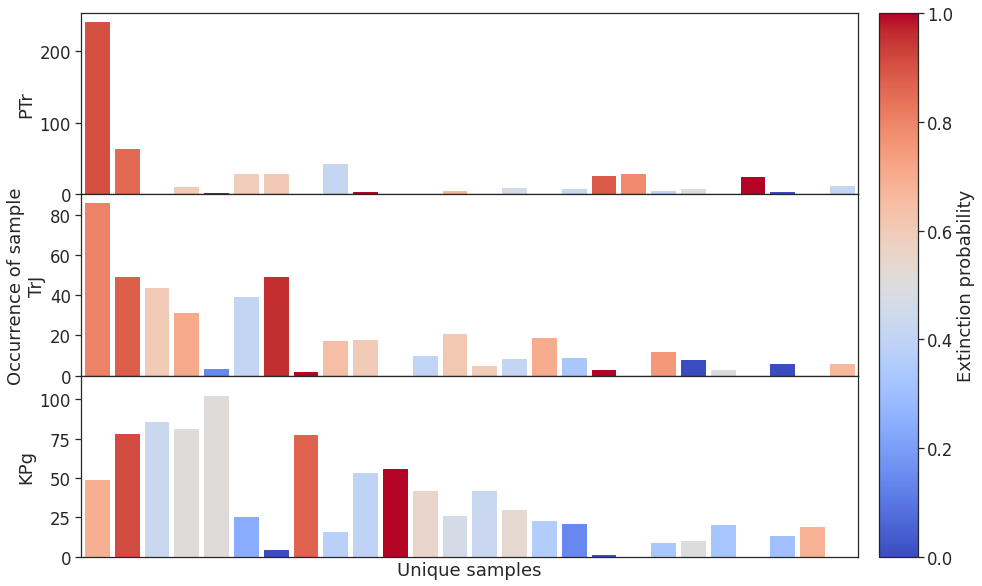

In [29]:
plot_unique_metaspecies()